# Redes Neurais e Regressão Logística

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

## Ajusta Dados

In [3]:
def normalizeXs(x):
    return x/255

def adicionaColuna1(matrix):
    biasFeature = np.ones(matrix.shape[0])
    inputs = np.c_[biasFeature,matrix]
    return inputs

def transform(conjX,conjY):
    targets = []

    for y in conjY:
        target = [0,0,0,0,0,0,0,0,0,0]
        target[y] = 1
        targets.append(target)

    targets = np.array(targets)
    
    
    vectNormalize = np.vectorize(normalizeXs)
    inputs = vectNormalize(conjX)
    inputs = adicionaColuna1(inputs)
    
    return (inputs,targets)

## Conjunto de treino

In [4]:
data = np.load('train.npz')
xs, ys = data['xs'], data['ys']

xs.shape #80.000 dados com 3072 features
ys.shape #80.000 dados com o número de uma classe

(80000,)

In [5]:
(inputs, targets) = transform(xs,ys)

In [6]:
inputs

array([[1.        , 0.46666667, 0.05098039, ..., 0.31764706, 0.29803922,
        0.29803922],
       [1.        , 1.        , 1.        , ..., 0.28235294, 0.32156863,
        0.27058824],
       [1.        , 0.35686275, 0.29019608, ..., 0.40392157, 0.29019608,
        0.1372549 ],
       ...,
       [1.        , 0.00392157, 0.00392157, ..., 0.17647059, 0.14901961,
        0.11764706],
       [1.        , 0.58431373, 0.39607843, ..., 0.56078431, 0.56078431,
        0.56078431],
       [1.        , 0.66666667, 0.74117647, ..., 0.54901961, 0.54901961,
        0.51764706]])

In [7]:
targets

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Conjunto de validação

In [8]:
dataVal = np.load('val.npz')
xsVal, ysVal = dataVal['xs'], dataVal['ys']

In [9]:
(inputsVal, targetsVal) = transform(xsVal,ysVal)

In [10]:
inputsVal

array([[1.        , 0.4       , 0.41960784, ..., 0.4627451 , 0.47058824,
        0.50980392],
       [1.        , 0.44705882, 0.4745098 , ..., 0.45098039, 0.42352941,
        0.39215686],
       [1.        , 0.87843137, 0.97254902, ..., 0.50196078, 0.55686275,
        0.31764706],
       ...,
       [1.        , 0.01960784, 0.01960784, ..., 0.00392157, 0.00392157,
        0.01568627],
       [1.        , 0.94509804, 0.94117647, ..., 0.39215686, 0.34509804,
        0.28235294],
       [1.        , 0.53333333, 0.69803922, ..., 0.13333333, 0.19215686,
        0.05882353]])

In [11]:
targetsVal

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

## Implementando com Regressão Logística Multinomial

In [12]:
def calculateZNet(inputs, weights):
    return inputs.dot(weights)

In [13]:
def softmax(Z):
    ZOut = []
    
    for (l,L) in enumerate(Z):

        somaExpLine = 0;
        
        linha = []
        for (c,C) in enumerate(L):
            somaExpLine += np.exp(L[c])
            
        for (c,C) in enumerate(L):
            expClassX = np.exp(L[c])
            softmaxR = expClassX/somaExpLine
            linha.append(softmaxR)
            
        ZOut.append(linha)
            
    return ZOut

In [14]:
def crossEntropy(line, targets):
    entropy = 0
    for (z, ZOutLine) in enumerate(line):
        entropy += targets[z]*np.log(ZOutLine)
        
    return -(entropy)

In [15]:
def costFunction(ZOut, targets):   
    qtdLines = len(ZOut)
    sumEntropies = 0
    for (l,L) in enumerate(ZOut):
        sumEntropies += crossEntropy(L,targets[l])
        
    return sumEntropies/qtdLines
    

In [16]:
def derivativeCostFunction(inputs, ZOut, targets, weights):
    dErro_dOut = np.subtract(ZOut, targets)
    
    dErro_dW = inputs.T.dot(dErro_dOut)
    qtdLinhas = len(inputs)
    
    divide = lambda x : x / qtdLinhas
    
    ajuste_weight = divide(dErro_dW)
        
    return ajuste_weight

In [100]:
def gradientDescent(inputs, weights, targets, ZOut, learningRate):
    dErro = derivativeCostFunction(inputs,ZOut,targets,weights)
    
    v1 = learningRate*dErro
    updatedWeights = np.subtract(weights,v1)
        
    return updatedWeights

#### Classes de execução

In [18]:
class BatchIterator:
    firstItem = 0
    lastItem = 0
    batchSize = 0
    dataSet = []
    firstIteration = True
    iteration = 0
    stopIteration = -1;
  
  
    def __init__(self, batchSize, data, stopIteration):
        self.batchSize = batchSize
        self.firstItem = 0
        self.lastItem = batchSize
        self.dataSet = data
        
        if(stopIteration >= 0):
            self.stopIteration = stopIteration
    
   
    def hasNext(self):
        if self.firstIteration:
            temp = self.firstItem
        else:
            temp = self.firstItem + self.batchSize
        size = len(self.dataSet)
        
        if(self.iteration >= self.stopIteration and self.stopIteration > -1):
            r = False
        else:
            r = size > temp
            
        return r
    
    def prox(self):
        if self.firstIteration:
            self.firstIteration = False
            self.iteration+= 1
            return self.dataSet[self.firstItem:self.lastItem]

        self.firstItem = self.lastItem
        self.lastItem += self.batchSize
        
        self.iteration+= 1

        return self.dataSet[self.firstItem:self.lastItem]
        

## Classes de execução Regressão Logística

In [19]:
def get_randomly_initialized_theta(lines,columns, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2/(lines + 1))
    return sigma*rand.randn(lines, columns)

In [20]:
def train(epochs,weights,learningRate,batchSize,dataSet,batchIterations):        
    cost_by_epoch = list()

    for i in range(epochs):
        epochInitTime = datetime.datetime.now()
        iterator = BatchIterator(batchSize, dataSet,batchIterations)
        targetIterator = BatchIterator(batchSize, targets, batchIterations)

        bestCost = -1;
        cost_by_batch = list()
        batchIndex = 0

        while iterator.hasNext():
            initTime = datetime.datetime.now()

            batch = iterator.prox()
            batchTargets = targetIterator.prox()

            ZNet = calculateZNet(batch,weights)
            ZOut = softmax(ZNet)

            updatedWeights = gradientDescent(batch, weights, batchTargets, ZOut, learningRate)
            weights = updatedWeights

            cost = costFunction(ZOut, batchTargets)

            batchIndex+=1
            cost_by_batch.append((batchIndex, cost))

            if(bestCost == -1 or cost < bestCost):
                bestCost = cost

            endTime = datetime.datetime.now()

            print("Batch execution time:", endTime - initTime)

        print("cost_by_batch:", cost_by_batch)
        #Plota os custos por batch da época
        df_cost_batch = pd.DataFrame(cost_by_batch, columns = ['batch' , 'cost',])
        fig, ax = plt.subplots()
        plt.title("Custo dos batchs de treinamento da época " + str(i))
        plt.xlabel('Batch')
        plt.ylabel('Custo')
        ax.plot(df_cost_batch['batch'], df_cost_batch['cost'])
        ax.legend()
        plt.show()

        # Validação
        ZNetVal = calculateZNet(inputsVal,weights)
        ZOutVal = softmax(ZNetVal)

        cost_val = costFunction(ZOutVal, targetsVal)

        cost_by_epoch.append((i, bestCost, cost_val))

        epochEndTime = datetime.datetime.now()
        print("Epoch execution time:", epochEndTime - epochInitTime)

    print("Cost by Epoch:", cost_by_epoch)
    return (cost_by_epoch, weights)

In [103]:
## Ploto erro de treino e erro de validacao x epoch
def plot_cost_train_val_by_epoch(costs_by_epoch):
    # Array de tuplas do tipo (id época, custo de validação, custo do batch com menor custo)
    df_cost = pd.DataFrame(costs_by_epoch, columns = ['epoch' , 'training_cost', 'validation_cost'])

    fig, ax = plt.subplots()
    plt.title("Custo de treino e validação pela época")
    plt.xlabel('Época')
    plt.ylabel('Custo')
    ax.plot(df_cost['epoch'], df_cost['training_cost'],label="Treino")
    ax.plot(df_cost['epoch'], df_cost['validation_cost'],'r--',label="Validação")
    ax.legend()
    plt.show()

# Executando

In [ ]:
# weights1 = get_randomly_initialized_theta(3073,10)

In [ ]:
weights1 = np.array([[-0.00386736, -0.00624009, 0.02668439, -0.00999178, 0.0360318, 0.00874799, -0.00461809, 0.02585683, 0.04526523, -0.00771309], [-0.03700661, -0.01601194, 0.01480818, 0.00840689, -0.03618865, -0.00173682, 0.00144157, -0.03511165, -0.00886494, -0.0162571], [-0.0648527, 0.02866754, -0.02222303, -0.04205977, -0.03595128, -0.01031379, -0.02023186, -0.00060201, -0.01084857, 0.01823848], [-0.00560439, -0.02812521, 0.00526032, 0.0136654, -0.03522545, -0.01053858, -0.01025273, -0.0033385, -0.01190447, -0.00398315], [-0.02500869, 0.03785809, -0.00534959, -0.03971712, 0.04158359, -0.009034, 0.01853601, 0.02112362, 0.04436904, 0.02003216], [-0.02836358, 0.00489534, 0.04083517, 0.039644, -0.01564543, 0.03890042, -0.02793737, 0.00817531, -0.07937944, -0.00782283], [0.01828753, 0.03133168, -0.01419596, 0.02417042, -0.00586607, 0.02844698, 0.02305463, -0.01259416, 0.01127635, 0.00232199], [-0.03900614, 0.01971148, 0.00825439, 0.00934311, 0.00411929, 0.00053106, 0.01145821, 0.05944605, 0.0168557, -0.03504619], [-0.00794063, 0.00555273, -0.01226421, 0.02745467, 0.00450207, -0.01809134, 0.02209874, -0.02389441, -0.03199867, 0.00150943], [0.01327743, 0.03304447, -0.0088755, -0.02391209, 0.00327407, 0.01197678, 0.01129858, 0.00294626, -0.00549722, -0.02656422], [0.00363888, -0.02227122, -0.01962808, -0.01736141, -0.03506662, 0.0104962, -0.01220973, 0.03150515, -0.01087716, -0.00374792], [-0.00053899, -0.01954575, -0.01095158, 0.00834226, 0.02005476, 0.00022073, 0.00593721, -0.00227595, 0.02248452, -0.00616943], [-0.04637882, -0.00961017, 0.01704925, -0.00849261, 0.01694571, -0.02231871, 0.01282669, -0.00224139, -0.01377362, -0.03109741], [-0.00757079, 0.00400449, -0.00062867, -0.00933553, 0.00505415, 0.04444683, -0.01108047, 0.0342598, -0.01583794, 0.02164828], [-0.02172158, -0.04022576, -0.01753274, -0.01473137, 0.00977243, 0.03882226, 0.00325262, -0.01160742, -0.03788463, 0.03396998], [-0.02844181, 0.04313315, -0.03231235, 0.0166129, -0.0534335, 0.00879705, -0.01570055, 0.01634533, -0.00403088, 0.01852764], [0.03052741, -0.02708383, 0.02863057, -0.03302317, 0.00612507, 0.01861631, 0.05746204, 0.00272952, -0.028489, 0.01244661], [-0.00986444, 0.0044212, -0.00139896, -0.02293765, -0.0214122, 0.00835171, 0.0071594, -0.02083704, 0.00897257, 0.01177596], [-0.01282475, 0.00915127, 0.0081423, 0.02214599, -0.0113889, 0.00248359, 0.01461547, -0.01587605, -0.0243273, -0.03071988], [-0.05440269, -0.01751564, -0.00547795, 0.07665202, -0.02164533, -0.01143044, 0.02048586, 0.03208101, -0.00402625, -0.0566304], [0.0706373, -0.00519612, -0.01144129, 0.0016735, -0.05429301, 0.00685889, -0.06193143, 0.01845295, 0.0072974, -0.00467488], [0.03410238, -0.000317, -0.01231262, -0.01219027, -0.01202798, 0.00054259, 0.02212591, 0.00959146, 0.00429643, -0.07755244], [-0.05120108, 0.00842375, -0.00185762, 0.00470845, -0.05372819, -0.03291658, -0.01135299, -0.03457939, 0.01041485, 0.01109798], [0.03295295, -0.03167996, 0.01200142, 0.00939388, -0.0268599, 0.0098849, 0.01895437, 0.00324035, 0.0180415, 0.00126109], [-0.00126372, -0.03001816, 0.01759419, 0.00802241, 0.00785871, -0.00332439, 0.02446132, 0.0589992, -0.03038067, 0.0092863], [0.00576206, 0.05572175, 0.00368483, 0.01659284, -0.03107938, 0.05350987, -0.03640535, -0.03544712, -0.00762222, -0.00511592], [0.0804606, 0.00877001, -0.0284799, -0.01435203, -0.00244657, 0.00680326, -0.00602993, -0.01499939, 0.01673638, 0.00093119], [0.05956973, 0.00554687, -0.06329095, -0.01624232, -0.03081086, -0.04104567, -0.01913508, -0.00392346, 0.02933581, 0.03316753], [0.00378138, 0.00506669, 0.01116292, -0.0237973, -0.01328514, -0.01868498, -0.03327801, 0.01678036, -0.05593186, -0.03511087], [-0.03671169, 0.01044934, -0.00655177, -0.01066557, 0.02161138, 0.02719089, -0.01226371, 0.0294128, 0.07408596, 0.03348329], [-0.03186913, 0.03078993, -0.02180016, 0.02375827, 0.01213685, -0.03346476, -0.04389744, -0.02491126, 0.0145382, -0.01772341], [-0.03450691, 0.04265741, -0.02065178, 0.01750592, -0.01304114, -0.01323503, -0.00088669, -0.00787307, -0.04029674, -0.04631599], [-0.0090216, -0.04156298, 0.02232836, -0.0292758, 0.00652169, -0.01591594, -0.00629538, -0.04045925, -0.02051, 0.02212011], [0.03695997, 0.02703836, 0.02068255, 0.07520471, -0.00113267, 0.01002234, -0.01186104, 0.0216866, -0.01675418, -0.00556701], [-0.01115195, -0.02160553, -0.00918174, -0.00144311, 0.0074893, 0.00568883, -0.01380556, 0.01889708, 0.01238143, -0.04051136], [-0.00808268, 0.02470379, 0.04794341, 0.03076336, -0.03044323, 0.00486936, 0.01126198, -0.00262094, 0.0149475, -0.04096719], [-0.00301653, 0.0277347, 0.02080199, 0.01916038, 0.00456739, 0.02759697, 0.02232789, 0.03274541, 0.03996415, 0.00073184], [0.01267168, -0.03682368, 0.01318718, -0.05190209, -0.00448014, 0.00960308, -0.00552157, -0.02445688, -0.01787102, 0.01782827], [-0.01707891, -0.0255634, -0.01243099, 0.02127314, 0.0114575, 0.00202179, -0.01436827, 0.02297895, -0.01127783, 0.0035374], [-0.00748268, 0.01605397, -0.01315782, -0.00520447, 0.00496583, -0.03582657, 0.02023681, -0.01495482, -0.00106386, 0.01972291], [0.00403663, 0.00346803, 0.04066382, -0.00219084, 0.01099372, 0.0248212, -0.01819608, -0.02003676, 0.02342194, 0.06762942], [0.06680142, 0.00834927, -0.00492283, 0.03250592, -0.06245594, 0.02319558, -0.05146392, 0.04460798, 0.02316921, 0.01275429], [0.02152759, -0.0038456, -0.05811684, 0.01295583, 0.00137601, -0.05572381, -0.0027041, -0.00591535, -0.00440897, 0.00011848], [0.00364995, -0.05509784, -0.00373798, 0.00432761, -0.01936779, 0.00137815, -0.02061948, -0.00707608, -0.00358853, 0.02313335], [-0.01786475, 0.04687214, 0.01701677, -0.01435047, -0.00472497, -0.04290571, 0.04260963, -0.00564545, -0.04818878, 0.02311303], [-0.0013486, -0.03947334, 0.00763599, 0.04005473, -0.00757129, -0.00762772, -0.02517287, 0.00517967, 0.0156419, -0.01451556], [-0.01988076, 0.0296442, -0.02394855, -0.03390286, 0.00517823, -0.06567083, -0.00520163, 0.03193684, -0.0163129, -0.01384293], [0.02387631, -0.01241569, 0.00981046, 0.0064982, -0.03507464, -0.02165359, 0.00957672, -0.00802778, -0.0040026, -0.01859435], [0.03972926, 0.01784074, -0.01263901, -0.01110084, -0.00409064, 0.0080139, 0.00990689, -0.0051477, 0.02300182, -0.0018609], [-0.00629288, 0.01331595, 0.00306449, -0.0221204, -0.00402654, -0.00191509, 0.02948793, -0.02540263, 0.02756696, 0.04547368], [-0.00406338, -0.01664566, 0.0056044, -0.00038816, -0.02178613, -0.04265241, 0.01515063, -0.00442676, 0.0329739, 0.0177084], [0.02538184, -0.04682289, 0.00338117, -0.01356562, 0.0402052, -0.02348633, -0.01627793, 0.01852087, 0.03288069, 0.03287219], [0.01504136, -0.00671083, -0.02628002, 0.00943568, 0.0010242, -0.00585047, 0.03056301, 0.0550471, -0.00587612, -0.02708834], [0.02325709, 0.00383399, -0.06562841, 0.0013521, -0.01271487, -0.02601822, 0.04556616, -0.00449864, -0.00025541, 0.00584476], [0.02201165, 0.0247663, -0.02174076, -0.0147314, 0.02925314, 0.01060896, 0.00845471, -0.00634925, 0.00549269, 0.02199982], [0.03017435, -0.03397394, 0.0182224, -0.05197032, -0.00503061, 0.04389422, -0.02886939, -0.00688102, -0.00266973, 0.02679314], [0.03654876, 0.012541, 0.01492889, -0.02928585, -0.02663877, -0.00825293, -0.01159102, 0.01072574, 0.01415104, 0.02097875], [0.0155251, 0.00806129, -0.04120274, -0.05549942, 0.02089947, 0.03346782, 0.01668804, 0.05443151, -0.01476853, 0.00813463], [0.00186332, -0.00964342, -0.01028068, 0.02176994, 0.00534168, 0.02506765, 0.01237045, -0.03112711, -0.01436708, -0.02613878], [-0.05803337, -0.03166493, 0.02061537, 0.00745244, -0.02124967, 0.08944566, -0.01363541, 0.0210159, 0.02514555, -0.00683553], [-0.01989202, 0.0079896, -0.00289562, 0.02386775, 0.01693942, -0.01138717, 0.02015072, 0.036217, -0.00180557, 0.02531306], [-0.0260394, 0.03359573, 0.02166553, -0.0145685, -0.01932033, -0.03547703, -0.04121592, 0.01820217, 0.00023633, -0.01390312], [0.04226171, -0.00038942, 0.01441255, 0.01919441, -0.00469312, -0.02304239, 0.00335295, 0.01765316, 0.03219894, -0.07658023], [-0.03472406, -0.00621991, 0.01435924, -0.01019585, 0.05067872, -0.00100281, 0.04866968, -0.01672633, -0.00782329, -0.01079151], [-0.05987369, 0.00629282, -0.012157, -0.03136138, -0.00570622, 0.01137152, -0.00526953, 0.01856966, 0.00475659, 0.03895031], [0.02111891, 0.02639189, -0.01569549, 0.01458603, -0.00069903, 0.01043641, -0.00423061, 0.05449876, 0.03826224, 0.01666132], [0.01568946, -0.01798078, 0.01461078, -0.01705207, 0.00518416, 0.00629205, -0.02715365, 0.00561891, 0.0153126, 0.03510432], [-0.02098004, -0.03246882, 0.02332697, -0.0240479, -0.02895105, -0.01316064, 0.00266058, -0.04389959, 0.01475307, 0.04451967], [0.02166151, 0.04326932, 0.01620858, 0.01698144, -0.02376986, 0.02491087, 0.02902339, -0.03736945, 0.00548836, 0.0128753], [0.00035432, -0.00472819, -0.00620556, -0.02455308, -0.01501199, 0.03421157, -0.04487773, -0.00356608, -0.02251606, -0.02833526], [-0.00395276, -0.02458131, -0.0159704, 0.0115052, -0.00043176, -0.00898994, -0.02604789, 0.00503935, 0.01811778, -0.00698465], [-0.01540098, -0.0007467, 0.03791552, -0.00708766, -0.03296373, 0.04222406, 0.03344805, 0.00525679, 0.01100131, 0.02927078], [0.0024077, 0.01852651, -0.00721299, 0.04470551, -0.03061259, 0.00313818, -0.05163747, -0.00986672, 0.02354985, 0.04255218], [0.01645362, -0.00381157, -0.00407883, 0.00155099, 0.0150601, 0.03059721, 0.04029174, -0.05595019, -0.01335066, 0.02685333], [0.02328235, -0.01850512, -0.02587797, -0.00217771, 0.03118938, 0.00963301, 0.00674317, -0.04299803, -0.03295824, 0.00796049], [0.03362456, 0.01962715, -0.04671332, -0.03909708, 0.01074096, 0.00610817, 0.01345052, -0.01921193, 0.02566911, 0.01276968], [0.00672422, 0.01533759, 0.0242882, -0.03146267, -0.0218647, 0.00839175, 0.03797869, -0.00926942, -0.0334253, -0.03236413], [0.04656397, 9.4e-05, -0.03476404, 0.01494804, -0.03548041, 0.00998465, 0.01485858, -0.0002443, -0.01528326, 0.00876976], [0.01241829, -0.01569764, 0.01831532, -0.01081217, 0.01502122, 0.02461668, 0.01175094, 0.02832903, 0.00537507, -0.03369564], [-0.00286861, -0.03637989, -0.00910809, -0.01898882, -0.01472877, -0.00681432, -0.05836674, -0.01316824, 0.0025307, -0.01117257], [-0.01596595, -0.00144423, 0.0228098, -0.05139041, 0.05836572, -0.00994634, -0.0363128, 0.01161849, 0.01083463, 0.00803488], [-0.01447894, -0.01109594, -0.00074242, 0.00016031, 0.02603143, 0.0157881, -0.02389247, -0.01275911, 0.01377988, 0.02229143], [-0.02369486, 0.00822615, -0.01654472, -0.01271249, 0.01552468, -0.00095785, 0.01714826, 0.00922317, 0.00412439, 0.02661762], [-0.00179702, 0.03262824, 0.00030395, -0.04292424, -0.02730692, -0.01247913, 0.01673968, -0.03290865, -0.00166704, 0.01862399], [-0.00200925, 0.02227743, 0.00663554, -0.00460764, -0.02903007, 0.00852112, 0.01886429, -0.01113192, -0.00640736, 0.02021374], [0.00590935, 0.03760674, -0.00070216, 0.03503951, -0.02142752, 0.00275674, -0.01434023, -0.00367104, -0.03571192, -0.0033735], [0.00866717, -0.01643257, 0.02383476, -0.00230783, -0.0267458, -0.0117052, 0.01700389, -0.00175972, 0.01176992, 0.02040938], [-0.0104364, 0.01098297, -0.01748847, -0.00211054, 0.00770919, 0.03407586, -0.00334869, -0.01836512, 0.06659501, 0.01408375], [0.03408705, -0.05118211, -0.00589979, 0.0038629, 0.01900181, -0.0006235, 0.00983723, 0.00474311, -0.027135, 0.01541172], [-0.0130303, 0.00112476, -0.01615558, 0.04848856, 0.01314986, 0.02175168, 0.00845961, -0.0039356, 0.00619038, 0.01740509], [0.00569602, -0.01772072, -0.02094429, -0.04843954, 0.00750709, 0.06263317, 0.00294599, 0.00815161, -0.01063964, -0.04195589], [0.02419362, 0.02983882, -0.01761733, -0.00705321, -0.00985228, 0.00280921, 0.02626817, 0.05798858, -0.003075, -0.01984061], [0.01264349, -0.03479749, 0.00629232, -0.00854541, -0.01139297, -0.01130887, -0.01331671, 0.0056002, -0.0071237, -0.02144084], [-0.00486818, 0.01072028, -0.01846887, -0.01535676, -0.00704774, 0.01863628, 0.00392979, 0.03568693, -0.01576558, -0.02056783], [0.01639778, -0.01795679, 0.00490251, -0.03013044, 0.00792555, -0.00126329, 0.00127722, 0.05736341, 0.00236059, -0.02163264], [-0.00336746, 0.04002232, 0.0465679, 0.01381588, -0.01791863, 0.00387003, 0.02205027, -0.03269083, 0.03555332, -0.0151262], [-0.02487969, -7.258e-05, -0.00337079, -0.00688348, -0.04527008, 0.01074722, 0.01544663, 0.00159375, -0.01236557, -0.01900076], [-0.0382955, -0.02813638, -0.03553191, -0.01685774, 0.00049143, 0.00898647, -0.0513223, 0.00314926, -0.01855944, 0.00375852], [-0.01449931, 0.01747236, -0.03540528, -0.02398612, 0.01653058, 0.00650769, 0.05464693, 8.2e-06, 0.01672273, -0.04023378], [-0.02399816, 0.01180274, 0.01859621, -0.0257223, 0.0152122, 0.00609898, 0.01632978, -0.03257543, 0.00089431, 0.00933298], [-0.01669629, -0.01399412, 0.00505003, -0.00792398, -0.00231639, -0.00215772, -0.01742534, 0.01325992, -0.00664844, 0.03774543], [-0.02039291, -0.00392731, -0.0110291, 0.0390276, -0.00010924, 0.01691047, -0.03721332, 0.03127505, -0.01530047, -0.03416143], [0.02426335, -0.01851904, -0.01445218, 0.00139454, -0.01936828, 0.00841151, 0.01945563, -0.03385024, -0.01736792, 0.00385232], [-0.04814006, -0.00087921, 0.05940072, -0.00930044, 0.00327383, 0.00161666, -0.01876612, -0.02718506, -0.02679547, -0.00013569], [0.03768547, -0.00617247, -0.00322686, 0.03373394, 0.04305869, -0.00172947, -0.00058999, -0.0340965, -0.02279268, 0.04519504], [-0.00704753, 0.02425265, 0.00507851, -0.0291303, -0.03105983, 0.03468312, -0.02694662, -0.00693667, -0.01426421, 0.00919405], [-0.02802756, -0.01968051, -0.01570089, -0.0038537, -0.00192219, 0.02229061, -0.01003242, -0.00214388, 0.04556609, -0.01885178], [0.02446636, -0.02505338, 0.02507444, -0.04721155, 0.00804721, 0.0092005, -0.02612272, 0.00298641, 0.0053259, 0.02156127], [0.02760492, -0.02593226, -0.04774401, 0.00533173, 0.00808102, 0.0212689, -0.02514031, -0.00032376, -0.02314321, 0.02002606], [-0.02014733, 0.00922729, -0.00974739, -0.02584619, -0.0086867, -0.01955204, 0.04030218, -0.01184948, -0.00394052, 0.07373671], [0.00778079, -0.01282407, -0.00571948, 0.00454762, 0.03167399, -0.04809, -0.06867285, -0.01611431, 0.0025038, -0.01568283], [-0.0154877, -0.0342351, 0.01828526, 0.0298485, 0.04766864, 0.01204963, -0.0376753, 0.00506503, 0.04714153, 0.01263367], [-0.02449664, -0.00651179, -0.0314475, 0.02272996, 0.01818632, 0.03341923, 0.03282445, 0.02445623, 0.07971541, 0.00709894], [-0.00902882, -0.0090943, -0.03558617, -0.04186668, 0.02632868, -0.01605874, -0.02705147, -0.01256994, 0.00906517, 0.01227421], [-0.03509435, 0.03740556, 0.03353795, 0.00596696, -0.0066644, 0.01182962, -0.00096135, -0.07172773, -0.01025114, -0.00539926], [0.00953689, -0.00962984, -0.02829907, 0.02118896, 0.01820738, 0.00101859, -0.0203637, -0.03008911, 0.00454929, -0.02276197], [0.01765758, -0.03287617, -0.01350854, 0.0152548, 0.02067207, -0.00716271, -0.0155246, -0.03105051, -0.03846119, 0.01055902], [-0.03231422, 0.02372284, 0.00871369, 0.00799042, -0.00608023, 0.01016256, -0.02475246, 0.0298881, -0.00911233, -0.00905396], [0.01442608, -0.03784334, 0.01090296, -0.05053142, -0.00660565, 0.0120144, 0.00931553, 0.02084226, -0.01446589, 0.00995673], [-0.00823515, 0.0059408, 0.00569254, 0.00152828, 0.01653074, 0.01672961, 0.02668474, 0.01795341, 0.02707595, 0.01177803], [0.04224108, -0.02180127, 0.01922166, -0.00692963, 0.00344764, 0.03921064, -0.0145035, -0.02955351, 0.00076185, -0.00432675], [0.01315848, 0.00564649, 0.0023488, -0.02469052, -0.04411234, -0.01053509, -0.04713386, 0.01933308, 0.02474563, -0.01337755], [0.01144439, 0.04278892, -0.00712426, 0.0197344, -0.0055273, 0.04170365, 0.03910362, -0.02681243, 0.02792716, 0.01865238], [0.0073304, 0.01595778, 0.04267783, 0.02276052, -0.00959796, 0.00767742, -0.01303884, 0.01474161, 0.01495507, 0.00410034], [0.0197248, -0.01992713, 0.0006803, 0.01370742, -0.00076033, 0.01652967, -0.02756944, -0.0040443, 0.05276811, -0.04782401], [-0.02941402, -0.01362895, 0.00686226, 0.05249105, -0.02932206, -0.0216114, 0.00107548, 0.02698232, -0.0215817, -0.00852606], [0.02120778, -0.01825954, -0.03784969, 0.00832635, -0.02382535, 0.01905128, -0.03522477, 0.02037482, 0.00418579, 0.00019737], [-0.0191968, -0.06571663, 0.00598417, -0.03917506, 0.02709067, -0.01235763, -0.02546493, -0.01375519, 0.00204728, 0.03405352], [0.00735793, 0.00652929, -0.00643186, 0.02073535, -0.02465977, 0.02273027, -0.02297204, 0.00380602, 0.03291103, -0.00761026], [-0.00967761, -0.02153431, -0.00574126, -0.0173156, 0.02206588, -0.03328932, -0.01128637, 0.02715482, -0.01187142, -0.00564826], [0.0290723, 0.01451625, 0.01302496, 0.01034593, -0.03446917, 0.00586147, -0.00501023, 0.00631708, 0.03794251, 0.05287594], [0.00114923, 0.03205562, -1.272e-05, 0.00388988, 0.05433669, 0.04410852, -0.01675032, 0.02553813, 0.00748709, -0.00079167], [-0.00065645, -0.00898725, 0.00514764, 0.01711553, 0.00245704, -0.00178114, 0.02286033, -0.00589257, 0.0496819, 0.06180359], [-0.01295171, 0.03375092, -0.03215532, -0.01222333, -0.02651203, -0.02758446, -0.03676272, 0.00707474, 0.03497859, 0.00975047], [-0.03029997, -0.00042985, -0.01150187, -0.01561832, 0.01204372, -0.00016889, 0.02308086, 0.02302572, -0.00948634, 0.03078004], [-0.01995836, 0.00733687, -0.00630662, -0.02330981, 0.04632198, -0.05547652, -0.00273664, 0.03398556, 0.0240862, 0.00010336], [-0.0145257, -0.00270564, 0.00867311, -0.00464302, 0.06481456, 0.02754009, -0.01814817, -0.0157146, 0.00062856, 0.01886844], [-0.00999672, -0.03383484, 0.01764936, 0.00619264, 0.02033573, 0.00551225, -0.01788276, -0.01017787, -0.03348261, 0.00338628], [0.03453543, -0.01261714, -0.01250648, -0.00575955, 0.02872436, 0.01741927, 0.02547679, 0.01008225, 0.04739419, -0.01743714], [0.00972595, 0.02492903, -0.00103177, 0.00685728, 0.04589281, 0.02055529, -0.0481, -0.04004193, 0.05686573, 0.00926553], [-0.02663911, 0.00327058, 0.03440508, 0.01082227, 0.02179572, 0.02012369, 0.03641442, 0.01607059, 0.01753246, 0.01615861], [0.03725704, 0.01034887, 0.01641058, 0.00283279, 0.04902156, -0.0029766, 0.04110806, 0.01959682, -0.05612725, 0.02131613], [0.01915891, -0.03559888, 0.04040502, 0.02548014, 0.02152675, -0.00826691, -0.00710894, 0.01353877, -0.01119354, -0.01332586], [0.02210565, 0.05133376, -0.01263689, -0.04008655, 0.00188311, 0.01160272, 0.00507639, -0.00421983, 0.05159306, -0.01792201], [-0.01677695, -0.00469713, -0.00751129, -0.0043504, -0.01962055, -0.01543428, -0.02701749, 0.02671396, 0.01034162, 0.00729357], [0.01418061, 0.03602455, -0.03435189, -0.06162896, -0.01893247, 0.04937734, 0.00694942, -0.0154531, -0.03606166, 0.01521664], [0.01504988, 0.04942344, -0.00780195, -0.00358973, 0.02380267, -0.01234821, 0.04404079, 0.01202809, 0.0262861, -0.00262387], [0.00134121, -0.0139035, 0.02167816, 0.03008533, -0.00497374, -0.01171272, 0.01315841, -0.00748026, 0.03131627, 0.04688458], [-0.00549421, 0.02214697, -0.00435687, 0.02213488, 0.00348792, -0.03669454, 0.00888409, 0.0223295, 0.01250656, 0.04713409], [-0.01286986, 0.0116492, 0.00382289, 0.00604481, -0.04295215, -0.01058161, -0.0066821, -0.01342918, -0.02676956, 0.03706499], [0.00159282, 0.02191188, -0.02201436, -0.01625653, -0.0404684, -0.05897664, -0.0028009, -0.03152866, -0.00202742, 0.01730208], [0.00610284, -0.03699486, -0.01128235, 0.03300649, -0.00522861, -0.05031873, -0.01800214, 0.02391984, -0.0367081, 0.02255275], [0.04227162, 0.02377976, -0.00554, -0.01405711, -0.00173604, -0.01864957, 0.00329319, 0.03278329, -0.00039268, -0.01823805], [-0.04502986, -0.0299121, 0.02939006, -0.00532335, -0.02628279, -0.00658071, 0.00753223, -0.01587311, 0.04435178, -0.01824553], [-0.0226562, 0.02066923, -0.01255487, -0.02963744, -0.01526023, -0.03969848, 0.03823706, -0.02700905, 0.00654005, 0.01819712], [0.00081172, 0.04571322, -0.01750291, 0.00094477, -0.03747749, -0.0003233, -0.00617621, 0.001137, 0.0009002, 0.03423116], [0.00495081, -0.01142456, -0.03043738, -0.01154919, -0.02136855, 0.00187472, -0.00517968, -0.01514559, 0.01715425, 0.01812192], [-0.00722827, 0.03774694, -0.00957859, -0.00145547, -0.02146852, -0.04010895, -0.02328889, 0.06161404, 0.02222105, -0.0062565], [0.02930561, -0.00854735, 0.0178968, 0.00242538, 0.00850973, 0.02997421, -0.04891333, -0.02147041, 0.00601889, 0.02376284], [0.01938575, -0.0208475, -0.00847902, -0.00408464, -0.03666233, 0.01472454, 0.02328988, 0.03840451, 0.01244778, -0.00288768], [0.00943455, -0.02996478, -0.00091952, -0.00332044, 0.02318066, -0.04974982, 0.01536334, 0.02637045, -0.05379501, -0.02508485], [-0.00105592, -0.0226152, -0.0102481, 0.00310338, 0.0148906, -3.554e-05, 0.07194424, 0.05802492, 0.01295254, 0.00156106], [-0.03037887, 0.00134492, -0.04018152, -0.01131508, 0.01490469, -0.01134573, -0.0056295, -0.00993999, 0.05478284, -0.01556269], [-0.02814449, 0.00965839, -0.00742785, 0.0315848, -0.01821677, -0.02079286, 0.01475228, -0.02502835, 0.00908724, -0.00553553], [0.00441714, 0.01801755, 0.00104958, -0.0437339, 0.01605116, -0.02584047, -0.04430927, 0.04795115, 0.03163451, 0.02062876], [-0.03078456, 0.00871334, 0.00582884, -0.00963081, -0.01121893, -0.00577685, -0.06899268, -0.01355126, -0.02207532, -0.04089331], [0.0152178, 0.04095499, -0.00166188, -0.03287338, -0.01293453, -0.0327175, 0.03706856, 0.02806864, 0.00127825, -0.01109981], [0.03194025, -0.01377093, -0.01893338, -0.03088353, -0.00169342, 0.02572359, -0.03343791, -0.02864613, 0.02876061, -0.0141159], [-0.01760473, -0.03679191, -0.02318586, 0.03216477, -0.0060392, -0.01937806, -0.0274182, 0.00161201, 0.04644704, 0.02868805], [0.00651971, -0.03715323, -0.01965527, -0.02817585, -0.01554803, 0.02569622, 0.02117928, -0.01730512, -0.00667563, 0.00525045], [-0.0088697, -0.01436415, 0.0115784, 0.02011616, -0.00365584, 0.00128316, -0.0091347, -0.00981716, 0.01498022, -0.01126342], [0.00581069, 0.01584605, -0.02850136, -0.01073937, 0.02124847, -0.03752826, -0.00648409, -0.03511002, -0.01567763, -0.03603874], [0.02598952, 0.02421021, -0.01679581, -0.02735586, -0.02606864, -0.02815865, -0.02293389, -0.01688136, 0.01293289, 0.02514094], [-0.0039068, 0.00110825, 0.0016783, 0.00371598, -0.01262766, -0.04380019, -0.04120767, -0.04256889, -0.00378346, -0.00153581], [-0.01096666, 0.00739524, 0.01765009, -0.0203963, -0.01206701, -0.0182612, 0.02416855, -0.00218857, -0.03792368, -0.01994235], [-0.00242143, -0.0139029, -0.02834607, -0.00912878, -0.01248685, -0.03577043, -0.0080739, 0.04853753, 0.00949393, 0.01158533], [-0.00964892, 0.02340098, -0.01615667, 0.0001264, -0.01987369, 0.02879233, 0.02482239, 0.02729086, 0.02209186, -0.04350257], [-0.0145121, 0.00779911, 0.03108715, -0.03768279, 0.01473749, -0.0004573, 0.03445036, -0.02266002, -0.0527887, 0.020109], [-0.00034001, 0.02902154, 0.00164404, -0.03052476, 0.03274699, -0.00258514, -0.01957148, 0.0009515, 0.01844728, 0.00940579], [-0.02995083, 0.01239877, -0.0217438, -0.0108287, 0.04118864, -0.03020813, 0.01737017, 0.01688508, 0.00295466, -0.0037451], [-0.00758635, 0.01240096, -0.03387297, 0.00866005, 0.04670362, -0.00804723, 0.00180852, 0.02103757, -0.04560572, -0.01734839], [-0.00321106, -0.02545851, 0.02175817, -0.01055895, -0.03266256, 0.04380856, 0.009238, 0.04731848, -0.00486172, 0.03624402], [0.05944532, -0.01282576, -0.03253547, -0.02367138, -0.03935975, -0.03461561, 0.03516795, 0.02349778, 0.03573837, -0.0167657], [-0.00436355, -0.01677799, -0.01463815, 0.02386233, -0.03843774, -0.01522189, 0.00507378, 0.05089551, 0.00976689, -0.02195126], [0.03405102, 0.01002141, 0.01788126, -0.01669648, 0.02095375, 0.00275154, -0.00808547, -0.0197351, 0.00958744, 0.01518513], [-0.0169882, -0.00142225, -0.04277625, -0.01713844, -0.00137921, 0.01157633, 0.01396407, 0.02225288, -0.00443185, -0.01856549], [0.01575257, -0.00753346, 0.01302692, 0.02564442, 0.00172167, 0.01448228, 0.0114606, 0.02611223, 0.01587993, -0.00048802], [-0.03104069, -0.05864468, 0.01887444, 0.02361046, 0.01147173, -0.01653936, 0.01963957, -0.02646616, -0.0588867, -0.00500203], [0.00602724, 0.00313458, 0.0373483, 0.00299456, 0.01554622, -0.04101908, -0.00235879, 0.03821383, 0.05902388, 0.01547031], [-0.01039034, 0.01097442, -0.02701592, -0.01593008, -0.00654947, -0.01211315, -0.00153783, 0.00051265, -0.04042748, 0.03252911], [0.00461556, -0.01360891, -0.00826259, 0.00840348, 0.0099782, 0.04337987, -0.01426148, 0.01178628, 0.03155643, 0.03392479], [0.03783459, -0.01332671, 0.05922303, 0.02207938, -0.00689592, -0.00998726, 0.0440623, -0.0183048, 0.02065979, 0.03827871], [-0.01124046, 0.00692212, -0.00896698, 0.01572805, 0.03796625, -0.04892539, 0.05167068, 0.00628224, 0.00468477, 0.01064193], [0.05424723, -0.02513041, -0.05759431, -0.0159647, -0.03162771, -0.01323344, -0.00812127, -0.01544188, 0.05205626, -0.00176688], [0.0031843, -0.02720775, 0.00685186, -0.0037644, -0.02648969, -0.03121534, 0.05311668, 0.01791565, -0.01352877, 0.0382003], [0.02503984, 0.02188801, -0.03071053, -0.00998288, 0.03065091, -0.00841179, -0.01951179, -0.02325261, -0.02388827, -0.0154035], [-1.01e-06, 0.03864005, -0.0394515, 0.01399303, 0.00277662, -0.0432192, 0.01630658, 0.03079777, 0.04747769, 0.00924162], [-0.02684436, 0.042358, 0.02046072, -0.0035905, 0.02434584, -0.01657035, 0.02775492, -0.03707407, -0.01716897, 0.00828609], [0.02009786, -0.00991982, -0.00110264, 0.01962687, 0.02322894, -0.01630129, 0.00289513, 0.03405427, -0.00266444, -0.02790585], [0.00201958, 0.03508156, -0.0119501, 0.02163525, 0.0145708, 0.02696856, 0.00147569, 0.0368336, -0.030089, 0.02039934], [0.02094635, 0.00093392, -0.01769077, -0.0222075, 0.0056424, -0.02975206, -0.04248962, 0.00109804, 0.00669859, 0.01320186], [0.04698572, 0.00465491, -0.03220071, -0.03406754, -0.00464199, -0.02444409, -0.01828405, 0.0267775, -0.01987382, -0.02246065], [-0.01315121, 0.04869066, 0.00228809, -0.00639298, -0.02591718, 0.02935742, -0.03457295, 0.00833846, -0.00326107, 0.0020656], [0.0354976, 0.02173844, 0.03295714, -0.04798146, -0.00975434, 0.00015444, -0.00259021, 0.0047549, 0.01656633, 0.01049506], [0.03444708, -0.01407137, 0.03201301, 0.00974108, 0.0183593, -0.01599757, -0.03715863, -0.04291841, 0.05011441, 0.00304146], [0.00392537, -0.05758867, -0.00121613, -0.04129034, 0.01821842, -0.02673373, -0.01666257, 0.0272808, -0.00209551, -0.03846538], [-0.02260305, -0.04352687, -0.00352428, 0.04201648, 0.01956444, 0.0601707, 0.01915583, 0.02887397, -0.01577499, 0.02176478], [-0.01619867, -0.01002394, 0.03088283, -0.01901006, 0.02164074, 0.02431462, -0.01107676, 0.02668982, -0.01777825, -0.00155055], [0.02253558, -0.00632474, -0.00819035, 0.02543493, -0.00247986, 0.01520413, 0.03699329, -0.00670542, 0.01096009, 0.01705955], [0.06825102, 0.02744805, 0.00131295, 0.05248549, -0.00688112, 0.01652715, 0.04390598, -0.00578924, -0.01563672, 0.02092481], [-0.01167782, -0.00686856, 0.0127581, -0.00958282, 0.03149489, 0.00475534, -0.04677874, 0.00474803, -2.456e-05, 0.01549739], [0.03449011, 0.01069028, -0.00781412, 0.0279071, 0.00914159, -0.01090345, 0.03748175, -0.06921106, -0.02449211, 0.02663202], [-0.0141248, 0.00807914, 0.03605651, 0.01468896, 0.02021371, 0.02106816, -0.01907319, 0.01609854, 0.00956896, 0.03574778], [-0.02904747, -0.03167007, -0.02841072, 0.01444782, 0.0266481, -0.00137859, 0.01792419, 0.00527686, -0.01134836, -0.0151889], [-0.03119554, -0.01644846, -0.00710338, 0.03007433, 0.00367565, -0.00463965, 0.02670383, 0.02254302, -0.00035379, 0.00752011], [0.01456457, 0.01004717, -0.02458698, 0.04939926, 0.01638395, 0.04468256, -0.01289132, 0.00230928, 0.02350735, 0.0264874], [0.03499163, 0.05018366, -0.00638877, 0.00752195, -0.010525, -0.02513567, 0.01042944, -0.01534875, -0.00704399, -0.02717625], [-0.0081624, 0.0178783, 0.05902315, 0.01287836, 0.0188013, 0.0174519, -0.07099147, 0.014528, -0.02345977, 0.00851364], [0.03586699, 0.00918466, 0.00845713, -0.01214447, 0.0225639, 0.03356066, 0.00254704, 0.01267488, 0.04982898, 0.00781404], [-0.00583527, -0.02225982, 0.00135922, -0.01508262, 0.01324904, -0.02201195, -0.01665017, -0.00073772, 0.02190676, 0.01818245], [0.01537171, 0.01708738, -3.733e-05, 0.00571881, 0.01347734, 0.00841947, 0.03482927, 0.02270308, -0.02419802, 0.01730956], [-0.02698996, -0.02089224, 0.01181577, 0.02783617, -0.03027383, -0.00647707, 0.00085782, 0.01558735, 0.02860186, -0.02954345], [0.01115949, 0.00706682, -0.03600876, 0.00652632, 0.02596737, 0.01821722, 0.0035544, -0.02619795, -0.00718814, -0.017321], [-0.05168236, -0.02887124, -0.02986882, -0.01117493, -0.017427, 0.0021278, -0.00602376, -0.03230179, 0.00110393, -0.00121405], [-0.02494277, -0.01616194, 0.02252216, 0.00101569, 0.02577529, 0.0558378, 0.02219083, 0.00796906, -0.00057082, -0.03439045], [0.02455264, -0.0576819, -0.00161831, -0.01541113, 0.01097208, -0.01639716, 0.00401703, 0.04792987, -0.03008124, -0.02885738], [-0.00654989, 0.015386, 0.0285887, -0.02312207, 0.00919959, 0.04557144, 0.02267504, 0.01697605, 0.00425087, 0.00635577], [0.05470673, 0.03589759, -0.06941584, 0.0490516, 0.01459428, 0.02861571, -0.00470625, 0.02198906, 0.01362799, -0.01786993], [0.02035015, 0.03364704, -0.05620443, -0.00261583, -0.02196241, 0.00064459, -0.02577264, -0.01708324, 0.00146706, 0.00052243], [0.00972168, -0.01849703, 0.04651158, 0.01114287, 0.00290498, 0.02693039, 0.04896276, 0.01998893, -0.03088167, -0.01984495], [0.00849594, -0.02615096, 0.03263621, -0.02944438, -0.01135622, -0.02417208, 0.03043649, 0.00592025, 0.00895014, -0.00161547], [0.01201454, 0.02372314, -0.01052598, -0.01497386, -0.02678546, 0.03217531, -0.00686939, -0.04657618, 0.00911684, -0.01352038], [-0.02294788, -0.01993474, -0.01506741, 0.03511703, -0.00983642, 0.04442584, 0.00143811, 0.01504797, -0.04106113, -0.01930741], [0.02892519, 0.0400429, -0.00702905, 0.01783836, 0.00590835, 0.04295701, -0.00677478, -0.0592317, -0.00095077, 0.03439355], [-0.03108324, -0.00098316, -0.04889805, -0.04185805, -0.04575571, -0.00281672, -0.00924889, 0.00959248, -0.00729718, 0.00477157], [0.01863592, -0.00744847, 0.02073336, -0.05180054, 0.01640152, -0.03503319, -0.02483942, -0.05594589, -0.04401212, -0.02457234], [0.02173024, 0.00309643, 0.00920345, -0.01520357, -0.04509974, 0.00440921, 0.01021515, -0.02490493, 0.02104683, 0.00301729], [0.01823441, -0.00861597, 0.01927393, -0.02867248, 0.03464461, 0.01428728, 0.03963811, -0.01996746, 0.00811825, 0.06716594], [-0.02715581, 0.00154046, -0.04117494, -0.01467352, 0.0349045, -0.01140422, 0.01472634, 0.01784304, 0.03739526, -0.01159888], [0.00707363, -0.00050899, 0.02660793, -0.00968822, -0.03494212, -0.04321447, 0.01809269, 0.00301214, -0.02259342, -0.04406503], [-0.01691551, -0.03423325, -0.02457688, 0.02969703, 0.01052292, 0.03926802, 0.02363556, 0.04482446, -0.00323358, -0.01270349], [0.00085679, 0.01261338, 0.00054544, -0.03052412, 0.00596992, -0.0359314, 0.00206417, 0.01519998, -0.02524494, 0.0275489], [-0.02366009, -0.02106182, -0.00727196, -0.00987171, 0.04909159, -0.05355033, 0.00740813, -0.00334474, -0.06351203, 0.04317989], [-0.01853405, -0.00443808, 0.0237889, 0.02168376, -0.01256808, 0.00835534, -0.00604152, -0.01796479, -0.00282869, -0.00591046], [-0.02580851, 0.02661252, -0.01780932, -0.02027271, 0.00764359, -0.01764186, 0.0283172, -0.01707721, 0.04857048, 0.00382446], [-0.03632381, -0.09123003, 0.01260981, 0.01691877, -0.01639068, -0.00655663, 0.03809018, 0.02853681, -0.01970165, 0.02225385], [0.01356551, 0.03341441, -0.00410906, -0.05188364, -0.03033054, 0.04574449, 0.01467282, -0.00423535, -0.01992962, -0.01145908], [-0.0283151, -0.00921677, -0.03558475, 0.07764731, 0.05035001, -0.03395523, 0.02077072, 0.00433555, -0.02968233, 0.00407338], [-0.00376395, 0.01011734, 0.02953538, -0.00351175, 0.00738601, -0.02539603, -0.03159386, 0.00137778, -0.00448571, -0.02244222], [-0.01127037, -0.01693537, 0.01127059, -0.01933747, -0.04962696, 0.04953068, 0.01642499, -0.00403209, 0.00206073, -0.0243786], [-0.02983595, -0.00976976, 0.00206277, -0.03034181, 0.06875786, -0.02589876, 0.00577424, -0.01957655, -0.00081536, 0.02390919], [-0.01779052, 0.00983607, -0.00196728, -0.00486972, 0.01214935, -0.01113493, 0.01073077, -0.00102803, 0.04574871, 0.01927395], [0.02425028, -0.04641042, -0.02374415, -0.02486601, 0.04163658, -0.04373641, 0.00457593, -0.00231714, -0.00725795, 0.0103621], [0.02102401, -0.0297501, -0.02007281, 0.02543786, -0.01302491, -0.03371785, 0.01247965, 0.01612529, 0.00538426, -0.01326053], [0.04007983, -0.00648428, 0.01622158, 0.01803409, 0.02554704, 0.0349756, -0.02724129, 0.01671943, -0.01784507, -0.01770078], [0.01530526, 0.02155213, 0.00044913, 0.0187371, 0.02985845, -0.01622378, 0.02455584, -0.05018682, 0.0075821, -0.01143436], [-0.00674604, -0.06848512, 0.01909332, -0.02326555, 0.02493758, 0.00914724, 0.05175224, 0.02090622, -0.03520117, -0.00097014], [-0.01006702, -0.05512522, -0.02427905, -0.01554041, 0.00844602, -0.05661538, -0.00675735, 0.03317025, -0.02832406, 0.02390421], [-0.00252057, 0.0573333, -0.00921866, 0.01462033, -0.0325982, -0.01670045, -0.02586005, -0.06400042, -0.0206119, 0.01557398], [0.00708572, -0.03924525, -0.05315088, 0.01434575, 0.00515701, 0.02850757, 0.02147906, 0.02622044, 0.00524437, 0.03529797], [-0.02894732, 0.01022208, -0.0214498, -0.04174195, 0.01584583, 0.00025836, 0.08344861, -0.01783952, -0.04054281, 0.00550274], [-0.00430536, -0.00113301, -0.01518172, 0.00288316, 0.01269969, 0.03040088, -0.05035673, -0.00258834, -0.01880349, 0.03340765], [0.01212252, -0.01483304, 0.00654293, 0.02353627, 0.04431184, -0.01469343, 0.02686902, 0.01306377, -0.01894889, -0.05747812], [0.0176098, 0.00268942, 0.01350687, -0.01061401, -0.03122464, -0.03174966, 0.00920007, -0.01559115, 0.02199595, 0.01263401], [0.01250203, -0.0013968, -0.03191655, -0.01671697, 0.00855198, -0.03200871, 0.0019135, 0.02271929, -0.01146179, 0.03096007], [-0.01520515, -0.0086421, -0.02134431, -0.02335677, 0.01863305, 0.01817497, -0.01351001, -0.00098682, 0.02811372, 0.03837323], [0.01890712, 0.01967541, 0.01312381, 0.04735755, -0.02905033, -0.02003194, -0.00319418, 0.00679298, -0.00603387, 0.00835775], [0.0021367, 0.02373317, -0.07045742, 0.01239294, 0.02006558, 0.03223557, -0.04655086, -0.01566959, -0.01599565, 0.00414267], [-0.00391225, 0.01438331, 0.00824244, -0.00589682, 0.00377805, -0.02183064, 0.03279398, -0.03166497, -0.01411827, -0.01898223], [-0.0058412, -0.02088637, 0.01470449, -0.0246181, 0.01309014, 0.04394865, 0.00352519, -0.05087434, 0.00993495, 0.02191826], [-0.02509132, 0.03686866, 0.02333916, 0.04271241, -0.01522265, -0.09108691, -0.02373176, 0.04912738, -0.01438541, -0.01071411], [0.00846853, -0.01028873, -0.0052577, 0.03278234, 0.01142069, 0.01268825, 0.00976434, -0.05415087, 0.03642676, 0.00160055], [-0.01020551, 0.00016914, -0.05536955, 0.01025278, -0.01452629, -0.05328826, -0.04822163, -0.03782118, -0.04321377, 0.01188526], [-0.0171035, 0.00575989, -0.03073539, -0.02143078, -0.0288344, 0.00551448, 0.02035737, -0.01031129, 0.00032596, 0.01539365], [-0.00174871, -0.01771275, 0.05670199, 0.00340169, -0.00626569, -0.01054656, 0.03471632, 0.02052795, 0.01317091, -0.01839187], [-0.00767402, -0.02557324, -0.03091898, -0.03023394, 0.00167998, 0.01666669, 0.01718383, 0.01962749, -0.01178029, 0.03426567], [0.00669437, 0.02741155, 0.01658505, -0.04359746, 0.00369655, -0.01790257, -0.04751873, -0.00099893, 0.0166293, 0.03347129], [-0.02189867, 0.02284404, -0.01887038, 0.01165305, 0.01926632, 0.02700603, 0.01113663, -0.0267619, 0.03337367, -0.06651286], [-0.03545467, -0.01632151, -0.01121114, -0.02876118, 0.02882188, -0.01294353, 0.00221021, 0.02030146, 0.00126085, 0.0077723], [0.04798458, -0.04462832, 0.01826613, -0.03322339, 0.04031388, -0.01134044, -0.04624471, 0.01569174, 0.01887551, -0.021576], [0.03468385, -0.05434763, -0.00385547, 0.04554742, -0.00488011, -0.00921739, -0.01602824, -0.02697839, -0.01653778, -0.02248037], [0.01532948, -0.01628397, -0.01707185, -0.02914946, -0.0239015, 0.03895585, 0.01754106, -0.05102864, -0.01853019, -0.01016136], [-0.02644223, -0.03217129, 0.01623992, -0.02725066, 0.00271769, 0.03112173, -0.03364483, 0.02510682, -0.00550123, 0.02716337], [-0.00924845, -0.00203335, -0.02682434, -0.01029744, 0.01895277, 0.02125722, -4.672e-05, 0.01817577, -0.01210842, -0.02689414], [0.03317077, -0.02066412, -0.00845596, -0.00893448, 0.01956087, 0.03344756, -0.02176192, -0.03884372, 0.00373634, -0.01664165], [-0.05342664, -0.0168987, -0.0442751, 0.02337375, -0.03574624, -0.05168569, -0.03057077, -0.03665137, -0.00147081, -0.00369115], [0.00942411, 0.0176046, 0.02943712, -0.00418593, -0.00318499, 0.03204716, 0.02702665, 0.00660511, 0.02477484, -0.00872619], [0.02512435, 0.00571783, -0.00687866, -0.01061023, 0.02552853, -0.01747397, 0.03202087, 0.00273142, 0.03426893, -0.00050096], [0.03065268, 0.02035385, 0.00915467, 0.01577463, 0.00714137, 0.01407689, -0.02725534, 0.02637487, -0.03381211, 0.04828415], [0.04035847, -0.00760603, 0.0281335, -0.03431742, 0.0084228, -0.03918544, -0.00669556, 0.00583742, -0.01030324, 0.04563437], [-0.0135281, 0.03600641, -0.00353361, -0.01208087, -0.02492639, -0.02115237, 0.04095958, -0.00776727, -0.01284041, -0.07993066], [-0.02028215, -0.01723697, 0.00358407, 0.03926061, 0.02356488, -0.0161735, -0.02886276, 0.02216762, -0.02120436, 0.03892058], [-0.01211722, -0.01512675, -0.00537941, 0.01811303, 0.00170159, 0.02192432, -0.00843056, 0.0065012, 0.02445608, 0.01692511], [-0.00348724, 0.02734067, 0.03617968, 0.00714812, -0.00805144, -0.02207277, -0.0230394, 0.0519705, -0.01220704, 0.01089498], [0.02010415, -0.020287, -0.05127043, 0.01795129, 0.01269463, 0.00633927, 0.04519905, 0.01559633, 0.00607973, -0.02043336], [-0.03639078, 0.02716316, -0.00728166, -0.04940855, -0.0237369, -0.02902629, -0.02366242, 0.00388717, 0.01145114, -0.03642593], [0.00449246, -0.00572063, -0.0003861, 0.01763711, -0.02977616, 0.02841967, 0.02031542, -0.074631, 0.02950903, -0.0052787], [-0.02162212, -0.01363064, -0.02599401, -0.00895839, 0.03257816, 0.02175792, -0.00291868, 0.00837045, 0.02286487, 0.03073709], [-0.02438273, -0.004561, -0.00171129, -0.00326358, -0.01286017, -0.01872587, -0.02220816, 0.0297772, 0.06525976, 0.01239487], [0.05666572, 0.02219863, -0.03553875, -0.05594588, 0.01425074, 0.00582392, -0.00616434, 0.01228935, -0.00874515, -0.0329352], [0.01641251, 0.06128349, -0.03066678, -0.04680165, -0.01690135, 0.00513531, 0.03595686, 0.00076314, -0.02216723, -0.00107799], [0.03602733, -0.01388394, -0.00476734, 0.01299351, -0.00146898, -0.01230945, 0.03032175, 0.02816641, -0.00178463, -0.00338437], [-0.01577118, 0.02602051, -0.04137319, -0.01240169, -0.03199014, -0.0435593, -0.0331011, -0.02836045, -0.00617585, -0.00836668], [0.05158985, -0.02049142, 0.01288662, 0.00512802, -0.02715209, -0.00618725, 0.00791702, 0.00100043, 0.01759761, 0.05157548], [0.00777824, 0.00761046, -0.0070048, 0.03566153, -0.04234384, 0.01599635, -0.01996311, 0.00775479, -0.00718326, 0.01035888], [0.02659394, 0.00796758, 0.02924223, -0.00364343, 0.04163639, -0.01223818, 0.05388427, -0.00087354, 0.01722124, -0.00011413], [0.03973555, -0.04744781, 0.0053007, -0.02648007, 0.01957034, 0.02532183, 0.02431389, -0.01797604, 0.01068017, 0.02182626], [-0.02569489, -0.00142747, -0.03860305, 0.01690898, -0.00597535, -0.01702923, -0.00455697, -0.0367059, -0.03170242, 0.03736596], [-0.02723879, -0.03777413, 0.03507386, 0.00369917, -0.02214488, -0.03839118, 0.00039124, 0.00981875, 0.03695171, 0.02192521], [-0.04007979, -0.01350859, 0.00508893, -0.02392954, 0.01071787, -0.02753934, -0.01318021, 0.02012584, 0.01391634, -0.00324656], [-0.01049218, -0.03102299, 0.01549886, -0.02530254, -0.01868333, -0.00128461, -0.01941545, 0.01353261, -0.02958059, -0.01700638], [-0.02497561, 0.00423327, -0.00338816, -0.02025679, -0.04628585, 0.04568797, 0.00993515, 0.0040983, -0.02431161, -0.01553122], [0.01218834, -0.00707322, -0.01288643, -0.01335005, 0.04423389, -0.05184476, 0.01742663, -0.00365629, 0.01843509, -0.03069991], [0.00329987, -0.01387148, -0.01329847, 0.03242013, 0.04253622, 0.00183458, -0.02427694, -0.03312673, -0.00526852, -0.03398467], [-0.0100511, -0.02817886, -0.00253818, -0.01777634, -0.03550429, -0.03255978, -0.00630685, -0.0197721, 0.01628462, -0.03639567], [-0.02311007, -0.0016716, -0.0115838, -0.01112968, -0.00790382, 0.02283141, 0.01834619, -0.01891925, 0.02295974, 0.01770776], [-0.01409123, 0.01139819, 0.03168875, -0.01198262, -0.00291493, -0.00362908, -0.01305677, -0.00622641, 0.00251143, 0.01249802], [0.00898375, -0.03809252, 0.02659688, 0.02476382, -0.00463286, 0.01270343, 0.0166891, -0.01761798, 0.02668368, 0.02164725], [0.05348156, -0.01351306, -0.01755678, -0.02313859, -0.00274629, -0.01607303, 0.01881417, -0.00548185, -0.03800057, 0.02888722], [-0.04572643, -0.00632972, 0.02759138, 0.0023599, 0.0222883, -0.00895216, 0.03673816, -0.00797275, -0.00034241, 0.02880197], [-0.00874626, 0.02073733, -0.00890763, -0.04285515, 0.01915155, -0.02918288, 0.00900168, 0.00055419, 0.01118465, 0.03731401], [0.02890193, 0.0471044, -0.00122087, -0.03615645, 0.00430008, 0.04237518, -0.01986898, -0.01858551, -0.00247952, -0.01271187], [-0.00102155, 0.03715563, -0.01265397, -0.00171517, 0.03913132, 0.02137407, 0.02787251, 0.01640657, 0.04651806, -0.03927924], [0.00481647, -0.01613172, 0.02013774, -0.0047975, -0.0230484, -0.02687612, 0.00076011, 0.03227522, 0.00518624, -0.01338728], [-0.02270944, -0.02204552, -0.00175641, -0.01185122, -0.01766623, 0.02277454, 0.01119978, 0.04134037, 0.03093144, 0.02553683], [-0.04984071, -0.05503374, 0.00396903, 0.01560537, 0.0529877, 0.00331262, -0.00584919, -0.03021701, -0.01908129, -0.01699589], [0.00614729, -0.02919133, 0.02524918, 0.01833401, 0.04601549, 0.00729186, -0.00201733, 0.01714323, 0.02539236, -0.03257834], [-0.00062861, 0.02439589, 0.00770075, -0.00653129, -0.01324044, 0.00099165, -0.01304212, 0.02465119, 0.01781374, 0.00421234], [0.01877902, 0.00611448, 0.02782032, 0.02116074, 0.00456539, -0.03971371, 0.04645086, 0.04077425, -0.03410153, -0.0326185], [0.00729823, -0.02680853, -0.01664721, -0.00918449, 0.01915948, -0.04447042, 0.01072462, 0.00316952, 0.04504207, -0.00674225], [-0.02733716, -0.02804954, -0.00186453, -0.01919155, -0.01177984, -0.0209135, 0.00053298, 0.01997866, 0.05868134, 0.02038771], [0.03147934, 0.01344155, 0.04251271, 0.00203196, -0.05424488, 0.04675841, 0.034263, 0.00061263, 0.03797059, 0.02445713], [0.05731653, -0.01518511, 0.0355182, -0.00170834, -0.05781147, -0.01950864, -0.01315583, 0.00819572, 0.0443179, -0.01763026], [0.01315505, -0.00806203, 0.00065413, -0.00312636, -0.00712952, 0.00982359, -0.00550587, 0.02132116, 0.00820124, 0.0551013], [0.05639302, -0.05003441, 0.01802645, 0.01284537, -0.02135699, -0.01537215, 0.01842286, -0.00879833, 0.02672704, -0.0117418], [0.04434987, 0.00335958, 0.00421462, -0.04479842, -0.00645954, -0.03010698, 0.01252612, -0.04568152, 0.00380569, 0.01217478], [-0.0115076, -0.02687749, -0.03254512, 0.02291123, 0.03412538, 0.00777817, 0.06118093, -0.01373869, -0.01902486, 0.03715401], [-0.01677074, 0.01137952, 0.0229649, -0.00589937, 0.03264853, 4.89e-06, 0.03953231, 0.00377406, 0.03079359, 0.01351168], [-0.00215224, 0.00886172, 0.00391891, -0.00633644, 0.01492207, 0.02384154, -0.03671837, 0.01953214, -0.0135902, -0.01395068], [0.00313687, 0.02781583, -0.00746414, -0.01730125, 0.02776517, -0.00064975, 0.0042317, 0.03757773, 0.03353981, -0.014649], [-0.01637299, 0.00069412, 0.02649053, 0.00293072, -0.03744653, -0.05425274, -0.01844633, 0.02041855, 0.01562972, -0.01236558], [-0.04380434, -0.0162624, -0.00323805, 0.00067336, 0.04534612, -0.04633988, 0.01309757, -0.00717247, -0.00444081, -0.00579822], [0.01020459, -0.04593446, 0.02314863, -0.02596455, 0.02363778, -0.01826972, 0.0112366, -0.01445436, -0.00118598, 0.06643289], [-0.02147872, 0.01033406, -0.06403244, 0.00087624, 0.00679005, 0.01463172, -0.00491103, -0.00651856, 0.05003413, 0.00933898], [-0.03068117, -0.01174144, -0.0238757, 0.0089825, -0.04044677, 0.03412686, -0.00363445, -0.01404614, 0.00964566, -0.04084687], [-0.00709094, -0.03250274, 0.01380706, -0.00368407, 0.01461156, -0.02462945, -0.01581429, -0.0015599, 0.04815116, -0.02168376], [-0.04064456, -0.00714674, -0.02492547, 0.02314496, -0.02353137, 0.01705125, 0.02996875, 0.00036337, 0.01503311, -0.02866413], [-0.00358137, -0.02539429, 0.00319081, 0.03179391, 0.05383675, -0.03183214, -0.02719, -0.04098451, -0.01604083, -0.01184402], [-0.01960307, 0.02907333, -0.04958966, 0.05676608, 0.02354529, -0.02733809, -0.00227707, 0.02289744, 0.00935647, 0.01465072], [0.02925513, 0.01077647, -0.01013683, 0.02235125, 8.293e-05, 0.00423002, -0.0298195, -0.00556826, 0.00976541, 0.00860945], [-0.02885039, 0.00607183, -0.01632367, 0.0057283, -0.02828514, -0.03715777, -0.01406509, -0.0025923, -0.0176473, 0.03123845], [-0.02259595, -0.03131212, -0.02446496, 0.0104108, -0.01254784, 0.00755895, 0.01293724, -0.04138605, 0.02572098, 0.01922403], [-0.02674089, -0.05753324, -0.04152913, -0.02233413, 0.04499974, -0.02432441, -0.01442861, 0.00969702, -0.00610847, -0.0086153], [-0.0084713, 0.01793046, -0.03297189, -0.01469155, 0.03790441, 0.00901423, -0.00130008, -0.01595537, 0.00588906, 0.01468168], [-0.01680281, -0.02120666, -0.00300287, 0.02237339, 0.04678206, 0.00647551, 0.00857981, -0.00525063, -0.00699618, 0.08763553], [0.001634, 0.00209784, -0.01336728, 0.01373503, -0.0024544, -0.02077424, -0.02637334, 0.00329328, -0.03047457, 0.03278446], [0.02227818, -0.03635407, -0.03377282, -0.02471975, 0.04091686, -0.03220358, 0.02861818, 0.03101759, 0.01755115, -0.0079119], [0.00294004, 0.00777439, -0.00388146, -0.00217168, 0.00305369, -0.00503738, 0.02488816, 0.00494658, 0.00967085, 0.00202664], [0.02491271, -0.03902875, -0.02581843, 0.02052995, 0.0142207, 0.0274546, -0.05468753, -0.03751225, -0.00506065, 0.01873042], [0.01782248, 0.02217523, -0.00911644, -0.02766394, -0.01085668, 0.01620004, 0.00014275, -0.01291115, -0.03406197, -0.03262738], [0.03635551, -0.00306708, 0.01011512, -0.07255762, 0.0190933, 0.01742764, 0.01014471, 0.02667528, -0.00312807, 0.00932886], [-0.01841892, 0.01494084, -0.04241441, 0.01083146, -0.01889041, -0.05056258, 0.00800964, -0.04530888, 0.05441598, 9.09e-06], [-0.00289534, -0.01236184, 0.02973106, 0.04070588, 0.01287319, 0.01187073, 0.00470976, -0.04587698, 0.01603216, -0.02137324], [-0.00871797, 0.00470405, 0.02052675, -0.04141003, 0.03191591, -0.05057609, 0.00796175, -0.00253855, -0.01085882, -0.04306731], [0.0111168, -0.05916495, -0.0388666, 0.01395287, -0.0233252, 0.01756198, -0.01174055, -0.00978291, -0.02757411, 0.0008194], [-0.0432851, -0.00432041, -0.00748051, -0.01622854, 0.00591885, -0.00133754, -0.00052299, 0.01603791, 0.03055119, -0.00307353], [-0.0143075, -0.00284616, -0.03569916, -0.00117063, 0.03178285, -0.01528873, 0.00567593, -0.0248157, -0.03130933, -0.0118924], [-0.03282282, 0.02315165, -0.04555092, 0.01697815, 0.01495549, 0.0542156, -0.00333074, -0.02675953, 0.02092424, -0.01592995], [-0.01709029, 0.00959969, -0.01619874, 0.00044374, -0.02033361, 0.01468541, 0.01434836, 0.0121795, 0.00889642, -0.02974007], [-0.00545962, -0.01368711, 0.00561051, -0.03342914, 0.00697229, -0.05379923, 0.00732963, 0.00778775, 0.02566769, 0.02892861], [-0.06784578, 0.00775898, 0.03825592, 0.03469866, -0.01093736, 0.0172213, -0.01823034, 0.02919788, -0.01412598, -0.00038874], [-0.00178718, -0.02932781, 0.02343246, 0.0032297, -0.01660544, 0.01334793, 0.03668215, -0.04632634, 0.02729532, -0.00153702], [0.01603012, 0.02796988, 0.01928853, 0.0062295, 0.03028212, 0.0200933, -0.01578264, 0.00435013, 0.0042726, 0.03992586], [0.02867658, -0.00790982, 0.01750339, -0.01586878, 0.03226857, -0.0056105, 0.06427377, 0.03937425, -0.00250197, 0.00184628], [-0.00060073, -0.0052308, -0.03510139, 0.01263694, -0.03111021, 0.02325594, 0.0119384, -0.01636741, -0.00588493, 0.01277893], [0.04160586, -0.00912736, 0.00536558, 0.01470083, 0.04730798, -0.03054319, -0.00704128, -0.02999557, 0.00422162, -0.03787155], [-0.03577453, 0.00040232, 0.01039518, 0.0010473, -0.00220838, 0.01485236, 0.01754419, -0.04834813, -0.01519178, -0.04054541], [0.00787672, -0.01593925, -0.02683478, -0.01620861, -0.0257529, -0.00059748, -0.02140017, -0.02073235, 0.03438641, 0.00554044], [-0.03303594, -0.00410036, -0.00317336, -0.03449917, 0.03158586, -0.0027487, -0.03519666, -0.01493809, 0.02070687, -0.01395292], [0.00012103, -0.00499217, 0.00570949, 0.00265255, 0.03495909, -0.043739, 0.01947583, 0.00688247, -0.00319436, -0.00944741], [0.02264772, 0.03081481, 0.02473815, 0.02308671, -0.09232607, -0.01232409, 0.01489023, -0.04272975, 0.00343239, -0.04820535], [-0.03369473, 0.01413366, 0.00075347, 0.0605949, 0.01150742, -0.01451214, -0.01155288, 0.03135692, 0.01380986, 0.00139603], [0.00247742, -0.01133672, -0.01457273, -0.02025018, 0.02201064, 0.02036094, -0.00813842, 0.01430243, 0.00394566, 0.00787751], [-0.01187183, -0.00203289, -0.0082052, -0.01686682, -0.0224701, 0.0045043, 0.01819164, -0.0090582, -0.00495872, 0.0118234], [0.08081136, 0.00238218, -0.03683979, -0.03356187, -0.01420332, -0.00320906, 0.03376559, -0.01015651, 0.00350897, -0.03581512], [-0.01910952, 0.00561296, 0.00510688, -0.0273174, 0.01748802, 0.05513172, -0.01043461, 0.00502109, -0.02295934, -0.03909492], [0.00235208, -0.03066953, 0.00400524, -0.06449555, -0.01504381, 0.02339405, -0.0228301, -0.0115177, 0.02482981, -0.01975757], [0.01431985, 0.01187319, -0.0373371, -0.00152849, -0.01867581, -0.0321717, 0.01291613, 0.00465934, -0.0338912, -0.02954613], [-0.02802278, 0.06754488, -0.00872831, -0.0046664, -0.01048173, -0.00436394, 0.03824588, -0.01594245, -0.00927344, 0.01506781], [-0.02296, 0.01981494, 0.0189826, -0.04401327, -0.0084057, 0.00900541, -4.719e-05, 0.01675598, -0.00641286, -0.01812815], [0.05447094, -0.00948195, -0.07064253, -0.01176676, 0.02747671, 0.02568378, 0.0111998, 0.0116876, -0.01600764, 0.01027771], [-0.03134463, -0.00258252, -0.00604993, -0.02219318, 0.01810667, -0.04867851, 0.02175143, -0.02830105, 0.01859912, 0.02415119], [-0.00148072, -0.00842372, -0.01547431, -0.03160417, 0.0038236, -0.01625246, -0.00405188, 0.06692824, -0.01625193, -0.02693731], [-0.00199005, -0.01247494, -0.01448052, 0.03622402, 0.05280281, -0.0191577, -0.01576289, -0.00561332, -0.00739477, 0.03217797], [-0.03735937, 0.00600115, -0.02303353, 0.02895002, -0.0039878, 0.02078955, 0.01555321, 0.01171937, 0.01792685, 0.02075024], [0.04294377, 0.01368651, 0.01838917, 0.06313397, -0.02464666, 0.00482294, 0.01317217, 0.00120329, 0.00100731, 0.0434032], [0.01245847, -0.00199551, -0.00611505, -0.02181577, -0.00651674, 0.01271998, 0.01005233, -0.0394827, -0.04998131, 0.003332], [-0.04819753, 0.00742728, 0.03347563, 0.02639406, -0.01374179, -0.02171137, -0.04169392, 0.0131468, -0.03640534, -0.03176515], [0.03570919, -0.04344183, -0.00718307, 0.00556816, 0.00927963, 0.04246603, 0.03299632, -0.03372229, 0.00227147, 0.05831989], [-0.00339818, -0.02904931, -0.00586572, 0.0372114, 0.02393396, -0.02271419, -0.04326398, 0.02637027, -0.02567265, 0.00105555], [0.00579055, 0.00365216, 0.02714092, 0.00243334, -0.02591495, -0.05068049, -0.03034054, -0.03547076, -0.00168683, -0.05434612], [0.02372077, 0.00497203, 0.02252537, -0.03957728, -0.02382613, -0.01356016, 0.00638949, -0.03060605, -0.00814468, 0.00937594], [0.00764744, -0.01246542, 0.02657431, 0.00794147, -0.02660787, 0.04116707, -0.0113383, 0.03019317, 0.02805571, -0.01005472], [0.02775319, 0.02086915, -0.00088229, -0.00334732, 0.02894305, 0.00676992, -0.02560598, 0.0127039, 0.03846533, -0.01292026], [0.01449153, -0.01785957, 0.05347961, -0.01820509, 0.00994764, 0.00020148, -0.00760125, -0.02979449, -0.02592198, -0.0288065], [0.00354359, 0.0101109, 0.01477706, -0.01425312, 0.00741957, 0.02990522, -0.03592847, -0.00501278, 0.02090484, -0.01671476], [-0.01047536, -0.01110828, 0.00492752, 0.04922708, -0.00513268, -0.05101722, -0.05602986, 0.03850027, -0.03525435, 0.02454967], [0.0362203, -0.00156485, 0.0186058, -0.01549253, -0.03007686, 0.01296893, 0.02687276, 0.0103964, 0.02118109, 0.00872386], [-0.04353609, 0.03771117, 0.01207836, 0.03653234, -0.02311679, 0.00352008, 0.03966422, -0.05235572, 0.0073506, 0.02255387], [0.00530276, -0.02362681, 0.00738407, -0.04218317, 0.01273222, -0.00440792, -0.00916922, -0.03359848, -0.00609209, 0.00142776], [0.00390725, 0.03505589, 0.0121089, -0.01506386, -0.01249023, -0.00129144, 0.01544647, 0.00433178, -0.00919203, 0.02385624], [0.01306972, 0.03265948, 0.02538843, 0.02984879, -0.04124471, 0.01725126, -0.01342939, -0.0062067, 0.02315372, 0.01061644], [-0.05063275, -0.0201886, -0.01182589, 0.00987982, 0.01925493, -0.01456757, -0.00730923, -0.01395462, 0.01536415, 0.00168621], [0.00917165, 0.00390698, 0.03063771, -0.01146935, -0.00801794, 0.00163196, -0.01638637, 0.03294522, 0.02734197, 0.0060642], [-0.00056549, -0.02969338, 0.00686573, -0.00992824, -0.01898763, 0.02936952, 0.00782851, 0.01373762, 0.00509032, -0.00141285], [-0.03077263, 0.0053565, 0.00113623, 0.02386212, -0.00922158, 0.01357742, -0.04707487, -0.00119551, -0.02198664, -0.01340407], [0.04032942, -0.02554726, 0.01749247, -0.01499481, -0.00441597, -0.01913432, -0.03208093, -0.02521404, -0.00166733, -0.0143756], [-0.00631959, 0.01462703, 0.00231101, 0.00946582, -0.02018936, -0.01486283, -0.00475674, 0.00502377, -0.0103318, 0.03094541], [-0.04433766, -0.00096072, 0.03198978, 0.01795276, -0.02731146, 0.01916195, -0.00645897, -0.01832142, -0.00276577, -8.752e-05], [-0.01556749, -0.0412035, 0.02201763, 0.04313658, 0.02618675, 0.0031909, -0.00899736, 0.02693946, 0.04333644, -0.02209752], [0.00938005, -0.01880612, 0.01050677, 0.02823149, 0.01265037, 0.01328711, -0.03113945, 0.03814745, -0.01176734, -0.01919825], [0.00973496, -0.01089337, -0.02556368, -0.04545545, -0.00814684, 0.02147701, 0.00294502, 0.00652546, -0.00425567, 0.05058219], [0.00827145, -0.02425407, -0.04910751, -0.01530132, -0.00600062, 0.02224265, -0.01091883, -0.00319786, 0.0375894, 0.04140137], [0.03820936, 0.00234128, 0.04294741, -0.00911519, 0.06189286, 0.01345325, -0.01387171, -0.00401783, 0.01161216, 0.05745597], [-0.01382488, -0.01643576, -0.01299157, 0.0288129, 0.0114728, 0.01104341, 0.00090417, 0.01167684, -0.01355358, -0.01395166], [0.00194733, 0.01094948, 0.00384281, 0.01206219, 0.02336065, -0.01861821, 0.00506291, -0.02679234, 0.00433667, 0.01740652], [0.05485536, -0.02227559, -0.00388479, -0.00243174, -0.03271338, 0.02774261, 0.02503674, 0.07549909, 0.0162331, -0.0209894], [0.01641033, -0.01938538, 0.0025451, -0.03325708, 0.00043457, -0.02025356, 0.00515264, 0.00678907, -0.02328574, 0.02626492], [-0.01081283, 0.05019081, -0.01075818, -0.00093109, 0.00525891, 0.01958375, -0.03344673, 0.04263672, -0.01164791, 0.04521967], [-0.0113512, 0.01267886, 0.0211578, -0.04735385, -0.01652324, -0.01012706, 0.01763853, -0.01010314, 0.00982315, 0.03729061], [0.01021806, -0.0188611, 0.00969193, -0.04212485, -0.01403636, 0.04247444, -0.02025291, -0.0080031, 0.01164237, -0.01717998], [0.00667951, -0.01956375, 0.03549391, 0.00716839, -0.00716574, -0.01170232, -0.01326947, 0.00822625, 0.0054944, 0.01021772], [0.03010487, -0.00777971, -0.01309123, 0.04528961, -0.01731083, 0.01647166, 0.04945748, 0.01472266, -0.03732902, -0.01154123], [0.00219611, 0.03874318, -0.00716999, -0.04148844, -0.03737105, 0.06419827, -0.02262443, 0.03782471, 0.00423394, -0.02122371], [-0.00269955, 0.04647812, -0.02303614, -0.03484145, -0.03140695, 0.01483066, -0.00913795, 0.03219281, 0.00845944, -0.00816705], [0.00459524, 0.00293378, -0.02518667, 0.00808993, -0.02578107, -0.00133519, 0.03285388, 0.01792211, -0.01176514, -0.02408178], [-0.02574989, -0.0468323, 0.0323692, 0.0295468, -0.00067748, 0.00697047, -0.0056173, 0.00606156, 0.01636052, -0.02198644], [0.00066688, -0.07836448, 0.02981178, -0.00753317, 0.00703245, -0.0375446, 0.00976127, -0.01115539, -0.00215003, 0.02437462], [0.04488302, -0.05704065, 0.01106488, -0.01266594, 0.00617028, 0.00549933, 0.02092225, 0.02808807, 0.01411338, 0.06449049], [0.00010296, 0.00306484, -0.01464923, 0.03252809, -0.00357268, -0.02247234, 0.01620749, 0.05381334, -0.00270077, -0.00551808], [-0.01853742, 0.00153798, -0.0125846, -0.03368315, -0.01514807, 0.0079368, -0.01510788, -0.02597012, 0.02227666, 0.01579779], [-0.02450268, -0.01671261, 0.001579, 0.00954344, 0.01025519, 0.00026637, 0.01332881, 0.0118388, -0.05872354, 0.01612344], [-0.02525189, -0.01303433, 0.00265012, 0.00922671, -0.02075768, -0.00831251, -0.00894952, -0.01675476, 0.02089346, -0.02239938], [0.00269726, -0.01422029, -0.00016033, -0.06078969, -0.01743139, -0.01358571, 0.01195359, 0.00443965, 0.0277442, 0.00565932], [0.03415581, -0.03822857, 0.01943349, -0.03900493, 0.04666844, 0.01133982, 0.01993201, 0.02151439, -0.01754805, -0.00959703], [-0.02661011, -0.0624461, -0.00716327, 0.01136661, 0.02125229, -0.00631444, -0.02997893, 0.03119859, -0.02854018, -0.00036194], [-0.00388628, 0.01566982, 0.02537451, 0.00707899, -0.00053394, -0.01307818, -0.0083093, 0.0198916, 0.00057059, -0.02046594], [0.00196912, -0.05419091, 0.00700697, -0.02709369, -0.05765944, -0.01090235, -0.0158285, 0.03320711, -0.00911548, -0.00139879], [-0.04621924, 0.0449348, 0.03306114, 0.04239444, 0.01703575, -0.01405825, 0.02638285, -0.03421217, 0.02398604, 0.00338571], [0.00275926, -0.0110392, -0.04114029, -0.00674093, 0.02798781, -0.02426899, -0.04331855, 0.02171945, -0.02236723, 0.0184619], [0.00331119, 0.03116392, 0.0099492, 0.01985978, -0.02147663, -0.01801528, 0.00875636, -0.0343048, -0.01680903, -0.07928618], [-0.02079731, 0.00448864, 0.03678712, -0.01992166, -0.01375221, -0.02918284, -0.04297609, -0.04770612, -0.02542408, -0.02251673], [-0.03707891, 0.00450508, 0.04514103, 0.00389832, -0.01998718, 0.0058194, 0.00393332, 0.01248307, -0.01022839, -0.002502], [-0.03534921, 0.02555028, 0.00401882, 0.00682285, 0.01126471, 0.04709647, 0.02042845, -0.04372888, 0.00045463, 0.00635735], [-0.0198541, -0.03284404, -0.01101686, 0.00293789, 0.02289681, 0.00476561, 0.03461275, 0.01333397, -0.00274673, -0.02193904], [0.00933634, -0.00342262, 0.01674049, 0.04312299, -0.05170655, 0.00532225, -0.01803533, -0.00637269, 0.02556296, 0.02872882], [0.04446767, -0.03955134, -0.00977025, -0.02498513, 0.02607122, -0.00058946, 0.00177548, 0.00189436, 0.00544481, -0.01958461], [0.00879596, -0.00840858, 0.02823823, 0.02356821, 0.06443209, 0.01423247, -0.04816759, 0.0586964, -0.00800983, 0.02493799], [0.01579797, 0.01088506, 0.03158231, 0.05050141, 0.00867707, -0.00491936, -0.01241218, 0.01610529, -0.01455327, -0.00356479], [0.00082435, -0.02044258, -0.00088478, 0.00942606, 0.02069825, -0.03783088, 0.04865688, -0.00961216, 0.00677845, -0.01043875], [-0.00810756, -0.00104076, 0.00776911, -0.00507987, -0.01278472, -0.00866743, -0.01246259, 0.04474409, 0.00558194, -0.02423146], [0.03062414, 0.04426626, -0.02516634, -0.00927191, 0.03531908, -0.0105514, 0.00088661, 0.04235885, -0.00484958, -0.031111], [-0.02219345, -0.02703681, 0.00170726, 0.00271132, 0.03799731, -0.01166286, 0.04379516, -0.0219901, 0.04201866, 0.02789456], [0.03073051, -0.01102888, -0.00408133, 0.01459879, 0.01884182, -0.0142116, 0.01915619, -0.00313416, -0.0009353, 0.00365966], [0.04949204, -0.00412229, -0.0065156, 0.0050973, 0.00139134, 0.00304817, 0.01982528, 0.00940147, 0.0428817, 0.03614489], [0.03842842, 0.00998531, -0.00643161, -0.01625866, 0.0136479, 0.02534897, -0.00936178, -0.02696026, -0.02306515, -0.01257213], [0.00357723, 0.01495075, 0.03789896, -0.0076712, -0.00645869, 0.02018363, -0.02395055, -0.0107654, 0.01326173, 0.01054094], [0.00748653, -0.00566527, 0.04433457, -0.04072649, 0.00390403, -0.00765486, -0.04200619, 0.00526539, 0.00585775, -0.01726377], [-0.00635964, -0.03981805, -0.0329366, -0.0333557, -0.01873145, -0.0091078, 0.01324991, 0.02596182, 0.00876089, -0.00900018], [0.03352664, -0.00086981, -0.01103118, 0.05522079, -0.02237087, -0.00143929, 0.00558901, 0.00422148, 0.03897176, 0.0061608], [-0.00592232, -0.01934076, -0.01067953, -0.0125205, 0.03234406, 0.0036782, 0.00761105, 9.18e-06, 0.00154225, -0.05392193], [0.00407738, 0.04130827, 0.02999257, 0.03344524, -0.04102759, -0.01345451, -0.02410626, -0.00645383, -0.0142775, -0.0326359], [-0.0061651, -0.00255047, 0.02372251, -0.02967842, 0.04247322, 0.01913397, 0.00810946, 0.01264465, 0.03592224, -0.00927769], [-0.0089211, -0.01862036, 0.01501545, 0.02076691, -0.03531537, -0.0304028, 0.03074777, -0.01655015, -0.01341662, 0.00512137], [0.00455321, -0.00167627, 0.06663201, 0.05104968, 0.0279163, -0.00251353, -0.03863727, 0.00500291, 0.02566573, 0.00130376], [0.03251273, -0.02737212, 0.0107602, -0.02082181, 0.02045617, -0.02948691, 0.00634991, 0.01679797, 0.01521649, -0.04276159], [-0.00266314, -0.00602022, -0.00347609, -0.05417403, -0.02019479, 0.00334501, -0.01634182, 0.03684518, 0.04704007, -0.03097777], [-0.00924962, 0.00718497, 0.00410895, 0.02893214, -0.01895554, -0.0205757, 0.03457532, -0.01606119, 0.04766136, -0.00865222], [-0.00457116, 0.01334658, -0.02306222, 0.04248554, -0.02740767, 0.02976649, 0.041588, -0.02079536, 0.0475727, 0.00299267], [0.00844606, 0.0088487, -0.04367639, -0.0080413, -0.02224881, 0.01633196, 0.01836833, 0.00624653, 0.01836773, -0.01059409], [-0.00894084, 0.01919374, 0.0303792, -0.00371158, 0.00313813, -0.00813503, 0.0022407, 0.05658671, 0.03146461, -0.0471851], [0.01191876, -0.04422686, 0.01462895, -0.03270809, -0.00857572, 0.00184259, -0.00287569, -0.03574379, 0.0145538, 0.0084487], [-0.04495981, 0.01067503, 0.01417771, -0.0328351, 0.0282912, 0.02356759, -0.01355088, -0.04206384, -0.00312197, 0.01411896], [-0.01245854, 0.01095283, 0.03085253, -0.01094907, -0.04171235, -0.00974289, 0.00817951, -0.00771933, 0.01769065, -0.01359834], [0.0136394, 0.00931524, -0.01334477, 0.02962043, -0.01303435, -0.01002573, 0.00812024, 0.00478077, -0.01868544, 0.03710888], [-0.02130275, -0.04038582, 0.00518609, 0.01175024, -0.0141886, -0.00766899, 0.02004757, 0.01614396, 0.0107882, 0.02131106], [-0.02565082, -0.00369135, -0.02133468, 0.02130672, -0.03354122, 0.00500922, 0.03071483, -0.00196058, -0.05361049, -0.00035087], [-0.00251091, -0.03186128, -0.04176797, -0.0514275, 0.01203035, 0.00010847, -0.02715291, 0.0198393, 0.00072298, 0.01751529], [-0.02430785, -0.02474157, -0.00791216, 0.00651531, -0.00468954, 0.00620942, 0.00725309, 0.00308542, 0.02457826, -0.00844918], [-0.02004021, -0.02764863, 0.05220584, -0.00930548, 0.00829114, -0.03353199, -0.00091795, -0.01582911, -0.0202073, -0.00797095], [0.01380246, 0.03793077, 0.00925769, 5.443e-05, -0.06448863, 0.01083219, 0.0178805, 0.01893332, -0.03610691, -0.00659181], [0.002294, 0.00168493, -0.02135614, -0.02637686, -0.0406176, 0.005722, -0.0264715, 0.01523707, 0.05176316, 0.00664325], [0.0104167, 0.00099401, -0.0175867, 0.04371605, 0.02600414, 0.04310801, -0.00640098, 0.02007864, -0.01417528, -0.01591333], [0.03103056, 0.01376037, -0.0265006, -0.04829098, 0.01499228, 0.00755398, 0.00351347, 0.02427965, -0.02991594, -0.03307045], [-0.01456112, 0.00789348, 0.00293823, -0.02920741, 0.0218366, 0.00706141, 0.013432, -0.01149933, 0.00421845, -0.00339216], [0.0018472, 0.00131274, 0.04516567, 0.00204591, 0.02247511, 0.01029023, 0.00748521, -0.01478643, 0.01990068, 0.00842223], [0.00353708, -0.01003345, -0.00486187, -0.01068287, 0.03293386, -0.02836777, -0.00845349, -0.01472967, -0.0567552, -0.01949644], [-0.02563832, 0.01196686, -0.00955776, 0.01950089, -0.01802385, 0.01658768, -0.030178, -0.00218428, -0.01046976, -0.02157246], [0.00458656, 0.01318221, -0.04892554, 0.00414259, -0.0077598, -0.00736561, -0.00453026, 0.01690063, 0.02126681, 0.00791967], [0.00757162, 0.02107876, -0.03788266, -0.01252411, -0.03905459, -0.04494125, 0.00075478, 0.01334271, -0.0004373, 0.01578469], [0.02121151, -0.04297308, 0.0336177, -0.06262353, -0.02073169, 0.02961918, -0.00883548, 0.01363535, 0.00997352, -0.02826792], [-0.02764439, 0.03234319, -0.01485517, 0.03610773, -0.00668531, -0.00517258, -0.02808652, 0.06327878, -0.00682926, 0.01169437], [-0.03806771, -0.00675978, 0.00406737, -0.00546989, 0.00719454, 0.02891361, 0.054995, -0.00258089, 0.00726252, -0.05421779], [-0.0196418, -0.02910954, 0.00552455, -0.00666364, -0.04014067, -0.03780066, -0.00793599, 0.00038086, -0.00110243, -0.00525095], [0.02063522, 0.02182224, 0.02209364, -0.04470368, -0.02159755, 0.02525252, -0.03970462, -0.02615759, 0.01319618, 0.00412304], [0.03029174, -0.03294218, -0.02807349, 0.00266875, -0.0056948, -0.02171119, 0.00919514, -0.02428251, -0.04212744, 0.00609733], [0.0215521, 0.02161652, -0.00592017, 0.00210985, -0.00523945, -0.03670482, 0.01619836, 0.05733839, -0.03310074, 0.02786173], [0.01995459, 0.02459219, 0.02591613, -0.03913227, -0.00898942, -0.00738722, -0.00672916, -0.01552154, 0.0027153, -0.0444356], [0.01069393, 0.00275335, -0.00860527, -0.01402195, -0.00230073, -0.00559208, 0.011582, -0.03214883, 0.01642959, 0.01664045], [0.01606386, 0.05578545, 0.03173222, 0.0098024, 0.02729505, 0.02748974, 0.0357917, -0.00757842, 0.02524269, 0.00520848], [0.00886528, 0.00835095, 0.02247294, -0.01783847, -0.02248303, -0.04986941, -0.01757101, -0.007193, 0.01796294, 0.01177708], [0.01558246, -0.04102342, -0.02149086, 0.03174416, -0.0028676, 0.02941281, -0.00797295, -0.01272619, -0.00611027, 0.00344585], [-0.00485877, 0.0146746, 0.02258965, 0.0338145, -0.01226065, 0.03562796, 0.00054701, -0.01103417, -0.01194243, 0.00971384], [0.03658012, -0.00142714, -0.00995784, 0.00747205, -0.02800286, -0.01750089, -0.03557364, -0.01188745, -0.00303087, 0.02738673], [-0.01264377, -0.02940612, 0.01575783, 0.028647, -0.00591721, 0.02275427, 0.01181991, -0.03822047, -0.02319479, -0.0222929], [-0.01425705, -0.04777332, -0.02599905, -0.00221806, 0.00681224, 0.00457348, -0.00215399, -0.00115739, -0.00244069, -0.01755566], [-0.03094294, -0.0391072, -0.02270108, 0.01014622, -0.00458476, -0.00550559, 0.01708238, 0.00784413, 0.02099459, -0.03634577], [0.02549312, 0.00296796, 0.00650804, 0.07513273, 0.01536448, -0.0380855, 0.02038562, 0.00157186, 0.01011525, 0.02656728], [0.02829558, 0.01132912, 0.02314817, 0.02709289, -0.03384297, -0.04628237, 0.03084852, 0.00966841, 0.02280492, 0.01974416], [-0.01005682, -0.01900414, -0.03597937, 0.0065567, 0.00375202, 0.00101204, -0.030326, -0.00952123, 0.00527622, 0.00655952], [-0.03200569, -0.03243477, 0.01569744, -0.02452114, 0.02568896, -0.00218542, -0.00167545, 0.02336552, 0.03036756, -0.02450401], [0.02383095, 0.01245005, -0.03428219, -0.02983049, -0.04138681, -0.02368306, 0.03371062, 0.00322677, 0.03463023, -0.08673678], [0.00272766, -0.04121359, 0.00141533, 0.00739137, 0.04252931, -0.01036852, -0.02788161, -0.03217113, -0.00274115, -0.03095745], [-0.03672193, 0.03335008, -0.08638811, 0.00627809, -0.0130571, 0.01459813, 0.00833155, -0.02106176, 0.01551241, 0.03221756], [0.00050385, 0.01553357, 0.0212525, 0.00887496, 0.00634531, 0.04582855, 0.00457372, 0.00160073, 0.01237813, 0.02594031], [-0.00864605, 0.00065581, 0.02900322, 0.01380286, -0.00492906, 0.016718, -0.03249026, -0.0193998, -0.00956772, -0.02371405], [-0.0056541, 0.02041421, -0.01700324, -0.00081508, -0.002826, 0.02637717, -0.03068136, 0.02102541, -0.01891578, -0.00177926], [0.03711246, -0.01941115, -0.04659931, 0.01296381, 0.03147284, -0.01786822, -0.00244304, 0.00447819, 0.01047805, 0.00695619], [-0.02427945, 0.02060829, 0.01772804, 0.00586697, -0.00112006, -0.03081276, -0.0177117, -0.00470423, -0.00302648, 0.01658118], [0.01871167, -0.01572946, -0.00174906, -0.00139739, -0.01080798, -0.01577777, -0.02598996, -0.01732222, 0.00328866, 0.0237921], [0.02462732, -0.01996971, -0.01195664, 0.0288402, -0.00118984, -0.02624851, -0.01300735, 0.01411116, 0.02039596, -0.00856443], [0.01099535, 0.02233747, 0.01568224, 0.00013772, -0.00526604, -0.01183848, -0.03736154, -0.01630167, 0.05375986, -0.02242073], [-0.03835789, -0.00144387, -0.049418, -0.03683389, 0.04816488, -0.00128429, -0.02800659, -0.00549824, 0.0066424, -0.0123992], [0.02979438, 0.01946237, -0.01079988, 0.03925204, 0.04986765, 0.04067449, 0.02557127, 0.01026197, -0.02564219, -0.04703739], [-0.02590843, -0.02344002, -0.08239113, 0.00726758, 0.01960259, -0.02687439, -0.01106403, 0.01693574, 0.02605801, -0.03185008], [0.0139636, 0.00099246, 0.04879993, -0.00501413, 0.01034381, 0.05047432, -0.01775354, -0.0206662, 0.01415825, -0.01989423], [-0.00467881, -0.02136195, -0.02738069, 0.04108569, -0.04921744, -0.03006411, -0.02792257, 0.01349768, 0.05549683, 0.0631205], [-0.00875507, 0.02781883, 0.00607725, -0.03519516, -0.01644714, -0.00990064, -0.04513464, 0.01501592, -0.03106191, -0.01489386], [0.00722913, -0.01234755, 0.02806721, -0.01884517, -0.0480368, -0.01588827, 0.00076038, 0.01964367, -0.0207023, -0.03289424], [0.00413401, 0.02798744, -0.00828025, 0.00853426, -0.00582772, 0.01015387, -0.00025111, 0.00502225, -0.01999803, 0.04658255], [-0.00963031, 0.01514143, 0.01860381, -0.03890344, -0.01180387, 0.01053866, 0.01235459, 0.00076641, 0.00044161, -0.03143961], [0.01418869, 0.01986825, -0.039958, 0.00925151, -0.00297576, 0.01167877, -0.02927041, -0.00517867, 0.0188887, 0.0419309], [-0.00507096, 0.0169249, 0.04146093, 0.01174425, -0.03444251, 0.00473015, -0.01261859, 0.02218891, 0.01576349, -0.04840294], [0.03563881, -0.0016316, 0.00180545, -0.02844619, -0.0715029, 0.01062186, 0.0029537, 0.0002512, -0.01141647, -0.02304021], [-0.01734598, 0.04420586, -0.01519285, 0.02798755, 0.00895805, -0.02614791, -0.02100439, 0.02412903, -0.02709343, -0.01665989], [-0.02331667, 0.01082457, 0.01975651, -0.01153311, -0.00917295, 0.00615713, 0.02967172, 0.02610749, 0.01673433, 0.00519433], [-0.0045216, -0.0156419, -0.00899813, 0.01491878, -0.03854633, 0.00188713, 0.01559864, -0.03603715, 0.00508256, -0.03142253], [-0.01235858, -0.01953729, 0.03265016, -0.00909729, 0.00967347, 0.00820033, 0.03001937, -0.04419479, -0.02400262, -0.00994774], [0.024258, -0.00842311, 0.01144273, 0.02188014, -0.00494088, -0.01913781, 0.03316299, 0.03507933, 0.01515953, -0.00133025], [-0.01498524, 0.0150821, -0.00297988, -0.05958718, 0.01030201, -0.05268048, -0.01981442, 0.00993831, 0.02233277, 0.01406007], [0.00258748, 0.00350249, 0.04935586, 0.01206492, -0.01287044, -0.01104917, 0.00870056, 0.02589676, -0.00869353, 0.02451985], [0.0132122, 0.0219538, -0.01686843, -0.00553033, -0.01189425, -0.01545772, 0.03725397, 0.02584256, -0.0436062, -0.01820562], [-0.00057646, 0.01786134, 0.00412821, -0.00169269, 0.03947984, 0.01356112, -0.04289542, -0.05884851, -0.00162931, 0.05524417], [0.02396203, -0.01424546, -0.01902473, 0.04590314, -0.00137954, -0.02155545, 0.01837329, 0.02021256, -0.01472386, -0.0242723], [-0.01243525, -0.04174095, 0.02541284, 0.01238653, -0.00492856, -0.00621226, 0.01403626, 0.00544692, -0.0345103, -0.00386232], [-0.00650506, 0.01481579, -0.01952844, 0.011245, -0.03461351, 0.02898866, -0.01802358, -0.0097623, -0.01240937, 0.02549785], [0.02406764, -0.03769922, -0.00433848, -0.00218104, 0.01846184, 0.00995472, 0.02982794, -0.01887623, 0.01013651, 0.02361055], [0.02640797, 0.00856978, 0.01020576, 0.04306894, 0.00549981, 0.01792612, -0.00735561, 0.02476198, -0.02933063, 0.00803703], [-0.01203605, 0.06505855, -0.00445011, 0.03102135, 0.03495322, -0.00302613, 0.01767193, -0.03750741, 0.04265246, 0.00068901], [0.00418359, 0.01146324, 0.00430511, 0.01523138, 0.00700086, 0.03018201, 0.02740223, 0.0138869, -0.01909639, 0.03721216], [0.02526844, 0.02103059, 0.00517678, 0.01929373, 0.00242833, 0.01009851, -0.00915352, -0.00462603, 0.01382291, -0.01232998], [-0.0067397, -0.02728541, 0.00206469, 0.00457506, 0.01510153, -0.02303574, 0.00513368, 0.02929994, -0.02178164, -0.01904825], [-0.02803149, -0.03913845, -0.00781623, -0.00724149, -0.01518522, 0.01929627, 0.01679336, -0.02224846, 0.01382269, 0.00051539], [-0.01359986, 0.02837018, -0.0123981, 0.01536988, 0.00045642, 0.00254611, -0.008881, -0.03853672, -0.02981141, 0.0377171], [-0.02059092, 0.00175362, -0.01678332, -0.04811409, 0.04344699, -0.0493525, 0.01750735, -0.02342465, -0.00492352, -0.03354501], [-0.02090001, 0.0184726, 0.00137903, -0.02089674, -0.00845948, -0.00943779, -0.03095326, -0.01096739, 0.03173639, -0.01191287], [0.04683334, 0.00310275, 0.02444867, -0.00234363, 0.04094269, 0.01076639, -0.02144473, 0.01500645, 0.03983499, -0.04219613], [-0.01002595, 0.00590612, -0.01596633, -0.00823121, -0.01532818, -0.09507269, 0.03751508, -0.0206035, 0.01232534, -0.01271718], [-0.05193118, 0.00037395, 0.00167677, -0.02217849, 0.00874519, 0.01206981, 0.03738426, -0.01394548, 0.0127469, 0.0100693], [-0.00288913, 0.00343711, 0.01720185, -0.01197499, 0.01525398, 0.01465268, -0.02448481, -0.01062428, -0.02951483, 0.02119152], [-0.00244283, -0.0370954, 0.02268807, 0.02578608, 0.01767482, -0.03885703, 0.08580459, 0.02083711, -0.03655935, -0.0202], [0.00639038, 0.02576521, 0.00609318, -0.03194109, 0.01035356, 0.00952054, 0.02963072, -0.01564224, -0.04138733, -0.01540924], [0.00792406, 0.04164053, -0.01298648, -0.01551385, 0.00992444, -0.01261174, -0.02204193, -0.01759482, 0.00360396, -0.01041392], [0.02274668, -0.00414925, -0.00929574, -0.0538869, 0.03352646, -0.0158896, 0.0123841, 0.01630271, 0.01631964, -0.02890957], [-0.00021934, -0.00042928, 0.04837803, 0.04735646, 0.00949094, 0.01512816, 0.02369807, -0.02646109, -0.02223977, 0.02665595], [0.00668815, 0.02645186, 0.0151225, -0.04082751, 0.03637785, 0.02081621, 0.00736909, -0.00106879, 0.02532243, 0.00932401], [-0.00347436, -0.01739316, 0.04589801, -0.03386501, 0.02201173, -0.04112649, -0.04670724, 0.05586736, 0.00550204, -0.0146291], [-0.05699141, 0.0156374, -0.02134962, -0.02616876, 0.01148219, -0.06679696, -0.01467796, 0.00322891, 0.03050289, -0.00304698], [0.03332343, 0.01112247, 0.00462723, -0.03115066, 0.03239291, 0.02042538, 0.00754518, -0.02316141, -0.01689278, -0.02251827], [0.01537656, -0.01872357, 0.00581024, 0.00102757, -0.03071792, 0.0482472, 0.04759016, 0.03131069, 0.01058446, -0.02110931], [-0.00987259, -0.02588647, 0.03402098, 0.05663028, -0.03514011, 0.00752452, 0.00155666, 0.00227171, -0.04216868, -0.0019466], [0.00660835, 0.00611723, -0.03582896, -0.01109168, 0.02121075, -0.01002793, 0.00474083, 0.00425322, -0.00503182, 0.0146799], [0.00613184, -0.02173658, 0.00364992, -0.02682436, 0.0056899, 0.01122235, 0.00753, -2.704e-05, 0.00883825, -0.0304242], [0.02260696, 0.01873223, 0.02813002, 0.0284323, -0.01075825, -0.03426354, -0.00406611, 0.003105, 0.00469777, 0.0260722], [0.01751365, -0.00117744, 0.01188995, 0.02109182, 0.02847447, -0.01226407, -0.01555323, 0.0200155, -0.03776337, -0.01337625], [-0.02753439, 0.00712872, -0.02673633, -0.01445556, 0.03021663, -0.00184022, -0.0619117, 0.00381041, -0.00457342, -0.02262497], [0.04526964, -0.00109298, -0.06604218, 0.01754582, -0.03351936, -0.01218829, -0.03628592, 0.00536211, -0.0476291, -0.03028967], [0.0200166, -0.00430464, 0.00077795, 0.04275088, -0.00559485, 0.03536782, -0.02721587, 0.00191129, -0.03431862, 0.03795718], [0.00842266, 0.01127309, 0.01559668, 0.01234778, -0.02939785, -0.00190701, 0.03212594, 0.01141469, -0.00237616, 0.03886479], [0.02600362, 0.01008623, -0.05488701, -0.03201966, 0.00457815, 0.01589283, 0.00889528, -0.03347496, 0.03217479, -0.03304688], [-0.04642925, -0.00830718, -0.01689898, 0.05810405, -0.02499207, 0.02557642, 0.01272267, -0.0101169, -0.04206163, 0.00088921], [0.00774278, 0.0181963, -0.0126864, -0.01769142, 0.00356373, -0.00543675, 0.0070738, -0.01065377, -0.0135611, 0.00953833], [0.00914077, -0.03212828, -0.06470314, 0.00887622, -0.02420166, 0.02903032, -0.036556, -0.00625132, 0.03148317, -0.01921772], [-0.0393544, -0.03477948, 0.02948933, -0.00075747, -0.00713172, -0.01162639, -0.00801963, -0.01959841, -0.00135225, 0.00446288], [-0.01835653, -0.00690161, 0.01603081, 0.0356395, -0.04846391, -0.0213354, 0.01990241, -0.01779051, 0.02629437, -0.02297739], [-0.00644904, 0.0210715, -0.03202585, 0.02159127, 0.0218149, -0.00512742, 0.03013385, -0.03051295, 0.01522405, 0.0273551], [0.03111202, 0.0107844, -0.00021143, -0.01877095, -0.04584883, 0.01674942, -0.02078535, -0.00291288, 0.03835922, -0.0202639], [0.0040259, -0.02425932, -0.01941918, 0.01123128, 0.02697659, 0.01260984, 0.03938424, 0.01742974, -0.05402396, 0.02521547], [-0.01475313, -0.00327565, -0.00569597, -0.00494221, -0.03424192, -0.02487171, 0.01283368, -0.04114558, -0.01063265, 0.02513143], [0.01423491, 0.00033037, 0.01078758, 0.00023066, 0.02739086, 0.06523991, 0.00491583, -0.03205017, 0.0030636, 0.01879615], [-0.00581874, -0.00782228, -0.01969532, 0.07332861, -0.01888435, 0.00456103, 0.01754735, 0.03386196, 0.00357948, -0.0261738], [-0.02064583, -0.03758368, 0.02759257, -0.05937874, -0.01749912, 0.00860002, -0.00220056, -0.01255691, 0.00534345, 0.01336205], [-0.02135788, -0.01753423, -0.0056097, -0.04054463, -0.04686794, -0.03698044, -0.01865978, 0.01885276, -0.01835854, 0.00950269], [-0.0403363, -0.02322795, 0.05860608, -0.04197069, 0.01232507, 0.02532085, -0.01657114, 0.00143403, 0.01805085, 0.00165351], [0.05429792, 0.02286569, 0.06211908, -0.0002713, 0.00322211, -0.02411349, -0.02426867, 0.02362716, -0.00783683, 0.00067163], [-0.01494117, -0.02422726, 0.00377023, -0.03446365, 0.00120979, -0.00103759, 0.01357367, 0.05371756, -0.00402995, 0.03504819], [-0.01484467, 0.02236638, 0.00197626, -0.00834284, 0.00318202, -0.00904005, -0.04130468, -0.0008842, -0.01701029, -0.02763317], [0.00293909, -0.02031781, 0.03534477, 0.04598125, -0.02285089, 0.01875006, -0.01236773, -0.01670314, 0.00367685, -0.01540174], [0.03347829, -0.00467535, -0.00329282, 0.03036114, -0.00818597, 0.00034967, -0.00791152, -0.03487689, 0.00759523, 0.03144486], [-0.02904786, -0.00028064, -0.04274154, 0.0154346, -0.00593087, 0.00601794, 0.03960215, -0.00238414, -0.02309857, 0.00626576], [0.00074981, -0.01366348, 0.00919297, 0.02020595, 0.02635959, -0.02342969, -0.03071882, -0.05241304, -0.0252289, -0.00221106], [0.01184267, -0.00935276, 0.01503394, -0.03890076, -0.02389387, -0.03774198, 0.00994935, -0.02283707, 0.00880424, 0.04176172], [-0.02337526, -0.01480282, 0.02223129, -0.0203201, 0.01682123, 0.01615287, -0.03033675, 0.03429502, 0.03923473, 0.03026037], [0.02644693, -0.02995588, -0.00199429, -0.02097, 0.00399908, -0.00969499, 0.00121743, 0.01319268, -0.01784791, -0.00085173], [0.02202158, -0.05401848, 0.01970346, -0.02629938, 0.02854596, 0.01464316, 0.01620807, 0.03940764, 0.01047117, -0.0204453], [-0.01879066, -0.00565302, -0.01254749, -0.02709031, -0.03439731, -0.00285606, -0.0113385, 0.02191203, 0.04975297, 0.03653298], [-0.03820541, 0.03216114, 0.01172398, -0.01733496, 0.00495236, -0.01042413, -0.00770776, 0.01763238, 0.05281252, -0.01617314], [0.00987716, 0.01645322, -0.03509462, -0.02831089, -0.03620036, -0.02902423, -0.00873536, -0.0245985, -0.02126033, 0.00185126], [0.00430652, -0.02047328, 0.01500312, -7.802e-05, -0.01564667, 0.04015593, -0.01517959, 0.00798836, -0.00182536, 0.01632743], [0.01626655, -0.04667453, -0.01010625, -0.00083617, -0.031454, -0.02822977, 0.00688681, -0.00518792, -0.04362127, 0.00623306], [0.01426456, -0.01708661, 0.01358523, -0.03820097, 0.01723108, 0.03426943, -0.0107123, 0.0090891, 0.02208743, 0.03212945], [-0.02608082, -0.00184491, 0.01918684, -0.01578634, -0.0101495, -0.00876051, -0.03290759, 0.01247676, -0.01495265, 0.00027178], [0.02657676, 0.00739045, 0.03106134, 0.00593278, -0.00241707, -0.01323135, -0.02585955, -0.02565744, -0.0110752, -0.00468482], [-0.05904415, -0.04203155, -0.00820037, 0.0153851, -0.02289677, 0.00170036, -0.01327743, 0.02216119, -0.01578399, 0.01762516], [0.00557317, -5.868e-05, -0.00334855, -0.00436252, -0.02721438, 0.02040279, -0.02267117, 0.01069463, 0.00303911, 0.04610716], [-0.02511233, 0.03356549, -0.00224036, -0.004223, -0.03846265, -0.00646267, -0.00835265, 0.0059719, -0.01112442, -0.01660462], [-0.01363515, -0.03399559, 0.02886521, 0.03225825, 0.03882859, -0.0039472, 0.00028117, -0.01754761, 0.00140177, 0.0257957], [0.00288764, 0.01195768, -0.0303404, -0.01604846, 0.01376675, -0.03551925, 0.01784586, 0.03694805, 0.00094007, 0.03738858], [-0.00165781, -0.02588892, 0.03746327, 0.00550115, -0.00606908, -0.01387092, -0.00439209, 0.03303813, 0.01793323, 0.0333077], [-0.01297303, 0.02269168, -0.00313798, -0.0280197, 0.00670443, 0.03492901, 0.00946805, 0.05127374, -0.00584994, 0.02166506], [-0.02983228, 0.0117809, 0.03255444, 0.03019929, 0.03114707, 0.02367416, -0.02694217, 0.00674496, 0.00115394, 0.03654007], [-0.02361554, -0.00018512, 0.03489842, -0.00506503, -0.03114856, -0.00716861, -0.10611446, -0.01358605, -0.000622, -0.00466307], [-0.01695854, -0.00623276, 0.03147082, -0.02471069, 0.01913817, 0.02698914, -0.01921929, 0.05180732, -0.00594003, 0.02932348], [-0.0531891, 0.00163536, 0.03753219, -0.04137527, 0.0241067, -0.02759166, 0.0325038, 0.04776838, -0.01567415, 0.00176833], [0.0045428, -0.02669689, 0.01663333, 0.02432158, 0.01008674, -0.00882061, -0.02745337, -0.01482603, -0.01917718, -0.03417683], [0.05312091, -0.02527556, -0.02159027, -0.04281831, -0.0197239, -0.03046115, -0.02637149, -0.00815109, 0.03159637, 0.05587169], [0.00807904, 0.00751167, -0.00023352, 0.01526813, 0.02578102, 0.02081434, -0.03299696, -0.00863519, 0.04200594, -0.00922098], [-0.01626483, 0.02090763, 0.0405065, -0.05666194, 0.01907992, 0.04050961, -0.01466566, -0.0196913, -0.00164302, 0.01595845], [0.00711922, -0.03282516, -0.00846261, 0.00401116, -0.02251348, -0.01155952, 0.02497289, -0.00618318, 0.01344967, -0.01525723], [-0.03874285, 0.00759288, 0.04844526, 0.00851598, 0.00999121, -0.02241836, -0.04392845, 0.00690221, -0.02986207, 0.01055505], [-0.02537043, -0.03061804, 0.03914686, 0.02058548, -0.00921307, 0.01270743, 0.00628918, 0.00093552, -0.00880522, -0.01004398], [-0.02911765, -0.00988872, -0.03224736, 0.01029576, -0.06881906, 0.02758263, -0.04892706, 0.02437453, -0.02324517, -0.05268737], [-0.01154916, -0.03819237, -0.02936464, -0.00039554, -0.02030568, 0.0031033, -0.04300737, 0.01075635, -0.00689258, 0.01626011], [-0.01289744, -0.01681047, 0.03585002, 0.02273428, -0.00693878, -0.02651463, -0.0003268, -0.00194882, -0.03679213, -0.00014804], [0.00064799, -0.00464087, -0.01606827, -0.02200643, -0.01932379, 0.01267999, -0.02085667, 0.00722021, -0.00958226, 0.02333308], [0.0265023, 0.00877303, 0.02723777, -0.00524323, -0.00021233, -0.02076377, -0.00916329, -0.0139414, 0.01959325, 0.02922602], [-0.03659253, 0.02213009, 0.0182322, 0.01416545, -0.00674677, -0.01381633, 0.00161853, 0.03965612, 0.01919685, -0.0240521], [0.00303785, -0.04258374, -0.01380331, -0.00755183, 0.00212246, -0.0181697, -0.01689016, 0.00660661, 0.0158772, 0.00903655], [-0.00773501, 0.00759138, -0.00825576, 0.01048958, 0.00495122, -0.0208959, -0.00120689, -0.01041254, 0.0144792, 0.00236581], [-0.02782265, 0.01602181, -0.03156742, 0.02163813, 0.01021867, -5.69e-05, -0.02174362, 0.07278554, -0.01374198, 0.03807671], [0.0078814, -0.00723885, 0.02307175, 0.01693844, -0.0037483, 0.01328196, -0.02431986, 0.0313589, 0.00311696, 0.03770726], [-0.00158612, -0.00066328, -0.02823055, -0.00398538, -0.02307925, 0.00737961, 0.03347796, 0.02147323, 0.0104119, -0.02996123], [0.03842026, -0.05385463, 0.00261658, -0.01711923, -0.00991893, 0.051707, 0.01531257, 0.02001038, 0.00132921, -0.02548247], [0.00857773, 0.00538604, -0.01774965, 0.01882798, 0.04269127, 0.03093273, -0.03336015, -0.00777981, -0.03193548, 0.03206746], [-0.00092698, -0.0090746, -0.01395925, -0.01614326, -0.01961454, 0.00977391, -0.0287458, 0.00923083, -0.02499423, 0.04138025], [-0.04639897, -0.02409784, -0.00270144, 0.02951615, 0.05581118, -0.01226044, 0.04158489, 0.0606257, -0.00762588, 0.01326278], [0.02488057, 0.0079824, -0.0088348, -0.01463108, 0.01595159, 0.03616603, -0.02483632, 0.01426985, -0.01142723, -0.01540024], [0.00785729, 0.02270621, 0.02574725, 0.03511908, 0.00177838, -0.01071414, 0.04459854, -0.01446687, 0.01653808, 0.00436692], [-0.02281505, -0.02855151, 0.02453194, -0.03922434, -0.01443541, -0.00021048, -0.00799818, 0.06719762, 0.05319972, 0.02648592], [0.02457766, -0.00775256, -0.03342429, -0.01912105, 0.05041465, -0.01203396, -0.01798407, 0.02353961, -0.03601415, 0.02419732], [0.01766587, 0.02960599, -0.00778106, 0.03951195, 0.00055351, 0.01302799, -0.01205003, 0.0055875, 0.02045971, -0.00256279], [0.0246826, -0.00540749, -0.00988979, -0.01756218, -0.03468984, 0.00718483, 0.01405497, -0.02611947, -0.00481634, -0.00209656], [0.02679246, 0.02186195, -0.00448255, -0.02416347, 0.00574377, -0.01122151, -0.0122406, -0.00834368, -0.01081835, 0.02917184], [0.01560099, -0.00818899, -0.01892774, 0.02340335, 0.01540963, 0.03076624, -0.0413919, -0.02433723, -0.00951082, -0.00988163], [-0.03887691, -0.001767, 0.04212919, -0.02603964, 0.00660027, 0.01436311, 0.00390317, -0.00443592, -0.02507116, 0.00158251], [0.00858516, 0.00010953, 0.01020153, 0.00505214, 0.0230179, 0.03027381, -0.04032197, -0.01078118, -0.0030218, 0.01116982], [0.03565352, -0.00051911, 0.0299611, 0.01582923, -0.00623212, 0.00692411, -0.01335078, 0.00118874, -0.03001486, 0.01605076], [-0.0221511, -0.01495334, -0.02642755, 0.01526214, 0.02288633, 0.01059392, 0.01930085, -0.00529285, 0.02296018, 0.00227701], [0.02858887, 0.03987747, 0.02341045, -0.01559829, -0.01123408, 0.01142041, -0.02254416, -0.00576361, -0.01028973, 0.0222443], [0.0386834, -0.00569901, -0.00072743, 0.01018452, 0.01127633, 0.04089472, 0.01081614, 0.0253953, 0.00671622, 0.0125966], [-0.00433675, -0.01000599, -0.00872198, 0.03105541, -0.02901186, 0.03880713, -0.02031132, -0.00099776, -0.04281804, 0.01414441], [0.02138189, 0.02601844, -0.0041021, 0.00140783, 0.01213276, 0.04200421, 0.00712288, -0.02821726, 0.04970617, 0.02548518], [0.04205049, 0.03738069, -0.01195253, -0.03408225, -0.02754468, -0.00991218, 0.04382488, 0.02789222, 0.00276832, -0.01415937], [0.03577154, -0.0089243, 0.00126076, -0.04650663, -0.03383136, -0.00845839, -0.02446524, 0.01798366, -0.02334505, 0.03531843], [-0.01870209, -0.02354161, 0.01040555, 0.01194632, -0.0519044, 0.00244977, 0.03902223, 0.07202599, -0.00791709, -0.02171242], [-0.00673324, 0.01496689, -0.02535401, 0.01253581, -0.00554045, 0.00069079, -0.00683405, -0.03758687, -0.015139, 0.02667966], [-0.03249887, -0.01049908, -0.01136451, -0.00967366, -0.02216864, 0.01226278, -0.00128899, 0.00325054, 0.01477445, -0.0214996], [-0.01636851, 0.02332744, -0.0189717, -0.02308784, -0.04882302, -0.04059111, 0.01597919, -0.02572904, -0.01555395, -0.00762695], [0.03411724, -0.00216544, -0.00931949, 0.01497441, 0.00575054, -0.04459927, -0.00517471, 0.03116333, -0.01794272, 0.0535959], [-0.03361066, -0.00485445, 0.00948884, 0.02600947, 0.00286909, -0.06058158, -0.01671844, -0.03012379, -0.01286221, 0.00497828], [0.02704503, 0.00036704, 0.03817418, -0.04323176, 0.02927862, -0.00821558, -0.01604412, -0.05262913, 0.02312241, -0.02396309], [-0.00340648, 0.01263563, 0.02146405, -0.04296397, -0.01570939, 0.02542067, -0.03080668, -0.01926247, -0.01005554, -0.02957355], [0.0260355, 0.06167079, 0.0026281, -0.00927147, -0.01973062, -0.03601357, 0.03943477, -0.04838343, -0.02000431, -0.01103788], [0.01438072, -0.04800295, -0.0337795, -0.05176619, -0.03671703, 0.03197178, 0.01378367, -0.00228404, -0.01417988, 0.01587624], [-0.0007514, 0.02735155, 0.00634279, -0.02732648, -0.00251983, -0.00642593, -0.00659413, -0.00675957, 0.00605516, 0.01165259], [-0.02101841, -0.04302575, -0.02825313, 0.01437753, 0.04850208, -0.02391592, -0.0028208, 0.01050046, 0.01221673, -0.01194812], [0.02723917, 0.02715956, 0.04591557, -4.335e-05, 0.03762995, 0.01422893, -0.00184178, 0.03548594, 0.05877967, 0.00683888], [-0.03355529, 0.01293406, -0.02169257, -0.00816151, -0.00236957, -0.01266306, -0.01610723, 0.0013769, 0.01092022, -0.0185784], [0.0110788, -0.01000971, 9.52e-05, -0.02548139, -0.04034517, -0.0117312, 0.0387394, 0.01753146, 0.01549027, -0.02814514], [0.00354229, 0.00143769, 0.0107462, -0.0014216, -0.01366974, -0.0027897, 0.01910974, -0.01893057, -0.00375339, -0.01612626], [0.02993972, -0.0072586, 0.01813982, -0.0019088, -0.00526231, -0.00068797, 0.00692773, 0.00908098, -0.00665015, -0.01913697], [-0.04406208, 0.04137442, 0.02376031, -0.02745676, 0.00011047, 0.02333225, -0.009324, 0.00788074, 0.04328022, -0.00140566], [0.00924059, -0.04464358, -0.01111903, -0.00150042, 0.01665114, 0.01900737, 0.01773073, 0.01503663, 0.03668448, -0.02557046], [-0.00074841, -0.01861974, 0.02342299, -0.03618624, -0.00929631, 0.03842254, -0.03978596, -0.03291764, 0.0113276, 0.04242221], [0.02695328, -0.01583596, 0.02872603, -0.01051116, -0.00226246, -0.02388469, 0.02552199, -0.03426897, 0.00477981, 0.08267855], [0.00327446, -0.0350107, -0.00152781, 0.02177315, 0.03446322, 0.00563316, -0.03624085, -0.0241179, 0.00742187, -0.01034192], [0.00909256, 9.637e-05, 0.02602454, 0.02004436, 0.02007436, 0.03792857, 0.00528843, -0.00533915, -0.00384778, -0.03664689], [-0.03429292, -0.03810215, -0.01400241, -0.01535412, -0.00031303, -0.04445003, -0.01981634, 0.0243069, -0.00727835, -0.00263287], [0.01742782, -0.03057961, 0.05911058, -0.02676216, 0.04231109, 0.03077548, 0.01369917, 0.00466836, 0.00666646, 0.02544778], [0.00687435, -0.03618494, 0.03189014, 0.01360212, -0.02418107, 0.0040965, -0.02433216, -0.02390347, -0.02060341, -0.04662204], [-0.0044473, 0.03663493, -0.01201381, 0.0024466, 0.00769802, -0.01192524, 0.00794174, -0.00369988, -0.02898146, -0.03548618], [0.0392699, -0.02696779, -0.03532021, 0.03714065, 0.00238181, 0.00037473, -0.02349094, -0.03087831, 0.03566861, 0.01515124], [0.0256898, 0.00291265, 0.01789047, 0.00348564, 0.00755856, 0.03412109, -0.00802579, 0.00810868, 0.00874326, 0.01128899], [-0.00742119, -0.01303656, -0.01460471, -0.01825429, 0.01607305, -0.00655469, 0.02201197, 0.04057918, -0.01819642, -0.04318178], [-0.00582381, -0.01064892, 0.01902615, 0.00653302, -0.00769961, -0.00379593, -0.02791531, -0.04123593, -0.01808652, -0.01081902], [0.00261196, 0.03804003, 0.0065596, -0.00987681, -0.01248462, 0.02383429, 0.02935201, -0.00704845, -0.0147672, -0.08156985], [0.03572125, 0.06840799, -0.03379614, -0.01819096, -0.03503125, -0.02422616, 0.01045564, 0.02652397, -0.00884208, 0.04459329], [-0.00478171, -0.04902358, 0.00432598, 0.02898247, 0.00072508, -0.04330939, 0.03221111, 0.02772302, 0.02224317, -0.0477651], [0.00068334, -0.02900637, -0.01814551, -0.01624977, -0.01126855, -0.01569793, 0.02145561, -0.06899876, -0.0161091, 0.02961488], [0.01596243, -0.01009036, 0.00623383, -0.04929421, 0.00426471, 0.00555523, -0.01539276, 0.02620628, -0.02608719, 0.01083438], [0.02163326, -0.02309772, -0.00911026, -0.00929519, -0.02715034, 0.01419974, 0.04633216, 0.01599369, 0.01235927, -0.01800562], [0.0245582, -0.01135416, 0.00134477, 0.02478545, -0.01902374, -0.03596022, -0.03045889, 0.00046661, -0.03601159, -0.03412128], [-0.00173362, -0.01066838, -0.00326044, -0.02655084, -0.02950554, 0.02134458, -0.01131278, -0.00806054, -0.00751981, 0.02203484], [0.01464447, -0.01418821, 0.00215361, 0.0212965, -0.04864746, 0.0122332, 0.00956844, 0.00331029, -0.05067538, -0.03939195], [0.01233646, -0.00770649, 0.00835837, -0.02324464, 0.00856038, 0.03544835, 0.02785379, -0.04171029, -0.05788382, -0.01205997], [-0.02787129, -0.01755593, -0.02634684, -0.00354399, -0.0060796, -0.01354179, 0.05506788, -0.01613976, 0.03814992, -0.0056033], [0.0073237, 0.01129651, -0.00369148, 0.00594688, -0.0214841, -0.00030185, 0.04195568, -0.00524298, -0.04945667, -0.01666523], [-0.01339231, -0.00793133, 0.02004845, -0.02059502, -0.01940826, -0.00815256, 0.0124049, -0.00689461, 0.01210851, -0.02722706], [-0.03516355, -0.06582915, 0.04635551, -0.00768786, 0.0313626, -0.00485396, -0.02474307, -0.01418252, -0.00023204, 0.01379261], [0.01007202, -0.0508908, -0.00310761, 0.04859904, 0.03093958, -0.00668628, 0.01001744, 0.02443828, 0.00142597, 0.01679157], [0.00669005, -0.03442296, 0.01448153, 0.02253415, 0.04619028, -0.00404504, 0.04868677, -0.01340618, -0.03310856, -0.01305073], [-0.07457198, -0.00819892, -0.03867334, 0.0734813, -0.01658303, -0.01131885, 0.01870346, -0.02888645, 0.01726387, -0.01411846], [0.023847, -0.02619008, 0.00147222, 0.04041531, -0.01568828, -0.01302856, -0.00627793, -0.07124114, 0.00592662, 0.02552489], [-0.01947514, 0.00840407, 0.0055024, -0.02574819, 0.02289106, -0.00166109, -0.00742477, 0.05566046, 0.00587332, 0.02149238], [0.02035778, 0.01299659, 0.00189169, -0.0342258, -0.00478051, -0.00691015, -0.00940309, 0.07163802, -0.00108198, 0.00031062], [0.00604334, -0.02996965, 0.03726015, 0.00921217, 0.01175081, 0.01416753, 0.01107515, 0.02099564, -0.01634885, 0.0249591], [0.01152683, -0.00901108, 0.01284158, 0.05565692, -0.04526938, 0.03451048, 0.00109706, -0.01717398, 0.05228846, -0.01215675], [0.01418802, -0.03780423, -0.03516535, 0.00315635, 0.05572683, 0.03779759, 0.0088887, -0.00029754, -0.02443148, 0.06291051], [-0.00603315, 0.0037043, -0.01142961, -0.00669966, -0.02735132, 0.00122579, -0.02639098, 0.02688148, 0.03216633, 0.04140326], [0.01982889, -0.01169764, 0.03177392, -0.01226602, 0.00955506, 0.01701964, -0.01424412, 0.00032016, -0.00352832, -0.04113319], [0.04569408, -0.00945571, -0.01233364, 0.00505709, 0.02465791, 0.0167094, 0.04444205, -0.04071623, -0.00613647, -0.01406532], [0.0026416, 0.03432206, 0.01105875, -0.05989093, 0.03402388, 0.0042293, 0.03808902, 0.03630389, -0.01286424, 0.02212736], [-0.0332213, 0.02233626, 0.015693, -0.02277067, -0.0313942, -0.01179662, -0.01650589, 0.021726, 0.02141403, 0.0071669], [-0.02104135, -0.03014487, 0.02979203, -0.00905028, -0.02950221, 0.04378988, -0.01994871, 0.01347753, 0.01793841, -0.05521884], [-0.00495089, 0.01593797, -0.0119072, 0.01723982, -0.02026905, 0.0052951, -0.02677412, 0.05188785, 0.00402815, -0.02072044], [-0.04685649, 0.03880951, 0.00253669, 0.02161863, 0.04466449, 0.04107582, -0.00375793, 0.01773213, 0.01911337, -0.01581222], [-0.00625684, -0.05874434, -0.01992068, 0.01692041, -0.02349568, -0.00510806, 0.01458447, -0.01042364, 0.00866818, -0.00825978], [-0.04392987, 0.04375279, 0.00248249, -0.02204098, 0.04324381, -0.00200046, 0.03140128, -0.01152218, -0.02570792, -0.01158791], [-0.00917103, 0.02799487, 0.00209425, -0.01264392, 0.00725682, 0.03288798, 0.01356267, 0.00246199, -0.02045492, -0.05889378], [0.03430682, 0.01221962, -0.0198049, -0.00795216, 0.00036058, -0.0078943, -0.01999573, 0.02509198, 0.02968374, 0.02882381], [-0.00570378, 0.02152392, -0.05444789, -0.02985924, 0.02139905, 0.06652655, -0.02881921, -0.02230292, -0.04534387, 0.00956909], [-0.0375826, -0.02695749, -0.01171703, -0.00611026, -0.02823866, -0.00141998, -0.01775316, -0.01824417, 0.01048206, -0.00597111], [-0.0241196, 0.01179582, 0.01257648, 0.01759832, -0.00642322, 0.04993501, 0.01290892, -0.05191548, 0.00303893, -0.00389452], [-0.01265014, 0.02431315, -0.01541697, 0.04233263, 0.0320202, -0.00181007, -0.00461556, -0.03168639, 0.02202193, 0.05058093], [-0.00708083, 0.00575045, 0.01825597, 0.0471833, 0.00042078, -0.01080356, -0.00518203, 0.05274378, -0.0395778, -0.00453361], [0.0314755, 0.03348003, 0.02269372, -0.00516811, -0.0137476, -0.07044157, -0.02037636, 0.00304832, 0.00186236, 0.00735031], [0.01531606, -0.01875083, 0.04677966, -0.01413433, 0.00232178, 0.01615127, -0.02249198, 0.03311285, 0.02360211, -0.02664206], [-0.0127396, -0.01414573, -0.02311414, 0.02716864, 0.06066548, 0.01179069, -0.00783809, -0.00705078, -0.02093346, 0.02383958], [-0.01935178, 0.01951626, -0.01431794, -0.0110014, 0.0094204, 0.03190445, -0.01278843, 0.02353425, 0.02273777, -0.01763011], [-0.00540383, -0.0184829, -0.03655616, 0.01555872, -0.02518047, 0.03402414, -0.04300034, -0.02554484, 0.00214643, -0.02771629], [0.01219014, -0.01065176, -0.02828975, -0.02884271, 0.01533626, -0.02343917, 0.00617936, -0.00481469, 0.05443867, -0.03206607], [0.03058198, 0.00945293, 0.00088049, -0.00278873, 0.01510745, 0.03705773, 0.02070461, 0.01098091, -0.00412595, -0.04654059], [0.02939779, -0.04605386, 0.01888559, 0.00067668, -0.00140414, 0.02957457, -0.00748011, -0.00408009, -0.00613417, -0.00373225], [-0.00074439, 0.00956597, 0.00087139, -0.01182287, -0.01129685, -0.01122967, 0.00942605, 0.04766647, 0.00050948, 0.01301984], [0.00476052, 0.00120001, 0.02222999, -0.02240603, 0.02808346, -0.03063826, 0.00411067, 0.02603923, -0.00971474, -0.04173403], [-0.05993145, -0.00858414, -0.01668978, -0.02889898, 0.0016295, -0.00411206, -0.01783092, -0.02132918, -0.06937561, 0.01875177], [0.00450852, -0.00982867, -0.00277306, -0.02656988, -0.00187789, -0.03311982, 0.0055325, 0.02643054, -0.00541688, -0.00218039], [-0.02288309, -0.02248856, 0.02411836, 0.02615409, -0.01066925, -0.02419194, 0.03552252, 0.00732196, -0.00715861, 0.02540817], [-0.04607722, -0.01273462, 0.02659489, 0.00800887, 0.00282927, 0.01367846, 0.03375694, -0.00630381, -0.01042221, 0.00160235], [0.0155158, 0.01883816, 0.0172081, 0.0375613, 0.06097319, -0.00384945, 0.01043029, 0.02812588, -0.02724439, 0.01429201], [-0.0237449, -0.00244398, 0.00123073, 0.00742575, 0.02722309, -0.01673463, -0.01944664, 0.01294572, 0.02178569, -0.0277152], [0.00035731, -0.00928231, 0.04470062, 0.00297202, -0.00235255, 0.00556699, 0.00279627, -0.04543095, 0.04211041, -0.0392333], [0.01215163, 0.02689295, 0.00402309, -0.02512453, -0.01749877, -0.04607134, 0.03902891, 0.01784504, 0.00013549, -0.03275706], [0.03243336, -0.00116959, 0.0332616, -0.03253759, 0.02592411, 0.02298797, -0.01702298, 0.06091125, 0.01486251, -0.06311106], [0.01730612, -0.03474442, -0.0143583, 0.00635518, -0.00296474, -0.01764798, 0.01259852, 0.02115687, 0.01318409, -0.00534263], [0.00273507, 0.03944251, 0.02112192, -0.03968869, -0.04546805, 0.00283092, -0.02780703, 0.05805055, -0.03108092, -0.03484746], [-0.02820187, -0.00779193, 0.06363039, 0.02622779, -0.06326031, -0.00619393, -0.00193286, -0.00907025, 0.05366731, 0.01152431], [-0.05420684, 0.03709825, -0.02153725, 0.01324862, -0.03848836, 0.02681092, -0.00865377, -0.02293322, -0.01263587, -0.01802514], [0.0125283, -0.03491742, -0.0142246, 0.00325233, -0.0180187, 0.01955665, -0.0206683, 0.06220625, -0.02576663, -0.01414447], [-0.02913656, 0.00755846, -0.04551053, 0.01200167, 0.01880422, 0.00826516, -0.03222478, 0.01532266, -0.02983401, 0.03879444], [-0.01249208, -0.01453175, 0.01271046, 0.01708131, -0.03549297, 0.01953023, -0.01119331, 0.04494367, 0.03322425, -0.0569953], [0.03673145, 0.00845118, -0.0386914, -0.02954566, 0.01266192, 0.00354154, 0.0190071, -0.02089577, 0.03124329, -0.04138629], [0.0319039, -0.03190114, -0.02410267, -0.02922377, 0.00967678, 0.02329148, -0.05390906, 0.01210566, 0.01946672, -0.02153028], [0.06699489, -0.01932845, 0.0052965, -0.01712086, 0.00533252, -0.01792047, -0.00831022, 0.01757139, -0.01975846, -0.01368594], [0.01942399, -0.0159785, -0.00023295, -0.02837111, -0.0179152, 0.0087861, 0.02688091, 0.0074491, -0.03740381, -0.02201667], [-0.03026646, 0.01584638, -0.00031455, -0.02087743, -0.00287317, 0.00719236, 0.01629906, 0.02072661, -0.02635261, -0.01244922], [-0.03071863, 0.01182971, -0.00635574, 0.00366282, -0.02672677, 0.0189219, 0.01227941, -0.03024021, 0.00528894, 0.0051242], [0.05788423, -0.00390345, -0.00308158, 0.01506852, -0.00711848, -0.02577448, 0.01377294, -0.00209036, -0.00924934, -0.04042304], [0.01974796, -0.04489617, -0.00493157, 0.00571286, 0.02497449, 0.02290344, 0.03562371, -0.01323401, -0.02350756, -0.03566481], [0.00294405, 0.02150029, -0.03288117, -0.00371875, -0.01629445, -0.04344032, 0.00074785, 0.03301751, -0.02190834, 0.00196701], [0.00681156, -0.02078709, 0.02371215, 0.00856011, -0.01404889, 0.01786853, -0.02754889, 0.00382991, -0.02775405, -0.00606722], [-0.01847722, -0.04905578, 0.02291327, 0.00096597, 0.02559966, 0.01499816, 0.02417343, -0.01156583, 0.00736392, -0.01657004], [0.00952467, 0.02622022, 0.01505061, -0.01759946, 0.00714023, -0.00801561, 0.00772467, -0.01380103, 0.00198372, -0.02931939], [-0.00201124, -0.00304244, -0.0365272, -0.03367345, 0.01431457, -0.01581365, 0.01266577, 0.00855284, 0.01436981, 0.03684943], [-0.00590818, 0.00113355, -0.04978178, 0.03103714, -0.02834301, 0.01140997, -0.05295907, -0.03134663, -0.01213504, 0.00591711], [-0.04883142, 0.02638777, -0.01048038, -0.01647049, -0.01133035, -0.01948144, -0.0076304, -0.02057448, 0.00218083, 0.00642098], [-0.02576801, -0.01052468, 0.02270586, 0.02122542, 0.01766638, -0.02109615, 0.01112683, -0.01868515, 0.02010407, 0.0341146], [0.01814583, -0.01397441, 0.00924252, -0.01124091, -0.03787555, 0.02375311, 0.02751092, 0.01333825, 0.04407378, -0.03110936], [-0.03784693, -0.04167472, 0.00652964, 0.02441694, 0.00955659, -0.0056997, -0.01710758, -0.03488861, 0.01112174, -0.00861438], [0.02931671, 0.00265447, 0.01389481, 0.02286927, 0.00573821, -0.01280445, 0.0537525, -0.01162352, 0.00806918, 0.04840965], [0.00512873, -0.00501619, -0.01058666, -0.04767456, -0.01767407, 0.02558237, -0.04138764, -0.02803589, -0.02435338, -0.01767651], [0.01189173, 0.01463681, 0.00803133, -0.02418094, 0.01271689, -0.03669298, -0.00338565, 0.05544713, -0.02253175, -0.02026836], [-0.01321509, -0.01001423, -0.01775259, -0.00311653, -0.00190692, -0.02276583, 0.02280814, -0.00551158, -0.02483934, -0.0031013], [0.01710837, -0.04285061, 0.00813255, 0.00029255, 0.01557515, -0.00703976, -0.04310392, -0.03942574, -0.00789765, 0.03630793], [-0.01915925, 0.04389781, 0.01134604, -0.00717845, -0.05872744, 0.01453537, -0.01565616, -0.01474955, 0.0041477, 0.00292419], [0.01402733, -0.03373315, 0.0154986, -0.02792209, -0.01933815, 0.05461315, -0.01612989, -0.02329959, -0.05467971, 0.03956409], [0.0109329, -0.00045347, -0.01437268, 0.01622342, 0.01332933, -0.01187766, 0.04035356, -0.0306501, 0.02365268, 0.00614328], [0.01700683, -0.02964003, 0.00562388, -0.00225019, -0.00069982, -0.01784732, -0.00782383, 0.01850583, -0.00572967, 0.0058536], [0.01519457, 0.00926733, 0.00751193, 0.04399406, 0.0265617, -0.04526382, -0.00157288, 0.02052825, 0.01601093, 0.02422975], [0.04442401, -0.01412454, -0.00981423, -0.03135784, -0.01615523, -0.05659793, -0.0277614, -0.01029292, 0.00475345, 0.00022429], [0.06825111, -0.02673782, 0.00738262, -0.01417291, 0.00882995, -0.01620609, 0.00275801, 0.03017602, -0.00797893, 0.00690814], [0.01342312, 0.02593013, 0.01588294, -0.02526044, -0.01145116, -0.02893343, -0.00498033, 0.05874734, -0.04242103, -0.00924349], [0.00601861, -0.00844152, -0.02496069, 0.01889994, -0.02275136, 0.00181595, -0.01146016, -0.05826881, -0.00986861, -0.0071182], [0.02181957, 0.01807342, 0.00263463, -0.00709528, 0.02171359, -0.02982428, 0.00579817, -0.02283563, 0.01741621, 0.06390696], [0.03344019, -0.02016917, -0.0141728, 0.01553973, 0.00314355, -0.03368027, -0.00557043, 0.02084954, -0.01265039, 0.00836953], [0.02456979, -0.00854679, -0.00129379, -0.02722844, -0.01513257, 0.02989403, 0.01305991, 0.04771527, 0.05483959, 0.00541697], [0.00730862, -0.00203199, 0.00757844, -0.00708165, 0.01516523, 0.02496727, -0.01155861, -0.00962914, -0.02322328, -0.023503], [-0.03189525, 0.03129689, 0.02346777, 0.02009532, -0.03593041, -0.0415825, 0.02407225, -0.00045011, -0.06397799, 0.0424865], [0.0324902, 0.05896145, 0.00496863, -0.01833801, 0.03076709, 0.02481752, 0.01077672, -0.05129777, -0.01958722, -0.01307935], [0.02576856, -0.01269897, 0.0431445, 0.03914242, 0.02310845, -0.01149985, -0.00669897, 0.02719176, 0.0321168, -0.02980668], [0.0266049, 0.01109397, -0.03167792, 0.04433055, 0.02152072, 0.01304328, 0.02677898, 0.00108829, 0.01505425, 0.01920482], [0.00907276, -0.00731397, 0.00148174, -0.00057957, 0.00782955, -0.00833125, 0.00283076, -0.00213126, -0.0189721, 0.02186346], [0.03043126, 0.01397709, 0.03439166, 0.00480592, -0.01245742, 0.01524777, -0.02168469, -0.00143749, -0.02823298, 0.03631733], [-0.02757209, 0.00937706, 0.01988652, -0.0139366, -0.00709884, -0.0427073, 0.02863871, 0.00132939, 0.01180564, 0.01499243], [-0.02071267, 0.04175446, 0.03337222, -0.01271683, 0.05227108, 0.0056596, 0.04026736, 0.01236436, -0.01560337, -0.01480876], [0.00052754, 0.00946453, -0.02967232, -0.01201918, -0.01308557, -0.0445069, -0.00782714, -0.01024495, 0.07850157, 0.03961232], [0.03217279, -0.02591754, -0.00403878, -0.03211705, 0.00489383, -0.03337746, -0.0204211, 0.03445728, 0.01649477, 0.01408731], [0.00726718, 0.05262436, 0.03817477, -0.04139168, 0.01697708, 0.0050696, -0.05079051, -0.03338668, -0.02136479, 0.00457084], [0.01109966, -0.02024357, 0.00443391, 0.00462133, 0.02134984, -0.01953796, -0.01078393, 0.00039273, 0.01141883, 0.04140282], [-0.00569484, 0.01184512, -0.01612552, 0.00598867, 0.01812899, -0.06289179, -0.03382372, 0.02628039, 0.01399613, -0.01623457], [-0.03006741, -0.03560031, 0.04431672, 0.00795704, 0.03134445, 0.04512275, 0.01728066, 0.00232633, 0.00222491, 0.00459668], [-0.02855765, 0.01515874, 0.00198311, -0.00393136, 0.02686407, 0.00463655, 0.01460316, 0.00506499, -0.03128837, -0.04581786], [0.00127887, -0.01990137, 0.02311058, 0.03270492, -0.03843229, 0.00972601, -0.0172475, 0.03374441, 0.01335232, 0.02211451], [0.02417355, -0.00844595, -0.01822675, 0.00839535, 0.00471343, 0.02029865, -0.01068632, -0.02447538, 0.02987264, 0.05258273], [0.01501727, -0.02118103, 0.00197922, 0.02289719, -0.01405837, -0.0033746, -0.03042781, 0.02014618, -0.01901741, -0.00884751], [0.03641273, -0.03850477, -0.00925086, 0.01269651, 0.01603336, -0.03037619, -0.00594965, -0.04529191, 0.01745748, -0.04551713], [-0.00299342, 0.06476427, -0.03704368, -0.00901272, -0.0186221, -0.03560243, -0.00848249, -0.03845685, -0.03622361, 0.0110242], [-0.02468635, 0.01642074, -0.02152657, 0.01317764, -0.01119032, -0.00346419, 0.00034835, 0.04308531, 0.00332532, -0.01694639], [0.02689569, 0.00875662, -0.05846203, 0.01334447, 0.0156738, 0.00676742, -0.04453619, -0.02311111, -0.02366832, -0.00333483], [0.00062485, 0.04932043, 0.04374258, -0.02808683, 0.01356775, 0.00977844, -0.01664899, -0.01161527, 0.04105799, 0.0382652], [-0.03989208, 0.05037531, 0.00785668, -0.02062014, 0.01749101, -0.01841822, 0.00573132, -0.01656821, -0.01295292, 0.03731998], [0.02630441, 0.02685901, 0.02438182, -0.02212408, 0.0393248, -0.02368215, 0.04007411, 0.04820864, 0.0483324, -0.01171713], [0.03575973, -0.03849746, -0.04725093, -0.02999177, -0.01086475, -0.0223711, 0.02460633, -0.03870328, -0.01332353, 0.01268995], [-0.02887035, 0.0356114, 0.01333706, 0.01801748, 0.00976914, 0.00470323, 0.02200919, 0.04297123, 0.03620538, 0.04013572], [-0.0261744, 0.0176755, -0.0094422, 0.00117624, -0.01698634, 0.03055025, 0.01584957, 0.01770728, -0.00067067, -0.04138119], [-0.01207304, 0.02846474, 0.02336574, 0.00271276, -0.01223381, 0.01063804, -0.01577691, 0.01874729, -0.03353253, -0.0032864], [-0.01271778, -0.01782431, 0.04295714, -0.02595506, -0.04406322, 0.03983237, 0.00474479, 0.00592941, -0.00932657, 0.03541167], [0.0228436, 0.01663296, 0.01134149, -0.0258723, -0.00460415, -0.00198272, -0.02761494, 0.01461949, -0.00370761, -7.401e-05], [-0.03478531, -0.00901244, -0.02917971, 0.05345793, -0.00764958, -0.02221214, 0.04489922, -0.00950526, -0.01601318, -0.05083129], [-0.00429191, 0.00640027, 0.01739138, -0.01401919, 0.01968913, 0.01249669, -0.00500558, -0.01909776, -0.01668388, -0.00204468], [0.00842903, 0.00501691, -0.03206885, 0.0001864, 0.01795331, -0.03042634, 0.0171004, 0.0138919, 0.01217054, 0.02105825], [-0.01285385, 0.00838402, 0.01860386, 0.02882498, -0.01096785, 0.04017358, -0.01026226, -0.02778031, 0.0357444, 0.01877729], [0.00563847, -0.01495411, 0.01026269, 0.03439012, 0.01367834, -0.00410053, -0.01464328, 0.04133815, 0.02122679, -0.03975949], [-0.00255017, 0.01192804, -0.02624294, 0.0307454, 0.01142533, 0.01344797, -0.0010796, 0.00622755, 0.0595942, -0.05042245], [-0.03955925, -0.03015358, -0.00111058, 0.00987415, -0.03817721, 0.02915501, -0.01776892, 0.03596635, 0.0158437, 0.00199113], [0.03272474, -0.02159475, -0.00509432, -0.01761023, 0.00186803, 0.01595255, 0.01384578, 0.03738195, 0.03670102, -0.01097739], [0.01129509, 0.0135457, -0.07428522, 0.04441638, -0.01495205, -0.00136679, -0.0331534, 0.02656512, 0.00743178, -0.06662681], [0.06530302, 0.03439595, -0.00089605, -0.02014709, 0.01263434, 0.01553841, 0.021067, -0.02130395, 0.00174772, 0.0512041], [0.01344196, -0.0191433, 0.04570449, -0.00207363, 0.03161809, -0.03383498, -0.01156921, 0.03008885, -0.00218522, -0.03735471], [0.02959515, 0.02122528, 0.00988715, 0.00895121, -0.00184549, -0.0111435, -0.01553359, -0.01983382, -0.01986884, -0.01909222], [-0.00932281, 0.01816121, 0.00124559, -0.01675194, 0.00424973, 0.01845232, 0.00333855, 0.0290827, -0.03154207, -0.03946002], [-0.02477188, -0.00854943, -0.04739898, 0.04455946, -0.02596928, 0.00121435, 0.025797, 0.03598084, 0.05968706, -0.01943856], [-0.02106358, 0.00888131, 0.03212093, 0.06818428, 0.01244644, -0.01176369, 0.01197763, 0.0316637, -0.00592456, 0.01713639], [-0.00610155, -0.02818963, 0.04310019, -0.01367478, 0.02449978, -0.01373237, 0.02912547, -0.02716054, 0.01117709, 0.0119253], [0.04649781, 0.02729374, -0.02443801, 0.02456823, -0.00214189, -0.01136485, 0.02260156, -0.06549337, -0.02763438, -0.01810561], [0.03060936, 0.00228371, 0.01855913, 0.00158357, -0.02397752, 0.01504115, 0.00139522, -0.00623937, 0.03659205, 0.00371583], [-0.01355807, -0.02957738, 0.01052707, -0.01183874, 0.02275694, -0.02460715, -0.03784447, -0.0447674, -0.01886741, 0.01427668], [-0.00245145, -0.04648437, -0.01314499, 0.00381303, -0.00734156, 0.00323315, -0.01504669, 0.04129415, 0.02366565, -0.01464108], [-0.0030964, -0.04347598, -0.0306654, -0.0097751, -0.02281665, 0.03483379, -0.02624881, -0.02610088, -0.02404474, 0.01124134], [-0.01153883, -0.07194841, 0.04007844, 0.00224344, 0.01596227, -0.04450609, -0.0274214, -0.007536, -0.01764263, 0.02186145], [0.01356385, -0.03349278, 0.0140569, 0.00991606, -0.06092249, -0.01163388, 0.00042914, 0.0076074, 0.00846918, 0.00397969], [0.02015415, 0.04161625, 0.03970748, -0.01142544, 0.03386112, -0.03307892, -0.00897172, 0.01646495, -0.03085015, 0.01133584], [-0.02841486, -0.00900968, 0.0004587, -0.02809718, -0.01789107, 0.01623181, 0.02915588, 0.02624003, 0.04237278, -0.03378783], [-0.00011281, 0.01293039, 0.01234722, 0.03045463, -0.00758257, -0.00300455, -0.00245345, -0.03134876, 0.01711864, -0.01356069], [0.03023659, 0.03589018, -0.00852429, 0.02105857, -0.00457699, -0.02007042, -0.03130941, -0.005333, -0.0272528, -0.0090429], [0.02254462, -0.00670975, -0.05699263, -0.03613667, 0.02505318, -0.01418571, -0.05612844, 0.01556259, -0.00337838, 0.0032666], [-0.00213483, 0.00090582, -0.03761433, 0.03106939, -0.00586293, -0.03888506, 0.0392641, -0.03448261, -0.03598993, -0.04743632], [-0.02174975, -0.02239238, -0.02908497, -0.00569164, 0.0029737, 0.00657165, -0.04549933, 0.00924125, 0.05461246, -0.03154975], [-0.01730326, -0.01890989, -0.00212133, 0.01882, 0.00270301, -0.00327599, -0.02307848, -0.01779966, -0.02975067, 0.01800475], [-0.02089141, -0.04551642, -0.0300218, 0.01187861, -0.00615496, 0.02415749, 0.02132992, 0.02910532, 0.00756961, 0.0290132], [0.00204422, -0.00303834, 0.0058913, 0.02661181, 0.00759165, 0.00312487, -0.02032017, -0.04372722, -0.02230251, 0.0182302], [-0.02303642, -0.00660262, 0.00508092, -0.009749, -0.06542039, 0.00640629, -0.02664584, -0.0388711, 0.02528052, 0.04072436], [-0.00600931, -0.03711348, 0.02263094, 0.01176991, 0.02645587, 0.01505835, 0.02742271, 0.00524874, -0.01129079, 0.00560795], [-0.02420658, -0.02497025, 0.00620032, 0.01462047, 0.00408198, 0.01825132, -0.00459867, -0.01072044, 0.01504234, 0.01408992], [-7.231e-05, -0.05779021, -0.00134267, -0.01019823, -0.0218035, 0.01286416, -0.03679334, 0.01849586, 0.00477675, 0.03660857], [-0.01670304, 0.03092366, -0.01399859, -0.02493043, 0.00267714, 0.02177097, 0.02226255, -0.00057977, 0.01458833, 0.0021323], [-0.00381994, -0.04377089, -0.02684036, 0.02818153, -0.04083744, 0.00055738, 0.0198453, 0.04417273, -0.02584298, 0.08447193], [-0.01476683, 0.00700282, -0.01636633, -0.00157104, -0.02445537, 0.03779103, -0.03398, -0.02325089, -0.0230445, -0.01042863], [0.00799312, 0.01186857, 0.01634446, 0.03747527, -0.00735786, -0.0105791, 0.04321437, -0.00281807, 0.00517504, -0.03608077], [-0.0072556, 0.01803315, -0.02366066, -0.01555958, 0.01510281, -0.03412626, -0.00633725, 0.01785974, -0.03702356, -0.0092573], [0.00208515, 0.04966, 0.03496915, -0.03251657, -0.01315395, 0.02119408, -0.0146183, 0.0209881, -0.00555915, 0.00255043], [-0.02096859, 0.02827735, -0.00990088, -0.03831251, -0.01145111, 0.00725424, 0.01149013, 0.01274865, -0.05246336, -0.00098665], [-0.00970861, -0.01021211, -0.0137922, -0.04128489, 0.00145923, -0.01012179, -0.01785706, -0.05718002, -0.00784274, 0.02311521], [0.01317776, -0.00987962, -0.02515368, 0.03866579, -0.01315163, 0.02830783, -0.00984819, -0.00607154, 0.03743958, -0.02054997], [0.01977518, 0.03132134, 0.03750252, 0.02065136, 0.0107385, -0.0220538, -0.03135342, -0.0100569, -0.02506275, -0.05434926], [-0.02869202, -0.01644571, -0.02920207, 0.04001839, 0.01011648, 0.02951361, 0.01137822, 0.04422176, -0.03161839, 0.03551381], [0.02498198, 0.00394852, -0.01594404, 0.03723544, -0.0264599, 0.00010125, 0.02953098, -0.00063499, 0.01148392, 0.00430836], [-0.01949594, 0.00403611, 0.03452385, 0.02678892, 0.01243003, -0.05822517, -0.0266238, -8.502e-05, -0.03663129, 0.01443723], [0.01496482, -0.01572387, 0.02445562, -0.00515197, -0.0255919, -0.04758196, 0.05433126, 0.03489859, 0.03981489, 0.0130914], [0.00434969, 0.00158179, -0.00329306, -0.01153079, -0.00281271, -0.00414449, -0.01109334, 0.02778089, -0.04399807, 0.01536217], [0.02150198, -0.0051826, -0.00266257, -0.0032627, -0.03492751, 0.03851662, -0.01364532, -0.06745501, -0.01398708, -0.03216278], [0.01192804, -0.00461112, -0.00761417, 0.01634304, -0.00070724, -0.0032951, 0.03952651, -0.00679391, -0.02891298, -0.02006116], [0.0096812, 0.00420771, 0.01475789, -0.00591159, 0.00285072, -0.01658049, -0.00649658, 0.05227594, -0.00127778, 0.02554092], [-0.01893428, -0.00159752, 0.02725799, -0.01143814, -0.01250928, 0.00177853, -0.05450446, -0.00594039, -0.03130813, -0.02082757], [0.00745866, -0.00394814, -0.01301748, -0.02631036, -0.03051272, 0.02383993, 0.00832274, -0.0249486, -0.00172206, 0.00736613], [-0.0359108, 0.01729153, -0.01096529, -0.01437858, 0.04832974, 0.03977673, -0.01393219, 0.00604517, -0.05040799, 0.03417845], [0.03375829, -0.04309082, 0.01721149, 0.04243748, 0.02107091, 0.00790983, -0.01889345, 0.04431269, 0.01311522, -0.05159374], [0.04947863, 0.00936321, -0.01551172, -0.01360904, 0.0075106, -0.02407458, -0.0079789, 0.01024739, 0.02574928, -0.00269192], [0.03678565, -0.02524781, 0.00854432, -0.00423633, -0.00876608, -0.02899854, -0.02629023, 0.0047055, -0.00877166, 0.02408607], [0.02719707, 0.01436499, 0.03895078, -0.00866647, 0.0056501, -0.02561518, 0.02895927, 0.01112523, 0.03430571, 0.01718208], [0.02133056, 0.0296692, -0.04815186, -0.03360719, 0.03394143, 0.01289222, -0.00214858, 0.02427407, -0.00585158, -0.01710782], [0.04264959, -0.00917219, -0.05762137, -0.0293425, -0.02178863, 0.00235752, 0.02034932, -0.01460016, 0.00445187, -0.01393222], [-0.00250155, -0.03873871, -0.00681443, -0.07471654, 0.00151146, -0.01632668, -0.05971392, 0.00775628, 0.02677202, -0.01449865], [-0.02001599, 0.00143889, -0.00755896, -0.0433117, 0.02858909, 0.02287483, -0.01249746, 0.01028927, 0.0116528, -0.02264807], [0.01377493, 0.05042662, -0.0143253, 0.03196802, 0.04978698, -0.01501456, -0.02731781, 0.02690236, 0.02010165, 0.03362686], [0.00208771, 0.01075181, -0.00924407, -0.01076934, -0.00923233, -0.0049967, -0.01040945, 0.00419306, 0.02233592, -0.01086639], [-0.00387931, -0.00883836, 0.00345511, -0.00522874, -0.03603429, -0.00350837, -0.00770999, -0.01313439, -0.0203751, -0.02895439], [-0.02196247, 0.01253804, 0.03249024, -0.01732904, 0.01067726, -0.04017999, -0.03471714, 0.03209826, 0.02906906, -0.05007583], [0.0170263, 0.02288437, -0.00938045, 0.00326147, 0.01554001, -0.01527796, 0.00833308, -0.00986195, -0.01347016, -0.00698999], [0.03768889, 0.02452412, -0.0217742, -0.00625829, -0.00575812, 0.0034532, -0.04402617, -0.00417338, 0.04591509, -0.03199216], [0.04804097, 0.03200659, -0.00478481, -0.03948976, -0.02539269, 0.04218678, -0.01042193, -0.02930529, 0.02988044, 0.01572776], [0.00338068, -0.00432935, 0.00196319, -0.01255762, -0.03171922, 0.04738393, -0.00489743, -0.0012963, -0.00547691, -0.02843283], [0.0263181, -0.05739486, -0.01478448, 0.02733961, -0.01719311, 0.00217102, 0.00787477, -0.01957286, -0.02224966, 0.02944116], [0.03191635, 0.03684065, -0.00957051, 0.02215904, 0.04191187, 0.02415763, 0.01806951, 0.00479355, -0.02600122, -0.03176789], [0.02403004, 0.01228615, 0.06081732, -0.00069114, -0.00083844, -0.05733627, -0.03552048, 0.02067489, -0.05480806, 0.03581304], [-0.00487223, 0.00236476, -0.01566458, 0.01367443, -0.02960537, 0.00562767, 0.00673689, -0.01764231, 0.00626465, -0.00769044], [0.01419267, 0.01231931, 0.01804265, 0.0015039, -0.04945339, 0.00718147, 0.01927461, 0.01011348, 0.01871158, -0.0017545], [-0.01101872, -0.0323152, 0.02275146, -0.01618145, 0.0189315, -0.00746545, -0.00647176, -0.00935517, 0.00182527, 0.00899967], [-0.00532465, -0.00229664, -0.00269612, -0.01339189, 0.01422503, 0.02235455, -0.0041845, -0.03368546, -0.00980021, 0.03099416], [0.01969178, -0.047222, -0.00444659, -0.00396045, -0.00273835, 0.01806302, 0.01171705, 0.02834923, 0.00216605, 0.00672846], [0.00963381, 0.00981869, 0.00894907, -0.0293599, 0.00060064, -0.02691042, 0.00801497, 0.01778983, -0.00519665, 0.01337545], [-0.00393346, -0.0448501, 0.01526818, -0.0061045, -0.00566099, 0.00671678, 0.00661462, -0.00259824, 0.05084578, 0.00635231], [-0.01453766, -0.03486063, -0.00167075, 0.04466002, -0.0113825, 0.00738426, 0.01189721, 0.0179635, 0.03185647, 0.03719237], [0.0116114, -0.01647384, 0.01818388, -0.05155668, 0.00746192, 0.00046092, -0.03235005, -0.02914827, -0.02463523, 0.03014539], [-0.00745081, -0.01364727, -0.03537185, 0.01914546, 0.03043818, 0.00760959, -0.00595337, -0.00395329, 0.01092268, -0.02985752], [0.02335087, -0.02095409, 0.03393589, -0.00859129, 0.02735822, -0.03108719, 0.00168729, -0.01993905, -0.01673407, -0.01775637], [0.00596432, -0.05727867, -0.01568943, -0.04071693, 0.02138892, 0.02139859, 0.00868692, -0.0410635, 0.00531743, -0.00200953], [-0.01539753, -0.00173952, 0.07638051, -0.02434417, 0.01964215, -8.677e-05, -0.00217296, -0.02367518, -0.02536312, -0.02550508], [0.02587707, -0.02463078, -0.02214699, 0.00985091, 0.0061892, 0.02155256, 0.01382997, 0.00098896, 0.01779318, 0.01183744], [-0.00369733, -0.00102689, -0.03573627, 0.04653191, -0.00356208, 0.03971258, 0.02347206, -0.03919249, -0.00113873, -0.03353589], [0.00196833, -0.00946041, -0.0013521, 0.04815728, -0.03334345, -0.01912121, -0.01540225, -0.0110971, -0.01082287, -0.02719897], [-0.03926518, -0.00464513, -0.02060819, 0.02029274, -0.02471246, 0.03851625, -0.02575208, 0.0141312, -0.01556313, 0.03923859], [-0.01628537, -0.02238618, 0.01451175, -0.02496169, -0.04249851, -0.01120003, -0.01266255, -0.02163692, 0.01773476, -0.01933627], [-0.02112066, 0.00531266, 0.01296284, -0.00453056, 0.0068193, -0.04511134, -0.02045338, 0.01164801, -0.01227259, 0.01339141], [-0.01662821, 0.00888484, -0.01644429, 0.00434799, 0.00588182, 0.02919246, -0.00757463, 0.00215852, 0.00034698, -0.00836042], [0.01674089, 0.01266303, 0.00555385, 0.05758725, -0.0003482, -0.00773183, -0.01713278, -0.031187, -0.01736664, -0.02449461], [0.01168418, 0.03861654, 0.0416716, -0.0358357, -0.00419253, 0.05221181, -0.02188747, -0.02099724, -0.04010493, 0.01671231], [-0.01019103, -0.01724437, 0.02732578, 0.00512584, 0.05262139, 0.04168302, -0.02022514, 0.02759564, -0.00447346, -0.02884438], [0.00083449, -0.02184385, 0.01227411, -0.01853536, -0.03845082, -0.02892249, -0.00892804, 0.03036489, -0.04334446, 0.03746124], [0.05504825, -0.04583468, 0.0049747, 0.00379882, 0.03773048, -0.01752386, 0.00548327, 0.03547503, 0.03064654, -0.01860233], [-0.00583173, 0.01353801, -0.03296264, 0.04613887, 0.01823145, -0.03297616, 0.00868047, 0.00397708, 0.02192956, -0.0045159], [0.00031642, 0.02415543, -0.02331293, 0.02274761, 0.01201148, 0.02501063, 0.00319761, -0.03402581, -0.04408232, -0.049506], [0.0156972, 0.06198202, 0.013614, -0.0185125, -0.00911118, -0.04521571, 0.00795237, -0.01506776, 0.01360598, 0.00968143], [0.00140988, -0.03394468, 0.02081608, -0.02132491, 0.01611382, -0.03214077, 0.04050916, 0.01212457, 0.0013915, -0.06322379], [0.00055321, -0.07325951, 0.02757766, -0.00091081, 0.02427994, -0.05307344, 0.01126707, -0.04558554, 0.00329258, -0.01216968], [-0.00427343, -0.03783544, 0.06756285, 0.00665552, 0.03928144, 0.00744985, 0.00684481, 0.02581689, -0.03836717, 0.01172827], [-0.02381763, -0.00254622, 0.00018903, 0.02237579, -0.0016519, 0.03261399, 0.01188558, 0.00891996, -0.01560029, -0.04245037], [0.00649732, -0.03436321, 0.02990379, 0.02568883, -0.0039547, 0.01021103, -0.00920585, 0.02213408, -0.01935333, 0.02192099], [-0.0607595, 0.01134914, 0.00248228, -0.00067062, 0.02061408, 2.837e-05, 0.0008574, 0.00082819, -0.03929608, -0.01464803], [0.00738612, 0.05017529, -0.03762426, 0.00160866, 0.01702218, -0.0048487, 0.00289909, 0.04921119, 0.02007679, -0.00391878], [-0.0235069, -0.00397833, -0.0181538, -0.02096705, -0.00109501, 0.0624348, 0.00855042, 0.02665393, -0.00129432, -0.00891975], [-0.00467719, -0.01407352, 0.00904593, -0.02057161, 0.00569702, 0.01785048, -0.00547952, 0.04790694, -0.00164781, 0.00839082], [0.01880537, -0.02666203, -0.00495106, -0.02260253, -0.01931839, -0.03858213, 0.02148356, 0.00585464, -0.00277037, -0.00124224], [-0.00874836, 0.00947729, 0.01543726, -0.01295111, 0.03555992, -0.06381269, -0.0645488, 0.00777151, -0.01807088, 0.03748374], [0.00947837, -0.01203512, 0.01913382, 0.00821196, -0.02044491, -0.01915287, -0.02470329, -0.01556641, 0.01945102, 0.02078845], [0.04057535, 0.02743118, -0.02147236, 0.01560885, 0.04024646, -0.05327431, 0.00682935, 0.01873434, -0.01532465, 0.01457492], [0.0060903, -0.03832186, -0.00274384, -0.00079475, 0.01064063, 0.05001583, -0.00971097, -0.0136362, 0.01126009, 0.02205059], [0.00869112, -0.01046736, 0.03245956, 0.04001749, 0.01317014, 0.05069573, -0.00014754, 0.02770521, -0.03006916, 0.05020684], [0.02422017, 0.04681463, -0.0366358, -0.01639784, -0.01639029, 0.02217792, 0.01945574, -0.0169538, -0.02307706, -0.03101941], [0.02685495, 2.314e-05, -0.03468884, -0.03119969, 0.00033708, 0.03538334, 0.01839321, 0.01273278, 0.01042499, -0.04518923], [-0.00258622, 0.03697564, -0.0701624, 0.00742342, -0.00649454, -0.00910349, -0.04784133, 0.02541942, 0.02995041, -0.03682684], [-0.02685819, -0.02908023, 0.01941934, 0.00194175, -0.00339109, 0.01437078, -0.01671632, 0.0147766, 0.04016052, -0.02987068], [-0.00682156, 0.01778623, -0.04497045, -0.03859108, 0.01807016, 0.01670237, 0.0088339, -0.012841, -0.00674288, -0.01880527], [0.00292099, -0.0097039, -0.00172042, -0.00202087, 0.01953871, -0.05402258, 0.0435833, -0.04224022, -0.02212708, -0.01522262], [-0.01355903, 0.00419663, 0.0042671, 0.01059314, 0.02025868, 0.03486182, -0.00124195, -0.03530786, 0.03803172, 0.00396271], [0.02873977, 0.02638652, 0.02274473, 0.06112062, -0.0180781, -0.0334898, -0.01747084, -0.00289319, 0.00841845, 0.02142457], [0.03462918, 0.01179906, -0.01699596, 0.01682003, 0.05307395, -0.00772823, 0.0274687, 0.00411385, -0.01748558, -0.02086231], [-0.03038983, 0.02065031, -0.00079469, -0.02546357, -0.01051385, 0.00458204, 0.01350325, 0.01382919, -0.00362453, -0.00722531], [-0.01382857, -0.02648617, 0.01102701, 0.00275931, -0.01380796, 0.02153408, 0.01472969, 0.00216956, -0.00068608, 0.00900198], [0.02503902, 0.03764293, -0.01576056, 0.02525903, 0.00321331, -0.03059619, 0.02651091, -0.00447247, -0.02296903, -0.00233135], [0.03080934, -0.00902382, 0.03082159, 0.00697338, 0.04129574, -0.00633612, 0.03021511, 0.04000763, 0.05773721, 0.00898095], [0.01870684, -0.01566458, -0.01771637, 0.00646819, 0.02064149, -0.00688656, 0.01260427, 0.04508419, -0.01674819, -0.01252222], [0.000829, -0.02058927, -0.02284362, 0.01053707, 0.03406206, 0.00823719, -0.01322836, -0.0011919, 0.03306112, -0.03054516], [-8.74e-05, -0.00579019, 0.03377253, 0.00887239, -0.05313091, 0.01643347, -0.00014892, 0.00160487, -0.01235187, -0.00297427], [-0.04082255, 0.02719615, -0.02956165, 0.03694495, 0.01892339, -0.03054125, 0.01971787, -0.03268257, 0.00787226, 0.04135175], [0.02458479, -0.00587066, 0.03355719, 0.02778978, -0.0089654, -0.03870384, -0.02723469, 0.02201269, -0.02052884, -0.02094947], [-0.02667056, -0.03515521, -0.05231232, -0.04077732, 0.00350679, -0.06824381, -0.00445459, -0.01708945, -0.00133411, 0.06776205], [0.01385357, -0.04842764, -0.00764058, -0.0070475, -0.00803452, 0.01967502, 0.01142361, 0.00467884, -0.02046093, 0.04727041], [0.01328121, 0.00062301, -0.03384147, -0.02758572, 0.00370986, -0.04072088, -0.00904154, -0.01962943, -0.01939751, 0.00706726], [-0.00518954, -0.01597359, 0.03623656, 0.04376177, 0.01931185, 0.03781151, 0.01745821, -0.01930058, 0.00764503, 0.00858816], [-0.01443626, 0.04013647, -0.00357554, 0.03383972, 0.04622138, -0.0235895, -0.004124, 0.04840204, 0.03280676, 0.01378079], [0.02191973, -0.01647743, -0.03264808, 0.02192919, 0.00793104, 0.00322606, 0.02833127, -0.00849955, 0.0019248, 0.02076582], [0.01275956, -0.02011501, -0.0114505, 0.01493411, 0.04346705, 0.01094584, 0.01052621, -0.01192859, -0.00483278, -0.01809309], [-0.01888108, -0.00818013, -0.08058264, -0.05017446, -0.03064387, 0.02970359, 0.00615219, 0.00703398, -0.01670311, -0.0092025], [0.03487522, 0.00813614, 0.00068206, 0.02595158, -0.00046365, 0.06338329, 0.03647168, 0.03109433, 0.0213796, -0.0112271], [0.03234672, -0.00821202, -0.04164611, -0.00046155, 0.00806354, 0.02665615, 0.00015883, -0.0074975, 0.01224395, -0.02320221], [-0.03042995, -0.00609176, 0.00805762, -0.02022622, -0.01608649, 0.03384005, 0.01604002, 0.01080976, 0.01111169, -0.01612727], [-0.03894024, 0.0193095, 0.02855917, -0.00147456, 0.03943321, -0.00342368, -0.00389118, 0.02900048, -0.04367989, -0.01029342], [0.0401632, 0.00055429, -0.02425677, 0.03599314, -0.03944046, 0.04260957, -0.00788609, 0.0141131, 0.02064562, -0.00812728], [-0.00547559, 0.03932528, -0.03423528, -0.0222247, -0.00793403, 0.00672909, 0.01470713, -0.04114694, 0.02252565, 0.00952466], [0.00509237, 0.02893393, -0.01338746, 0.02749601, -0.02794567, -0.01970932, -0.01019238, -0.02199852, -0.02548306, -0.00644896], [-0.02979308, 0.03555182, 0.06291674, 0.02584098, -0.00315968, 0.00717859, -0.00317978, -0.01417542, -0.00785393, -0.00913946], [-0.0154249, 0.02985576, 0.0217856, 0.04672005, 0.03826898, 0.00963337, -0.00793705, 0.04064328, 0.00638153, -0.00581875], [0.00989787, -0.0623939, 0.00278452, 0.03362336, 0.01443959, 0.00281085, -0.01675685, 0.03927933, -0.00715854, -0.02381819], [0.01455032, -0.06974487, -0.00950028, -0.05242673, 0.01254061, -0.00366627, -0.01243172, -0.02515888, 0.02682703, 0.01985793], [0.01116791, 0.01367413, -0.02022818, 0.03879774, 0.00626004, 0.04311419, -0.01795858, 0.01019013, 0.00325953, -0.005033], [-0.05318407, -0.02321703, -0.00547184, -0.01035936, -0.00163623, -0.02547742, -0.00616097, -0.00491416, -1.687e-05, -0.00683077], [-0.01947974, -0.01120955, -0.01910368, -0.00776595, 0.02186835, -0.00621815, -0.0043845, 0.00705157, 0.0728634, 0.00954739], [-0.01036682, 0.0054192, 0.0213306, 0.01119224, 0.01620135, 0.01337162, -0.02020254, 0.00264863, 0.03597944, 0.00075149], [-0.01560793, -0.01783497, -0.01872544, 0.01876339, -0.01396488, -0.02459067, -0.01703408, 0.00899083, 0.0267717, -0.05034551], [0.02341473, -0.0090692, -0.00394331, -0.01202504, -0.03137348, -0.00409125, 0.01321929, 0.00240348, -0.02237645, 0.01613936], [0.05110532, -0.04853861, -0.00720946, -0.03501942, 0.00876835, -0.0034059, -0.016948, 0.05232811, 0.01115912, 0.01795542], [-0.00310734, -0.02739512, -0.03324228, -0.0136147, -0.01999957, 0.03905261, -0.0068429, -0.00770075, 0.00608599, 0.03397871], [-0.04879182, -0.02363895, -0.01372227, 0.03496085, 0.00448321, 0.00062101, -0.01669082, -0.02456753, -0.02930547, -0.02086251], [-0.00362969, 0.01557911, 0.01522135, 0.03444942, 0.00980911, 0.039922, -0.03410862, -0.01207493, 0.03336376, 0.00270823], [0.03663165, 0.02748216, 0.04967818, -0.02619748, -0.02372859, 0.01353178, 0.03735839, -0.00074814, 0.01645826, -0.03223407], [-0.01744084, 0.00423034, -0.03330623, 0.02016197, -0.01720652, 0.01525245, -0.02581263, -0.00276778, 0.00563808, -0.03365539], [0.0378027, 0.00617114, 0.00991967, -0.0112518, 0.01735565, 0.01852447, 0.02961096, -0.0003826, -0.00974701, -0.01239518], [0.01110614, -0.01011293, -0.04983681, 0.00431068, -0.05429355, 0.02048145, 0.07265755, 0.03118329, -0.00529461, 0.06509534], [-0.04357014, -0.02875955, -0.01705014, -0.00190001, -0.06516252, -0.00902456, -0.0137235, 0.01681185, -0.01607851, -0.00566503], [0.01204242, 0.00991166, 0.00850536, -0.0182857, -0.0158278, -0.00727456, -0.04034904, -0.02847382, 0.02314562, 0.04438967], [-0.07375384, -0.03389109, 0.0153392, -0.03151865, -0.00101769, 0.05857387, 0.03643909, 0.0271017, -0.01299189, 0.02111681], [0.00086813, -0.02221947, -0.00424165, 0.03560451, -0.00825705, -0.01316477, 0.04946271, -0.02951373, -0.04508067, -0.01365057], [0.00054434, 0.00050342, 0.02080149, 0.00267012, 0.05777686, -0.04671928, -0.00628434, -0.0500668, -0.0063028, 0.01095865], [0.0261781, -0.01023135, -0.0306004, 0.04684079, -0.0002186, 0.01153647, -0.01251315, -0.01742931, 0.01242039, 0.0273845], [0.03469205, 0.01257056, -0.02750934, -0.01049146, 0.00850924, -0.04754754, 0.00479804, -0.0093136, 0.0175922, -0.01820111], [0.01940993, -0.00323764, -0.0166256, -0.02274315, 0.00502578, -0.01720988, 0.0258673, -0.00463141, 0.01843511, 0.00873569], [-0.02401172, -0.03274978, 0.0130274, -0.03205402, 0.01725213, -0.00109417, 0.01565305, -0.00691906, 0.00213474, 0.02327101], [-0.00347272, 0.01032297, -0.02254263, -0.01780986, -0.03397595, 0.02552619, -0.03444796, -0.00401528, 0.01868561, -0.02432081], [0.02677584, -0.01363141, 0.00047135, -0.00424297, -0.00190115, 0.01374225, -0.01950865, 0.04387333, -0.01929124, 0.02412509], [0.00163563, -0.04747318, 0.02803155, 0.0034969, 0.03547229, 0.00876796, 0.03339504, 0.04100444, 0.01850316, 0.00746352], [-0.03261171, 0.01994799, -0.0121628, -0.02612402, 0.02666957, 0.01728356, -0.01270344, -0.02693347, 0.042958, 0.00368943], [0.0144311, -0.01787973, 0.00317743, 0.01906125, 0.01317563, -0.00705566, 0.02771651, -0.0410754, -0.00353066, 0.02546977], [-0.00627269, 0.01835675, 0.01815114, -0.00237705, 0.01319628, 0.03024554, -0.05110341, -0.03304468, -0.01808982, 0.01419179], [-0.01732789, -0.01015564, -0.04047527, 0.03161059, -0.04945264, 0.01604694, -0.00508433, 0.00334884, 0.00155831, -0.03206337], [0.0166593, -0.00360177, -0.01124932, 0.01314334, -0.00261419, -0.04234077, -0.01896955, -0.03007509, -0.01162395, 0.01946972], [0.03331404, -0.02142927, -0.00566399, 0.01221766, -0.00881758, -0.01324724, 0.04040468, 0.02458444, -0.00637137, 0.01026412], [0.01587432, -0.01094529, -0.05115008, -0.01150728, -0.00839669, 0.01804047, 0.03676878, -0.0019467, -0.04414306, -0.02293815], [0.0029683, 0.00555293, -0.00527685, -0.01606137, 0.00773131, -0.00736174, -0.02369737, 0.0010552, 0.01495494, 0.03269496], [0.01711671, -0.01653793, -0.03541644, -0.02270907, -0.01013764, 0.02864472, -0.03995172, 0.02482652, -0.05507287, -0.05293375], [-0.03741744, -0.02425806, 0.0020704, -0.01269212, -0.02806038, 0.03202213, -0.06225596, -0.00921034, 0.00469537, -0.00872366], [0.01846985, 0.01165691, 0.04496771, -0.00708889, -0.04508079, 0.01351976, -0.00430587, -0.00809688, 0.00998536, 0.00695328], [0.00216446, -0.03956975, -0.01960119, 0.02201463, 0.0020077, -0.01027126, 0.02859471, -0.0292557, -0.00116807, 0.00875575], [-0.02906885, -0.01180484, -0.00953233, -0.01562893, -0.01826127, -0.03097021, -0.00896836, 0.00236738, -0.0248057, 0.00837897], [4.23e-05, -0.05570808, -0.02355059, -0.01156672, -0.02202881, 0.02308371, -0.02739405, -0.02994287, -0.02010421, -0.01055184], [-0.04711904, -0.01690157, -0.01978058, 0.02527111, -0.00353682, -0.038826, -0.04926316, -0.06572706, -0.01707354, -0.02575243], [0.0132684, -0.01117406, 0.00241488, -0.02367597, -0.02299843, -0.01929375, 0.00559688, -0.00677667, -0.0293791, 0.0048872], [-0.04549273, -0.0202321, -0.0003832, -0.03733787, -0.0337167, -0.01505552, 0.00814191, -0.01270465, 0.01129004, 0.02719778], [0.01114122, 0.01303863, -0.00308303, -0.02339386, 0.00582196, 0.00924181, -0.01983158, -0.00517863, 0.04375941, 0.01202338], [-0.02904864, -0.01735585, 0.03402929, -0.03174902, 0.03501158, 0.02609788, -0.00891336, 0.00423664, 0.02280641, 0.00038699], [-0.02217964, -0.00067857, 0.00739219, 0.00173504, -0.02571234, 0.01306656, 0.0202462, -0.00959113, 0.01484381, -0.00183806], [-0.01297676, -0.04676691, -0.0033176, 0.02009734, -0.04450596, 0.00638382, -0.00506903, -0.03520756, -0.01928074, 0.00304733], [-0.02312668, 0.03443031, 0.00150003, -0.04128294, 0.03873928, -0.01261079, -0.00594711, 0.00484818, -0.0025952, -0.02659565], [0.00743994, 0.02460594, 0.0196436, -0.01526627, -0.00308039, 0.03008107, 0.02588922, 0.02717652, -0.04378066, -0.03839491], [0.03738656, -0.01095832, 0.03637032, 0.03382734, 0.00703687, 0.01186922, -0.01559991, -0.04589096, -0.03086737, -0.04503665], [0.01113737, 0.02559922, 0.00170523, 0.00662114, 0.0188974, -0.03645082, 0.03600384, -0.00043448, -0.00493325, 0.02538341], [0.02336547, 0.00563121, 0.01685801, 0.06510361, -0.01701472, 0.00434129, 0.04414559, 0.00556858, -0.06973591, 0.01958443], [0.02397076, 0.00578648, 0.0758275, -0.03006131, 0.02372952, 0.01467743, -0.01189038, 0.03385782, -0.02011955, 0.03164189], [0.02535857, -0.01598387, 0.02237194, 0.01352402, 0.02100326, -0.00914827, -0.02922698, -0.00144956, -0.01066652, 0.01723396], [0.0077166, -0.02758627, -0.00542822, 0.00625199, -0.00331579, -0.00076563, -0.03651899, 0.07545507, 0.00263623, -0.02077722], [-0.04252495, -0.02333606, 0.0181806, -0.00154058, -0.0240864, 0.04282297, 0.00984739, 0.0507677, -0.00996167, 0.03748882], [0.01881877, -0.02160554, 0.00371235, 0.04397329, -0.05150645, -0.00035992, 0.04609994, -0.00811937, 0.00370904, 0.02842908], [0.01886283, -0.00477644, 0.05307674, 0.01506239, -0.00069243, -0.09370472, 0.0426099, 0.02997909, -0.00755786, -0.00167929], [0.00632013, -0.01851953, 0.02351512, 0.00548501, 0.01749765, -0.03672576, 0.00712929, 0.01027413, -0.04571885, -0.04984974], [0.05037131, 0.00383577, 0.03325297, -0.04872097, 0.00557303, 0.01698014, 0.00807996, 0.00560334, 0.00549936, -0.03210708], [-0.00027059, 0.01650953, 0.01254097, -0.00191203, -0.0334824, -0.02792063, -0.01590322, 0.00084207, 0.01166878, 0.00157141], [-0.03761859, -0.01043933, -0.00628427, 0.00573541, 0.01597881, 0.0017237, -0.01104826, 0.0322063, -0.03877377, 0.02990441], [-0.0072598, -0.03122829, -0.02166108, -0.00828722, 0.02278369, 0.01077085, 0.01103297, 0.03411258, 0.00641688, 0.00039043], [-0.01555056, -0.01852283, -0.01945207, -0.05408098, -0.03372492, -0.01955443, 0.0091465, 0.00498093, -0.00180916, -0.0447141], [0.00081555, -0.01914683, -0.00279009, -0.01734881, -0.04789405, -0.01678325, 0.04446861, 0.01338613, 0.01296063, -0.02706065], [0.02442152, 0.00723537, 0.0599216, -0.0017586, -0.02430024, -0.02951585, 0.02555121, -0.03861224, 0.00753621, -0.05585189], [-0.0109768, 0.03775793, 0.00743905, -0.00208435, 0.05337616, 0.01941801, -0.00797494, -0.04651425, 0.02978454, -0.05353143], [-0.01228019, 0.00207817, 0.00979771, 0.00854184, -0.02136712, -0.05743195, -0.04195683, 0.00053059, 0.04072927, -0.03995925], [0.02866382, -0.00683073, 0.00178197, 0.03405324, -0.01036768, 0.01283717, 0.02946157, 0.0300099, 0.01396727, 0.01496732], [0.00715603, -0.01185718, 0.00586557, -0.01679636, 0.01647678, 0.00099521, -0.00244937, -0.0044143, -0.01327413, 0.00279053], [-0.00428075, -0.02268524, 0.0539978, -0.01346961, -0.03475791, -0.03836851, 0.02391718, -0.01122777, 0.00986852, -0.01141716], [-0.01583048, -0.04363191, 0.00114619, 0.04043818, -0.01053711, 0.02674359, 0.00368554, 0.02631081, -0.01968998, 0.02339276], [0.03161699, -0.04015667, -0.03376883, -0.00118615, -0.02016819, -0.04502417, 0.00023843, 0.00599743, 0.03002929, -0.00668636], [-0.03661834, 0.0184782, -0.01611031, 0.00030223, -0.02222399, 0.00856259, 0.02287601, -0.05256772, -0.00505133, -0.0657845], [0.00329601, 0.00237238, -0.00051052, 0.0126533, 0.01555641, 0.00929357, 0.04362189, 0.01048799, -0.01193919, 0.02903162], [0.00284829, 0.04052768, -0.00689158, 0.02921874, 0.01794648, -0.04470888, -0.01692845, 0.02351132, 0.01458835, 0.01557682], [0.00647103, -0.02705436, 0.01474385, -0.00025116, 0.01454788, -0.05621523, 0.05248955, -0.00783197, 0.00353748, -0.02062186], [-0.0377999, 0.0014531, -0.01340325, 0.01109613, -0.05176374, 0.01243904, -0.02977685, -0.02610717, -0.01041884, 0.01698896], [-0.00085599, -0.01925104, -0.02078686, 0.00638238, -0.01221882, -0.02850333, 0.02518391, 0.01036235, -0.01117822, -0.01586135], [-0.01796629, -0.00869287, 0.01520897, 0.03938093, 0.00127191, 0.00666827, -0.02478516, 0.00353993, 0.00988641, -0.00604332], [-0.01023367, -0.01816978, -0.0033994, 0.01149645, 0.0235208, -0.00255848, 0.00341324, -0.01392932, 0.00050142, 0.01486025], [0.04228578, -0.02694089, -0.03851617, -0.0238975, 0.01629608, 0.00740443, -0.03916166, -0.02987907, -0.03548747, 0.04551543], [-0.01936739, -0.02050796, -0.02011746, -0.02754105, -0.03134819, -0.01622422, -0.03436518, 0.05740876, -0.00993682, 0.04233888], [0.00619981, 0.02611447, 0.00761589, 0.00736564, -0.04713045, 0.00438834, -0.04671235, 0.02519267, -0.04923532, -0.00690339], [0.00348867, 0.01707511, 0.02328476, 0.00215344, 0.02592159, 0.01087053, -0.00176203, 0.06243642, -0.02403749, 0.01238324], [0.00246645, -0.00694193, 0.01538967, 0.0034373, -0.0219322, -0.00098777, -0.03320986, -0.00369616, 0.01815027, -0.03138426], [0.01712277, -0.01264391, -0.01716446, 0.00060181, -0.00931044, -0.00856638, 0.04406978, 0.06314378, 0.01671708, -0.00209657], [0.01725497, -0.0605579, -0.00864857, 0.00950112, 0.02387726, 0.02448799, -0.00414441, 0.01640043, 0.0603204, -0.07712447], [0.00749731, 0.03623518, 0.01734789, -0.00186613, 0.00874146, -0.01020262, 0.03067634, 0.0008472, 0.01495989, 0.04239529], [-0.03440248, -0.02101946, -0.03934079, -0.02375884, 0.02342166, 0.00622436, 0.00126816, -0.01163061, -0.0008465, 0.01792856], [0.03988371, -0.0293046, -0.06496938, 0.04968024, 0.04066907, 0.02006724, -0.00700587, 0.03550396, -0.03470446, -0.04825121], [-0.02182376, 0.04436987, -0.01711695, -0.01501933, -0.02325548, 0.02954192, -0.00896137, -0.00407119, 0.02134651, -0.04315991], [-0.02405339, -0.04346408, -0.0253823, -0.02167517, -0.01987935, -0.03127431, 0.01223911, 0.01680463, 0.01846451, 0.02254072], [-0.02263474, -0.01556469, -0.02116905, -0.04839374, 0.00568273, -0.00163647, 0.0468885, 0.01411873, -0.01369262, -0.02163131], [0.00603534, 0.00326265, -0.04306549, 0.03838919, 0.02086102, -0.02455191, 0.00037821, 0.01636382, -0.03266427, 0.01817768], [-0.02614599, -0.01346641, 0.02086146, -0.01252708, 0.00855531, -0.07399632, -0.01158448, -0.00170244, 0.01071824, 0.00268746], [-0.00126185, -0.0120369, -0.02027837, -0.03064326, -0.01618836, -0.01953048, -0.00748017, -0.05607429, -0.00994583, -0.00038276], [-0.03796698, 0.07218464, 0.02804017, -0.00937817, 0.04746105, 0.00899875, -0.01917904, -0.02916453, -0.0090688, -0.02588265], [0.0238452, 0.04375376, -0.00789265, -0.04553868, -0.01685924, 0.05001762, -0.04074297, -0.02982776, 0.01728208, 0.03013698], [-0.04085018, 0.02122267, 0.04102654, 0.00934699, -0.0287051, -0.03069215, 0.01076185, -0.03142996, -0.01665293, -0.00124286], [0.01214904, -0.01439503, -0.01388018, -0.02544937, -0.0261282, -0.03375465, -0.04184048, 0.01219202, -0.02101029, -0.01922133], [-0.00476088, 0.01885609, -0.01321948, 0.03752438, 0.00243366, -0.02249491, -0.00998689, -0.0310153, -0.01910637, -0.04087429], [0.02679739, 0.02279586, 0.01722424, 0.03459798, 0.00525201, 0.03818786, -0.01194755, -0.04229821, -0.02878425, -0.0262947], [0.0201887, 0.01608083, -0.02172701, -0.01995087, -0.01221883, 0.00745288, 0.01017821, 0.04440042, 0.03493256, 0.00553717], [0.0055664, -0.03993375, 0.01535817, -0.01544811, -0.03623847, -0.01093667, 0.01075719, -0.01609719, -0.03434874, -0.00813795], [-0.04380708, 0.00800976, -0.0411135, 0.02381112, 0.0441686, 0.06556176, -0.02966277, -0.00114033, 0.00653218, 0.01258655], [0.02881037, -0.01579396, 0.03797381, -0.00600321, 0.01833795, -0.00425707, 0.0235824, 0.0254037, 0.00106068, 0.00772695], [0.05905929, 0.00386661, -0.02816302, -0.00459689, 0.02928072, -0.00494506, -0.03245103, -0.01347303, 0.03119409, -0.0324922], [0.00937502, -0.00820309, 0.00556205, -0.04573751, 0.0051276, -0.00356139, 0.02361823, -0.01461, -0.02392052, 0.01563405], [0.00548657, -0.00798578, -0.01203266, 0.03603905, 0.00278882, -0.05009369, -0.0116047, -0.01523178, 0.00050404, -0.0199526], [0.01842049, -0.01950746, 0.01525594, -0.01247938, 0.0120718, 0.02416538, -0.00566527, -0.00148596, -0.00132898, 0.00823387], [0.01043356, -0.03857863, -0.01965977, 0.02760003, -0.03405743, -0.01207469, -0.02992038, 0.00508423, -0.03196842, 0.01940834], [0.01971115, 0.00250617, -0.01669116, 0.00046735, -0.0134224, -0.02189756, 0.04749615, 0.00591351, -0.03818676, -0.01527806], [0.00505735, -0.00412541, 0.02402177, -0.04769378, 0.03511191, 0.00051175, -0.03752459, -0.01935467, -0.02337419, -0.00680578], [-0.00603109, -0.01666932, -0.00480856, 0.04703714, 0.03171777, -0.02381788, 0.02390164, 0.01790474, -0.01074635, -0.00847025], [0.02172384, 0.01250983, 0.05630935, 9.956e-05, -0.00600652, 0.02769652, -0.00967406, 0.01626097, 0.00179861, 0.02816215], [-0.01639597, 0.03104819, -0.04341188, -0.00228841, -0.00381401, 0.02491486, 0.05378119, 0.00870004, 0.00289266, -0.02671784], [0.02890288, 0.01905342, 0.00690383, 0.00629806, 0.00648806, -0.00920903, 0.01990169, 0.03063136, -0.04289492, -0.05382897], [-0.01105957, -0.01729448, 0.016539, -9.204e-05, -0.01519413, 0.05730667, -0.02043158, -0.03625736, -0.02299389, -0.03847914], [-0.02778824, -0.02309363, 0.00777815, 0.01243181, 0.0359652, -0.00431381, -0.02265192, -0.05919683, -0.00801578, -0.00723757], [0.05693596, -0.04924616, 0.00986177, 0.06168169, 0.03154242, -0.01251398, 0.01815833, -0.05157957, -0.01917028, 0.00374021], [0.03151755, 0.02620415, 0.00132342, -0.00997745, -0.01993291, 0.00594728, -0.05291347, 0.00561604, 0.0104265, -0.00487273], [0.02083367, -0.01470387, -0.00213991, 0.02354333, 0.00946481, 0.0278473, 0.01526446, 0.01782336, 0.00071302, -0.01567037], [0.00103241, -0.02175259, -0.01192949, -0.01099003, -0.03033254, 0.03334187, -0.0036121, -0.01640214, -0.02359146, -0.05430531], [-0.05597272, -0.027799, -0.02678686, -0.00477559, -0.03013475, 0.05646626, -0.03866775, 0.01949228, -0.03562504, 0.01769084], [0.03886002, -0.02144417, -0.01088873, -0.01789908, -0.01502737, 0.01928928, -0.00670967, 0.03041383, 0.01887564, 0.01169084], [-0.00633948, 0.05659134, -0.00689381, -0.02895776, -0.00518159, 0.01764801, -0.03861949, -0.01116632, 0.01421687, -0.01803917], [-0.0429385, 0.01530652, 0.00495636, 0.01477744, -0.02189209, -0.02440739, 0.0371255, -0.03185089, -0.04037953, -0.01429096], [0.02434966, 0.05170382, 0.02320539, 0.00524916, -0.02276482, 0.0006004, 0.01883744, 0.00175561, -0.01396711, -0.01111814], [0.03061037, -0.00181533, 0.00565512, -0.00227824, 0.03366112, 0.00263955, -0.01003101, -0.01339245, -0.00361984, -0.04265562], [0.02392339, -0.01800176, -0.0031332, -0.01124929, 0.01818464, -0.00651777, 0.00027995, -0.00284111, -0.00490409, 0.02735195], [0.02347, 0.02989404, -0.01421003, 0.04069899, 0.0053589, 0.02516481, -0.04446602, 0.01099402, -0.00554667, -0.03340959], [0.0138086, 0.0278682, 0.03941995, -0.00757793, -0.03930023, 0.01325439, -0.03076234, 0.04094724, -0.0058339, 0.00226451], [-0.00895532, 0.01378369, -0.03496289, -0.02837841, -0.0053024, -0.02261879, -0.01451717, -0.03027383, 0.00010946, 0.01042145], [0.05030184, 0.00989125, -0.01180127, 0.01958995, -0.01396932, -0.06271527, 0.01571498, 0.01174524, 0.04216227, 0.01207903], [0.00473858, -0.02023545, -0.04629283, 0.00573586, -0.04140127, -0.05360111, -0.02004335, -0.00694641, 0.0134213, -0.02327075], [0.01419146, 0.00408898, -0.00381931, 0.02701474, 0.02999237, -0.01528631, -0.0228715, 0.02009791, 0.01061803, 0.00792667], [0.01452321, -0.04134797, -0.0214829, -0.03252411, 0.00747861, 0.03416075, -0.01753264, 0.02501349, 0.00430043, -0.02988908], [-0.03335374, -0.00825566, 0.01170509, -0.02821009, -0.02588228, 0.00617839, -0.05092613, -0.00677623, -0.01613403, -0.0060345], [-0.03725357, -0.01840304, -0.00932214, -0.0139028, 0.01334271, 0.01588857, -0.00528883, 0.00366633, -0.01933963, -0.00426372], [0.06779693, -0.01632189, 0.02951628, 0.05839089, 0.05281321, 0.01988175, 0.03005409, -0.00342977, 0.019066, -0.01188549], [0.00475844, 0.03550274, 0.01592475, -0.02931758, 0.03794974, -0.04520635, 0.04329947, 0.0259557, 0.0234223, -0.00942344], [-0.02018124, 0.00415069, 0.02183192, 0.04921128, -0.05326927, -0.0202181, 0.00452093, 0.02478599, 0.00392397, 0.03078252], [-0.01385139, -0.02646221, -0.04344189, -0.01849722, 0.04217859, -0.01810461, -0.00661814, -0.01248201, 0.00139628, 0.03222991], [0.02460873, -0.01778033, 0.0039012, 0.03037235, 0.02595505, 0.01225862, 0.04568167, -0.03272017, 0.01053901, 0.00241667], [-0.00263328, -0.04340788, -0.01702006, 0.00479035, 0.00606151, -0.0187521, 0.00114346, -0.01016725, -0.02305478, -0.02278655], [0.01552345, 0.0197456, -0.01067392, -0.03272556, 0.02595953, 0.00159473, 0.01207598, -0.00015472, -0.01381427, 0.00545276], [0.03980374, -0.00656998, 0.02674761, 0.01513712, -0.00766982, 0.0081037, -0.00058434, 0.03260949, 0.01697822, -0.02709873], [0.02022092, 0.00415251, 0.00297798, 0.03193632, 0.00959347, 0.01070648, -0.03649853, -0.02630724, 0.00554806, -0.00537463], [-0.01925864, 0.00054644, 0.03563658, 0.00251219, 0.02502102, -0.01862962, 0.01119711, -0.01173587, 0.00502937, -0.01511331], [-0.01738889, 0.02555884, 0.00211438, 0.02507809, -0.00030496, -0.01597983, 0.01997706, -0.04162357, -0.00332707, 0.03826359], [0.0061359, 0.00949984, 0.02831762, -0.02189128, 0.03763979, -0.02979979, -0.03266696, -0.02089002, -0.00658639, -0.04754646], [0.03750775, 0.01529347, -0.041131, 0.06010551, 0.0666205, 0.03338354, 5.78e-05, -0.01970307, 0.00810487, -0.03500537], [-0.01856325, 0.00571027, -0.02241863, 0.00481166, -0.01807081, -0.01614333, 0.03291035, 0.0305056, -0.03563236, 0.02408535], [0.01878296, -0.00123754, 0.05902753, 0.0259702, -0.02894069, 0.00396586, -0.01980462, -0.0037988, -0.00443305, 0.02841652], [0.00037162, -0.06067405, 0.05222313, 0.01960427, -0.02325638, 0.0459046, -0.01127658, -0.00635102, -0.01614519, -0.01913755], [-0.04668805, 0.01712781, -0.0376608, 0.03046737, -0.01739116, -0.01113019, -0.02204881, -0.00851108, 0.03591867, -0.00950296], [-0.00916513, 0.05008818, -0.02315435, -0.00700912, 0.01526923, 0.02005325, -0.03854916, -0.00487575, -0.01057949, -0.03557935], [-0.01270074, 0.00475205, 0.04251343, 0.01243576, 0.00641789, 0.01960972, 0.0307287, 0.00952842, 5.594e-05, 0.01841323], [-0.02245454, 0.00888974, -0.01126368, -0.01781319, 0.00507099, -0.01929327, -0.02036862, 0.00032572, -0.00982218, -0.04637544], [-0.01290128, 0.0182195, -0.01040611, -0.02116421, -0.02201479, 0.04532589, -0.01340699, 0.0052261, -0.04359678, -0.04958191], [-0.01156203, 0.0224275, 0.0411454, -0.03804809, -0.0293811, 0.00722813, -0.01360164, -0.01401596, 0.04386725, 0.01211074], [0.01318099, 0.0576308, -0.01351503, 0.00516412, 0.03322517, -0.01597275, 0.00408101, -0.01581859, 0.00834441, -0.01326798], [-0.01599466, -0.03071372, 0.00702814, 0.01527345, -0.00925884, -0.02172721, -0.04610933, 0.01736909, 0.03725158, 0.02678668], [0.02005186, 0.01541389, -0.01211215, 0.03473627, 0.00721577, 0.00535243, 0.02427776, 0.02633172, -0.02315097, -0.00578842], [-0.04325854, 0.00097957, 0.02176903, 0.03499686, 0.02053664, 0.02290745, 0.01347334, 0.0197989, -0.01341098, -0.00268014], [0.01005246, -0.05263029, -0.01721196, -0.00837581, -0.03065728, 0.04653065, 0.04463402, 0.01068726, -0.01646499, 0.05921746], [0.00139452, 0.0013863, 0.00419174, 0.01335968, -0.0023308, 0.00513963, 0.03524508, -0.01384339, 0.01219593, -0.0621857], [0.02392732, -0.03306691, 0.01934055, 0.01287352, -0.02004872, -0.01110011, -0.01078065, -0.04449365, 0.04584575, 0.02420245], [0.0191812, 0.05168833, 0.00974845, 0.03488903, 0.00691509, 0.00531287, -0.01141561, 0.01759049, 0.02975725, -0.03962064], [-0.00993541, 0.00671009, -0.00018211, -0.02760683, -0.006458, 0.02831099, -0.00289815, -0.01388652, -0.00121231, -0.02058834], [-0.01533349, -0.01110678, 0.02489939, -0.02785648, 0.02428818, -0.05328219, 0.02583463, 0.03657499, 0.03618241, -0.02256061], [-0.00882191, -0.00433305, -0.04617766, -0.00276292, -0.01364737, -0.01089623, -0.00298437, -0.00545469, 0.04368633, -0.00183456], [-0.03663527, 0.00438293, -0.00277378, -0.00292736, 0.06493615, 0.01019576, 0.01078178, 0.01756284, 0.00890514, -0.02177382], [0.04510025, -0.01033549, 0.00737965, -0.02655982, 0.04007902, 0.0239165, -0.00854504, 0.03558698, 0.02788785, 0.01845493], [0.02414506, 0.01416792, 0.03373914, -0.00114772, 0.02224352, 0.00651214, -0.01189418, -0.05452961, 0.00303875, -0.01089738], [0.02581936, 0.00175802, -0.02367651, 0.00802319, -4.399e-05, 0.01133978, 0.03208939, 0.01895585, -0.0325715, 0.00192235], [-0.03178962, 0.05311923, -0.06000298, 0.05616192, -0.01390184, -0.02373802, -0.01450132, -0.00034174, 0.00403966, 0.01195331], [-0.00278046, -0.00555234, -0.03639481, 0.02115059, -0.00930625, -0.01658805, 0.02174227, 0.01003901, -0.0001122, 0.05767524], [0.01156317, 0.00989959, 0.01223011, 0.0212522, -0.00461002, -0.00885537, 0.00044168, -0.01203026, -0.03194083, -0.01209039], [0.03706968, 0.03740238, 0.00605988, -0.00386675, 0.04346911, 0.01178978, -0.04157535, 0.01567765, 0.01333888, 0.01078581], [0.05543142, -0.0433825, -0.03737574, 0.01065251, -0.01284286, 0.06913654, -0.02410297, 0.06169087, -0.01522101, -0.01989224], [-0.04797228, 0.02049486, -0.00043045, 0.02440162, 0.0241259, 0.01257171, -0.00906266, -0.00030946, -0.03477176, -0.01508535], [-0.00473138, 0.00440367, 0.01639975, -0.0149753, 0.03903503, 0.02729726, -0.03060292, -0.00530268, -0.00061786, -0.02539645], [0.01137224, 0.02209103, 0.01566594, -0.01137004, 0.00466095, 0.03176775, 0.03959971, 0.02025183, -0.02680724, -0.01911841], [0.00189241, 0.01460618, 0.02515011, -0.03297161, 0.02833861, 0.02669893, -0.01876916, -0.00558865, -0.0002321, -0.02184931], [0.05257191, -0.01537082, -0.0013795, 0.01162291, 0.01858867, 0.0111256, -0.06219482, -0.01976407, 0.02673214, -0.04687752], [0.02683176, 0.02513226, 0.00434899, -0.00690189, 0.02787145, 0.02125485, 0.03146227, -0.04267819, -0.02773503, -0.01088054], [-0.03177699, -0.0237811, 0.00516228, -0.06067198, -0.03473196, 0.03368273, -0.01084343, 0.04546142, 0.01966876, -0.00685763], [0.02660053, 0.01108973, 0.00528701, -0.02146814, 0.03199657, 0.04493446, 0.06600594, 0.0042144, 0.01579082, 0.02892668], [-0.03739603, -0.0058833, -0.02189971, 0.00206215, -0.02778398, 0.00639295, -0.01031163, 0.00157828, 0.0275249, 0.05200069], [0.0336468, 0.00217119, -0.00425571, -0.0164928, 0.03193382, -0.00820326, 0.00285612, -0.00441171, 0.03521609, -0.01707568], [-0.00477778, 0.02859913, -0.02730831, 0.02770931, 0.00859482, 0.0113993, 0.03504131, 0.01500441, 0.0054829, -0.02228059], [0.01640544, -0.00209623, 0.02822974, -0.02869106, -0.02206802, -0.02057431, 0.01315649, -0.02037128, -0.01641166, 0.02673965], [0.03010102, 0.02246915, -0.00301886, -0.00316862, 0.01980115, 0.07831401, -0.01430741, 0.01895037, 0.01145072, 0.00523854], [0.00015975, 0.01215506, 0.05008445, -0.01570842, 0.00575493, 0.03957436, -0.01503344, 0.01807115, -0.00765536, 0.020537], [-0.00929568, 0.03834848, -0.01395598, 0.00817249, 0.02309812, 0.00201128, 0.01711465, -0.00518792, 0.01981394, 0.0145027], [0.01391121, -0.03685406, 0.02639309, 0.01261184, 0.00799812, 0.00296691, -0.01687408, 0.02443454, -0.00359633, -0.02241928], [-0.0203897, -0.00246199, 0.02528111, -0.01754674, -0.00534785, 0.01607209, 0.01852506, -0.00718387, 0.01059474, -0.01689173], [-0.01597691, -0.02593747, 0.03759596, -0.01093987, 0.04384678, 0.03139415, 0.01456269, -0.01028059, 0.01071851, 0.01275092], [0.00254015, 0.02796597, -0.02098338, 0.01709059, 0.0028732, 0.01412464, 0.00808448, 0.00679831, -0.01192576, 0.00341387], [0.00175645, -0.05183793, -0.02809748, -0.00380353, -0.05214261, 0.02738136, 0.01407988, 0.01739265, 0.00373311, -0.02664924], [-0.01361283, 0.04771838, 0.01375171, 0.00428096, -0.01812067, -0.03386624, 0.00144805, 0.01085571, 0.01254529, 0.02322325], [-0.00889391, -0.0566723, -0.02546258, 0.01505299, 0.01917139, -0.00097057, -0.00827867, -0.00282525, 0.0741981, -0.0176895], [-0.02398269, 0.03876608, -0.00017545, -0.02778608, -0.03844357, -0.03005222, 0.00283754, 0.00095294, -0.00457755, -0.00325902], [-0.0176788, 0.01348052, 0.00652364, -0.00883877, -0.00926936, -0.01027358, -0.04845162, -0.0208013, -0.00932484, 0.02888658], [-0.02821785, 0.00429968, 0.00448878, -0.02759663, 0.00237802, 0.00636576, -0.02834826, -0.00357249, 0.03922196, 0.0290989], [-0.03049308, 0.00392366, 0.00918705, -0.03040897, -0.01497363, -0.00086822, -0.01602891, 0.01879772, -0.02124813, -0.00568595], [-0.01855367, 0.02942755, 0.01699847, -0.0357604, 0.0031367, -0.00325215, 0.00128753, 0.01843577, 0.02627801, 0.05469447], [0.00833353, 0.0026076, -0.01519879, 0.0262105, 0.00830965, 0.01250662, -0.01469143, 0.01914813, 0.00187244, -0.00764796], [-0.02634896, 0.01119453, 0.00593314, 0.01505528, 0.03511832, 0.0442502, 0.02148147, -0.04761262, -0.00768911, 0.00226723], [-0.01849045, 0.03801245, 0.00528846, -0.01624233, -0.01750916, -0.03797028, 0.02523902, -0.02313729, -0.03490173, 0.01270988], [0.01122319, 0.00217856, -0.04734284, -0.01519364, 0.02066269, -0.04510049, 0.00548858, -0.03482305, 0.02005059, 0.03415402], [0.01430147, 0.01035839, -0.01838276, 0.01563765, 0.00634738, -0.00679589, 0.06017777, -0.04423232, 0.01282744, -0.00136357], [-0.00440663, -0.00287739, -0.01224244, 0.02036523, 0.01335137, 0.01382702, -0.03470908, 0.00175666, 0.04501602, 0.00961387], [0.04396765, 0.00948743, -0.00425309, -0.00228628, -0.00111238, -0.00643823, 0.00873298, 0.01591645, -0.01037492, 0.03312044], [-0.00766211, 0.02421646, 0.00879501, 0.01770491, 0.02599321, -0.02069509, -0.02904441, -0.00371744, -0.02030271, -0.00256008], [-0.00749274, 0.0099742, -0.01812029, 0.00466608, 0.04144663, 0.00249016, 0.026374, -0.01150841, -0.02314365, -0.04141414], [0.01675095, 0.03192996, 0.00465965, 0.00614494, 2.268e-05, 0.02863611, -0.00182867, -0.01426679, 0.03666942, -0.002082], [0.02968742, 0.00435043, -0.00435735, -0.07518248, 0.03673446, -0.00098942, -0.01473194, -0.00712451, -0.01317022, 0.00263666], [0.00904181, 0.0291565, 0.01656255, -0.04595833, 0.0194187, 0.00568909, 0.01984633, 0.01221777, -0.01407222, 0.0048195], [0.0334323, 0.03756425, 0.0412912, -0.01527802, 0.04414104, -0.03469752, -0.03197931, 0.03651096, -0.01105931, -0.01162037], [-0.02602317, 0.02306068, -0.03869228, -0.02038323, -0.00056467, -0.02067414, 0.02469094, -0.00977083, 0.01221679, 0.03335088], [0.0121996, -0.01278818, 0.02563017, -0.02789462, -0.02590721, -0.00980971, 0.04963774, 0.00986172, 0.00082427, 0.01159645], [0.02160388, -0.02561517, 0.00689361, -0.00699702, 0.03434623, 0.01462737, -6.243e-05, 0.0215757, 0.04568521, 0.00046387], [-0.01180459, 0.03544488, -0.01788948, 0.0244284, 0.03073221, -0.01675462, -0.03316806, -0.02309924, 3.172e-05, -0.01041019], [0.04135322, 0.01605052, 0.04612227, -0.00688407, -0.0081679, 0.00918775, -0.00774114, 0.04055912, 0.01223885, 0.02887576], [-0.00822507, -0.04805356, -0.01337748, 0.00803528, -0.02114109, 0.06051702, -0.00729867, 0.00604493, -0.01626313, 0.01997126], [0.01509194, -0.02662826, 0.04063689, -0.06549658, 0.03487321, 0.02655172, -0.01011848, -0.00152994, -0.01247372, -0.02602317], [0.01050353, 0.02550387, -0.03737079, -0.02792689, 0.01943725, 0.04681411, -0.00057356, 0.03002651, -0.01977341, -0.02423304], [0.03074712, 0.00212942, -0.02636135, -0.01127203, -0.01805823, 0.04808441, -0.02478192, -0.02107287, 0.06789522, 0.00868952], [-0.04482104, -0.0215804, 0.01769967, -0.00404457, -0.0294089, 0.0158132, 0.02605026, -0.00923717, 0.01642017, -0.01749028], [0.01871604, 0.01870549, 0.02342691, -0.00895504, 0.01325799, -0.04596468, 0.00530029, -0.03023151, 0.005755, -0.04442483], [0.01829102, -0.01967542, 0.01348957, 0.01421561, 0.01173116, 0.01589529, 0.00789499, -0.02120374, 0.00710582, -0.02468294], [0.02651597, -0.04881823, -0.02038807, -0.04332366, -0.00596667, -0.00918375, -0.04082176, 0.00405933, -0.01346422, 0.02574474], [-0.01020893, 0.00181051, 0.00229668, 0.00928516, -0.02822272, -0.0132033, -0.03337854, 0.00433761, 0.02145894, 0.02899944], [0.02956653, -0.03393151, -0.00304758, 0.03646396, -0.00172334, 0.00088446, -0.0249546, -0.00251908, 0.04594315, -0.01490807], [0.02065266, -0.00220818, 0.01601233, 0.0301164, -0.02229918, -0.00450313, -0.01482518, -0.00213307, -0.04211835, 0.00815451], [0.00696398, -0.03895943, -0.011474, 0.01459501, -0.02503657, 0.02100029, 0.00324435, 0.00743287, -0.02357844, -0.00395819], [-0.04874381, -0.00011838, 0.02005287, -0.02255524, 0.03640352, -0.03977404, 0.00476051, -0.0153909, -0.01607117, -0.02985386], [-0.02108412, 0.02272991, 0.02796127, -0.03981455, -0.00843409, 0.00401804, 0.02831371, -0.00821605, 0.01332396, -0.00906532], [-0.01389309, -0.00147379, -0.02262474, -0.01256619, 0.02089438, 0.038, 0.02270175, -0.01120174, 0.03853888, -0.0212678], [-0.01646594, 0.03231678, -0.05862165, 0.00091073, 0.02111437, -0.02129337, 0.00747464, -0.01423091, 0.00665843, 0.02318311], [0.01719862, 0.04669899, -0.00856538, 0.03933672, -0.00126578, 0.00862662, -0.04006803, 0.04364629, -0.00202941, 0.03988339], [0.04489628, 0.03522738, 0.01103476, -0.04048512, -0.0609277, -0.01915195, -0.00129096, 0.02537282, 0.0034076, -0.00456616], [-0.04099404, -0.00118648, 0.00492675, -0.01100028, 0.00298546, 0.00769438, 0.0335556, 0.03716316, -0.00568028, 0.02181455], [-0.03482631, -0.00590651, 0.00646017, 0.03432495, 0.03838144, 0.02368714, 0.02556383, 0.02977831, 0.01445512, -0.02720049], [0.01860128, -0.04228544, -0.02201483, -0.04844191, 0.01569538, -0.01536207, 0.00296224, -0.0211757, 0.00872806, 0.01128721], [-0.00401907, 0.00216647, -0.00562585, 0.03503349, 0.01770491, -0.00037899, 0.04398727, -0.00262897, 0.01908614, 0.03520232], [0.00057993, 0.00106078, 0.00860165, -0.02168486, 0.02863697, 0.00862958, -0.01910218, -0.01030918, -0.01055111, 0.02646136], [-0.03802232, -0.04663123, -0.01449254, 0.02508695, -0.0017235, -0.04736889, -0.00865239, -0.01570238, -0.0160894, -0.01702959], [-0.01230642, 0.03505462, 0.03927222, -0.01479372, 0.0239367, 0.0222625, 0.0307762, -0.0021582, 0.00919998, 0.01960258], [-0.01427177, 0.03833835, 0.04866267, 0.01402251, -0.04503292, -0.01307646, -0.01086756, 0.0005232, -0.01600218, 0.03502732], [-0.03209487, -0.01716842, -0.00147926, -0.04026572, 0.02794933, -0.00020404, -0.01759418, -0.00478078, 0.01002863, -0.04735099], [-0.02409609, 0.02684438, 0.0212522, -0.01841785, -0.04039432, -0.0209933, -0.00451786, 0.02175013, 0.03909632, 0.02586339], [-0.01784757, -0.03498986, 0.01551125, 0.01632512, 0.02057493, -0.00177405, 0.04234078, 0.00142728, 0.01725471, -0.02480595], [-0.00424662, 0.00347285, 0.00172267, 0.00039834, -0.00529341, -0.00224187, -0.04317178, -0.01115604, 0.00489719, -0.02090938], [0.01184847, 0.01002909, 0.01420728, 0.00277429, -0.02583483, 0.03889266, 0.02969651, -0.01011368, 0.00279568, 0.00775706], [-0.02374188, 0.04851482, -0.02250843, 0.00540041, -0.02077399, -0.03840536, -0.02555853, -0.02038462, 0.03375279, 0.01555173], [0.00108532, 0.00736737, 0.00497329, 0.02125261, 0.03375432, -0.006142, 0.01805178, -0.01523801, -0.03072647, -0.00310204], [-0.00289459, -0.00831766, 0.01942417, -0.00728546, 0.01625034, 0.05284341, 0.04706294, -0.05178708, -0.02075155, -0.01216425], [-0.01107052, -0.00750307, 0.03314987, 0.02365624, 0.00439366, -0.00066571, 0.01231138, -0.01103098, -0.0058098, 0.01007957], [0.05298904, 0.00323435, 0.00300608, -0.0018263, -0.01731525, -0.00462054, -0.00278209, -0.00180607, 0.04140415, 0.01113872], [0.01395464, 0.03873755, -0.02117841, -0.00464476, 0.02322532, -0.00619375, 0.02018905, -0.00507467, 0.0080002, 0.0020428], [-0.01420957, 0.00244158, -0.00042484, -0.0160204, 0.04101659, 0.02108043, -0.01442968, -0.05431538, 0.00756827, 0.01905208], [-0.00692946, 0.00382197, 0.0490303, -0.01226173, 0.01603587, -0.02177345, 0.01050148, -0.00441992, -0.02594805, -0.00844225], [0.00487954, -0.01931902, -0.02464823, -0.05412108, -0.02408936, 0.001441, 0.01118309, -0.00996407, 0.04083641, 0.00203488], [-0.00224812, -0.04396596, -0.00418953, -0.00647281, 0.03418312, 0.04112339, -0.0216786, -0.0105206, 0.03911204, -0.04005293], [0.00102238, 0.00772162, -0.03339813, -0.03017688, 0.03362098, 0.02515309, 0.00020908, 0.01209304, 0.019687, -0.00053502], [0.00935797, -0.01503264, 0.00140196, 0.02528055, -0.01687938, 0.00730984, -0.00478918, 0.03254835, 0.00624721, 0.02673786], [0.02932482, 0.04844478, -0.01739522, -0.03065593, -0.02099401, 0.02875107, 0.01185027, -0.0234258, 0.03099274, 0.00414754], [0.03563754, 0.00617731, -0.013519, 0.00725308, 0.03948545, -0.00889686, -0.0163517, 0.00595202, 0.01915091, -0.00105321], [-0.02894223, 0.0308292, 0.01887009, -0.00448229, 0.02420627, -0.00322344, 0.03126755, 0.01287104, -0.05252065, 0.0015627], [0.01253661, -0.01448076, -0.0239735, 0.01706906, -0.03024628, -0.02950872, -0.01340968, 0.03285364, 0.00190887, 0.0080461], [-0.01506743, 0.02120452, 0.03015865, -0.00298001, -0.0341266, -0.00311817, 0.04206766, 0.02931665, 0.00815252, -0.0038499], [0.0398972, -0.02203611, 0.02357214, 0.00262319, -0.02262088, 0.03115437, 0.02851041, 0.0242664, -0.03593344, 0.01271947], [0.02741053, 0.00416219, -0.00552156, -0.0186982, 0.04063538, 0.0091512, 0.03422676, 0.04406781, 0.03499175, 0.01486266], [0.03839518, 0.00473778, 0.00447628, 0.00420948, 0.01961531, 0.02606872, 0.00967633, -0.02410535, -0.02694861, 0.05807756], [-0.02499669, -0.05694678, -0.01977521, -0.01056909, 0.00774682, 0.00828196, -0.02229537, -0.00732457, 0.00363403, -0.00112942], [-0.00057673, 0.02724493, -0.0095948, -0.01482886, 0.00212825, -0.03616905, -0.05310507, 0.03352866, -0.00357532, -0.01390111], [0.05386325, -0.00966779, -0.03778488, 0.00164176, -0.00478056, -0.00099009, -0.01414008, -0.00824674, 0.00798276, -0.0301191], [-0.02292187, 0.00186132, -0.06142765, -0.00462418, 0.00339869, 0.01326673, 0.01382923, -0.02937735, -0.0232036, -0.00293697], [-0.01854477, 0.00850807, 0.02108273, 0.01949774, -0.00905086, -0.00988448, -0.01485137, -0.02635548, 0.01152672, 0.02096582], [-0.01512036, -0.03202755, -0.03290802, -0.00074242, -0.01446612, 0.02833764, -0.04880899, 0.05006123, 0.00133505, 0.00809713], [-0.03770268, 0.00033605, -0.00632492, 0.01017421, 0.01342915, -0.00742503, -0.01876325, -0.0311923, -0.01189172, -0.03564747], [-0.00500358, -0.01825816, 0.00637272, -0.00599218, -0.02264718, 0.00313787, -0.00441537, -0.02376173, -0.02615155, -0.02832158], [-0.03756308, -0.00098484, 0.01422008, 0.02909537, -0.07514823, -0.02696109, -0.0235757, -0.05702151, -0.04555554, 0.0102343], [-0.00055704, -0.01051584, 0.05403891, 0.01306532, -0.04913092, -0.0069746, -0.00865938, 0.04102244, 0.02311657, 0.01614447], [0.02164839, -0.01233097, -0.021995, 0.0073006, 0.00786365, -0.00330319, -0.01146718, -0.01448849, 0.03315547, -0.00676672], [-0.00610567, -0.03463577, 0.03677109, 0.01424814, -0.01549701, 0.01338808, -0.04195295, 0.01499103, 0.00454017, -0.01181677], [0.03868144, 0.0192244, -0.02002221, -0.01067402, 0.03849288, -0.00049198, 0.00537446, 0.02493594, 0.02953955, 0.01825783], [0.04849948, -0.01732921, 0.00264175, -8.344e-05, -0.01475149, 0.00434242, 0.05443781, -0.02695084, -0.02343288, 0.01414825], [0.00166465, -0.00051185, 0.00237018, 0.02333267, 0.0108837, -0.0383122, -0.04128875, 0.00467553, 0.03879623, 0.00020863], [0.01447727, -0.0171857, -0.02737394, 0.03345073, -0.03963934, 0.01968405, -0.00073228, -0.00078044, -0.01891208, 0.03145377], [0.00994696, 0.00488559, 0.01968683, -0.02179119, -0.00457322, -0.0147271, 0.04018083, -0.04837338, -0.03578296, 0.01171236], [0.00742752, 0.00164194, -0.02496363, 0.01453716, 0.00322316, 0.018991, -0.00428736, 0.01295912, -0.05395266, 0.01424836], [0.00236543, 0.02198537, -0.00409625, 0.00041956, -0.01054345, -0.02455443, -0.02082384, -0.04296046, -0.02892727, 0.01896912], [0.05986892, -0.0199343, -0.02560884, -0.00132598, 0.00560122, 0.00154304, -0.01375391, -0.03390664, -0.00958407, -0.03139741], [0.0123728, -0.03319623, 0.01411568, -0.02600258, 0.0066418, -0.0031778, 0.0269885, 0.03896299, 0.00835262, -0.02150588], [-0.02571824, -0.01530541, -0.03141453, -0.0243908, -0.00160257, -0.02632974, 0.00753195, 0.02761683, -0.00425806, -0.0468861], [-0.01417293, -0.00801472, 0.0148124, 0.03548916, -0.05124272, -0.03099206, -0.04654415, 0.02915348, 0.00974679, -4.363e-05], [-0.02211048, 0.02840454, 0.05500637, 0.04522327, -0.03169435, -0.02862471, -0.0010103, 0.0012829, 0.00771044, 0.00150945], [0.01774147, -0.03852645, -0.00377332, -0.01615498, 0.02844851, 0.00423424, -0.03470333, -0.00380565, -0.02472626, 0.02503576], [0.000316, -0.02504329, -0.00875002, 0.01021885, 0.01187158, -0.00634007, -0.03925668, -0.03655149, 0.00743402, -0.03435456], [0.02876788, -0.03992538, 1.839e-05, -0.01023893, 0.00662838, -0.00833484, 0.05249975, -0.00700711, -0.01744887, -0.00601028], [0.00874128, -0.02612011, -0.01136705, 0.01398574, 0.04222302, 0.01374751, 0.01153124, -0.02035938, 0.00592512, -0.0129819], [0.00647726, -0.01447587, 0.01289603, 0.00429828, 0.01311287, 0.01788204, 0.03503008, -0.01077968, 0.00681779, 0.01066047], [-0.00113611, -0.02297352, 0.00306344, 0.00227349, 0.01939663, -0.00658061, 0.01660834, 0.02955115, 0.01859001, -0.01482999], [0.00584866, -0.00476752, -0.06374197, -0.01015589, -0.03216819, -0.02994881, 0.00133222, 0.01126604, 0.01633324, 0.04447274], [0.00736281, 0.05826006, 0.03407942, 0.00295618, 0.00242996, 0.0003463, 0.00609532, -0.00348221, 0.00434077, -0.0030926], [0.01017991, 0.01617776, -0.01566297, 0.00133526, 0.01665534, 0.02438438, 0.0158072, 0.01351992, -0.00165908, 0.04180403], [0.01692174, -0.01558794, -0.02524081, -0.05792746, 0.03195534, 0.04394635, -0.02410452, -0.0402319, -0.03981908, 0.0065024], [-0.03788088, 0.01646877, -0.0119608, 0.05638613, -0.00424434, -0.0403617, -0.00944913, 0.04547705, 0.03528838, 0.03461479], [-0.00286593, 0.0281329, -0.01417997, -0.01672434, 0.02696214, -0.01310804, 0.00947423, 0.01396531, -0.00349276, -0.02902623], [-0.00545879, -0.00588376, 0.0027, 0.00130651, -0.01666742, 0.02155903, -0.01362522, 0.01976101, 0.02539386, -0.04521789], [0.01634393, -0.02382557, -0.00505289, 0.00018765, 0.0333494, -0.01470138, -0.00620414, 0.00517594, 0.01072499, -0.00404116], [0.00162964, -0.00695068, -0.01486649, 0.04014229, -0.00081884, 0.01536792, -0.02317858, -0.00487125, -0.01053771, 0.00121231], [0.00610686, 0.0230713, 0.01440076, -0.00228268, 0.01936626, 0.01350866, 0.00194572, 0.01572555, 0.00057087, 0.01165339], [-0.02092591, -0.00142125, -0.04514173, 0.00904833, -0.03074325, 0.01228647, 0.02391634, -0.03357957, -0.06321689, 0.01003368], [0.02897855, -0.01889137, -0.01009387, -0.01275149, 0.000269, 0.00122421, 0.01825444, -0.02933172, -0.00735554, -0.01348257], [0.0075655, -0.05850144, 0.03275271, -0.00147755, -0.03360319, -0.00067718, 0.00135782, 0.00878961, -0.01342665, 0.01810388], [0.01870682, 0.00389339, -0.0012176, -0.02393244, 0.03041449, -0.00697573, -0.00509038, -0.00171044, 0.00984912, 0.04889346], [-0.01669773, -0.00895246, 0.05056862, -0.00846546, 0.02423772, -0.00928036, 0.00421725, -0.00803634, -0.03465514, 0.00851098], [0.05294032, -0.00065136, 0.00057016, -0.04937381, -0.00989073, 0.01337944, -0.00285262, -0.0330557, 0.04408087, 0.05438908], [0.01861441, 0.00559962, -0.04722302, -0.0026953, 0.00923748, 0.01623886, 0.00987332, 0.01961414, -0.02827238, -0.02902515], [-0.02979029, 0.00796025, -0.00335614, 0.00710739, 0.02714398, -0.03777818, -0.00010025, -0.0078269, -0.03986351, -0.02486738], [-0.00937498, -0.0018605, 0.02748145, 0.00917372, 0.00070879, -0.02137489, -0.01979238, -0.03286854, -0.01300391, 0.00403456], [0.00696665, 0.04387374, 0.00751066, 0.02697326, -0.01813037, -0.04653305, -0.02003143, 0.00920313, 0.01446885, -0.01130662], [-0.02360156, 0.0044132, 0.03434036, 0.00457226, 0.01484055, -0.04856421, 0.01405118, 0.01753216, -9.046e-05, 0.04465886], [-0.01380662, 0.01920766, 0.03926828, -0.00687609, -0.00589696, 0.02203457, -0.01096545, 0.00321126, -0.02361489, -0.00714273], [0.00540703, -0.00949085, -0.02411642, -0.03947953, 0.04100632, 0.0376571, -0.05155043, -0.01229791, -0.00015977, 0.00075209], [-0.02911599, -0.01002871, -0.01395553, 0.03539764, -0.00046063, 0.0374299, -0.02386557, 0.02403598, -0.01019958, -0.00073736], [-0.00747522, 0.02158145, -0.02634462, 0.04635178, -0.00838333, 0.01255425, -0.00859001, 0.015422, -0.00419998, 0.0019991], [-0.0001179, 0.00956762, -0.02576651, -0.05355712, 0.00631184, -0.04948287, -0.00072492, -0.05039161, 1.659e-05, 0.01285684], [0.00149438, -0.00181551, 0.00371787, -0.00727459, 0.01102027, -0.04006364, -0.02362464, 0.00305702, -0.00688531, -0.01912082], [0.02335059, -0.01522283, 0.02872229, -0.01551641, -0.01798401, -0.00060692, 0.01489618, -0.01191033, -0.02068004, -0.00295313], [-0.058745, -0.0101366, -0.00513043, -0.0138934, 0.01214764, 0.01019456, 0.02966822, 0.00666686, 0.01688656, 0.02707538], [0.0318302, 0.02348513, 0.01450893, 0.00820329, 0.00193295, -0.01165139, 0.02152656, 0.00902379, -0.0198879, 0.00788447], [-0.02637984, -0.00602414, 0.00204455, 0.04482266, 0.01599617, 0.00560563, 0.03304522, -0.00798141, 0.02702892, 0.02404906], [-0.00833304, 0.01270599, -0.00427056, -0.01908636, -0.00328594, -0.0119931, 0.04347252, 0.01944263, -0.05048258, -0.01117134], [-0.01867606, 0.04463964, -0.03387181, -0.00483284, 0.03217962, -0.03099713, -0.02420927, 0.00087166, -0.01545669, -0.00474419], [-0.02159663, 0.02714066, 0.04585362, 0.02629269, 0.01378846, 0.01221444, 0.04242668, -0.00032712, -0.02660675, -0.0231955], [-0.00113659, 0.02532933, 0.01223258, -0.03640952, 0.00154283, -0.01683256, 0.04042821, -0.00888439, 0.00294273, -0.00651362], [-0.03160734, 0.01037322, 0.03317051, -0.02011158, 0.02864653, 0.01265963, -0.0235418, -0.01521231, 0.01213555, -0.02999993], [-0.03234208, -0.0112561, -0.00377692, 0.06749654, 0.02372473, 0.00440953, -0.00957995, 0.00584332, 0.00755948, -0.02615748], [-0.01339876, 0.02065646, 0.01237233, -0.01684069, 3.825e-05, 0.06331541, -0.0229201, 0.04636732, -0.00844638, -0.01592987], [-0.00873836, -0.0012092, 0.03017175, -0.00116767, 0.03202738, 0.02529564, -0.03547204, 0.01111468, -0.01072999, -0.00884013], [-0.00476734, 0.03716838, -0.01221384, -0.00021658, 0.00474963, 0.06223685, 0.03092672, 0.01399418, 0.00813928, 0.02030517], [0.04220592, -0.02246769, -0.01129656, -0.01194881, 0.00232812, 0.03197463, -0.03399603, 0.03147405, -0.02736057, -0.07577888], [0.03736109, 0.02887708, 0.02199226, 0.04922823, -0.02853464, 0.01058063, -0.02262489, 0.03406065, -0.00212494, -0.02613475], [-0.00143467, 0.00909324, 0.05292589, -0.00634149, -0.01273964, 0.0021092, 0.00126961, -0.04642438, 0.00988625, -0.0068037], [-0.02050111, -0.03352552, 0.0239779, -0.01938564, -0.01074253, -0.03512257, -0.02527908, 0.04022012, -0.03966489, 0.01352139], [0.00993974, 0.00683139, -0.00803941, -0.0161322, 0.00830666, -0.02014263, -0.00099479, 0.02568724, -0.01413251, -0.02017464], [-0.01294863, -0.0444277, 0.00613559, 0.00970706, -0.04140265, 0.0351994, 0.01895968, -0.0170873, 0.01450176, -0.02328816], [-0.02028434, -0.00327081, -0.00017136, -0.06776072, 0.00683651, -0.00013108, -0.00162981, -0.0179294, 0.00978657, -0.02825195], [0.04315797, 0.01605965, -0.02428257, -0.02973439, -0.02909492, 0.02012789, 0.02296398, 0.00986795, -0.00348087, 0.03075522], [0.03507086, 0.03482293, -0.04043701, 0.00028097, 0.01845867, 0.0138466, -0.0182751, -0.00495149, -0.02781307, -0.00657578], [-0.02930052, -0.00013444, -0.00692637, -0.00503112, -0.00032898, -0.00757426, -0.02880199, 0.01096621, 0.02504232, -3.494e-05], [-0.0518032, 0.0315493, -0.05433377, -0.0172735, 0.02214852, 0.01048362, 0.00794336, 0.02753525, -0.00333815, -0.00803391], [-0.02700225, 0.02480758, 0.01076349, 0.03009177, 0.04965124, -0.01956442, -0.01076528, -0.00013924, -0.01008591, 0.01514025], [0.02098891, 0.01140334, 0.00685248, 0.01313609, 0.0350571, 0.01969257, -0.00103647, -0.0472511, -0.02095641, 0.05208216], [0.0006278, -0.00206808, 0.01227038, -0.02824648, 0.01142918, 0.03005378, -0.0160428, -0.01921369, 0.01587529, 0.01828558], [-4.671e-05, -0.01855442, 0.03616055, -0.0246088, 0.01730893, 0.02946573, 0.02644943, -0.02511057, 0.01483813, 0.00441509], [0.03154041, -0.05993046, 0.02119411, -0.01474416, 0.00937136, 0.02355863, 0.05162198, 0.00263547, 0.02472025, -0.02371006], [-0.00475293, -0.0002904, -0.02087726, -0.02474893, -0.03565249, 0.01825131, 0.02266296, -0.01761619, 0.01290944, -0.03678138], [-0.03821549, -0.01944185, 0.0229769, 0.00974306, 0.01297355, 0.00436593, 0.042101, -0.05649872, 0.03419993, 0.02179022], [-0.00188721, -0.0197314, -0.00771636, -0.05543915, -0.02343043, -0.04904569, -0.01676059, 0.00807394, -0.01864181, -0.01646118], [-0.04000515, 0.02168824, -0.05386696, -0.00625072, 0.01802185, -0.00411834, -0.04975313, 0.00712373, 0.01836347, 0.01831556], [0.02145745, -0.00286927, 0.00326501, -0.00289563, -0.00277673, -0.00754979, 0.06496987, -0.00662965, 0.01470448, 0.02188771], [0.00330406, 0.03239743, 0.020932, -0.00837919, 0.01236505, -0.02102278, -0.02981895, 0.00517034, 0.08499528, 0.02870477], [0.01758819, -0.00950405, 0.01733943, -0.02307327, -0.00879105, 0.01141522, 0.02973422, 0.0179001, -0.01712222, 0.00974271], [0.00355246, -0.02915433, 0.02615605, 0.00574296, 0.03709419, -0.04403818, 0.00545601, -0.01448258, 0.00615117, 0.03726882], [0.03781958, -0.02418776, 0.00114046, -0.01564158, -0.01346543, 0.01126114, -0.03655905, 0.03709333, 0.00497907, 0.02642031], [-0.00430735, -0.03471413, 0.02081065, -0.01326067, -0.01091275, 0.01508274, -0.04622446, -0.00664543, 0.00805954, -0.00482501], [-0.03463672, 0.00813806, 0.0137835, 0.00069761, -0.05300975, 0.00875751, -0.02121308, -0.02063974, -0.05423037, 0.04031671], [0.00974364, 0.01977151, -0.00872811, -0.04641412, 0.01914168, 0.00471383, 0.02194498, -0.01080573, -0.06038227, -0.0449595], [-0.05131068, -0.01463542, -0.00245808, -0.00863665, -0.02035064, 0.00323384, 0.00568761, 0.01475618, 0.00541585, -0.0585897], [-0.06268036, -0.0665354, 0.01808359, -0.02965907, -0.01220934, -0.01386042, 0.03326372, -0.01063511, -0.01271847, 0.04493119], [0.03594562, 0.02824304, -0.01083227, 0.00070564, -0.01449854, 0.01178837, 0.03663084, 0.01038833, 0.00854333, 0.02574629], [0.03320837, -0.00414258, 0.00657806, -0.02092192, -0.02590032, 0.03849568, -0.00765139, -0.00607904, 0.01976975, 0.01486882], [0.00512112, -0.01932467, 0.00329493, -0.00400313, 0.01669367, -0.07558219, 0.01313263, 0.02534043, -0.0226625, 0.03381846], [-0.00478271, -0.02553448, -0.00807125, 0.0257523, -0.0032656, 0.03386864, 0.05832636, 0.02752362, -0.01327057, -0.05217805], [-0.02848112, 0.01079867, -0.01864094, -0.02813328, -0.03303055, 0.00085241, -0.00664896, 0.01640994, -0.02238684, -0.02885307], [-0.01382187, -0.00494525, -0.0101804, -0.0096886, 0.03183464, 0.00012658, 0.03586633, 0.00489479, -0.01496799, -0.03415907], [-0.02563876, -0.0080125, -0.01183646, -0.00500149, 0.02562491, -0.03617837, -0.05723332, -0.00831988, -0.01917747, 0.00045499], [0.00614337, -0.02287945, 0.01694094, 0.03841203, -0.01068652, 0.00867464, 0.02973624, -0.02018816, 0.02033155, 0.02556456], [-0.00049444, -0.03874385, 0.02573899, 0.00180848, 0.00747889, 0.00753498, 0.01336405, 0.02185381, 0.04683252, -0.05289709], [-0.00403069, -0.01666746, 0.0113957, 0.02301264, -0.01527473, -0.00549909, 0.02626951, 0.02688864, -0.0273678, -0.01146749], [0.03936037, 0.00326594, -0.00765415, -0.02454404, 0.01728879, 0.01325881, 0.02317555, -0.0131685, 0.03185007, 0.0381773], [0.006761, 0.0271196, -0.01604728, -0.03472533, -0.03659923, -0.01522575, 0.01095748, -0.01439283, -0.01929885, -0.01430168], [-0.00780864, 0.04280668, -0.02979268, -0.02082123, 0.00747827, -0.02359551, 0.0134365, -0.01446929, -0.05475095, -0.00228901], [-0.03145294, -0.01612744, -0.00112743, -0.0165951, 0.0149192, 0.00436757, 0.01249187, -0.0296578, 0.02386909, 0.0287676], [-0.06350619, 0.00780812, -0.01423628, 0.00568667, -0.0142046, 0.0023579, 0.04562762, 0.00790876, -0.01182102, -0.01120238], [-0.00766889, -0.03625258, -0.02348662, 0.01093546, 0.03064961, 0.00884643, 0.02327019, -0.01523473, -0.00611054, -0.05919689], [0.00720588, -0.0310818, -0.03095002, 0.02630255, -0.00792966, 0.00031887, 0.01032943, 0.04850884, 0.0228286, -0.00371667], [0.05572484, 0.01955991, 0.01213276, -0.0277418, 0.03536181, -0.03813701, -0.03850494, -0.04071788, 0.02363308, 0.01775926], [0.0397707, 0.03780434, 0.0121894, 0.01403353, -0.01648864, 0.02492544, 0.03072563, 0.01533244, 0.01901599, -0.01586344], [-0.00512295, 0.06022873, -0.00027983, 0.01986057, 0.0152904, 0.00166527, -0.00893421, 0.00842764, 0.04268981, 0.00538439], [-0.03848747, -0.05318443, 0.01736077, 0.01062945, 0.01359826, -0.00126562, 0.02403793, -0.02464099, -0.04556768, -0.00508006], [-0.0019771, 0.0350724, 0.00795229, -0.01860435, 0.02366075, 0.06204279, 0.0340918, 0.01923218, 0.00018959, 0.01067291], [0.00325915, -0.00932896, -0.00181245, 0.01273565, 0.05719277, -0.02982347, 0.01182316, 0.01415474, 0.02799551, 0.01566342], [-0.05323688, -0.0133655, -0.00821032, -0.02610325, -0.00344496, 0.02344814, 0.01802692, -0.01776059, -0.01848579, -0.00055201], [0.0040843, 0.02974296, -0.01713759, 0.02112486, 0.00171598, -0.00930264, -0.00611443, 0.00594171, 0.05419551, 0.01654532], [-0.00015538, -0.00862839, 0.03994222, -0.00333673, -0.02597208, -0.00794202, 0.01009117, 0.00091817, -0.01349077, -0.00488895], [-0.03027321, -0.00697072, 0.00142955, -0.00289045, 0.07663806, -0.0200358, -0.04921651, -0.01135758, 0.0192348, -0.04430247], [0.02456288, 0.02464882, 0.0136171, -0.00386986, 0.01201389, -0.00384399, -0.02689717, 0.01167912, -0.00627978, -0.0257224], [-0.00636996, -0.03342384, 0.00086781, 0.01889772, -0.00460733, -0.02005329, -0.0034668, -0.02207536, 0.0351969, -0.0297129], [-0.0122219, -0.06796395, -0.02659328, -0.03648325, 0.01283159, 0.01236245, 0.00538303, 0.03242798, 0.03665086, 0.0048493], [-0.02483061, 0.01613096, 0.03964141, -0.00876385, 0.02747611, -0.02260315, -0.02786533, 0.01471177, -0.02360161, 0.04128497], [-0.01268869, -0.03851848, -0.01038904, -0.00811967, -0.01651032, 0.00990114, -0.00060514, 0.0054313, 0.00525087, 0.03551139], [-0.0170252, -0.01217944, 0.0347333, -0.01570345, -0.03470486, -0.01520213, 0.01476359, 0.0480191, -0.03090511, 0.00369249], [1.252e-05, -0.02862713, 0.0041555, 0.00919557, -0.00139217, 0.04147826, 0.03497191, 0.0545778, -0.01507763, 0.01039047], [0.08353019, 0.06612584, 0.0111492, -0.01260641, 0.01836064, -0.00589334, -0.01364661, 0.02469126, -0.01474748, -0.02224514], [0.01025666, -0.03418833, -0.03082049, 0.00577171, 0.01064958, -0.03961362, -0.03124075, -0.00419227, 0.01887136, 0.02171118], [-0.00013435, 0.0043484, -0.0213105, -0.06978171, -0.02825547, -0.02134991, -0.0039741, -0.04659543, -0.01351099, -0.02763024], [-0.01150058, -0.00810096, 0.00294595, -0.01228691, -0.03459645, 0.00515984, -0.00891777, -0.01753141, 0.01218183, 0.00931911], [0.01807005, 0.01502038, 0.0487238, -0.00192476, 0.04070808, -0.01367308, 0.02400022, -0.01072823, -0.02874542, 0.02434358], [0.01910247, 0.02792156, -0.0269216, 0.00387585, 0.0224017, -0.01495399, 0.01141158, -0.01517733, -0.02877528, 0.00436875], [0.02585337, 0.01066185, -0.01774609, -0.02270219, 0.02328936, 0.0024818, -0.0183849, 0.00548477, -0.01128843, 0.05409711], [-0.00033157, -0.01923583, -0.02008682, -0.02748093, -0.01303093, -0.00123667, 0.01406926, 0.01273589, 0.01425274, -0.06504391], [0.0232402, -0.01189005, -0.00616037, -0.05945272, 0.07090646, 0.00215317, 0.0041676, 0.00629899, 0.01017402, 0.01635269], [-0.01676961, -2.042e-05, -0.04778464, -0.03402667, -0.03892884, 0.02664682, 0.05456307, 0.02617953, -0.03425844, 0.02204775], [0.0159367, 0.01664961, -0.06415163, -0.0181195, -0.03942956, -0.01558422, -0.00495671, -0.00922362, -0.02002223, -0.01070126], [0.01645484, 0.00604893, 0.00444528, 0.02360002, -0.00043091, -0.00079403, -0.01186161, 0.01236411, -0.03553545, -0.01616888], [0.03861716, 0.0349606, 0.01978412, 0.03251506, 0.01714397, 0.03475606, 0.07684911, -0.02860295, -0.03961724, -0.02734068], [0.04315151, -0.01750745, 0.03298256, 0.02644076, -3.158e-05, -0.02597666, 0.06385377, -0.00257012, -0.03227141, -0.03600674], [-0.01029874, 0.01620908, 0.01814975, 0.02105532, 0.01606383, 0.01366402, 0.00964691, -0.01981855, 0.00648344, -0.023238], [0.05981416, 0.0192889, -0.00920769, -0.01637222, -0.01875429, -0.02931637, -0.04246106, 0.01979764, -0.0238564, -0.10751142], [0.02272474, 0.00794879, 0.01574118, -0.02314994, -0.00534759, 0.0092903, -0.02003883, 0.01233614, -0.04063788, -0.02009909], [-0.01842103, 0.01823611, 0.02476723, -0.01668714, 0.01515147, 0.00878485, 0.06329547, 0.03360705, 0.0103884, 0.0061809], [0.00322732, -0.00432426, 0.02143708, -0.00694987, -0.0260057, -0.04163629, -0.03200587, 0.01864862, 0.01432766, -0.00451443], [-0.00972504, 0.02059087, -0.02002781, -0.03293756, -0.03058175, -0.04129485, 0.07580423, 0.03994057, 0.00656175, -0.00511109], [0.0336624, -0.01180744, -0.00449803, -0.04908578, 0.00074195, -0.0379438, 0.00389963, -0.01620681, 0.00693584, -0.00314994], [-0.00685789, 0.00556097, 0.00600157, 0.01078327, 0.02671066, 0.01640745, -0.0015204, 0.01840716, 0.01946004, -0.01369707], [-0.00013044, 0.02756531, -0.01927017, -0.01023812, -0.00677062, -0.00930083, -0.04539972, 0.00987615, 0.03306809, -0.05596004], [-0.00744442, 0.0042991, -0.04697621, 0.05313137, 0.02505553, -0.01562554, -0.01982897, 0.05006212, -0.02451036, -0.01564959], [0.03412416, 0.03403091, -0.02745825, -0.00232831, -0.00868008, -0.02764684, 0.03117292, 0.02082513, -0.02892507, -0.01749479], [0.01368143, -0.00262631, 0.00494976, 0.00419093, 0.02489675, 0.03019125, 0.01698819, 0.0363848, -0.00343285, 0.0132095], [0.00962979, 0.0016431, 0.00575273, 0.00591145, -0.01876396, 0.03918933, 0.00821868, 0.01720241, -0.00311432, -0.00843291], [-0.04133294, -0.02285544, 0.0064118, 0.01428175, 0.03871008, 0.00497946, -0.02264892, -0.01993217, 0.00906287, -0.01065337], [-0.04672388, -0.01944922, -0.009191, -0.01838506, -0.0091792, -0.00119792, 0.02651833, 0.01806686, 0.01316169, -0.01535494], [-0.03303455, -0.00972583, -0.0198743, -0.03211187, -0.02088658, 0.01297615, 0.0173567, 0.03873, -0.00761614, 0.01367696], [-0.00718724, -0.06164317, 0.00920178, 0.02798322, -0.01044727, -0.00952102, -0.02369853, 0.00308574, -0.04590201, -0.05372775], [-0.04177548, -0.05021886, 0.02921288, 0.01238605, -0.03449265, 0.00699798, -0.00153355, -0.00726366, -0.03004828, -0.0191825], [-0.02904631, -0.01248205, 0.00021194, -0.02473448, -0.00840815, 0.02534206, -0.02458841, 0.01624074, 0.00461181, -0.02797365], [0.01522772, -0.02875421, 0.021961, 0.01459715, -0.04664411, 0.0080016, 0.0591106, -0.00092542, 0.00688466, 0.03253816], [0.02822859, -0.03359407, 0.01140036, -0.00359801, 0.04865305, -0.02229446, 0.05117545, -0.02186378, 0.03365389, -0.01602053], [0.00879753, 0.06882783, -0.00214827, -0.01556765, 0.05696907, -0.02173998, 0.00173138, 0.00280032, -0.00293155, 0.05410661], [0.00056114, -0.00755386, 0.02597297, 0.01372505, 0.01002333, -0.02208724, 0.00349631, 0.0097529, -0.00343333, 0.02132173], [0.03968544, -0.03090495, 0.0248168, -0.01090342, 0.02716528, 0.02154218, 0.00547087, -0.03029748, -0.00767586, 0.03807837], [-0.00386272, 0.01796515, -0.0312078, 0.04111804, -0.00018931, -0.01856986, 0.00660352, -0.00287339, 0.00125571, -0.03288144], [0.03330582, 0.05428046, 0.01647181, 0.01759941, 0.03841879, 0.07603523, 0.03034466, -0.00283161, 0.01111388, -0.05451105], [0.00502118, 0.00068002, 0.04691014, 0.03142865, 0.02406226, -0.01018434, -0.01574454, -0.02573991, -0.04648699, 0.02374363], [-0.00010155, 0.00455481, 0.01735433, -0.0134226, 0.0209112, 0.00700949, -0.01807874, -0.01647347, 0.05798392, 0.0281798], [0.02856233, 0.01116524, -0.02708257, 0.01273821, -0.01432482, -0.01632285, 0.02311574, 0.04100902, -0.00203972, 0.02430482], [0.04026565, -0.0236284, -0.0022457, -0.00178566, 0.00505204, 0.01277336, -0.00789034, 0.02990082, 0.00288098, 0.01949226], [-0.04435396, -0.00780382, 0.02358498, 0.00920415, -0.01073636, 0.0237252, -0.00697461, 0.00957377, -0.05261991, 0.00225354], [-0.0041111, -0.06452045, -0.02087117, -0.00705065, 0.01546402, 0.0161025, -0.00277833, -0.01270134, 0.01390338, 0.00631828], [-0.00615159, 0.00853337, 0.00666813, 0.02342646, -0.01091374, 0.01279958, -0.0018804, 0.01142782, 0.03252191, -0.0265462], [-0.00581846, 0.00715624, 0.05124218, -0.00578148, 0.02158585, -0.03943979, 0.02348364, -0.00014423, 0.01822901, -0.01149432], [0.01452576, -0.06781958, -0.02541423, 0.01275929, 0.00859467, -0.00330309, 0.02978026, 0.0268407, -0.00099403, 0.01831999], [0.00698504, 0.02295075, -0.02219228, 0.0110705, 0.00035014, 0.00505048, 0.02436911, 0.02054336, -0.01680777, 0.01988299], [0.01965232, 0.0400998, 0.01168207, -0.04078636, -0.00019847, 0.00621499, -0.03533999, -0.05618741, -0.00482331, 0.0441296], [-0.02251592, 0.02556468, 0.02943263, 0.01295458, -0.00090391, 0.0008269, -0.05121561, 0.00312689, -0.00919492, -0.02928247], [0.03197053, 0.02358992, -0.00543394, 0.03918041, -0.00797184, 0.00073794, -0.004654, 0.00710338, -0.00328112, 0.01985425], [0.0122111, 0.00518572, -0.06197333, 0.01506559, -0.00376434, -0.0447333, 0.02428042, 0.02399638, -0.02666302, 0.03505894], [0.0136234, -0.01260619, -0.02739662, -0.00241186, 0.00227096, -0.00083759, -0.00506497, 0.01019841, -0.03170563, 0.03811438], [-0.00752244, 0.00903808, -0.02275804, 0.00956301, -0.00125922, 0.02625708, 0.03123251, 0.00859827, 0.00731879, 0.03318915], [-0.03489093, 0.00302529, -0.00344109, 0.00616233, 0.00137731, -0.00208347, -0.00652525, -0.00445948, 0.01481749, 0.0171868], [0.00793952, -0.00440926, 0.02610891, -0.04152433, 0.00103702, 0.02315381, -0.02708321, 7.661e-05, -0.0202647, -0.00158371], [0.00353685, -0.01636614, 0.00079631, 0.01722326, 0.00313399, 0.0184948, 0.01100913, 0.01908079, 0.00362065, -0.00825724], [-0.00979298, 0.02442201, -0.0085526, 0.06068, -0.00811743, -0.03616373, -0.00081818, 0.0264533, 0.00208287, -0.01059249], [0.02102917, 0.03287738, -0.02543247, 0.02268766, -0.048765, -0.02277881, 0.00235707, 0.00776899, 0.02280614, 0.00594741], [-0.03320528, 0.01740411, -0.0090927, -0.03189714, -0.03594459, -0.01286625, -0.03344914, 0.00032742, -0.06798832, 0.00543638], [0.00788908, -0.04402022, 0.01899874, -0.03622112, 0.00895619, -0.00817681, 0.01833425, 0.01455862, 0.00126103, 0.01032655], [-0.00527197, -0.00590969, -0.01912041, 0.00928918, 0.00240252, -0.01314332, -0.03781859, -0.02223691, 0.04022099, -0.0038963], [0.01689658, -0.01430964, 0.03728669, -0.01567854, -0.04088463, 0.00113905, -0.0421343, 0.01565845, 0.02476532, 0.00854723], [0.00587347, 0.0381935, 0.00357446, -0.04210594, -0.00561291, 0.0313144, 0.00698871, 0.01074758, -0.03052127, 0.00011104], [0.00274237, -0.0184449, 0.02788806, 0.02755433, -0.03666279, -0.02214398, 0.00488025, 0.05910857, -0.00973539, 0.02987422], [-0.00716062, -0.0150154, -0.06207876, -0.01521759, 0.01036333, 0.01365194, 0.01517231, -0.0663587, 0.06118894, 0.00385168], [-0.05479282, -0.01929571, 0.03231484, 0.01477354, 0.02240323, -0.01623695, -0.02037051, -0.00476717, 0.03084285, 0.05751547], [0.0121443, 0.00771852, -0.01481203, -0.00292848, 0.00608535, -0.05070654, -0.00392443, 0.01264866, -0.02038407, 0.01457484], [-0.00369645, 0.03163995, -0.00373953, -0.00652205, 0.01544603, 0.03785332, 0.03519663, 0.00218404, 0.05485018, -0.01573631], [-0.02260824, 0.01112205, -0.01864014, 0.04371709, -0.00202695, -0.00882133, 0.02823002, -0.05316131, 0.02957505, -0.02837448], [0.0472416, 0.00106951, -0.01777333, 0.0200718, -0.01232901, 0.04284844, -0.00322122, 0.01070551, -0.03833628, 0.02362623], [0.01112649, -0.00105025, 0.00531345, -0.02523698, -0.01511939, 0.00134606, -0.02287163, 0.02350896, -0.02342866, 0.02558308], [-0.00348752, 0.00161103, 0.004804, 0.02070916, -0.00575052, 0.02491673, -0.01862267, 0.01752139, 0.00099526, -0.0044855], [0.02436741, 0.01129908, 0.00336699, -0.00410804, -0.00577829, -0.03086322, -0.01836203, -0.04217156, 0.01784924, -0.03381931], [0.02524704, 0.03453027, -0.01269388, -0.02220304, 0.05299791, 0.0388968, -0.02161592, -0.01096593, 0.02581757, 0.0493087], [-0.00267931, -0.01008999, 0.01327084, 0.00405988, -0.0187013, -0.03317297, 0.00194897, 0.02334936, -0.00504828, -0.00049213], [-0.00386802, -0.00148758, 0.03548529, -0.04649508, -0.02488546, 0.09178222, -0.0272591, -0.0131991, -0.06042768, -0.02345976], [-0.01593854, -0.02396891, -0.01955001, 0.0059111, -0.0346069, -0.02451163, 0.02596276, 0.0171806, 0.05896257, -0.01382464], [0.01858641, -0.03412554, 0.04262766, -0.02808807, 0.01703164, 0.01125803, -0.0042795, -0.00978013, -0.01476141, -0.00150469], [0.01511693, 0.00599345, -0.00013461, 0.0022074, 0.02563118, 0.02773968, -0.013124, 0.01285559, -0.03468481, -0.02636612], [-0.01617764, -0.01025653, -0.01656628, 0.02590111, -0.05938599, -0.00212799, 0.00128278, -0.00316854, -0.02656634, -0.00071084], [0.01377357, -0.01894656, -0.02258964, -0.0158391, -0.00416696, 0.01285211, -0.00385792, 0.00561503, 0.01937203, -0.02672496], [-0.02028519, -0.01918379, 0.00572909, -0.00639017, 0.05995382, 0.00979102, -0.01884325, -0.00798751, -0.00453673, 0.03060806], [0.02608853, 0.00775865, 0.01739759, -0.02490876, 0.05836692, 0.04829119, 0.01572678, -0.00196573, -0.0095955, -0.0006465], [0.01404271, 0.01946769, -0.03395989, -0.0097474, 0.02639941, -0.03097638, -0.00064064, 0.01924596, 0.01507493, 0.01148775], [-0.01017311, -0.05885658, -0.03538967, 0.01343501, 0.00283058, 0.0222324, -0.01073935, 0.02265901, -0.04281956, -0.03408917], [0.03027544, -0.01552638, -0.01205463, 0.00208903, 0.0022491, -0.02828818, 0.02793462, 0.02288819, 0.01126234, 0.03522034], [-0.02036878, 0.03731043, 0.01582454, 0.00581985, -0.02013639, 0.04021645, 0.02508407, -0.006509, 0.01138161, -0.04496849], [-0.00372287, -0.06635129, 0.01981914, -0.03782857, -0.00649289, -0.00686785, 0.02027341, -0.03461768, 0.03637721, -0.03858736], [0.00494809, 0.01319073, -0.05402351, -0.02996413, -0.02695326, -0.01523503, 0.05375064, 0.00361131, 0.01312725, -0.01059971], [-0.02609032, -0.04501297, -0.02056127, -0.00137014, 0.04119388, 0.02867003, 0.02207405, 0.00982441, 0.04080927, 1.425e-05], [-0.02388043, -0.05343528, -0.04947447, -0.0237649, 0.04115727, 0.00778516, 0.00527836, 0.02905299, 0.00056188, 0.01211614], [0.05016042, -0.00244168, -0.03564065, 0.05564904, 0.04099056, -0.01071164, -0.06236988, -0.00308101, -0.02831755, -0.01454969], [0.02908849, -0.00916379, 0.01170182, -0.00553654, -0.00950678, 0.01813171, 0.03063354, -0.02503453, 0.00170194, 0.04628599], [-0.02629687, -0.00045639, 0.03141535, -0.00873173, -0.02082071, 0.01984778, -0.0194264, -0.03027489, -0.00760923, 0.02275047], [0.00040379, -0.00724796, 0.03163177, -0.02359279, -0.05221337, -0.00749868, 0.05379025, -0.0106136, 0.01617668, 0.02098595], [0.02634439, 0.00235611, 0.00282048, 0.02834912, 0.00270639, -0.00435415, -0.00513607, -0.00112067, 0.02094402, -0.02623976], [-0.04090236, 0.02706336, -0.03133024, 0.02491712, -0.019288, 0.00556002, -0.01716473, -0.00194274, -0.01427249, 0.03587328], [0.01972228, -0.00059589, 0.00783374, -0.00708462, -0.00893675, -0.04407976, 0.03071318, -0.01135836, 0.04163183, -0.02766273], [-0.01105333, -0.03479595, -0.01320756, 0.04527013, -0.00810149, 0.00721639, -0.01826083, -0.02201705, 0.01836789, -0.00574034], [-0.02085825, 0.04613974, -0.02189596, -0.02172059, -0.01114363, -0.00370024, 0.01983222, -0.03165597, -0.02066236, 0.02349213], [0.04443659, -0.02504831, -0.0140565, 0.00406058, -0.01173888, -0.02355121, 0.04001327, -0.02161848, 0.01166061, 0.02621024], [0.03254389, -0.01680897, -0.02623667, 0.01390525, 0.00511137, -0.00452736, 0.01869002, 0.03579537, -0.01599185, 0.02089243], [-0.03828754, -0.01792719, -0.03342499, -0.00264805, 0.04712845, 0.03855038, 0.01534501, 0.03594665, -0.01402546, 0.03475363], [0.02029144, -0.01153704, 0.01133408, 0.01898884, -0.00781375, 0.03758721, -0.01045178, -0.03331659, 0.01884142, 0.01863174], [0.02477475, -0.00581401, -0.03438618, -0.03486048, 0.00549799, 0.0054388, 0.04392454, -0.0256417, 0.01695156, -0.0226865], [0.01099386, 0.01593282, 0.01717281, 0.02384809, 0.03655489, 0.01785664, -0.00887202, 0.0098906, -0.0023111, 0.0288637], [-0.04997446, 0.0125412, -0.00891251, 0.00149815, -0.0102866, -0.06420705, -0.01916251, 0.00214508, -0.01310131, -0.01118241], [0.04557192, -0.02955444, -0.01596517, -0.00892574, -0.00241749, 0.02053042, 0.00926395, 0.01305295, -0.01053404, -0.00024023], [0.01147062, -0.00107222, 0.01121899, -0.01685177, -0.02032126, -0.03281914, -0.01706169, 0.03150801, 0.01209024, 0.03124579], [-0.00318743, -0.00255904, -0.02826385, 0.02881496, 0.01279974, 0.0266309, -0.01815519, -0.02090908, -0.00903714, 0.03113824], [-0.06313564, 0.03939246, 0.041359, -0.01611465, -0.00790012, 0.03985899, -0.03339127, -0.02453401, 0.02773048, 0.05640657], [-0.01925007, 0.02183877, -0.00376994, 0.01504032, -0.01838689, 0.0123925, 0.00443128, -0.03950875, 0.02782141, 0.0117981], [0.01091805, 0.0061393, 0.01018856, 0.04269822, -0.02163342, 0.00926925, -0.01854624, -0.01069016, -0.01089168, 0.03877628], [0.03372034, 0.01175717, 0.00527765, 0.00556082, -0.02166692, 0.03473787, 0.03742879, 0.02523529, 0.00790406, -0.01551928], [-0.03854721, -0.00356778, 0.00875555, 0.01025807, -0.00866056, 0.02797504, -0.00057458, 0.01214141, 0.01656543, -0.02731961], [-0.00062373, -0.0620855, -0.00082433, -0.00446492, 0.02723771, -0.0085491, -0.01856869, -0.00821156, 0.00463995, 0.01439525], [0.01065253, 0.01814613, 0.0521922, -0.01663375, 0.02345946, -0.02679011, -0.06460865, -0.01484672, 0.01147545, -0.02182297], [0.02510828, -0.01634111, -0.01335964, 0.03087385, 0.02249817, -0.01306684, -0.02789702, 0.02331666, 0.05403021, 0.03440474], [-0.00508552, 0.06983155, 0.02029438, -0.01056916, 0.01263811, -0.00850124, 0.02150371, 0.00752941, -0.00038924, 0.02042412], [-0.04802544, 0.03953829, -0.01604298, -0.02647864, 0.00933968, 0.00754674, -0.00179179, 0.01478247, 0.00681639, 0.00788699], [0.00417594, 0.01632693, -0.00023062, 0.02866313, 0.0153152, 0.02279599, 0.00518249, -0.00184135, 0.01412938, 0.0280621], [-0.00959559, 0.03577524, -0.00533642, 0.02888006, 0.00650861, -0.0357808, 0.03348138, -0.00948494, 0.00083889, 0.02374602], [-0.01800638, 0.01291305, 0.03006365, 0.0443272, -0.03916111, 0.03604084, -0.03418139, -0.0251332, -0.00213658, -0.00056766], [-0.01277444, 0.03222827, 0.00759554, -0.02345316, 0.00313285, -0.01937437, 0.02510175, -0.01023509, 0.01240186, -0.00594866], [0.00575622, 0.00115727, 0.0304043, 0.00343873, 0.05154909, 0.02564228, -0.01592746, -0.00682373, 0.00479071, -0.01634027], [-0.010544, 0.0098242, 0.03525181, 0.0298364, -0.04145154, -0.03526421, -0.01828799, 0.01564541, -0.03682898, 0.01907209], [0.01181892, 0.00960216, -0.021365, -0.03045549, 0.0304025, -0.01622221, 0.01120288, 0.01082348, 0.0201597, -0.02529378], [0.00909039, -0.03886119, 0.02156177, 0.03024166, 0.0316057, -0.0054092, 0.02416335, 0.00391277, -0.00631673, 0.01104809], [0.03019554, 0.0520432, 0.06250845, -0.02923489, 0.0128657, 0.02104008, 0.02017023, -0.02397813, 0.01753221, -0.02809795], [-0.00076686, -0.00790259, 0.01812804, 0.00654092, -0.0086283, -0.01573714, -0.00270381, 0.05069216, -0.03691579, 0.01993461], [-0.03626828, -0.01206397, -0.00048699, -0.02125596, 0.00281905, 0.01848515, -0.01121485, -0.02294669, 0.0175665, -0.00036834], [-0.00385416, -0.01984562, 0.00509951, 0.04258853, -0.00537935, 0.0294995, 0.03478436, -0.03203958, -0.00481343, -0.00790487], [0.00118349, -0.00600424, 0.01837902, -0.01029439, 0.02940649, 0.03134988, -0.00262011, 0.02533455, -0.0149169, 0.01346512], [-0.00838361, -0.00040155, 0.0489144, 0.00632955, -0.03109906, -0.0392914, 0.00517546, 0.02652495, -0.01556194, 0.07950872], [0.01823965, 0.00657121, -0.01589663, 0.02507016, -0.0039803, -0.01313441, 0.02470509, -0.0249821, -0.00189715, -0.05858463], [0.01823136, -0.01610352, 0.02712489, -0.0071114, -0.02205443, 0.00484539, -0.03029475, 0.03649656, 0.00836324, -0.01412841], [-0.02538799, -0.0004652, -0.0014575, 0.00211447, 0.00602217, -0.01389491, 0.00295894, -0.03513784, -0.00872417, -0.01713255], [-0.00139773, -0.01085843, 0.01135907, -0.01350603, -0.0004685, -0.02573735, 0.01213641, 0.0080417, -0.04502128, -0.02249587], [0.01875825, 0.03787282, -0.04463167, 0.03546857, -0.0146695, -0.03579874, 0.01257963, 0.02945648, -0.01421038, 0.01916297], [-0.05394189, -0.04655431, 0.00406071, -0.00200722, -0.03902395, 0.02173004, 0.03333477, -0.00174421, 0.00898797, -0.03691797], [0.02848627, -0.00279334, 0.02726927, 0.00416535, -0.05183749, 0.01245446, 0.00501013, -0.04566622, 0.03344923, 0.01955759], [-0.05772623, -0.02462332, 0.0242255, 0.03334099, 0.02762834, -0.01801258, -0.02192949, 0.00491801, 0.0120526, 0.02071591], [0.01370059, -0.01667349, -0.05353687, 0.01404149, -0.00351879, -0.00976838, 0.05505458, -0.00183725, 0.02378337, 0.00219151], [-0.01311789, 0.00014263, -0.01713789, -0.06506394, 0.01104156, 0.00777396, -0.02195488, -0.02668342, 0.04150433, 0.01217499], [0.00674049, 0.00737188, -0.01451616, 0.02681747, -0.0095297, 0.0005868, -0.029536, 0.02630344, -0.01178192, 0.02571295], [0.02123015, 0.00372926, 0.05225671, -0.00097791, -0.00147807, 0.02859292, 0.01721777, 0.01093629, -0.0284419, -0.0305709], [-0.00707242, -0.03095825, 0.03579817, -0.00465795, -0.0235655, 0.02058476, -0.01577728, 0.00459602, 0.02581758, -0.04448043], [-0.01440412, -0.02383587, 0.00738855, 0.01940243, -0.0279962, -0.01866255, -0.01357206, 0.02724706, -0.0039253, -0.01537579], [0.01438234, 0.02820088, -0.01266477, -0.03845094, 0.0003199, 0.00193113, -0.0138426, -0.00677788, 0.00189376, -0.01763675], [-0.0038872, 0.00024189, 0.04279349, 0.00262436, 0.01628515, -0.00121043, 0.03102156, 0.01820852, 0.00422655, -0.00892786], [-0.05608204, -0.04734664, -0.01095461, -0.01155275, -0.04767521, -0.03453646, -0.01184335, 0.02029051, -0.04663161, -0.02886693], [-0.02883928, -0.01478898, -0.05497943, 0.02602365, 0.00227188, 0.02874289, -0.02560352, 0.04917906, -0.05956949, -0.03136095], [0.05234372, -0.00125946, 0.0050312, 0.01541024, 0.01530572, -0.01705005, 0.04205969, 0.00533998, 0.0012897, -0.00213206], [-0.00721336, -8.862e-05, 0.00611245, -0.04482284, 0.00760328, -0.00429181, 0.0054281, -0.00912421, 0.03117538, 0.01017361], [0.03071645, 0.03130072, 0.02579839, 0.01850193, -0.03496102, -0.00103655, -0.00385719, 0.06116982, -0.01273602, 0.00570886], [0.04040291, 0.00579988, 0.01401384, 0.03359493, -0.04302617, -0.02222308, -0.0029583, -0.0402112, 0.00521533, -0.02213541], [0.00364749, -0.03730773, 0.0392092, 0.03076124, -0.00180385, -0.04736418, -0.02168188, 0.03736808, 0.00172149, 0.0169994], [-0.05132845, 0.00245692, -0.03806176, 0.00647438, -0.00603176, 0.00250986, 0.03763841, -0.00083865, -0.03156691, 0.0139634], [0.02608643, -0.02445973, 0.03609717, 0.00934748, -0.03919668, -0.02626815, -0.01938001, 0.02920561, -0.02888129, -0.00862517], [-0.01954456, 0.02475879, -0.00744921, 0.01438676, 0.01815653, -0.05570964, -0.00907781, 0.01347142, 0.00874549, -0.04281236], [0.01143538, -0.01719404, 0.00049415, 0.04112804, 0.00538041, 0.05224061, 0.01514432, 0.00900187, -0.00014075, -0.0173833], [-0.00249887, 0.00643065, -0.03421084, 0.02406397, 0.05465281, 0.0204154, 0.00516383, -0.01393549, -0.00956046, 0.01161377], [-0.01168502, 0.0341864, 0.03755306, -0.00126635, -0.01741452, 0.03526745, 0.00238938, -0.03591273, 0.04498673, 0.0079411], [0.0395385, -0.02260591, -0.00667246, 0.00856866, 0.00822859, 0.01615921, -0.02563605, 0.0087778, 0.02110064, -0.01495427], [-0.01307208, 0.00805243, 0.01299674, -0.03698372, 0.01367478, 0.02436272, 0.00352571, 0.01919963, -0.03416327, 0.04342786], [-0.02965092, -0.02546316, -0.01181775, 0.01217366, 0.02335197, 0.02545959, 0.00574731, 0.01021039, 0.04009653, -0.01717252], [-0.00334377, -0.0414377, -0.02963575, -0.01867516, 0.00165661, -0.00448476, 0.00866811, -0.01279434, -0.03351573, 0.00651454], [-0.02100136, 0.00223333, 0.03851424, -0.00910071, 0.03933935, -0.01885787, -0.01317144, -0.01707924, 0.05029653, -0.00769951], [-0.01856536, 0.00123116, 0.02538901, -0.03964583, 0.013791, 0.0205657, -0.02334497, 0.00546345, 0.0018775, 0.00248873], [-0.07432263, -0.00682803, -0.02500458, 0.01268016, 0.01892693, -0.00385228, 0.03081769, -0.00406988, 0.01180648, -0.03505317], [0.02534989, 0.01396073, 0.002489, -0.01357692, -0.03217167, 1.098e-05, 0.00406723, -0.01187874, 0.03830365, 0.02346768], [0.01282508, 0.01914608, -0.01605947, -0.02247617, 0.0247394, 0.01348436, 0.00637651, 0.04706587, 0.02816909, 0.04331968], [0.00709256, -0.03768705, 0.02502107, 0.03855179, 0.00947803, 0.02282598, 0.00415125, 0.01718425, 0.02230439, 0.00756246], [0.05861554, -0.02866343, -0.03644296, 0.00354014, -0.00837275, 0.00379361, -0.01108049, 0.01670369, 0.01249844, 0.0179342], [-0.02501302, 0.03459846, 0.01061838, 0.00359334, 0.03012407, 0.00623609, 0.0272007, 0.03302731, 0.03036606, 0.01368074], [-0.03063536, 0.00461645, -0.00173174, 0.02577434, 0.03562643, 0.01210182, 0.05594233, -0.00544089, 0.01099603, 0.0025401], [0.00721103, 0.00739759, -0.02995446, 0.00461651, -0.01519264, -0.01931626, -0.03655508, -0.02532479, 0.01381812, 0.03975556], [0.01571027, -0.01265641, 0.03224475, 0.0087287, 0.00299902, 0.00671731, -0.00970449, 0.0015147, 0.02685725, -0.01672794], [0.00398596, 0.0213595, -0.08224424, 0.02989544, -0.00492533, -0.01154085, 0.00062549, 0.00574822, -0.00751432, 0.02901538], [-0.03019573, -0.0298778, 0.00232276, 0.0104283, -0.02370472, -0.02034444, -0.06961173, 0.07066064, -0.00357597, 0.0134298], [-0.02027367, -0.01259536, 0.03483767, 0.03356362, 0.02035992, -0.00010139, 0.07547112, -0.02160987, -0.01344325, 0.013208], [-0.0289047, 0.00141077, -0.01734205, -0.00430155, -0.00153617, -0.02621943, 0.01734499, 0.03147614, 0.00995603, 0.00602768], [-0.01232022, 0.02127744, 0.02603114, -0.02107337, 0.00950227, -0.01273425, 0.00856264, 0.01377528, 0.0318103, -0.02260304], [0.01729245, 0.05878276, 0.01567517, -0.00723985, 0.02387231, -0.05208125, -0.05085995, -0.04420363, 0.00099814, 0.02720849], [-0.01927292, 0.00272499, 0.00388605, -0.02748173, -0.00730539, -0.00280687, -0.02715716, -0.05809226, 0.04049847, -0.02366123], [0.05091761, 0.02463267, -0.03194768, 0.03710533, -0.02450816, -0.00750934, 0.0049311, -0.0100719, -0.03248827, 0.00520289], [-0.00216291, -0.00314456, -0.0008859, 0.01568498, -0.04251532, -0.03639422, -0.02227317, 0.01137413, -0.05094906, 0.01535485], [0.04170039, -0.00587996, -0.04554727, -0.02771508, 0.00604127, 0.05322282, 0.00568502, -0.01775301, 0.0020315, 0.02607764], [-0.02285028, -0.01294211, -0.0385717, -0.01639307, -0.01192822, 0.03643169, -0.00011184, 0.01730821, -0.01224868, -0.00920819], [-0.02095068, 0.00919068, -0.00357644, 0.00339315, 0.00377096, 0.00138365, -0.02159378, -0.02981049, -0.030648, -0.00434168], [0.03487511, -0.03418739, -0.0237346, -0.00230224, -0.03138431, 0.00778794, -0.00353811, 0.00448324, -0.02216629, 0.0076236], [0.03683938, -0.00768519, 0.03201909, -0.00445496, 0.00168588, -0.04814032, 0.01402901, 0.03461141, -0.03048563, 0.04932512], [0.00290165, -0.01224474, -0.00175896, -0.00637392, -0.02280482, 0.01759732, -0.00351149, 0.00464355, -0.00512156, -0.01704383], [-0.00018431, -0.02739283, -0.01491853, -0.02371749, 0.03562817, -0.01651117, 0.02571458, 0.06436132, -0.00819308, -0.01663488], [-0.00817927, 0.01786888, 0.0237262, -0.04015959, 0.02399228, 0.08502466, 0.0283263, 0.00531811, 0.01470939, 0.02688752], [-0.04428382, -0.04963938, -0.01478911, -0.00296729, 0.03319551, -0.0206511, -0.03132824, -0.00992845, 0.00337635, 0.01334224], [0.03050403, -0.01331582, -0.00455463, -0.02181257, 0.00235387, -0.03723336, -0.02770897, 0.05816381, -0.02161322, 0.02341012], [0.0089223, -0.0252459, -0.01256965, 0.05651935, -0.00153558, -0.02586578, -0.0132952, 0.00153311, -0.04384039, 0.0329594], [0.05316699, 0.00470447, 0.0695362, -0.0002494, -0.03992867, -0.00024403, 0.011929, -0.01456652, -0.03303464, -0.03489515], [0.01394855, 0.02227887, -0.04221098, 0.00956615, -0.0207623, 0.02615852, -0.02570554, -0.00919985, -0.05140436, 0.00924005], [0.01411947, 0.01802261, 0.01824826, -0.00566903, 0.02196424, 0.00610902, 0.01354499, -0.02699047, -0.03944194, 0.03073335], [-0.01090121, -0.0088237, -0.0381827, 0.01116066, -0.01663243, 0.04419493, -0.02054868, -0.01324961, 0.02992815, -0.00741374], [-0.02123614, -0.00467762, -0.02639626, -0.00027151, -0.02318977, -0.01393408, 0.00022282, -0.03364658, -0.0326959, -0.02388829], [-0.00264281, 0.0147678, -0.05854993, 0.03575879, 0.02651994, 0.01986543, 0.03389377, 0.01823071, 0.01399677, 0.01964222], [-0.02935089, 0.03162911, 0.00876556, -0.00056722, 0.02079399, -0.01103487, 0.06281951, -0.00829978, -0.00514664, 0.0106929], [-0.00314086, -0.04317681, -0.01506636, -0.0568286, -0.0019885, 0.00870123, 0.0062811, 0.0149666, 0.04605159, 0.01101795], [-0.01213326, 0.01721028, 0.01382349, -0.0003899, -0.04113188, 0.03013663, 0.0173434, -0.01844401, 0.00942212, 0.05103074], [0.00358675, -0.0323124, 0.04070513, -0.0173503, -0.0138682, 0.01029523, 0.00407157, -0.02082243, 0.01921832, 0.00563579], [-0.02668248, -0.02826494, -0.0169416, 0.02269782, -0.01480817, 0.0005909, -0.01971936, 0.04605228, -0.03335866, -0.02814036], [0.016547, 0.0337237, -0.02834032, -0.0104147, 0.03953251, -0.00855567, -0.0493424, -0.03158372, -0.0460334, -0.00949531], [-0.0206809, 0.02561835, 0.01066552, 0.03785151, 0.04287412, 0.00026201, -0.04190793, 0.01937931, 0.04810294, 0.02032266], [0.00620795, 0.02552023, -0.0345971, -0.01051785, 0.00385635, 0.00816313, 0.00706714, 0.0068645, 0.00688963, 0.004842], [0.00366868, 0.00605636, -0.00429763, -0.01687636, -0.02367191, 0.01974525, -0.02038709, -0.00036112, -0.00873625, 0.02248158], [0.0484832, -0.00390782, -0.03009601, -0.02116777, 0.01684047, 0.04265507, -0.0358781, -0.05237276, -0.00448436, -0.03676732], [0.00377106, 0.04420336, -0.02074881, 0.05717473, 0.01410529, -0.01094794, -0.01641019, -0.04639034, -0.00174307, -0.005053], [-0.00639949, -0.00256147, -0.02085644, 0.00250491, 0.03299871, 0.04258206, -0.04257373, 0.01713004, 0.02879523, 0.08081677], [0.0237633, 0.02016105, 0.00503376, 0.00943949, -0.02702051, -0.01622277, -0.00461908, -0.0141983, -0.03084955, 0.06586485], [0.03114486, 0.01917405, 0.02357616, 0.03320933, -0.01963748, 0.00430949, 0.01857694, 0.0415033, 0.06169432, -0.04921725], [0.02921379, 0.00462868, -0.01626925, -0.01557114, -0.02113648, -0.00288106, -0.02026349, 0.00587013, 0.00115931, 0.00873947], [0.02159737, -0.00599843, 0.06527442, -0.02127365, 0.00890359, -0.01076457, 0.01142728, -0.03962399, 0.01226031, -0.03373289], [0.02062589, 0.00324476, -0.01932641, -0.0305846, 0.01481149, 0.00408684, 0.01976043, 0.02153114, -0.03431391, 0.0254456], [0.04576118, 0.00142516, -0.01137966, -0.00342389, 0.02279588, 0.03630798, 0.03396739, 0.0106928, 0.08135258, 0.00963159], [-0.04373072, -0.00968496, 0.02147788, -0.00468685, -0.02765288, -0.04805375, 0.05452676, -0.00652614, -0.01123849, -0.00663962], [-0.03131338, -0.0170782, 0.03537743, 0.08278928, -0.01148608, 0.0167626, 0.0031913, 0.00975732, -0.0025795, -0.01743761], [0.02430209, 0.0328251, -0.04410565, 0.01513604, -0.00904264, 0.0418181, 0.02069218, -0.01042389, -0.03325227, -0.00874148], [-0.01369875, 0.01594212, -0.01353934, 0.03380795, 0.04421798, 0.00027927, -0.01530133, 0.00474962, -0.03892011, -0.01168052], [-0.03240959, 0.01198274, -0.01060903, 0.04750481, 0.01003565, 0.02824835, 0.00545547, -0.01450756, 0.05702064, 0.04365092], [-0.03975468, -0.0355119, 0.00978392, 0.02612295, 0.03813309, 0.01881198, 0.00317538, 0.00616725, -0.04319933, -0.04177962], [-0.00962668, 0.00727184, 0.00976601, -0.01916491, -0.00311387, -0.02527444, -0.03575481, 0.00168813, 0.00065749, 0.00114702], [0.01687195, -0.00367444, -0.03418732, 0.01587314, -0.00013994, 0.04606179, -0.01503016, -0.01969758, 0.00447818, 0.02495523], [0.03068913, 0.02774789, -0.01451407, 0.00366245, 0.02859993, -0.01911857, -0.00677191, -0.00895614, 0.00356766, 0.02930268], [0.04032186, 0.05554399, -0.05855816, -0.0050152, 0.02191274, 0.00179531, 0.02490305, -0.00409181, 0.0154943, 0.01016726], [-0.00912218, 0.00603818, 0.03740597, 0.00522716, -0.01501377, 0.0027028, -0.04271027, 0.00859353, 0.00757003, 0.0346616], [-0.02154187, 0.01517278, -0.06775241, -0.02764782, 0.01838201, 0.02907917, 0.00163519, 0.02386133, 0.04041732, 0.01311701], [-0.03241058, -0.01291461, 0.03148029, 0.02371719, -0.01670227, 0.02120377, -0.00134369, -0.0263323, -0.02823673, -0.00371974], [-0.04842098, -0.00116197, -0.00209698, -0.01756398, -0.0350393, 0.02454313, 0.03594585, -0.03954024, 0.02489821, -0.0445426], [-0.00810157, -0.00877534, 0.0158522, -0.00045655, -0.02426591, -0.05337305, 0.04657604, 0.03630841, 0.06188218, -0.02296747], [0.0318787, -0.00184986, 0.01528157, 0.04054692, 0.00562922, 0.02081741, 0.0192401, 0.00941613, -0.01890541, -0.05007498], [0.01283699, 0.01035526, -0.01071128, -0.01320311, 0.01706531, 0.0110157, -0.00619485, -0.03974882, 0.0257304, 0.01831872], [0.01275772, -0.00073184, -0.046233, -0.00493384, 0.04788562, 0.03703654, 0.00524298, 0.02799684, 0.00735058, 0.01227932], [0.00541592, 0.00487613, 0.01192171, 0.00401373, -0.00444516, 0.02258487, -0.00680806, -0.03712631, 0.01429441, 0.00913827], [-0.00639669, -0.02888693, -0.02222318, 0.05984385, 0.02214887, 0.00987909, -0.01893785, 0.00523012, 0.00583929, -0.00165343], [-0.0453193, -0.01052338, -0.01194901, 0.00288692, -0.0650367, 0.0036456, -0.01154459, -0.00160817, -0.00229521, -0.02358772], [0.02474424, 0.0166018, -0.0177071, -0.0106224, -0.0309906, -0.01589886, -0.00272233, -0.02599871, -0.04099429, 0.00874085], [-0.01417198, 0.00270397, 0.00473384, 0.00451385, 0.06230282, 0.00988661, 0.01219348, 0.00202467, -0.00407698, -0.01642719], [-0.01340174, -0.02162955, 0.01103064, 0.00187583, 0.04114414, -0.03101318, -0.00461508, -0.01143074, 0.03376161, -0.03398126], [0.00348496, 0.04054483, -0.03533293, 0.0246525, 0.050954, -0.02396481, -0.00484433, -0.00446593, -0.02632022, -0.00756993], [0.02217595, 0.05646738, -0.00359839, 0.01649926, -0.04059456, -0.01117986, 0.02106574, 0.01095309, 0.02214329, 0.02341997], [-0.01541461, -0.03510148, 0.03153941, 0.03145721, 0.02136479, -0.03237015, -0.01688862, 0.01403133, -0.03434481, 0.00661532], [-0.03091994, 0.02716893, -0.00461939, 0.04351776, -0.01674445, -0.01334396, 0.00605306, 0.02649637, 0.02789319, -0.02895689], [0.02080708, -0.05426612, -0.05397077, 0.01731713, 0.00366962, -0.01675621, -0.01052695, 0.00202255, -0.01303484, 0.00223855], [0.02155177, 0.05108567, 0.03583457, -0.02032956, 0.04728341, -0.01644877, -0.00408615, 0.00194927, 0.0229649, 0.00584475], [-0.00963497, 0.00271, -0.02082083, 0.03425267, -0.03085263, -0.03790316, -0.0178995, -0.01824438, -0.01443012, 0.01494082], [0.02020937, -0.00276349, -0.02070731, -0.03694929, -0.02219068, 0.00700353, 0.0543384, 0.01160916, 0.01180914, -0.02679504], [-0.02255758, 0.02291775, -0.02722427, 0.00772022, 0.01277536, -0.01588746, 0.03659399, 0.0144906, -0.00588803, -0.01380902], [0.01823286, -0.00981378, 0.01136047, 0.01931226, 0.02432524, -0.01680092, 0.01332547, 0.01922074, 0.01131036, -0.0075742], [0.00964875, 0.026306, 0.0328592, 0.02583642, -0.0263318, 0.00958842, -0.00604597, -0.07220697, -0.04973448, 0.0327106], [0.02934222, -0.00358875, 0.03964021, 0.01719351, -0.01135269, -0.02668454, 0.02101479, 0.01749287, -0.0088597, 0.02846774], [0.0030152, 0.01131895, 0.02138881, 0.0374732, 0.00608708, 0.00157591, 0.00049102, 0.05384678, -0.00588589, 0.02194417], [-0.00229149, -0.04019791, -0.00634676, 0.01770953, 0.02407037, -0.01413951, 0.03883703, 0.06602321, -0.00016114, 0.00733137], [0.00161461, 0.02015343, 0.03535648, 0.00174185, -0.02134997, -0.00978484, -0.01143575, -0.01234485, -0.0344059, -0.00802822], [0.0275501, 0.03656015, 0.00377185, 0.05077644, -0.00518771, -0.009081, -0.00824766, -0.00638443, 0.01157418, 0.03219922], [0.02727294, 0.01249547, 0.0289648, -0.00635123, -0.01442078, -0.04745871, -0.00388929, -0.01067517, 0.02148881, -0.00767329], [-0.01042923, 0.01482052, 0.00520142, -0.00985338, 0.00066692, -0.00469648, 0.01004581, 0.0531471, 0.00846273, -0.00716511], [0.02353404, -0.01531796, 0.0534262, -0.01690575, 0.02019399, -0.00424547, -0.00483875, 0.00311103, -0.01736686, 0.01095061], [0.01779429, -0.00875937, 0.00558115, -0.01688464, -0.01236273, -0.02884166, -0.03277524, 0.06150678, -0.04683281, 0.03741483], [-0.01833353, -0.00091141, 0.02821549, -0.05526975, 0.05548155, -0.03870616, 0.0146433, -0.02177279, -0.00751902, -0.01605841], [-0.00717328, -0.00859507, 0.05809685, 0.03390931, 0.03307407, -0.00412082, -0.00727961, -0.04164268, 0.00831064, 0.01890185], [-0.03729653, -0.01161067, -0.01197254, 0.02439343, 0.03132125, -0.0034657, -0.03297522, 0.00374204, 0.03314272, -0.0152054], [0.00971892, -0.03834801, 0.02635061, 0.02127202, 0.01032371, -0.02178307, -0.04433014, 0.02974312, -0.02218293, -0.03962281], [-0.00405613, 0.00811058, -0.04471968, -0.01145436, -0.02003966, 0.01437766, -0.01874524, 0.06357988, 0.01281934, 0.01095252], [0.03301679, 0.02761747, -0.01915719, 0.00191405, -0.02214637, 0.02231201, 0.02181987, -0.00740444, 0.00455665, 0.01199443], [0.02945703, -0.01067852, -0.02310368, 0.03156817, 0.0101287, -0.05996179, -0.01538476, 0.03122898, -0.0017265, 0.02651412], [-0.00323727, 0.00775087, 0.0066844, 0.01775425, 0.02706203, -0.00881823, -0.02205401, -0.01104599, -0.01564903, 0.00163703], [0.00084118, -0.02169563, -0.00096449, -0.03993332, -0.02931467, 0.0019631, -0.044629, -0.00299038, 0.0211942, 0.02746992], [0.03341094, -0.02663838, -0.04339723, 0.0114714, -0.02929198, 0.01490695, 0.02306105, 0.00951499, 0.02472439, -0.00544153], [-0.01906803, 0.00951191, 0.00099858, 0.03689023, 0.02652301, -0.01727512, -0.01805733, 0.0568279, -0.03203441, -0.04879305], [-0.02946306, 0.02102396, 0.0225713, 0.02252515, -0.03371138, -0.05119822, 0.01922526, 0.02056245, 0.00368093, 0.02775226], [0.00806792, 0.00910264, -0.00858638, -0.02296053, 0.02725405, 0.01050154, 0.06338984, 0.01073153, 0.00664806, -0.02415747], [-0.03127788, 0.03742622, 0.02064699, 0.00563184, -0.02768771, -0.01071957, -0.0742227, 0.01652841, 0.01840152, -0.03770997], [-0.04381896, 0.01757451, -0.02301578, -0.02852559, -0.03976798, 0.01260403, -0.02845979, 0.00928291, -0.00839343, 0.00719701], [-0.02735012, 0.00935774, 0.01471246, 0.00652733, -0.01946746, 0.00285919, 0.00048988, -0.02729984, 0.01479215, -0.0271742], [0.03491557, 0.02461475, -0.04390878, 0.02272332, 0.02057248, 0.01933912, -0.00038878, -0.00093143, 0.01758533, -0.01983564], [-0.00224916, 0.00176548, -0.01671803, 0.00081063, 0.03229013, 0.04176608, -0.02968709, -0.04493892, 0.05329631, -0.0204942], [-0.00413825, -0.01787906, 0.00786339, 0.01938748, 0.00395492, 0.02015139, -0.02131359, -0.01253186, -0.04138479, 0.00630689], [-0.03039231, 0.01648715, 0.01491322, 0.04324221, 0.01492919, 0.01726161, 0.03054055, 0.04147631, -0.00366834, -0.06201183], [0.03504904, -0.00017647, 0.03614313, 0.01551465, -0.05202243, -0.02496077, 0.03724316, -0.02170959, 0.00431905, -0.00077368], [0.04437121, 0.00479778, -0.01101284, -0.01226299, -0.01513261, 0.00167483, 0.02773097, 0.00928051, 0.02584388, -0.03465968], [-0.02949465, 0.02570805, -0.03272923, -0.06149497, 0.01805302, 0.02681262, -0.03661689, 0.02830307, 0.00998656, 5.833e-05], [0.02955271, -0.01328927, -0.02003091, -0.02118123, -0.02081336, 0.01102607, -0.00700603, -0.02231159, 0.0197651, 0.03935555], [0.08509719, -0.01569429, 0.0226476, -0.01155802, -0.03433599, 0.01351671, 0.01330966, 0.07380274, -0.01371041, -0.00837833], [0.03168556, 0.0294679, 0.0221444, -0.00161914, -0.02811088, -0.0191786, 0.00011245, -0.00052412, 0.02270594, 0.00122136], [-0.00217732, 0.01957893, -0.04189097, -0.01145012, -0.02516352, 0.00295156, -0.00242005, 0.02400761, 0.03418207, 0.03650783], [-0.01094936, 0.00527476, 0.02419026, 0.02620204, 0.00905149, 0.00181698, 0.02369947, -0.04197941, -0.02825726, 0.02819298], [-0.02177814, -0.01883072, 0.01273878, 0.01751373, 0.04174331, -0.00085494, -0.0200657, -0.01269068, -0.02545776, 0.00349561], [0.01621659, -0.02002482, 0.03351208, 0.01633711, 0.02427291, -0.0390046, -0.01196411, 0.01796817, 0.00531265, 0.01177017], [0.02773782, 0.03224639, 0.00123405, 0.02881981, 0.03368837, 0.04624423, -0.01902722, 0.00239668, -0.02915817, 0.0027666], [-0.02491469, 0.0195791, -0.01592162, 0.04076203, 0.00597678, 0.01882459, -0.01912355, -0.03618775, 0.03892411, 0.02650325], [-0.07188231, -0.00486297, 0.00066947, -0.05414332, -0.02132115, 0.05226581, 0.00472727, 0.05150817, 0.03384836, 0.03681431], [0.00719698, -0.01676411, -0.00991359, -0.00109035, -0.02942684, -0.00768159, 8.69e-05, 0.02313406, 0.00971509, -0.06159316], [0.00585091, -0.0256576, -0.01722735, 0.01578575, -0.01941651, -0.02516654, -0.0337933, 0.01747448, 0.00333981, 0.01775053], [-0.0254684, 0.01268541, -0.01471129, -0.01178206, 0.01703329, 0.05119919, 0.03656778, -0.00161182, 0.03512166, -0.01397248], [0.03008504, 0.00947048, 0.03920488, -0.00013773, 0.01803371, -0.02687999, -0.00437137, -0.01607944, -0.02871812, 0.00694237], [-0.04331937, 9.708e-05, -0.00650068, 0.03609712, -0.04448856, 0.00841814, -0.01061776, 0.02717437, -0.01673669, -0.00485666], [0.03122041, 0.02070693, 0.01326353, -0.03122074, -0.01025526, 0.02848825, 0.03727111, -0.01181308, -0.02601403, -0.005562], [0.03315472, -0.04262607, 0.00861088, -0.01771435, -0.00923723, 0.02041609, 0.01270891, 0.00320899, 0.02841962, -0.07162166], [0.0061918, 0.00997285, 0.00237123, 0.03326071, 0.04579934, -0.04026353, -0.00762634, -0.02705545, -0.01160081, 0.00295342], [0.03449817, -0.00652845, 0.02737685, -0.0373886, -0.03669411, -0.02839794, 0.0140052, -0.00754571, -0.02868385, 0.04910961], [0.0301862, 0.01340396, -0.03442457, 0.0048986, 0.0261404, -0.02068457, 0.01341677, -0.00960333, 0.0249667, 0.04146448], [0.00358958, -0.00608057, -0.03592856, 0.0008649, -0.04072836, -0.02630111, 0.03911844, -0.02701488, -0.04813012, -0.00397979], [-0.05194923, -0.0151286, 0.04629327, 0.01501542, -0.0272975, 0.0223088, -0.0232207, -0.02449589, -0.00834655, 0.02275719], [0.0336607, -0.01309303, -0.01378796, -0.00959912, -0.01086669, 0.02968406, -0.03114548, 0.01744994, 0.03007918, 0.04348767], [-0.0342321, -0.0053739, -0.0588058, -0.0291854, 0.0111505, -0.03130348, -0.01522873, 0.0245865, 0.0457301, -0.03796879], [0.01426018, -0.00116639, -0.01178137, 0.01054891, 0.00207574, -0.03445162, 0.01531703, 0.00837935, 0.00598585, 0.0566155], [0.04126784, 0.01120836, 0.04515596, 0.04258206, 0.00411709, 0.04026864, -0.04130792, 0.02277606, -0.04357599, -0.0254137], [-0.00477958, 0.02723102, -0.02761102, 0.02009911, -0.01939315, 0.0212811, 0.00276123, 0.00821556, 0.02566256, 0.02322982], [-0.03963976, -0.00799928, -0.01070146, -0.02765286, -0.00608193, -0.01279901, -0.00986318, -0.03936473, -0.05523919, -0.02440717], [-0.07402227, 0.0206931, 0.02028704, -0.00299424, 0.02416668, 0.00885523, -0.01432608, 0.01897311, 0.01590859, -0.03137683], [-0.01319657, 0.02216742, -0.01732021, -0.04077889, 0.03585756, -0.02049548, -0.02224919, 0.02671666, -0.04272012, 0.01500509], [-0.05250329, -0.01130581, -0.01739308, -0.00289969, -0.00126511, 0.0147273, 0.00792456, -0.02711355, -0.01441183, -0.0018159], [0.01682329, 0.01103751, 0.04135314, 0.02499681, 0.00614747, -0.03039247, 0.04376268, 0.03306609, 0.04052727, -0.00214733], [-0.02033862, 0.02303061, -0.02385673, 0.00560541, 0.00061616, -0.00227463, 0.01587598, -0.00340385, -0.02375808, 3.349e-05], [-0.01284162, -0.01053026, 0.0108789, -0.02205177, 0.0153504, -0.03177141, -0.00684537, -0.00708253, -0.03850657, 0.00033471], [0.00025986, -0.00593368, 0.02184291, 0.02008533, -0.01265226, 0.01113169, 0.01020727, -0.04515338, 0.01882943, 0.00635682], [0.02629459, 0.05722502, 0.02431888, 0.0042963, 0.01389121, -0.02861256, 0.01381746, -0.02498986, 0.0098922, -0.02473806], [0.03053713, 0.03151446, -0.02438869, -0.03454314, 0.04196522, 0.00679492, -0.00557608, 0.02106197, 0.01215155, -0.01877994], [-0.05044426, -0.04310389, -0.02842926, -0.01250448, -0.01469736, -0.05126589, 0.01401796, 0.00195519, -0.00351695, -0.02632782], [0.03364738, -0.00407434, 0.00737996, 0.05163477, 0.02035434, 0.0157951, -0.03118963, -0.04287711, -0.0799658, 0.04039617], [-0.03829426, 0.07135217, 0.02596062, -0.00297903, 0.01664484, 0.01150352, -0.02215359, -0.00114663, 0.03695605, -0.03339868], [0.02010385, -0.01952425, 0.01303424, -0.04445861, -0.02497064, -0.01957561, -0.02681303, 0.04347545, 0.01700695, -0.01545627], [-0.00415491, -0.00299981, -0.00136072, -0.00648564, 0.04703555, -0.00839458, 0.00070226, 0.05072754, 0.00715833, 0.03561546], [-0.05881691, -0.02432148, 0.00941527, -0.00565016, -0.00932801, 0.0078194, -0.03665255, -0.03894628, 0.01886105, -0.00102246], [0.05899524, -0.02953826, 0.0283133, -0.0081849, -0.01106919, 0.03271711, -0.05194026, -0.01217057, -0.00246141, 0.02055721], [-0.06830879, -0.01075712, -0.05327226, -0.02782152, -0.0191835, -0.03460131, 0.01055918, -0.00592756, -0.00265734, 0.0069764], [0.00342845, 0.02473965, 0.03478314, -0.00532461, 0.01452227, 0.01117794, -0.03142011, 0.03527828, -0.00685761, 0.01176065], [-0.0210053, -0.03563205, -0.05227356, 0.00791621, 0.03189713, 0.01066759, 0.03712578, 0.01145801, 0.0270642, -0.00371931], [0.0173171, 0.02015891, -0.00166224, -0.02527584, 0.01467793, 0.02049661, 0.03342185, -0.0299519, 0.01875067, -0.03385144], [0.01010602, 0.0036863, -0.02742747, -0.02262726, 0.01810784, 0.02167091, 0.00281063, -0.02735034, -0.03511092, 0.02173041], [-0.02814907, 0.02711791, 0.04528153, 0.04106887, 0.00703535, 0.03801952, 0.01181517, -0.03446636, -0.02237457, -0.00471949], [-0.03050932, 0.01774339, -0.00884998, -0.01533211, -0.01605713, -0.01255352, 0.01772306, -0.02799734, -0.00267106, -0.02063292], [-0.02848447, 0.02266268, 0.00483267, -0.00572355, 0.0515235, -0.01709683, -0.02856499, -0.0095456, -0.03640311, -0.00426003], [0.00247497, 0.02809787, 0.0165189, 0.00303269, -0.05854176, 0.01295487, 0.00783709, 0.01893401, 0.00550458, 0.03067003], [0.01361857, 0.01178111, 0.01739869, 0.02066181, 0.01888657, 0.01246475, 0.02197819, 0.03665838, 0.01096228, -0.00267012], [-0.00964516, 0.01202534, 0.00786778, -0.03782252, 0.009592, 0.0253187, -0.04359332, -0.00682633, 0.01691688, 0.01525402], [-0.00278304, -0.03655337, -0.00842959, 0.03075283, -0.00044475, 0.00672765, 0.00185532, -0.00670784, 0.01242643, 0.0285631], [0.01292032, -0.00316995, 0.00513428, -0.01036073, 0.00367027, -0.0168164, 0.05117267, -0.01334391, -0.02478731, -0.00338296], [-0.01053595, 0.0074125, 0.00869793, -0.0427825, 0.02301757, -0.01346895, -0.03677167, -0.01057899, -0.02063296, -0.02501394], [0.02572899, 0.01064924, 0.01162607, 0.00825497, 0.01154024, -0.02789101, 0.03500806, -0.03127738, 0.02308377, -0.00024643], [0.00581235, 0.00705735, 0.0187383, 0.0179484, 0.03215921, 0.00160443, -0.02617983, 0.0051186, -0.03131421, 5.258e-05], [0.01971466, -0.0320095, 0.04652863, 0.02210115, -0.00947899, -0.01705123, -0.02974047, 0.02096799, -0.03258966, 0.00967893], [-0.04324288, 0.0189738, 0.00173596, -0.00544001, -0.0458002, -0.00141154, -0.00293541, 0.05616022, 0.04244612, 0.03085096], [0.00632761, 0.00833913, 0.00889883, -0.05267875, 0.01455074, -0.00224989, 0.0040375, -0.02185302, 0.04624563, -0.00977225], [-0.02436263, 0.03505565, -0.02037632, -0.01815753, 0.01424019, 0.00525841, -0.00903847, 0.01406346, -0.03850846, 0.01411233], [0.00288287, 0.01764484, 0.03258717, 0.01714724, 0.00577078, -0.00236319, -0.00210275, 0.0036745, 0.04188617, -0.04121973], [-0.00837033, 0.00312314, 0.00064958, 0.02788292, 0.01820016, 0.01033968, -0.01654769, -0.02089032, 0.00482224, -0.02722502], [0.01184249, -0.03215954, 0.00642353, 0.00054, 0.02368221, -0.05201914, 0.0022756, -0.00433742, 0.03593789, 0.03520792], [-0.00400978, -0.01769542, -0.02198409, -0.00018019, -0.01347256, -0.01779324, -0.05366507, -0.05410182, -0.03620038, 0.0050544], [-0.0118183, 0.00072898, -0.01589812, -0.04258475, -0.00208685, 0.01925014, -0.0236575, -0.00723408, 0.02521628, -0.01918782], [0.00317683, -0.00960483, 0.00146893, -0.04073763, -0.05873671, -0.01981195, 0.02286536, -0.01362078, 0.00064283, 0.03904558], [0.02319913, 0.03895333, 0.01142861, -0.03777222, 0.02935828, -0.01569838, -0.03375845, 0.04745782, 0.01183701, -0.01039106], [0.01654621, 0.04303239, 0.00881155, -0.03670077, 0.01260757, 0.03091447, 0.00482444, -0.02819144, 0.02605743, 0.0073415], [-0.01295117, -0.00331215, 0.04708806, 0.00886527, -0.01209582, -0.02987843, -0.02599171, -0.00596923, 0.02194583, 0.01787522], [0.02376655, -0.04602882, 0.04426081, -0.01004618, 0.01033407, -0.03592129, 0.01008584, 0.01402652, 0.03760765, 0.00375356], [0.00100597, -0.0346486, -0.0257746, -0.02437184, 0.02314339, 0.01310815, 0.0088815, 0.01053763, -0.05066216, 0.01597359], [0.04271513, 0.0197605, 0.01611461, -0.00487807, -0.01998661, -0.01809762, -0.06108561, -0.01188819, 0.04522809, 0.01128463], [0.04555892, 0.01939141, 0.00223093, -0.0076632, 0.02540432, -0.05658922, -0.00269974, 0.00332942, -0.00746592, 0.00467242], [-0.0010705, -0.00064746, -0.00544507, 0.05607682, 0.00866498, 0.03084322, -0.0089077, -0.00649426, -0.01276694, 0.02628948], [0.00984308, -0.01279288, 0.03686188, -0.01313882, -0.03880321, -0.01365799, 0.02333962, 0.01464807, 0.0871308, 0.04053626], [-0.02373864, -0.05594498, 0.0358887, 0.05808714, -0.02473564, -0.00343671, -0.04149581, 0.03652292, 0.02072163, 0.02091308], [0.02918566, 0.01721424, -0.02295954, -0.02610772, 0.01306344, 0.00301218, -0.0197118, -0.01815017, 0.01470661, 0.00227892], [-0.03268697, -0.02262339, -0.04128006, -0.00861699, 0.02691814, -0.03363354, -0.01329196, 0.03893648, 0.01055563, -0.0459372], [0.01000229, -0.01524658, 0.03632862, -0.0026976, -0.02274453, -0.0147357, -0.02760981, 0.00895455, 0.03079922, 0.00190405], [-0.02540075, -0.02308884, -0.01036899, 0.0292996, -0.01891517, 0.04021611, 0.00764481, 0.00566979, 0.03463543, -0.04053621], [0.00396857, -0.01307911, -0.02244769, 0.01622734, -0.03041489, 0.03091184, -0.00174707, -0.01998112, 0.00626455, 0.01999676], [-0.0032909, -0.01212097, 0.02157683, 0.0059896, -0.03577641, -0.0580426, 0.02307464, -0.03339224, -0.01706117, 0.00821379], [0.02218989, -0.02121196, 0.02600611, -0.01787612, -0.02070074, -0.00890803, -0.00475951, -0.02444073, -0.03338408, 0.00775669], [0.02883379, -0.00622874, 0.00228284, -0.03041549, 0.01599416, 0.01678131, -0.01231145, 0.00766513, -0.02715638, -0.01397572], [-0.01291342, 0.03729964, 0.02016151, -0.01560298, 0.01788676, 0.02706997, 0.03037797, -0.00708836, 0.04384188, -0.0090287], [0.01922667, -0.01018288, -0.01153438, 0.01586206, -0.0139841, 0.01229139, 0.02287429, 0.04708053, 0.03711638, 0.02971121], [0.02573446, 0.00360708, -0.01942729, 0.00887846, -0.01328102, 0.00159589, -0.01645446, 0.00519917, 0.00168523, 0.00206571], [-0.00615349, 0.01188957, 0.01742056, 0.02169388, 0.01331579, -0.02151739, -0.01035776, 0.01387875, 0.00504496, -0.01980073], [0.00214145, 0.02453819, 0.03945374, 0.02707271, -0.06328371, 0.00223497, -0.03070157, 0.00221222, -0.00254518, -0.04075387], [0.00836987, -0.02830118, -0.01461726, -0.0202709, 0.01364296, -0.03520439, 0.01345307, -0.03365565, -0.00973996, -0.01469152], [-0.01694085, 0.0134117, 0.02933658, -0.03310418, -0.02317297, 0.01360514, -0.00927939, -0.02771206, -0.01844934, 0.01503582], [0.01775541, -0.01241562, 0.0104813, -0.02960715, 0.01184493, -0.04864872, 0.00343413, -0.04782467, 0.01861561, -0.01372545], [-0.01877189, -0.01732601, 0.04643572, -0.01407816, -0.04474098, 0.03865999, -0.00379474, -0.01663678, -0.0014525, 0.00090548], [-0.01877858, -0.04314344, -0.04780906, -0.00731736, 0.01750314, 0.01738376, -0.02928025, 0.00039878, 6.054e-05, 0.06084151], [-0.01194152, 0.02099075, 0.00601696, -0.01115976, 0.00065534, -0.03515672, -0.05629158, 0.05963761, -0.03372508, 0.01579202], [0.01971446, -0.0175034, -0.00507838, 0.01909107, -0.05537951, 0.05478783, -0.05832468, 0.00078602, 0.06446865, 0.03148954], [-0.04997021, -0.03734801, -0.01400932, 0.01574369, -0.04856994, 0.01230613, 0.00592332, -0.01933434, 0.02089979, 0.02507874], [-0.02034732, 0.01293018, -0.00459737, 0.03505938, 0.01509735, -0.02346699, 0.02853001, -0.02510391, -0.01162996, -0.019821], [0.03554482, -0.00240632, -0.04322934, 0.02533506, -0.01898224, 0.01246604, -0.00600874, 0.02268728, -0.02026111, -0.00545921], [-0.01524025, -0.01483508, 0.0040609, -0.01576736, -0.00901068, 0.00488195, -0.00417048, -0.01785433, 0.01628355, -0.02739033], [0.02628324, -0.00146852, 0.01081625, -0.0228209, 0.00109489, -0.04067182, 0.00582491, -0.00433124, -0.03205984, -0.05083483], [-0.0538247, 0.01757905, -0.01288851, 0.02062635, 0.0063591, -0.00665182, 0.0314428, 0.01705387, 0.03793396, 0.01473857], [0.00970641, -0.01181142, 0.00593252, -0.01683263, 0.0433064, -0.02148664, -0.01699619, -0.07798468, -0.01409392, -0.00410194], [0.0305436, 0.01783414, -0.0196667, -0.0632258, 0.02347996, 0.02057153, 0.01836603, 0.00876785, -0.00956211, 0.00289607], [0.01157997, 0.00565441, 0.01195727, 0.00069096, 0.03270229, -0.01212673, 0.0135241, 0.00151848, -0.01159307, 0.0308694], [-0.03154301, 0.00949954, 0.03059625, 0.00042115, -0.04950665, -0.02178558, -0.0117022, 0.01705731, -0.03860851, 0.03372095], [-0.05426828, 0.01695807, -0.06169617, -0.02222314, 0.01788102, -0.05213704, -0.00661586, 0.04120292, 0.00367907, -0.00566999], [-0.00485454, 0.01110549, -0.02915704, 0.0040496, 0.00973546, -0.04759455, -0.01114275, -0.02551954, -0.00870905, 0.04716992], [0.04737181, 0.02414229, 0.02473893, 0.00654095, -0.030098, 0.03584526, 0.0145268, 0.00129121, -0.04624805, -0.06315603], [0.00378274, -0.05304905, 0.0096294, -0.04141736, -0.01321098, 0.03537701, -0.06895922, 0.01478304, -0.00069237, -0.02368739], [0.01121763, 0.02578507, -0.02688102, -0.01977413, 0.01884256, 0.00990576, 0.0170239, -0.07585775, 0.04767109, 0.00978436], [0.00852799, 0.0242844, 0.01168796, 0.02126287, -0.01180408, 0.03504411, -0.01170229, -0.02223194, -0.00019772, 0.00665882], [0.01963706, -0.02708697, 0.04039805, 0.01574331, -0.01317852, 0.00280882, -0.00328441, -0.04250615, 0.00744505, -0.01374589], [-0.01068808, -0.01126626, 0.00300298, -0.02252774, -0.03205927, -0.04531294, 0.02974504, 0.0012324, 0.00989357, 0.02730084], [0.002587, -0.00352745, 0.03883804, -0.00363426, -0.01330704, -0.00447487, 0.00342605, 0.00633526, -0.00661791, 0.00483028], [0.00363255, -0.02634048, 0.02822641, 0.01014857, 0.019046, 0.00792284, -0.03418836, -0.03846787, 0.01835352, -0.03861762], [-0.04206354, 0.00234467, -0.00882993, -0.0420468, 0.01959303, -0.00523136, -0.01231865, -0.03006508, -0.00927766, -0.03717808], [-0.01221118, -0.00613383, -0.01397428, 0.0001723, 0.02223014, 0.05065281, 0.00606373, 0.01909989, -0.01363369, -0.03935979], [0.01327075, 0.00022557, -0.00897125, 0.02561356, -0.01344555, 0.05454553, 0.00442283, 0.04596085, -0.02710875, -0.0452719], [0.00194734, 0.05510831, -0.01127929, -0.01318705, -0.05610171, 0.02896778, -0.03427198, -0.06360009, 0.0059094, -0.04773746], [-0.00073006, 0.0324802, 0.03441308, 0.0251431, -0.00343833, -0.00616755, -0.00057994, 0.02098783, -0.02741741, -0.00294157], [0.00714588, 0.00159797, 0.02126797, 0.03269696, -0.01826543, -0.04101549, -0.00734695, 0.01942302, -0.03779111, -0.05117514], [-0.0035589, -0.05137882, 0.05312645, 0.00412181, 0.01566658, 0.01250197, -0.00546898, -0.04729675, -0.02187024, 0.00837051], [0.04138967, -0.04747303, 0.00275581, -0.02012587, -0.00815803, -0.00435264, -0.02696026, -0.00106593, 0.01270632, -0.0136855], [0.00240455, -0.01322326, -0.01133212, 0.00798638, -0.01071592, -0.01158801, 0.01997513, -0.00743988, -0.01509449, 0.00902652], [0.02577704, -0.00947395, 0.002892, -0.00748115, -0.03283592, -0.03042203, 0.02616175, -0.01956635, -0.01714609, 0.02907408], [-0.04181144, 0.0030353, -0.03549576, -0.0295644, -0.01713158, 0.010516, 0.01869084, 0.0598501, -0.03654142, -0.03264472], [-0.00181056, -0.00154873, 0.00902028, -0.0122144, -0.02679635, -0.01161179, 0.01322456, -0.00848223, -0.01873412, -0.03694448], [-0.04192664, -0.04973446, -0.00188203, 0.02542912, 0.01320846, -0.0159696, 0.04258956, 0.02365501, -0.00916125, 0.01006295], [0.01403939, 0.01787407, 0.00502669, 0.02011133, 0.00309201, -0.0210557, 0.03032468, 0.02818492, 0.02550267, 0.03936025], [-0.02217102, 0.02352507, -0.03575932, -0.02000495, 0.02254297, 0.02083411, 0.00642855, -0.01028441, 0.03983838, 0.04436184], [-0.02871228, -0.02276473, -0.00294431, -0.03462863, -0.05580467, -0.00212006, 0.02615845, 0.00790221, -0.05013972, 0.01826922], [-0.02306686, 0.01549369, -0.0087241, -0.01264101, -0.00985044, -0.04766248, 0.00140339, -0.01980095, -0.00668808, -0.00173467], [-0.02942248, -0.02009349, 0.01701154, -0.01104551, -0.04432582, 0.03247217, 0.0144566, -0.01447277, -0.06232655, 0.00056775], [-0.00723126, 0.01592795, 0.00476571, -0.00702568, -0.01655555, 0.00168751, 0.01941049, 0.01166728, -0.00220562, 0.03725228], [0.00068036, -0.04579991, -0.00174891, -0.02245114, 0.00218709, 0.0378985, -0.01896641, 0.05408776, -0.00108262, -0.02399384], [0.03116187, -0.00803028, -0.00348645, -0.00046261, 0.0437583, 0.02240139, -0.00566869, -0.02838031, 0.00644291, 0.00253172], [0.00383472, -0.00435722, -0.02669459, 0.02974982, -0.03893843, -0.00141853, -0.00386727, -0.02900878, -0.03571089, 0.00469091], [-0.02513846, 0.0931937, -0.0030007, 0.04049182, -0.00419881, -0.01922029, -0.03696706, 0.05456675, 0.00119835, 0.04590307], [0.02239325, -0.011834, -0.02924074, 0.00437708, -0.0335032, -0.01366166, 0.02503267, -0.00930956, 0.01250446, -0.01145994], [-0.00094683, 0.00731157, -0.00475991, -0.03503631, -0.00673264, 0.04523419, 0.04197024, -0.02298747, -0.04291825, -0.00514586], [-0.04244588, -0.05101934, -0.00693687, -0.02181584, -0.01731181, -0.03597006, -0.03466945, -0.08710303, 0.00127738, 0.02484203], [0.04548507, 0.02028664, 0.02499077, -0.01667554, 0.01694775, 0.01353769, 0.02411198, 0.01020626, 0.02822731, -0.04307496], [-0.02116212, 0.00806644, 0.01822638, 0.00156099, 0.0524937, -0.023407, 0.04093792, 0.00575881, 0.01241067, 0.03136872], [0.03951209, 0.0318586, 0.04810145, -0.00825407, 0.00157709, 0.02642164, -0.0199124, 0.0459781, -0.03111779, -0.02170767], [-0.00867036, -0.01394313, -0.00749964, -0.01914108, 0.03143717, -0.01113227, -0.06146177, 0.00415145, -0.03281232, -0.00349321], [-0.01625902, -0.01790497, 0.01003827, -0.03018917, 0.01142045, 0.02305619, 0.01821843, 0.03110206, -0.03985972, 0.02400696], [-0.0310545, -0.03396279, -0.05106963, -0.0295463, 0.00751389, -0.01651743, -0.00682949, 0.07996013, -0.06828393, 0.00497754], [0.01482184, -0.03312584, 0.0220342, 0.03298651, -0.01386126, 0.04259266, 0.01851456, 0.00129723, 0.03232203, 0.04831754], [-0.00321658, 0.0049162, -0.04140336, -0.01135326, 0.02287564, 0.00646331, 0.03297997, -0.03762747, -0.00962371, -0.02183565], [0.04749965, -0.01998591, 0.00761158, -0.02802436, -0.01949543, 0.0100936, -0.00489862, 0.00730188, 0.02127673, 0.01088968], [0.00210415, 0.0159092, 0.03431346, -0.05269665, 0.00370481, 0.00658158, -0.00406962, -0.00606535, 0.00772491, -0.01581689], [0.03802582, 0.02058726, -0.010791, -0.00570531, 0.0062315, -0.02222172, -0.00741197, -0.01626652, 0.02445678, -0.00881528], [0.01017655, -0.00825045, 0.02717979, -0.00105511, -0.02850432, -0.0356456, 0.03371224, -0.03176591, 0.02205118, -0.03312534], [-0.04025381, 0.04989226, -0.00070827, 0.01121061, 0.01632796, 0.06416867, 0.00030828, 0.03440787, 0.00841373, -0.00230371], [0.02700589, -0.0079779, 0.00483685, 0.03573959, -0.00765551, -0.00502225, 0.00171466, -0.00368728, 0.03008096, -0.01399857], [0.00072398, -0.03624019, -0.02060916, 0.03016251, -0.02418277, 0.04167731, 0.00504325, -0.00809216, -0.02376434, -0.01728856], [-0.01160616, -0.00256637, 0.00818903, 0.00026526, 0.00270016, 0.00898147, -0.02487545, 0.03539189, 0.02955324, 0.00554457], [-0.00268049, -0.01337829, 0.04800139, 0.01896618, 0.00018675, -0.0134664, 0.01429034, -0.03789257, 0.03204519, 0.01206451], [0.00021825, 0.03025895, 0.02933334, -0.0399516, -0.0423263, 0.01437031, -0.00739336, 0.03275699, -0.01962787, 0.02176888], [-0.04220396, 0.0172118, 0.01210799, 0.03452915, -0.00279598, 0.00997216, 0.00588706, 0.02650477, -0.00102319, 0.07393124], [-0.04149953, 0.00042362, -0.00184649, -0.02074237, -0.00906742, -0.03267328, 0.02922254, -0.02571515, 0.06455666, 0.01060447], [0.05004275, -0.07283775, -0.00704796, 0.03855622, 0.02301799, -0.04740789, -0.00440694, -0.0373892, -0.01359877, 0.01552389], [-0.00497019, -0.01615037, 0.00178164, 0.00163092, -0.00211705, -0.00605685, 0.01812029, 0.01710056, -0.01843108, 0.00719356], [0.0517448, -0.00424011, -0.00796228, -0.00974916, -0.00261697, 0.00138322, -0.00961832, -0.01849572, 0.00595335, 0.02390309], [0.02504449, -0.03255098, -0.03750798, -0.00399488, -0.01426337, 0.01530969, 0.00037753, 0.00858156, -0.05037811, 0.01455962], [-0.02994956, -0.0144604, -0.00216162, -0.02913922, -0.04229939, -0.0090255, 0.0115381, -0.01517102, -0.018569, 0.03282893], [0.01162393, -0.01187473, -0.00066458, 0.05266222, -0.00590112, -0.01566193, -0.00418946, 0.00999366, 0.04059186, 0.03021028], [0.03427853, 0.01409888, 0.0046634, -0.01634162, -0.02141119, 0.01475483, 0.0361215, 0.01111795, 0.03644543, 0.01513217], [-0.01356708, -0.00336478, -0.01228285, -0.04401238, -0.02778839, 0.01325264, -0.00092128, 0.00135218, -0.01140862, 0.00337401], [0.03879352, 0.009974, -0.00748806, 0.01605879, 0.02680944, 0.04464829, 0.02083496, -0.03429102, 0.02098646, -0.02386388], [-0.03680299, 0.00065445, 0.01708608, -0.00913283, 0.00271295, -0.00764549, -0.01778261, 0.00771313, -0.01085969, 0.00214686], [0.02008809, 0.04579065, -0.02619921, 0.01171516, 0.00204414, -0.00461072, 0.01017115, 0.00792494, 0.02490387, 0.04086237], [0.02017094, 0.01156466, -0.02269861, 0.00076525, 0.01916506, -0.01646326, 0.00856169, 0.02321447, 0.05822948, 0.01887808], [0.011218, -0.04083894, 0.06139424, -0.03887588, 0.04836956, -0.03999744, 0.00091039, -0.02961408, -0.03266497, -0.01178766], [-0.010734, -0.02021366, 0.01109955, -0.02269739, 0.05243453, -0.00597155, -0.01768284, 0.02040301, 0.05498111, -0.01449475], [0.05897324, -0.00022758, 0.00525909, -0.03718784, 0.02070732, -0.03636767, 0.0127195, 0.00248033, -0.01973317, 0.0046754], [0.01166639, 0.02894977, 0.03629863, 0.00659801, 0.02696997, -0.01967707, -0.01262774, -0.01457858, -0.00713164, 0.00311976], [-0.05757656, 0.0034122, -0.0087256, -0.00814069, -0.02191548, 0.00834607, 0.02390922, -0.01110424, 0.01532079, -0.00234802], [0.01747782, -0.03318613, -0.00132231, -0.00950906, -0.03548545, -0.01154962, 0.00747282, 0.00253003, 0.00074307, 0.00937532], [0.03390837, -0.01710667, 0.02227704, 0.01754205, 0.00763888, -0.04918061, -0.02293428, 0.00139826, -0.01943955, -0.01574455], [0.00668095, -0.03745988, 0.01301308, 0.02133333, 0.01370747, 0.01358593, 0.01662991, 0.01626273, 0.0180189, 0.00954552], [-0.03228011, 0.0194423, -0.0083006, -0.00639613, -0.00437786, -0.00153791, -0.01396902, -0.0391378, -0.00899738, -0.02575459], [0.00107449, -0.06610864, 0.01351071, 0.02384594, -0.04507982, 0.01401357, -0.01530269, -0.01635638, -0.02453364, 0.02121591], [0.00155749, -0.00102609, 0.02526624, -0.01861186, 0.00764248, -0.00200237, -0.02584356, -0.02241953, -0.02604144, -0.00830138], [-0.02755269, -0.01054483, 0.03160377, 0.04580814, 0.0124027, -0.01834392, -0.00779338, 0.02509362, 0.03572061, 0.00038541], [0.01160504, -0.01638119, -0.01578287, 0.04586635, 0.0012656, -0.01585362, -0.01953694, 0.01962868, -0.0383506, -0.05014335], [0.00065425, -0.001307, 0.05374601, -0.01207109, 0.00777775, -0.03477068, -0.04807292, 0.0068055, 0.01367961, 0.00478499], [0.00656614, -0.02045061, -0.00387136, -0.07717547, 0.01099714, 0.02283149, 0.00695998, 0.00386112, 0.03818418, 0.00993666], [0.00606916, 0.02417467, 0.00161696, -0.0082356, -0.01205113, 0.02552945, 0.00089848, 0.04621275, 0.00756219, 0.02979221], [0.00434884, -0.04792617, 0.03676444, -0.01359641, 0.00194459, -0.00393534, -0.03801749, -0.00797241, 0.0080978, -0.00481592], [0.02893102, 0.01757597, 0.00860703, -0.03164375, 0.00824628, 0.00595086, -0.0119104, -0.03774106, 0.01667957, -0.01610756], [-0.01108231, 0.01190985, -0.01025423, -0.01097003, -0.0155739, -0.05966238, 0.00638616, 0.00403194, -0.00147304, -0.03670886], [0.04106061, 0.01812049, 0.01709905, 0.01395104, -0.00702499, 0.01447308, 0.00173471, 0.00410094, -0.04595041, -0.01029274], [-0.00269451, 0.0051554, 0.00863109, -0.01581432, -0.00935582, 0.00154591, -0.02925629, -0.02402601, 0.01622119, 0.00266249], [0.02681724, -0.03884614, 0.04103484, 0.01729358, 0.00225517, -0.00171696, 0.02793149, -0.047561, 0.01833595, -0.03681871], [-0.00220466, -0.03369776, 0.04425478, 0.01799823, 0.04802672, -0.00045212, -0.00851303, 0.00905145, -0.00256512, -0.01221063], [-0.00474845, -0.01302617, 0.03560855, -0.00930573, 0.00289668, -0.01962714, -0.04635383, 0.0341906, 0.00161464, 0.00127672], [0.02559474, -0.01747291, 0.03471903, 0.03191854, -0.03639016, 0.00125475, -0.01655756, -0.01772921, 0.02073066, 0.04199724], [0.02665351, -0.0077019, -0.03335396, 0.07955879, -0.02517401, 0.04115499, -0.0153128, -0.0078844, 0.00484437, 0.00569428], [0.0113226, 0.01770786, 0.0114715, -0.03695348, -0.02927319, 0.01394809, 0.02051271, 0.02423307, 0.0156054, -0.01406156], [-0.02062989, -0.06098775, -0.02950984, 0.00639568, 0.02338465, -0.01725232, 0.00470794, -0.0232248, 7.624e-05, 0.01671064], [0.01616658, -0.00574, 0.00949665, -0.02815161, 0.0163952, 0.01169791, 0.0074149, 0.01926894, 0.01151071, 0.00156516], [-0.01549459, -0.02233178, -0.02111112, -0.02773458, -0.01568317, -0.00381571, 0.00429782, -0.01283187, -0.00804119, 0.00914188], [-0.02075759, -0.01404459, -0.02742725, -0.03364965, -0.03723318, 0.01859466, 0.02289567, 0.00895091, -0.01290316, -0.03564928], [0.012914, -0.0051516, -0.01606505, -0.00251898, -0.03880834, -0.02667836, 0.03185285, -0.02713011, 0.00306674, -0.00303321], [0.01132733, -0.01730477, -0.03183856, -0.0298445, 0.02665343, -0.05076499, -0.00922524, -0.00244852, -0.04470573, -0.01794326], [0.04865612, -0.03605275, -0.01849769, -0.02334138, -0.00660984, -0.01757642, 0.04581035, 0.0041411, -0.0274169, 0.01802668], [0.00052177, 0.0142028, 0.00353712, 0.02218398, 0.01685133, -0.02317573, -0.02115965, 0.016551, 0.00605688, 0.01149435], [0.03937742, 0.03317256, -0.00930711, 0.00641577, -0.01732297, 0.03517555, 0.02831469, 0.02162131, 0.01559418, -0.00385109], [-0.02226689, 0.02154116, -0.03238587, -0.03128104, -0.01207509, -0.06574526, -0.02508121, -0.01451199, 0.01030268, 0.01358397], [0.04180814, -0.00536056, -0.00198866, -0.00771744, 0.00650835, -0.03371996, 0.03106829, 0.02864532, -0.00299322, -0.00813418], [-0.01773823, 0.01597934, -0.02080008, -0.01543879, -0.03370381, 0.00665125, 0.00959493, -0.0146396, -0.03151987, -0.0049622], [-0.0155872, 0.00061245, -0.01193403, 0.00622764, -0.00612735, -0.00714718, 0.00796847, 0.00625428, -0.04823038, 0.01128042], [0.02976627, -0.03162827, 0.0286042, 0.0461969, 0.00045553, -0.01391393, -0.01534284, -0.02466662, -0.00463065, 0.00360597], [0.02209538, 0.00300516, -0.00288183, -0.01892659, 0.03058486, 0.04785832, -0.0013947, -0.0298825, 0.02492734, 0.02323236], [0.04800214, -0.00811199, -0.01300606, -0.01265476, 0.02620889, -0.01686548, -0.00513254, 0.0103177, -0.00960351, -0.01772624], [-0.04476177, -0.01760936, 0.00024924, 0.00304778, -0.01565786, 0.00288494, -0.01129843, -0.01191616, 0.01750969, -0.00745704], [-0.00887148, -0.02056268, 0.00550721, 0.0071141, -0.00684806, -0.01206418, 0.00681817, -0.02468953, 0.04012338, -0.01869344], [-0.00628679, -0.00505171, 0.01054226, 0.02264597, -0.01744642, -0.0035812, 0.01967529, -0.04578515, 0.02020936, -0.00251978], [0.02695336, 0.00832306, 0.02235655, 0.01278349, 0.00934053, -0.05243452, -0.0024593, 0.00139839, -0.00782662, 0.04272367], [-0.01623322, -0.01342682, -0.0280934, 0.00761232, -0.02953577, 0.01770434, 0.03831879, -0.01370448, 0.00247658, 0.00294939], [0.00398326, -0.03965616, 0.02387107, 0.00993778, 0.02803086, 0.02785636, 0.00110958, 0.03099586, 0.01615149, -0.02025989], [-0.01257427, -0.01092951, 0.02571914, -0.01074077, 0.042505, -0.00678822, 0.01112578, -0.0103777, -0.00931781, 0.00903936], [-0.04650448, -0.04148813, -0.02186846, 0.02525397, 0.01446033, -0.02294448, -0.01037217, 0.00287823, 0.0032013, 0.00716241], [-0.00427902, 0.0573916, -0.00812675, 0.01748883, 0.02314225, 0.00838764, -0.0350392, 0.03586353, -0.01436905, 0.00639459], [0.04015887, 0.01922526, -0.03207834, -0.03256832, 0.0172359, -0.00545877, 0.01557927, -0.01174014, -0.00154162, -0.00363685], [-0.01345845, 0.0033842, 0.03460431, 0.03138732, 0.03765648, -0.02336647, -0.0165447, -0.00335324, -0.00279505, -0.0229432], [-0.00424365, 0.01755944, -0.01360666, -0.01396031, 0.03385447, -0.03269807, -0.00083678, -0.02457596, -0.00331082, -0.02905804], [0.02942391, -0.01670788, 0.0218391, -0.03988066, 0.01728431, 0.01073628, -0.04780664, -0.03998771, 0.02911507, 0.0431335], [-0.05367054, -0.02471771, -0.00376691, -0.01470226, -0.01015208, -0.03112989, 0.03389397, -0.03357856, 0.02248882, -0.00833476], [0.00853729, 0.01099744, -0.02923016, 0.00783122, 0.00108049, 0.03792084, 0.03109504, 0.0332325, 0.00506479, 0.01501136], [-0.00619649, 0.00365481, -0.00496664, 0.01688642, 0.01044145, 0.01344402, -0.01116323, 0.02999736, -0.0312322, -0.01725584], [0.01207396, -0.03864249, -0.01221429, 0.01766834, -0.03483035, 0.01110352, 0.00847528, -0.01320611, -0.00364681, -0.00577541], [0.010126, -0.0214122, -0.02676898, 0.00180046, -0.00170597, 0.01575446, -0.06172721, -0.01928522, 0.03652123, -0.04757975], [0.01259563, -0.00703702, -0.03112433, 0.03521536, -0.03076256, 0.0140795, 0.00020826, -0.00199902, 0.00384137, 0.01395454], [-0.0245436, 0.00316819, 0.0028168, -0.03351119, 0.04133898, 0.06271739, 0.00359581, 0.01327699, -0.02885842, -0.0050839], [-0.00216056, 0.05948858, -0.00277131, -0.0013514, -0.00720216, 0.02525082, 0.03526365, 0.03472052, -0.02014804, -0.00719738], [-0.01297293, 0.02143004, -0.0355205, -0.02537847, 0.04497888, -0.00540406, -0.0418703, 0.02747595, -0.00728964, 0.02070557], [-0.01136696, 0.01193618, -0.00612966, 0.00050915, -0.00037035, 0.04837533, -0.00065969, 0.02048501, 0.01283859, -0.03472698], [-0.01260319, 0.02092511, -0.01070636, 0.00314115, -0.01026428, 0.01304824, -0.04274186, 0.01956981, 0.05003206, 0.00634019], [-0.0074003, -0.02223534, -0.051952, 0.00272778, 0.01676243, 0.0462664, 0.08423114, 0.01428331, 0.03593513, 0.04253766], [0.00883892, 0.02199094, -0.0092939, 0.01396376, 0.02212548, -0.00967389, -0.02212474, -0.00439899, -0.00070256, 0.01464492], [-0.02003357, 0.02634559, -0.0098755, -0.02012905, -0.00658897, 0.00010816, -0.01290919, 0.00467161, 0.00107849, -0.06338175], [0.01782522, 0.02343683, 0.01299813, 0.01372805, 0.00038087, -0.00434673, 0.03688718, 0.00995817, 0.04416978, 0.00923691], [0.02247128, 0.00794284, -0.05248387, 0.00452664, 0.02998364, 0.02901582, -0.02044708, 0.02718271, 0.02429929, -0.0041308], [-0.01261026, -0.02217693, -0.00613181, 0.01391881, 0.02497598, 0.02465902, -0.02042584, 0.0067625, -0.00143829, -0.03840588], [0.04471482, 0.01502342, 0.03314812, -0.00101944, 0.02576599, 0.00451431, 0.04978262, 0.00496273, 0.01393571, -0.03815214], [0.02504625, 0.03351945, 0.00323684, 0.00768372, -0.00443447, -0.01340629, -0.00838343, -0.01216345, -0.00258845, 0.02917676], [0.00439501, 0.00943215, 8.72e-05, 0.00172596, 0.00704157, 0.00214253, -0.01411877, 0.01215141, 0.02467913, -0.01235661], [0.028354, -0.00453681, -0.01091666, -0.00644187, -0.04118504, -0.01351897, -0.02688449, -0.02300658, 0.02217518, -0.01216884], [-0.03923888, -0.01085156, 0.0150916, -0.02240516, -0.02084389, 0.03778333, -0.01101616, 0.02497469, 0.02447326, -0.00777305], [-0.00043494, -0.02157378, 0.0267439, 0.01690086, 0.01763251, 0.04690763, -0.00838673, -0.02487765, -0.0209689, -0.01072892], [-0.0182175, 0.01058686, -0.01023429, -0.00148626, 0.02069216, 0.00044993, -0.0194463, -0.01623981, -0.02796116, -0.01337545], [0.03001527, 0.0281648, 0.02499887, -0.07675891, -0.00716393, 0.03207693, 0.00333433, -0.01985691, -0.05254616, -0.03402969], [-0.01662833, -0.0549027, 0.0041462, -0.02250803, 0.00812527, -0.00314227, 0.01467272, -0.01993661, 0.0170226, -0.0312498], [-0.05123421, -0.01294819, 0.01906597, 0.07249573, 0.01715422, 0.00318415, 0.0307331, 0.00173104, 0.01390867, -0.02906721], [-0.01409708, 0.0446701, 0.02309809, 0.01663243, 0.01479366, 0.0060243, -0.02381167, 0.00852354, 0.00274547, 0.00072936], [0.02054305, -0.01043645, 0.05019176, 0.0334055, 0.02523597, 0.02606469, -0.00629374, -0.01497962, -0.00177824, 0.00165817], [-0.06362533, 0.02474719, 0.02014308, 0.03031608, 0.04026368, 0.00796293, -0.02575378, 0.00978397, -0.01125772, 0.00808214], [0.02740815, 0.01575063, 0.01726167, -0.00987612, 0.00767582, 0.00566851, 0.00739572, 0.01231629, 0.02693298, 0.00154831], [0.02663348, 0.02705483, -0.01079588, -0.00727309, 0.02626969, 0.01430289, -0.00375824, -0.00616294, -0.01948245, -0.02545955], [0.001045, -0.05795781, -0.0387324, -0.04804708, 0.00225191, 0.00837033, -0.01019784, -0.00245255, -0.02596448, 0.02225049], [0.00426192, 0.01333225, 0.05584143, -0.01402642, -0.03875544, 0.01338431, -0.03452857, -0.055936, -0.0055432, 0.02300322], [-0.01682999, -0.02018636, 0.00991369, -0.00172635, -0.00469894, -0.00098519, 0.03612928, 0.02402179, 0.03432174, -0.01190144], [-0.01640779, 0.00427449, 0.04682741, -0.00885473, -0.00549959, -0.03767588, -0.03522606, -0.01464485, 0.00341969, -0.00163518], [-0.0152547, 0.01311343, -0.02110603, -0.00354879, 0.00427019, 0.06205889, 0.004042, 0.01135636, -0.02067877, -0.00540718], [0.04341759, -0.03071931, -0.01005078, 0.03965113, 0.05703212, 0.01914388, -0.00352362, -0.02006805, 0.00042314, 0.00331203], [0.0224397, 0.02511474, 0.02534792, -0.03616721, -0.00788415, 0.04173673, 0.02296269, 0.04811897, -0.00552324, 0.03462855], [-0.00116878, -0.02939127, -0.011013, 0.00940149, -0.00314435, -0.04555425, -0.01887564, 0.01553719, -0.01604499, 0.04092382], [-0.00344011, -0.0032759, 0.02251506, 0.05553672, 0.02506076, 0.01807434, -0.01411446, 0.00449313, -0.00981672, -0.01412888], [0.05350204, -0.04011386, -0.02232352, -0.00564116, -0.01920154, 0.02509559, 0.00191219, -0.01688626, -0.03117265, 0.0235389], [-0.0192457, 0.01170431, 0.03665095, 0.03897796, -0.02186537, 0.01658507, 0.02876399, 0.01551097, 0.00834855, 0.01159075], [0.00187072, 0.00468663, 0.06955391, 0.01043421, 0.00301431, -0.00971711, -0.0052246, 0.02182338, 0.03879482, 0.01017994], [0.01923067, -0.04321367, 0.01196392, 0.04276902, 0.01204312, 0.02683342, 0.01064827, 0.0440425, -0.0409574, -0.01275819], [0.0222651, -0.04371406, 0.03966589, -0.02539568, 0.02165924, -0.00754599, -0.0137434, -0.00292726, -0.03395464, 0.04001788], [-0.03551389, -0.00246252, 0.00758231, -0.00435959, 0.00688583, 0.04746918, -0.02618293, 0.01165812, -0.02530384, -0.01075109], [0.00668245, 0.01560131, 0.02891306, -0.01176361, 0.04752263, 0.01426526, -0.00326704, -0.05792336, -0.03341619, -0.02460094], [-0.04750976, -0.01219066, 0.00451105, -0.0051535, -0.00588849, -0.00636802, 0.03301834, 0.02081627, -0.0218737, -0.01720031], [0.01316067, 0.0254882, 0.00311641, -0.00988158, -0.00090546, -0.01620837, 0.0213201, 0.03423987, -0.02114547, 0.02341919], [0.02021134, -0.00424371, -0.04527673, -0.01465036, 0.00807935, -0.03020143, 0.01501494, 0.02203191, 0.02635769, -0.00845043], [-0.01664057, 0.02039591, -0.03486225, 0.03200184, 0.01068517, -0.02005997, 0.04147023, 0.03595056, -0.0015862, -0.02128833], [0.00304243, 0.01023369, 0.01712187, -0.04543935, -0.04151912, -0.02857284, 0.00025746, 0.02782076, -0.01639733, 0.01278975], [-0.03354011, 0.03149372, 0.00876424, -0.01570736, 0.04880409, -0.02457449, -0.0065574, -0.01097062, 0.00803953, -0.01591055], [0.01993917, -0.00556483, -0.00021706, 0.05086377, -0.01457792, 0.01390071, -0.00827359, 0.00611929, -0.00168197, 0.01676879], [0.00770325, 0.0182542, -0.00113142, -0.00896059, 0.00867786, 0.00806401, -0.00761197, 0.00806203, 0.00618769, -0.00992914], [-0.01420446, 0.00047631, -0.00045962, 0.02459438, -0.01108974, -0.01149021, 0.03086791, 0.00472426, 0.04235413, -0.01206481], [0.00983027, 0.00475032, -0.01386665, 0.01483739, 0.03399945, -0.00652602, -0.0344847, 0.03672699, -0.01717384, 0.01387674], [-0.0086472, -0.00931391, 0.06475102, 0.00709845, 0.01064797, 0.01171766, 0.03754894, -0.01286252, 0.02225936, -0.00433985], [-0.01939846, 0.04250619, -0.0069559, 0.00528364, 0.0185536, -0.02684806, 0.01514547, 0.01180543, 0.01785062, 0.03086952], [0.0032251, 0.02169415, -0.05918021, 0.02612382, -0.03697543, -0.03581868, -0.03290267, -0.00937577, 0.02400087, -0.01656842], [0.00115944, -0.00227945, 0.0248475, -0.00601339, 0.07035808, 0.02038688, -0.00111585, -0.00655156, 0.00219583, -0.00044491], [-0.01522967, -0.00771711, -0.03357863, 0.00926775, -0.03105462, 0.0168241, 0.0023802, 0.02726199, -0.03052336, -0.00599692], [0.03686231, -0.04458204, 0.00637961, 0.06955702, 0.01926923, -0.05163961, 0.01097012, 0.01022106, -0.01250428, -0.01826226], [0.06878041, 0.03410026, -0.02832956, 0.02306032, 0.02097424, -0.04895769, 0.01237449, 0.02480754, -0.02201908, 0.04028249], [-0.01151979, -0.00269901, -0.00708201, 0.0234909, 0.01508919, -0.04907719, -0.05581679, 0.02286169, 0.00402513, 0.02212835], [0.02184665, 0.01290906, -0.02564647, 0.01574922, 0.01172744, 0.02465013, 0.02522309, 0.04354989, -0.01760175, -0.00185241], [0.00080041, -0.00908822, -0.00943472, 0.01838406, -0.00914275, 0.01913801, -0.00257647, -0.02577698, -0.01969479, 0.0278186], [0.03401396, -0.00808508, -0.00537294, -0.02134844, -0.03274574, -0.00866757, -0.01153645, -0.03563306, -0.009123, 0.04518153], [-0.01443892, 0.02288932, -0.01315581, -0.01115557, 0.0003068, 0.03593751, -0.00806248, 0.02955629, 0.02152584, 0.00361522], [0.0546965, -0.00073853, -0.02934532, -0.01694775, 0.00116118, -0.01636003, -0.02071689, 0.00247541, 0.00553969, -0.02228846], [0.00301263, 0.02210498, 0.02857758, -0.0271345, 0.06814042, -0.00184226, -0.01226077, -0.04285779, 0.04735382, -0.01916812], [-0.01280379, 0.00217538, 0.00983546, 0.0092682, -0.00079684, 0.01044859, -0.04652815, 0.01422843, 0.00851643, 0.02281658], [-0.00653284, -0.00962316, 0.00778696, 0.01463364, -0.00565822, -0.0111609, -0.02149741, -0.01792187, 0.0099721, -0.02364752], [-0.0163536, 0.00407286, -0.0503598, -0.02115635, -0.0001512, 0.01744862, 0.03274059, -0.03359736, 0.00939455, -0.02234512], [-0.02148725, 0.00800866, -0.00785559, -0.02247352, -0.01783019, 0.00320856, 0.00018007, 0.01090562, -0.01682523, -0.00333068], [-0.01955339, -0.01378923, -0.0249022, -0.01535599, 0.00250755, -0.0040587, -0.01809971, 0.01854444, -0.01665267, 0.02046825], [-0.02257728, -0.00711704, -0.0269887, -0.00471991, 0.00890302, 0.00594114, 0.02866229, 0.02358553, 0.01306144, -0.00224515], [-0.03691408, 0.01571113, 0.00751018, 0.01672519, -0.03489084, 2.753e-05, -0.02566444, 0.04196942, 0.00178288, -0.00548058], [0.02321806, 0.03474226, 0.0232573, 0.01111483, -0.02102845, -0.03081663, -0.01453697, -0.09292718, 0.02152297, 0.00840236], [-0.00033743, 0.01149713, 0.01184147, 0.01827668, 0.01730301, -0.00099168, -0.02524823, 0.03663245, -0.00430279, -0.00481403], [-0.06225665, -0.01476558, -0.02876492, -0.01614083, -0.04208372, 0.03562989, 0.03077965, -0.02461028, 0.0056641, -0.01219926], [-0.02844747, 0.00897489, 0.00569541, 0.0124327, -0.0126842, 0.01825964, -0.01085107, -0.00363093, -0.02306082, 0.0538397], [0.01284343, -0.03025142, 0.01013944, -0.0136912, 0.01295766, -0.01912724, -0.00667504, 0.00791515, -0.01850871, -0.02395755], [0.00969719, 0.02565072, -0.00276209, -3.134e-05, 0.00686732, -0.02084684, 0.04937544, -0.02987398, 0.01446066, -0.01338297], [-0.0156305, 0.00607661, 0.02363817, 0.0056458, 0.04543241, -0.02033269, 0.03893879, -0.01528137, -0.00266691, 0.03299359], [-0.0054172, -0.01331233, -0.02317809, 0.00758247, -0.00854493, -0.00980369, 0.0096411, -0.00700938, 0.08534386, 0.00045829], [0.03740361, -0.01330514, 0.02618919, -0.02207556, 0.00895946, -0.00177412, -0.02696103, 0.00828706, -0.04639215, -0.01407333], [0.00729636, 0.04526085, 0.03070274, 0.02408102, -0.02526068, 0.04535183, -0.0159908, 0.00165097, -0.030996, 0.01457408], [0.00230678, -0.00180316, -0.01473729, 0.01424054, -0.041008, -0.05097434, 0.00492285, -0.00745874, -0.02830254, -0.04673677], [-0.01251794, 0.00258526, 0.00247525, 0.01742521, 0.00473838, -0.00883472, -0.06118536, -0.01883722, -0.00989936, 0.00703283], [0.02605074, 0.03436536, -0.03270102, -0.03529043, -0.00504603, -0.01817843, 0.0190019, 0.0059787, -0.02007775, 0.00943614], [0.01122153, -0.00933875, -0.01737218, 0.05354825, 0.02486745, 0.02103304, 0.03853624, -0.03682599, -0.02605362, -0.00342116], [0.01978799, 0.03368716, 0.03259088, 0.00484734, -0.00668222, -0.00632939, -0.02577179, -0.04133888, -0.00928641, 0.03269172], [-0.00893447, 0.04205861, -0.00415523, -0.05449731, -0.02381888, -0.01679016, 0.01301725, -0.00434888, -0.05015139, 0.03345537], [-0.02911541, 0.02415007, 0.00839371, -0.01559146, -0.01919202, -0.01068836, 0.00398619, 0.00364789, -0.0391539, 0.00065851], [-0.01953655, 0.04213499, -0.02923248, 0.03894315, -0.03599448, 0.05024151, 0.03806058, 0.00697945, 0.03826886, -0.00811792], [-0.0401179, -0.02725176, -0.01100052, 0.04472615, 0.0495275, -0.03699746, -0.03122802, 0.04479389, 0.00587195, 0.02661229], [-0.04860299, 0.03823249, 0.01925744, 0.02251038, -0.00544531, -0.01988263, 0.02367031, -0.0082549, -0.01800735, -0.00243022], [-0.00644502, 0.01630852, -0.0154967, 0.01272111, -0.02475807, 0.00554416, -0.00824502, 0.05435293, -0.02763916, -0.01000427], [0.00866046, 0.0006628, -0.01125185, 0.02443049, -0.00698202, 0.00032793, -0.03778294, -0.01183765, 0.0197575, 0.01878287], [0.0324856, 0.00032359, 0.04752784, -0.01554985, -0.03521508, 0.04285872, 0.01637785, 0.02066917, 0.02977144, -0.02152726], [0.04360398, -0.00532256, -0.00410457, 0.02391436, 0.02345546, 0.01590455, 0.02792545, -0.06150799, -0.01941499, 0.00848364], [-0.00201095, -0.0250479, 0.00698929, -0.04303963, 0.00892161, -0.04898297, 0.00633696, 0.00534386, -0.04308546, 0.01483777], [-0.01014452, -0.055745, 0.00974356, 0.01647419, 0.06808468, -0.04666112, -0.00613639, 0.01033286, 0.00662521, -0.03231282], [0.02810714, 0.02393119, -0.0301192, -0.00272408, -0.02816615, 0.00643091, 0.00335224, -0.02968378, -0.02498278, 0.03348667], [-0.01186026, 0.00767261, -0.02335229, 0.00111867, 0.01876556, -0.00789629, -0.01562438, -0.02944916, 0.01781687, 0.0223843], [0.01405972, -0.00045909, 0.01177038, -0.03449926, 0.00738753, 0.0354978, -0.00101802, -0.03604195, -0.0077474, -0.00061009], [0.02137376, 0.00852725, 0.01465588, -0.00662624, 0.00440199, -0.03033384, 0.00725854, 0.06160925, -0.00499498, 0.0069611], [0.00406099, -0.01545263, -0.02637994, -0.02775712, 0.00383259, 0.04179322, 0.00373829, 0.0044094, -0.04513265, 0.00570602], [-0.03870358, -0.00630019, -0.02705317, 0.00820762, 0.01931149, -0.03212512, 0.01196183, 0.00833164, -0.04106022, 0.00109799], [0.02735593, 0.04171361, -0.01462236, -0.0148917, 0.01704913, 0.0255062, -0.0042773, 0.03814655, -0.01823176, -0.03007939], [0.03336129, -0.00334949, 0.02242849, 0.0195145, 0.00010477, -0.01079757, 0.04714724, -0.00407552, 0.0035397, 0.03537751], [0.06069591, -0.01949394, 0.0756777, 0.02564562, -0.02372337, -0.06743058, 0.03989096, 0.02509123, 0.00941962, -0.01861223], [0.04731781, 0.00864481, -0.00864192, 0.043577, 0.01795552, 0.00618964, -0.00510638, -0.01956549, -0.03403409, 0.05365813], [-0.04624509, 0.01795355, 0.02501113, 0.00770105, -0.0157992, 0.01587629, -0.04152733, 0.01860312, -0.00373645, 0.01351141], [0.01459438, 0.00561199, -0.01938686, -0.0180096, -0.00097461, 0.01130331, -0.00818934, 0.02278876, 0.0083075, 0.02551785], [0.06197909, -0.00428028, 0.0582321, 0.01419165, 0.01893275, -0.00170877, 0.00980189, -0.00541405, -0.0399147, 0.0591096], [0.01056414, 0.01654373, -0.00699258, 0.02872916, -0.04545592, -0.03533288, 0.00574147, -0.02737327, -0.02237654, 0.00014866], [-0.00768242, 0.02449645, 0.00409075, 0.01088829, 0.02348994, 0.01137735, 0.03746988, -0.00773605, 0.03843093, 0.03437151], [-0.0392939, -0.00743136, -0.008747, 0.04272131, 0.01823163, 0.03507746, 0.00261098, -0.00638565, -0.01811965, -0.04179756], [-0.04739314, -0.01153674, -0.01181014, -0.01853099, 0.01922591, 0.01771453, 0.04832679, 0.00166264, 0.00878372, 0.00098699], [0.02555514, -0.01123301, 0.03249993, -0.03989695, 0.00891588, -0.0190357, -0.00301354, -0.04094879, -0.05407215, -0.02947355], [0.04523586, 0.01138345, 0.00542614, 0.00164315, 0.01515632, 0.00834415, -0.03458267, 0.00486788, 0.0240969, 0.00693394], [0.02904113, 0.01505859, 0.00935584, 0.06882314, 0.02540255, 0.01405771, -0.02662958, -0.01354648, -0.01455691, -0.02502632], [-0.04654386, -0.04138349, -0.00727084, -0.01057343, 0.0081221, -0.04376349, -0.0018981, 0.03224953, -0.01555329, 0.01123272], [0.01331041, -0.01910086, -0.00406239, 0.00074664, -0.02418477, -0.00157176, -0.00988107, -0.00327355, -0.00908946, 0.04248164], [0.00207689, -0.0029988, 0.01826094, -0.02798318, -0.03230663, 0.0368861, -0.01537162, 0.02391871, -0.02934386, 0.04142669], [-0.00062349, -0.02040787, 0.03751878, -0.00099259, 0.0236394, 0.02092252, 0.02674007, 0.01936303, 0.00455643, 0.01127284], [-0.00333566, -0.02139143, 0.01602542, -0.02919462, -0.04173264, -0.01292563, 0.00919643, -0.02294336, 0.01732254, 0.00640848], [0.00824301, -0.02233458, 0.00093395, -0.00432873, 0.00261076, 0.00917463, -0.03502914, -0.0041043, -0.00950693, 0.0007267], [0.00774632, -0.00903309, -0.01361885, -0.00931192, -0.00331891, 0.03545734, -0.02624454, -0.00578835, -0.05510069, 0.03807146], [-0.01513194, 0.00173034, -0.0261035, 0.0298449, 0.03243907, -0.05878229, 0.02395124, -0.01310714, -0.03107536, 0.00245542], [0.04224809, 0.02511141, 0.02036445, -0.00147898, 0.01464192, -0.00058893, -0.04937374, -0.00221577, 0.00298878, -0.02990143], [0.01153079, -0.03449414, 0.01611371, 0.01782197, 0.01542852, 0.02088015, 0.007915, -0.0120004, 0.00900279, -0.00294043], [-0.02645003, 0.01566433, 0.00605543, 0.01122434, -0.00699783, 0.04476286, -0.05978135, -0.00548155, -0.02951614, -0.01343699], [0.02251161, -0.0115514, 0.01077942, -0.01946597, -0.0003931, -0.00782688, 0.03008526, 0.01236574, -0.00410741, 0.01070666], [-0.0133083, -0.05092868, -0.01595644, 0.00327749, 0.0123624, 0.01873626, 0.04566457, 0.0292984, -0.01697291, -0.00192485], [-0.02219554, -0.01200799, -0.00765031, 0.02508483, 0.01773231, -0.03522856, -0.00436674, -0.06375903, 0.04704065, -0.0102734], [-0.01907754, 0.04666283, -0.03897069, -0.02756251, -0.03466445, -0.02468601, 0.04718167, -0.01013619, -0.03210938, 0.01313759], [-0.01619171, -0.00158357, -0.00411411, -0.03974267, 0.01609362, 0.02342579, -0.04277002, -0.01911245, -0.04998579, -0.03601939], [0.02113284, 0.01847139, -0.06448554, 0.02160699, -0.00340499, -0.01367188, -0.02597052, 0.0159136, -0.00426819, -0.00346186], [-0.02041409, -0.01523291, 0.0286723, -0.01902905, 0.00329877, -0.02589976, -0.01187961, -0.01623872, 0.02048916, 0.0475302], [-0.01793096, 0.02180062, -0.02880792, -0.01519281, 0.04299644, -0.03175647, 0.03017946, -0.01678406, 0.04176532, 0.02760294], [0.03402891, -0.00497817, -0.02145556, -0.02085092, 0.02465113, 0.01241206, 0.00380702, -0.02405864, -0.03853114, -0.01895165], [-0.03238196, 0.02467414, 0.00034771, 0.02534672, 0.03251381, 0.02764788, -0.01165328, 0.00409631, -0.00445951, 0.02053371], [0.01953018, -0.03572268, 0.0085314, -0.00632609, -0.06912702, -0.0076453, 0.00842845, -0.02758086, 0.04862173, -0.03331928], [-0.00560505, -0.0767506, -0.00731827, -0.00130912, -0.00825619, -0.03102932, -0.00230564, -0.01348036, -0.05741541, 0.04453645], [-0.01764875, -0.02052422, -0.01390533, 0.00264881, 0.02942194, 0.00948206, 0.00522972, -0.02541285, -0.03530873, -0.02673761], [-0.02872682, 0.02530938, 0.04234731, 0.00504102, -0.0243317, 0.00094725, 0.00423161, 0.01295052, 0.04847937, 0.02425442], [-0.02642772, 0.0026595, -0.00371838, 0.03554263, 0.00631829, 0.02699314, 0.00999605, 0.00692469, -0.01829963, 0.03708309], [0.00137144, 0.00524271, 0.01804639, -0.00487742, -0.01888466, 0.02506265, -0.03103344, -0.018836, 0.01952418, 0.0305594], [-0.04231559, 0.02537954, 0.05705378, 0.01779857, 0.01435229, 0.00100157, 0.03577713, 0.00913811, -0.01637107, 0.03707221], [0.01434019, 0.00153826, -0.00034954, 0.0240213, -0.01894333, 0.01047741, -0.03854774, -0.00377729, -0.05367578, -0.01919688], [0.04045809, 0.03817563, -0.00825606, 0.00961242, -0.01793043, -0.0130518, 0.0058863, 0.01401283, -0.01755532, -0.0186636], [-0.05378189, -0.01699334, -0.02100163, -0.02464783, 0.00103942, 0.01357973, 0.03623443, -0.00254005, 0.00685192, -0.04280812], [-0.01282169, 0.00380645, -0.04851832, -0.01067926, -0.00664168, 0.03572491, -0.0253346, 0.02202661, -0.01754449, 0.01888174], [-0.00342411, 0.03936112, 0.00209116, -0.00463824, -0.00256288, 0.02347695, 0.00381844, 0.0013299, -0.05757527, -0.00097865], [0.01092257, 0.01030898, -0.02348991, 0.00689618, 0.02048229, 0.03453218, 0.00350547, -0.01014751, 0.04174033, -0.00654763], [0.00178557, -0.02276376, 0.02204297, 0.02060518, -0.0048242, -0.0118261, 0.04270557, -0.02301518, -0.01094481, 0.02287814], [0.0174141, 0.00616339, -0.00778039, -0.0060384, -0.03316695, -0.0115593, 0.03113862, -0.01745539, 0.04326527, 0.00558888], [-0.01826309, 0.00207624, 0.05195971, -0.02415574, -0.02049972, 0.0229773, 0.03127919, 0.01119549, -0.03411784, -0.01853603], [-0.0082335, -0.00956485, -0.00013685, 0.01663173, 0.00735619, 0.01996832, 0.04548793, 0.03536794, 0.01008182, 0.02041314], [-0.03683321, 0.00929923, 0.04687473, 0.01777095, -0.01539525, -0.02051172, -0.02503373, 0.01642548, -0.01153221, -0.03254146], [-0.05973491, -0.00753321, -0.04436791, -0.00964725, -0.01572678, -0.03610331, 0.00670748, -0.01523568, -0.0009309, -0.01756659], [-0.02966836, -0.01339346, -0.06224543, 0.01693245, 0.03716477, -0.07321805, 0.00203724, -0.00892571, 0.05410051, 0.00382699], [0.04310112, -0.02030134, 0.02880686, -0.02528596, 0.01214178, 0.03008538, 0.01045556, 0.04848108, -0.00568714, -0.00503248], [-0.03360682, 0.01394316, -0.02247476, 0.00106937, -0.01731661, -0.00614907, -0.01691515, -0.03577068, 0.02277252, 0.04623083], [-0.03700908, -0.01767337, -0.03359578, 0.00065743, 0.01907785, 0.02203992, 0.02779869, -0.01673823, 0.01305209, 0.00653461], [-0.01599898, 0.01116506, 0.03606581, -0.03718811, 0.00619636, 0.01767038, 0.01266267, 0.03717787, 0.00946358, 0.01053069], [-0.01729211, -0.02447826, -0.05786514, -0.0577884, 0.02941608, 0.04274786, -0.02405246, -0.01102856, 0.02734526, 0.0388027], [0.01672655, -0.03359419, -0.04281958, -0.00464, -0.09299212, -0.00193398, 0.06185984, -0.0112194, 0.01214505, -0.00595611], [-0.04203657, 0.02434213, -0.01123373, 0.00193989, 0.04918236, -0.03183594, -0.00238539, -0.02244879, -0.00128884, -0.02588226], [0.02835661, -0.02795622, -0.02094383, 0.01051067, 0.04943332, 0.04542511, -0.00564563, -0.01381266, -0.00929477, -0.02409162], [-0.02362476, -0.0012005, -0.00596337, -0.02503775, 0.03675721, 0.00479442, -0.00771747, 0.01001779, -0.0367713, 0.00676585], [-0.05672073, -0.02894915, 0.02101041, 0.01894088, -0.02730218, 0.00477936, 0.0094426, 0.04390886, -0.01079028, -0.031302], [0.08367199, -0.0304118, -0.0065986, 0.01723763, 0.02533389, 0.00171876, -0.01324843, -0.00658506, -0.01614727, -0.03859722], [0.02099932, -0.01561422, 0.02691609, 0.04318273, 0.00785978, 0.03382527, 0.03286133, -0.02000783, -0.02848156, -6.838e-05], [-0.03593356, 0.01565819, -0.03945426, -0.00170224, -0.0227131, -0.03477222, 0.00837046, -0.01061799, -0.00862307, -0.01043027], [-0.01918464, 0.048136, 0.01680497, 0.01788531, -0.02507679, 0.00389578, 0.00399355, -0.02633926, 0.0309612, -0.00306158], [0.02247059, 0.00405438, 0.02817786, 0.01527159, 0.01543524, -0.00023073, 0.00802172, -0.02800393, 0.03222955, 0.03395238], [-0.01514116, 0.05077658, -0.01761316, 0.03300893, -0.03486392, 0.02622298, -0.03372862, -0.003727, 0.01715132, -0.00446295], [0.02576095, -0.00368838, -0.03133975, -0.05168565, 0.01097904, 0.05644444, 0.03321151, 0.06072738, -0.01158489, 0.00716562], [-0.0423828, -0.0118428, -0.01518319, 0.00863475, -0.01322123, -0.01919643, 0.01764588, 0.00986788, 0.00623406, -0.02234972], [-0.00598831, -0.02004901, -0.01190636, 0.00936974, -0.0377864, 0.01047577, -0.01481945, 0.00550579, 0.01004654, -0.01437076], [-0.00299912, 0.03023521, -0.0204919, 0.02056255, 0.00161992, 0.00053491, 0.0264379, 0.00969761, -0.00166848, 0.00686438], [-0.0091275, 0.04737793, 0.00334551, 0.00854359, -0.01588704, -0.01396864, 0.06209852, -0.03913326, -0.0200158, -0.00395042], [0.02433942, 0.03496131, 0.052392, -0.00143794, -0.00908273, 0.00850672, -0.01817745, 0.01267562, -0.02301455, -0.00530599], [-0.02083353, 0.00898555, -0.01028399, 0.00640958, 0.00620116, -0.00609291, -0.02619764, 0.04797882, 0.00239585, -0.00264771], [-0.02696364, 0.0243465, -0.03660944, -0.02817286, 0.01304711, 0.02183094, 0.03592971, -0.000774, 0.0057886, 0.03107101], [0.016144, 0.0107793, -0.03161107, -0.0419345, 0.04093126, 0.00359652, 0.01356402, 0.01119403, 0.03740056, 0.01665529], [0.02595662, -0.02235606, -0.04036591, -0.02665497, 0.0437967, 0.00467353, 0.0106266, 0.00398825, -0.00682723, -0.01925673], [-0.05552512, -0.00616809, 0.01664248, 0.00370134, -0.0174588, -0.02996854, -0.00142608, 0.00377083, 0.0115902, 0.00836353], [-0.04017961, -0.04317394, 0.03931758, -0.02590577, -0.05091521, 0.03000573, 0.06338917, -0.00017598, -0.01957255, 0.03050754], [-0.01375704, 0.01158434, -0.00299068, 0.00811109, 0.02007818, 0.00426077, -0.00558812, -0.03961871, -0.02522776, 0.0168272], [-0.02779761, 0.00152945, 0.03609137, 0.01324998, 0.04027312, -0.01464856, -0.00235085, -0.00642297, -0.00669124, 0.01056849], [-0.00145192, 0.014209, 0.04154284, 0.03218724, -0.00420476, -0.04687149, 0.01161301, 0.02609983, -0.00578573, -0.02357629], [0.00558492, 0.00562909, -0.02331045, 0.05552229, -0.00571058, -0.01703085, -0.03421309, -0.02764261, -0.00793059, -0.01576587], [-0.03468379, -0.01916506, 0.02863847, 0.00872339, -0.03779397, 0.02112218, 0.0240708, -0.01157485, -0.00047615, -0.01644515], [0.01717295, 0.01047118, -0.00940584, 0.01623326, -0.00818333, 0.01825429, 0.01286142, -0.03173897, 0.00345039, -0.00373233], [0.00741691, -0.04078991, 0.01209135, -0.00348979, -0.04195136, -0.01556442, 0.017452, 0.01636906, -0.00058469, 0.01338918], [0.01751427, -0.0037167, 0.02541656, -0.02626853, 0.04425654, 0.04140333, -0.02729804, 0.0554056, 0.01098417, 0.05052356], [0.0087093, -0.00375063, -0.00407012, 0.00430345, -0.0145578, -0.0155145, 0.03210077, 0.01266121, -0.00660269, 0.02352608], [-0.00702625, 0.00767915, 0.03610215, -0.02276723, -0.05881955, 0.04680608, 0.021178, -0.00881638, -0.02627493, -0.02708459], [0.01583152, -0.04809271, -0.03518738, 0.01504745, 0.04404266, 0.00288151, 0.0076764, 0.01195034, 0.03103988, -0.02245577], [-0.00309406, -0.00142976, 0.01582067, 0.00198023, -0.02759246, 0.01799039, 0.04733713, -0.01484182, -0.00832552, 0.01524226], [-0.00101625, 0.02745412, 0.01238541, 0.03610059, -0.02533378, -0.01228597, -0.00799201, 0.0113852, -0.00679703, 0.03315798], [-0.01448327, -0.0307196, -0.00554764, 0.00655513, 0.00769917, 0.032807, 0.04575577, 0.01217671, -0.04097185, 0.03373265], [-0.0078983, 0.04044943, -0.01131846, -0.01201079, -0.01681065, 0.05364017, 0.02070084, -0.03473254, -0.04215513, -0.00947395], [0.00254894, 0.02544934, 0.00296791, 0.00830369, 0.00404892, -0.0513846, 0.03200858, 0.04181567, -0.00077281, 0.00720574], [0.02258785, 0.00746197, 0.04162715, -0.03015729, -0.00734886, 0.02811863, -0.02203708, 0.00571013, -0.01005395, 0.00299196], [-0.01056396, 0.02536043, -0.02415912, 0.00408014, -0.00127302, 0.00269697, -0.01834836, 0.00926443, 0.01681574, 0.02234108], [0.0271463, 0.00865696, 0.0116285, 0.02143355, -0.03791533, 0.00864106, -0.03262996, 0.02038761, -0.01281026, 0.02038786], [-0.01388483, -0.01266456, -0.03495648, 0.01179031, 0.02300593, -0.03335655, 0.02117727, 0.00635455, -0.03597154, -0.00087292], [0.0106478, 0.00809663, 0.02576238, -0.00962651, -0.01744727, -0.00814782, -0.01349645, 0.03590306, -0.02062135, 0.01573364], [-0.03595465, -0.01135472, -0.02398609, -0.00265083, -0.07677453, 0.04603537, -0.00345212, 0.04149208, -0.00558306, 0.02925414], [0.02744064, 0.05601594, 0.06288782, -0.02902627, 0.01910136, -0.02555939, 0.01872688, 0.05535883, -0.02659689, -0.03856589], [0.00197378, 0.00593249, -0.03378622, 0.00424903, -0.00703439, -0.04205958, -0.03310729, -0.01021483, 0.00669981, -0.01104268], [-0.02106743, -0.00457359, 0.03564318, -0.00336552, 0.04641499, 0.00451791, -0.0290284, 0.04453316, 0.018746, -0.01249826], [-0.02312293, -0.01002064, -0.01155776, 0.03828088, 0.01734968, -0.02175451, 0.03361675, 0.00263822, 0.03749564, 0.02693589], [-0.00629575, 0.02526023, -0.01657607, 0.00663743, -0.00232737, 0.01279439, 0.00871478, -0.01863287, -0.02409796, -0.00355034], [0.01372971, 0.01819015, -0.02227252, 0.02076843, 0.00680671, -0.00269359, -0.01356475, 0.01362917, 0.00651571, 0.06081894], [0.0031317, 0.02770201, 0.01281595, 0.00787832, 0.02624003, -0.02993894, -0.0161838, 0.01454264, -0.01801496, 0.08960077], [0.02580733, 0.03410882, -0.0324875, -0.00606471, -0.0120792, 0.01863428, 0.03256271, -0.05290599, -0.02089402, -0.03681523], [0.00137941, 0.01051336, 0.00617344, 0.03003603, 0.00219111, 0.024092, -0.00252719, -0.02054732, -0.02481236, -0.01238614], [-0.01746648, 0.03468689, 0.03510661, 0.00123737, -0.02758735, 0.02291324, -0.0121701, 0.03497532, -0.01633491, 0.03282973], [-0.0712767, -0.04290721, 0.01367231, -0.00158874, -0.00905538, -0.04509176, -0.01405589, -0.00757922, 0.01911283, -0.00563498], [-0.02075681, 0.03598718, 0.02172999, -0.03466993, -0.03674025, -0.00658163, -0.04664724, -0.04495113, 0.00012591, 0.03407501], [0.00406981, -0.0147751, -0.01930113, 0.02849496, -0.01376083, 0.03589321, -0.0446582, 0.01713811, -0.02150724, 0.02074504], [0.04714272, 0.0340313, 0.01820962, -0.0276323, -0.00939409, -0.00321308, -0.00561454, 0.01222237, -0.03706387, 0.02362082], [0.03565033, -0.01036443, 0.02039151, -0.01563557, -0.03023116, 0.00989117, 0.03316185, -0.00232403, -0.04614233, 0.01786851], [0.01552759, 0.00875634, -0.03119386, -0.00488867, 0.00216527, -0.03880279, -0.01750624, 0.01648046, 0.01542219, -0.04410102], [-0.01368442, -0.04053612, 0.03107069, -0.01623044, -0.04105302, -0.00037375, -0.00990044, -0.01365026, 0.02055706, -0.06817332], [-0.01444134, 0.01781951, 0.03146564, -0.03565381, 0.02506851, 0.02082831, 0.02030039, 0.01456556, -0.03257473, 0.00566708], [-0.00394402, -0.01507368, -0.01003508, -0.03293493, 0.01609759, -0.0342748, -0.03799232, -0.02290087, -0.05575306, -0.00726649], [-0.00155485, -0.03369425, -0.01462644, 0.02772374, -0.02783301, 0.00133829, 0.00552049, -0.03904642, -0.02209282, 0.02567194], [-0.02419189, -0.01736085, 0.01260992, 0.02354817, -0.01025749, 0.0128009, -0.03156998, -0.00676246, -0.01860528, -0.000516], [0.03472557, 0.02111701, 0.01151331, -0.0299248, 0.05386441, -0.00369699, 0.02525471, 0.01269734, 0.01529257, -0.01921259], [0.01982924, -0.0267313, -0.02248, -0.00177339, -0.02379786, -0.02559605, -0.00515718, -0.03078009, 0.00975772, 0.01581959], [0.00916064, 0.00563395, -0.02601615, 0.01872391, 0.00677416, 0.01045525, -0.00802707, 0.025357, 0.01441448, -0.02348612], [0.01270887, 0.01869226, 0.02452656, 0.04291284, -0.02422494, 0.00068899, 0.01286306, -0.00879767, -0.05856872, -0.04079474], [0.00609677, -0.00371818, 0.01791588, 0.00424014, 0.01133969, 0.00156981, 0.01727796, -0.00037399, -0.00617632, 0.00032613], [-0.0110908, 0.02627601, -0.01635744, 0.02716677, 0.00936189, 0.03293418, -0.01590316, -0.00275393, -0.02541655, -0.02874601], [-0.02400947, -0.0033207, -0.02073193, -0.00468865, -0.02336205, -0.00107628, 0.00115724, -0.0032203, -0.03006679, 0.03023645], [0.04837338, -0.02257204, 0.01802201, 0.02791978, -0.01550433, -0.00875913, -0.01509412, -0.00689476, 0.03277976, 0.01892712], [-0.02685717, 0.00598276, 0.00548802, -0.00957442, 0.0044353, -0.0041115, 0.01904529, -0.01660402, -0.00242224, -0.03786047], [-0.00694297, 0.01917906, 0.01810774, -0.02133129, -0.00994029, 0.03220513, 0.00366646, -0.00637588, -0.0052067, 0.03138448], [-0.0365583, -0.01704237, -0.01787857, 0.03162656, -0.01494525, 0.02355603, 0.0090792, -0.03251592, 0.02394282, -0.00914492], [0.03647151, -0.01150724, 0.00908143, 0.00035206, 8.316e-05, 0.0411087, 0.02670165, 0.00734623, 0.00239845, -0.02278077], [-0.02613329, -0.02459521, -0.04903306, 0.00283076, -0.0150642, 0.00148809, 0.00018009, -0.0020763, -0.00643026, -0.01733062], [-0.00324343, 0.03398283, 0.01376764, 0.05047929, -0.00979287, 0.07142408, 0.0554773, -0.01366876, 0.00248888, 0.00851943], [-0.00625606, 0.00669579, -0.00640073, -0.00051477, -0.02738762, 0.030305, -0.02645358, -0.00116838, -0.01680659, -0.02911923], [-0.01925594, 0.02637719, 0.02137597, -0.00616515, -0.01521222, -0.03157346, 0.01439872, 0.00165121, 0.02268765, -0.02596173], [-0.02061784, 0.01221234, -0.00499404, -0.01378102, -0.05299398, 0.00425818, -0.00927561, -0.01607644, 0.01558972, 0.00970042], [0.01705516, 0.00745504, 0.03216526, 0.0576649, 0.02666315, -0.02723636, -0.01020752, 0.0375876, -0.03047054, -0.00029672], [-0.00901966, 0.02210019, -0.00710994, 0.0020919, 0.01393638, 0.00623075, 0.00918261, -0.02720699, -0.01015653, -0.00486798], [0.03807981, 0.01252071, -0.03637055, -0.00341788, -0.06992039, -0.02707127, 0.00762795, 0.02561214, -0.00771691, 0.0014771], [-0.03640231, -0.00240621, -0.03051437, -0.01352191, -0.00022573, -0.02311655, 0.02516966, -0.0424816, -0.04042141, -0.02437054], [0.01919318, 0.0082228, 0.01787052, 0.01692494, -0.0328444, 0.01656259, 0.03729312, 0.05463956, -0.00675457, 0.00715899], [0.00876632, -0.03702344, 0.01858179, -0.03590964, -0.01916106, 0.00225678, -0.00196596, 0.0142161, -0.01736917, 0.03829006], [-0.0370975, -0.00961668, -0.01734292, 0.01599386, -0.07204142, 0.00259955, 0.0207806, -0.06103023, 0.01607906, 0.01531225], [0.021897, 0.01235357, 0.03384517, -0.02470774, -0.05084022, 0.02117316, 0.01685312, -0.06381999, 0.04572397, -0.01859902], [0.03699966, 0.0806035, -0.02974906, -0.00391175, -0.04490886, -0.014026, 0.0101633, -0.00455391, 0.00276997, 0.03396405], [-0.00996515, 0.00016254, 0.03731662, 0.0247867, -0.05349216, 0.00824127, -0.011066, -0.0101659, 0.00689539, -0.02483639], [0.01412993, -0.03245195, 0.01921071, -0.02363933, 0.00278452, -0.0147423, -0.02595904, -0.04183215, -0.04428684, -0.01677787], [-0.02702024, 0.03093009, 0.02392259, -0.025328, -0.04042484, 0.02460304, -0.02126239, 0.03134276, 0.01786115, 0.03498967], [0.01999573, 0.01542839, 0.03717338, -0.02211299, -0.036853, 0.01907409, -0.00103146, -0.00582229, -0.00300951, 0.02043488], [0.01201604, -0.01060897, -0.01899325, 0.01437901, -0.00306494, 0.04309822, -0.0147664, 0.0279897, -0.00491462, -0.0162535], [0.00363178, -0.04490101, 0.02460897, 0.04382265, -0.00495254, -0.00997145, 0.01231759, 0.00549563, 0.00794938, 0.01391569], [0.0172761, -0.01569698, -0.02565603, -0.01710974, -0.0118004, 0.04205886, 0.00076729, 0.01099587, 0.02559808, -0.00389908], [0.016468, 0.03218317, -0.02537564, 0.02708233, 0.02564104, 0.02290973, -0.01172539, -0.05641031, -0.01085367, -0.00865011], [0.03406071, -0.01430683, -0.03577245, -0.01265327, 0.00403676, 0.0099178, 0.00270956, 0.00210521, -0.01277282, -0.00457873], [-0.01573752, 0.00814597, -0.02921701, -0.00294283, 0.00400506, 0.00475645, 0.02110724, 0.02758789, 0.01734161, -0.01184414], [-0.00171465, 0.01213804, -0.01023715, -0.02351897, -0.03141842, 0.03007471, 0.04625463, 0.00966944, 0.0143679, -0.00240452], [0.01115219, 0.0157263, -0.01791681, 0.01098858, -0.02864242, -0.0108955, -0.01901748, -0.00047266, -0.00736116, 0.00688901], [0.01654451, -0.00330859, -0.02145186, 0.01963129, -0.03027236, 0.01682102, 0.00462396, -0.00381656, 0.01785007, -0.00046015], [-0.00551843, 0.03288071, -0.02915332, 0.02266115, 0.00471177, -0.01019979, -0.0044479, -0.01383654, 0.01857507, 0.0120406], [0.01548574, 0.00015925, 0.00339202, 0.01805056, -0.00588277, -0.03517371, -0.01457115, -0.06843502, 0.02361579, 0.00414707], [0.00437494, -0.01613388, -0.0138869, 0.0317718, -0.00376776, 0.00930154, 0.0129432, -0.01917887, 0.01674576, 0.00045902], [0.02684751, 0.00994786, 0.05833322, -0.01011821, 0.0038975, -0.05145212, 0.02367728, 0.0010688, -0.01280142, 0.03724764], [-0.00640665, 0.03608982, 0.01494581, 0.00712476, 0.01415233, 0.01189303, -0.02116797, 0.00995274, 0.00795145, -0.00048097], [-0.02210478, 0.04072526, 0.00999328, 0.00064625, -0.00236211, 0.00883062, 0.02891888, 0.00921814, -0.0173658, 0.00422067], [-0.02825926, -0.03953739, -0.00984193, -0.05209012, 0.04323877, -0.00897092, -0.04957473, 0.00792896, -0.02736618, 0.01953094], [0.0435436, -0.00675099, 0.00346152, 0.02110702, 0.01131837, -0.06656607, 0.01567106, 0.01225162, 9.74e-06, 0.00883181], [0.02818838, -0.00990343, -0.03358818, -0.02860877, -0.00185703, -0.01620106, -0.04676244, -0.01959656, 0.01399215, 0.02772177], [-0.00477187, -0.00580519, -0.00626254, 0.02168921, -0.01057264, 0.00126627, -0.04766471, 0.00295785, -0.00564332, 0.07457937], [-0.03671975, 0.00872054, -0.02513911, 0.00468116, -0.01505929, -0.04374512, -0.04608725, 0.01002238, 0.04322662, -0.02753219], [0.01576598, -0.03093437, -0.00145053, -0.00071869, 0.01711658, 0.04579084, 0.00382569, -8.837e-05, 0.03325624, -0.05160883], [-0.01450826, 0.02123997, -0.0084033, 0.00938861, -0.01504599, 0.03427323, 0.0069348, -0.00472695, 0.00790643, -0.00010163], [-0.01566746, -0.00549153, 0.01768119, -0.00702583, -0.00384096, -0.02853288, 0.01125761, 0.02572377, -0.04210107, -0.02070927], [-0.01765831, 0.04732262, -0.03855539, -0.03050627, -0.01604288, 0.01721487, -0.02224309, 0.01764606, 0.03766077, 0.02787867], [0.00881924, -0.00407419, 0.00153062, 0.02275602, 0.01997323, -0.04724616, 0.00931813, -0.01487639, -0.04453924, -0.04745213], [-0.01749576, -0.05790043, 0.00261717, -0.04911873, 0.00647079, 0.01437826, 0.01646933, -0.04574924, -0.02876387, -0.04930987], [0.02756879, 0.01909507, -0.00710549, -0.01273384, 0.00144977, 0.04198373, -0.00878978, 0.02757901, -0.01817346, -0.00219315], [0.01528814, 0.01852069, -0.02332663, 0.00291326, -0.02186009, -0.03408535, -0.04303953, -0.00730778, -0.00712792, -0.02173496], [-0.01212501, 0.0351564, -0.02512903, -0.01774856, 0.01825976, -0.00889055, 0.01394291, -0.07854608, -0.0018268, 0.00920774], [-0.0161824, -0.01679346, 0.03827499, 0.02331782, 0.0072178, 0.00617293, 0.08636753, 0.03590624, 0.02579838, 0.02530215], [0.01444109, -0.02003029, -0.00540326, -0.03564922, -0.0138613, -0.00460617, 0.03564334, 9.605e-05, 0.01775573, -0.04690864], [0.00955742, -0.02989968, 0.02100735, 0.03422196, 0.02934853, 0.00838588, 0.02881452, -0.03344869, 0.00912799, -0.01605111], [-0.01874529, 0.01962767, -0.04233036, -0.02953481, -0.04723748, 0.00205857, 0.01758806, -8.295e-05, 0.01539343, -0.0254123], [-0.01047352, 0.00673054, -0.00024436, -0.01054767, 0.00519223, 0.00779749, -0.08304582, -0.00935633, -0.00986484, -0.06083762], [0.02068944, 0.04369945, -0.01590879, -0.00016934, 0.0231147, -0.00232872, 0.01863951, -0.03715116, -0.00394129, 0.01945266], [-0.00022361, -0.01244404, -0.00781449, 0.05220231, 0.01326903, 0.01201783, -0.01877551, -0.02392505, 0.04055996, 0.02286429], [0.02997597, 0.02430894, -0.00947577, -0.03939008, -0.01778379, 0.03486622, 0.01890831, 0.0170543, -0.00710388, -0.00759034], [0.01896885, 0.00627095, 0.02730811, -0.01054178, -0.00642978, -0.03519707, 0.019535, 0.03367839, 0.02961352, -0.01796075], [0.00844455, 0.00203714, -0.0258884, -0.00823757, 0.03106971, 0.00120341, -0.05014828, 0.02601696, 0.02633717, 0.03184784], [-0.00425361, -0.03479101, 0.00104509, 0.034451, 0.00766615, -0.0116258, 0.00183255, -0.0054002, 0.01896144, 0.02152907], [-0.06590099, 0.03812023, 0.0266807, 0.0262114, 0.01549691, -0.02767904, 0.01366729, 0.02485851, 0.00335691, -0.04172606], [0.00903245, 0.00115489, 0.0301447, 0.01516443, 0.01616857, -0.00246267, 0.02492238, 0.02319777, 0.04250935, 0.03930744], [-0.02812228, -0.03384238, 0.01927574, -0.03584658, -0.00772208, -0.01017176, -0.00494211, 0.00862037, -0.01146128, -0.03944493], [0.00905675, -0.01889698, -0.00522773, -0.03994551, 0.00230438, 0.06646337, 0.00630079, -0.02703565, -0.02783852, -0.01384627], [0.00060896, -0.02945552, -0.00806851, -0.0357763, -0.00245083, 0.02477764, 0.00184498, 0.01361441, -0.03726828, -0.00072701], [0.03554125, -0.01572058, -0.02281503, -0.0055304, 0.00295675, 0.02843375, 0.04375031, 0.02978954, 0.01334949, 0.00224022], [-0.01404694, 0.01445455, 0.03435557, 0.03913393, -0.02882499, 0.02255416, -0.00879657, -0.02007013, 0.03835743, -0.00601042], [0.05512138, -0.00781151, -0.01999729, -0.05419975, 0.04535504, 0.00727788, 0.00487951, 0.00594172, -0.00859978, 0.03444011], [-0.01207314, -0.03613317, 0.00605748, 0.02178904, 0.00904825, 0.00154173, 0.03709401, 0.05121654, 0.00988228, -0.01850331], [-0.02057116, 0.01769069, 0.00250106, 0.00961558, -0.03204467, -0.00198933, 0.01310208, -0.01049163, -0.03834978, 0.00697828], [-0.04323812, 0.03588366, 0.05644076, -0.04167753, 0.0445795, 0.02065072, -0.03315406, -0.03809547, 0.00722121, 0.00667579], [-0.04184615, 0.02537172, 0.01500633, 0.019008, 0.01271782, -0.02327097, 0.03346446, 0.0432092, -0.00223167, 0.0552782], [-0.01380333, -0.02689847, -0.01575764, -0.01460931, 0.01131712, 0.00602219, 0.02914042, 0.03661861, -0.00573501, -0.03342377], [-0.06772642, -0.01183721, -0.00686872, 0.01165047, 0.01875033, -0.00414138, -0.02896556, 0.02912196, 0.01344, 0.00926904], [0.04772516, 0.02333217, 0.00272318, -0.07309344, -0.03611334, -0.02579902, 0.02432611, -0.00361475, 0.03734051, 0.02152595], [0.04594387, 0.01260242, 0.00821733, -0.04997829, -0.00020127, -0.03258395, 0.03946802, -0.01929674, 0.03374278, 0.00516092], [-0.01711099, -0.03628887, 0.00695028, 0.0070385, 0.00860644, 0.02134663, 0.01667642, -0.02672343, -0.01395988, -0.02138736], [-0.01428374, -0.00297572, -0.0144682, 0.03492541, 0.00870108, -0.02436936, 0.02366505, 0.01492882, 0.02277693, -0.01721903], [-0.03916903, -0.01929874, 0.02125965, -0.02454335, -0.01455121, -0.02317552, 0.00587086, 0.00744859, -0.03841828, -0.0262454], [-0.00497599, -0.00571277, 0.00484668, 0.0579823, -0.04049939, -0.00107599, -0.0211203, 0.03837961, 0.00705452, -0.05402218], [0.04793586, -0.01227937, 0.01569569, -0.01166559, 0.01786193, 0.0187408, 0.04095521, 0.00375861, -0.03912413, -0.03270273], [4.453e-05, -0.0131009, -0.02339447, 0.00867358, -0.00594842, -0.01496448, 0.04435189, 0.04953119, -0.02635195, 0.01331249], [-0.02293275, 0.0068152, -0.01022507, 0.00973394, 0.02768147, -0.00119869, -0.05558383, 0.03030967, 0.00851258, 0.02264298], [0.01594584, 0.00628331, -0.00889917, -0.01856675, 0.00886156, -0.05698314, 0.03963961, -0.00169186, -0.0010601, 0.02815214], [0.01657406, 0.01442959, -0.03013362, -0.02091737, 0.0311117, 0.04425913, -0.05437112, -0.01079486, 0.01096799, 0.01119418], [-0.03742206, 0.03035098, -0.01099279, 0.00634605, -0.07009419, 0.01395001, -0.00290484, -0.02985365, -0.01264772, -0.03140551], [-0.02652038, -0.01375267, -0.01225472, 0.02009572, -0.02703273, 0.03519904, 0.03717318, -0.00663109, 0.00098624, -0.00801233], [-0.0135654, -0.00038356, -0.00731314, 0.02104186, 0.02243517, -0.0364191, -0.03242933, 0.0066496, -0.00772611, 0.01523358], [0.0024125, 0.02918272, 0.02535879, 0.01242596, 0.01203196, 0.0110901, 0.00080648, -0.00950107, 0.02018895, 0.00045372], [-0.02288774, -0.02600869, -0.02863299, 0.01696989, 0.04126607, 0.0514206, 0.0338967, -0.03035811, -0.01977487, -0.02267132], [0.06273731, -0.00288667, 0.03201286, 0.00462396, -0.01713842, 0.01161504, -0.0263251, 0.03271326, -0.00511269, 0.01535571], [-0.03163189, 0.02384103, -0.01427309, 0.05525192, 0.00999154, 0.00079443, -0.01979868, 0.05425488, 0.0277433, 0.0305734], [-0.00692963, -0.01078024, 0.01901863, 0.02808658, -0.01158946, -0.01343769, -0.03058829, -0.02346084, -0.04516268, 0.03274588], [0.03222157, -0.01582867, 0.02679967, 0.01786163, 0.02942082, 0.00342635, -0.00235917, 0.00779962, 0.00902015, 0.04506838], [0.0225297, 0.03738149, -0.01344613, 0.0271302, 0.01990821, -0.00456865, 0.036441, -0.00386467, 0.0159046, 0.02716611], [-0.00562314, -0.01558982, 0.02242257, 0.01153858, -0.02656395, -0.01346892, -0.02064391, 0.00899838, -0.05531863, 0.00814192], [0.07042029, 0.00825423, 0.01273873, -0.00730187, -0.01429269, -0.01990946, -0.00738544, 0.00371761, 0.02925079, 0.04389252], [0.00641976, -0.00498683, -0.00975542, 0.05297361, 0.02654816, 0.01690278, 0.02973186, -0.03135145, -0.00974729, -0.02061512], [0.00740722, 0.03269587, 0.05420348, 0.00130509, 0.01582926, 0.02848564, -0.02538226, 0.0082469, 0.03764673, 0.00703193], [0.05464534, 0.01547506, -0.0247009, -0.00888253, -0.00747714, -0.02314507, 0.01471948, 0.00227442, 0.02470516, -0.00442132], [-0.01575959, -0.01958787, -0.0182968, -0.0264043, 0.0121444, -0.00125096, -0.0137094, 0.0347654, 0.00344632, -0.00987639], [-0.00828094, -0.00529169, -0.00902795, -0.03158878, 0.05391503, -0.0007919, -0.01630377, -0.00887721, 0.00899462, 0.03282229], [0.05119937, -0.00363546, 0.01467968, -0.00583211, 0.02638211, -0.04895028, 0.0095556, -0.0008999, 0.00250064, 0.04218962], [0.01393122, 0.0218976, 0.02660629, -0.0376275, 0.0362669, -0.04080027, -0.030825, -0.03182529, 0.00693898, 0.04615927], [0.00226865, 0.0232587, -0.03354679, 0.00019946, 0.00161538, -0.012839, -0.01590434, -0.00741753, -0.03830149, 0.00543764], [0.0012796, -0.00242394, 0.01577213, 0.00653228, 0.00404251, -0.02222954, 0.06486958, 0.04843694, 0.01539051, 0.01338945], [-0.01791457, 0.0664387, 0.00023595, 0.01070224, -0.01309049, -0.0001813, 0.00591461, -0.04055856, -0.0130012, 0.05107437], [-0.00132887, -0.02158805, -0.03493047, -0.00140117, 0.03831981, -0.01757034, -0.03853746, -0.01471236, 0.00888381, -0.02557605], [-0.02958593, 0.0284899, 0.00650989, 0.01059292, -0.010933, 0.04235579, -0.01841221, -0.01802311, 0.050239, -0.01153603], [0.01350257, 0.01862314, 0.00701421, -0.02251661, -0.012677, 0.01658931, 0.02569771, 0.01250228, 0.03550745, -0.04264946], [0.02544524, 0.00258957, 0.00806563, 0.00206846, -0.00089463, 0.01151759, 0.03281523, -0.00241512, -0.00401449, -0.01830536], [-0.05565056, 0.00473332, 0.02529216, -0.01622606, -0.04003317, -0.00236892, 0.00587976, -0.00911101, -0.02988535, -0.03247447], [-0.0452996, 0.00047922, -0.00578242, -0.00233531, -0.0119017, -0.00131499, -0.00380234, 0.04065714, 5.878e-05, 0.02010595], [-0.00984397, -0.00228916, 0.01500411, 0.02144123, -0.03542633, 0.00810882, 0.00651553, -0.01137657, -0.01240911, -0.01751022], [0.02031652, -0.01488202, 0.00030743, -0.0055863, 0.05064291, 0.01780778, -0.0109284, 0.03111846, -0.01898786, 0.02170882], [0.02114094, 0.03449196, 0.01486953, -0.00708958, 0.02387814, -0.01946063, 0.02127131, -0.02098326, -0.01551971, -0.00423976], [0.01371076, -0.02863227, -0.01421969, 0.00914765, 0.00397592, -0.01761672, -0.02418792, -0.00626326, -0.04705477, 0.00446637], [-0.00897943, -0.03231902, 0.04091817, 0.01960094, -0.00517267, 0.04714744, -0.0119632, 0.02086141, -0.05663799, -0.01381948], [0.03083385, 0.02799317, 0.03940234, 0.00891888, -0.06121854, -0.04488103, 0.01811515, 0.01494318, -0.02779035, -0.02625899], [0.03201089, -0.03897553, -0.00028473, -0.02276163, 0.00324684, 0.02386137, -0.02735239, -0.01219235, 0.05013944, 0.01716305], [-0.02355132, 0.02769536, 0.01555884, -0.06446962, -0.03573886, 0.03873054, 0.01890786, -0.00749985, -0.04943989, 0.00541523], [-0.00921517, -0.01614604, 0.03378297, -0.01479764, 0.0023982, -0.00376047, -0.00207778, -0.02374371, 0.04551641, 0.02792821], [-0.00303535, 0.043917, 0.03045088, 0.0506999, -0.01979679, -0.01491828, 0.01158138, 0.04392994, 0.00012294, -0.01518809], [0.001627, -0.03774058, -0.03260352, 0.01029927, -0.02381748, 0.0389905, -0.00341006, 0.04738259, -0.00365693, 2.351e-05], [0.02747121, -0.03034456, -0.02649681, 0.01179056, -0.02257305, -0.00390279, -0.02854802, 0.01118013, 0.02941321, 0.02899027], [0.01221246, -0.00946942, -0.01613879, -0.01495084, 0.02803323, 0.00573997, -0.02568746, 0.01483308, -0.02603469, 0.06731662], [-0.01631526, -0.02770395, 0.08292152, 0.02642358, -0.02918361, 0.00096377, 0.03508067, -0.03508809, 0.02605486, -0.0095335], [0.05283657, -0.01851064, -0.02489232, -0.00405932, -0.04017336, 0.01021329, -0.02068841, -0.0023204, 0.04551362, 0.08708627], [-0.00420564, -0.04306631, -0.0306771, 0.03090082, 0.0084349, 0.01032651, -0.01589371, 0.00469905, -0.00641029, -0.07268786], [0.00833986, 0.02983731, -0.01121774, 0.017585, -0.03925009, 0.01721039, 0.03465907, 0.04417921, 0.00584447, -0.00077498], [-0.01817737, 0.0314406, -0.00012083, 0.00321592, -0.02405602, 0.01170006, -0.01526087, -0.00350772, 0.01190212, 0.01740186], [-0.01037412, 0.00605512, -0.00888859, 0.02879788, -0.05178474, -0.01853411, 0.01603988, 0.01004074, 0.00597416, -0.02739693], [-0.01549602, -0.00102798, -0.03493574, -0.01536803, 0.00995862, 0.04823599, 0.00146663, 0.02676784, 0.03748633, 0.00526724], [0.00778909, 0.01098915, 0.02930464, -0.00166733, 0.00871713, 0.0308399, -0.00905775, 0.00732577, 0.03809464, -0.03561265], [0.01281215, 0.02711807, 0.00908076, 0.03846074, 0.02547726, -0.00418774, -0.01707962, -0.04396897, 0.01164423, 0.02259774], [-0.01074013, -0.02077887, -0.02315021, -0.02086479, 0.01802738, 0.02357624, -0.01866785, 0.04032975, 0.01132154, 0.06734571], [0.02727626, -0.02216971, -0.00985235, -0.01586866, -0.00255617, -0.00801987, 0.00437635, -0.02343551, -0.00500023, -0.00554578], [-0.0618778, 0.0553233, 0.00485285, -0.03004624, 0.03137655, -0.03622335, -0.01430026, -0.00363399, -0.03378922, 0.02699], [0.00415863, -0.02494811, -0.00074373, 0.02913618, -0.03400002, 0.02298616, 0.02357991, -0.0159545, 0.02210299, 0.01472549], [0.03017617, 0.00294424, 0.05928169, -0.01243985, 0.01508729, 0.05384725, -0.02719353, 0.06325242, 0.0085199, 0.00304515], [-0.00719944, 0.02620585, 0.00417271, -0.01153981, -0.0172784, 0.0209826, -0.0073642, -0.00578249, 0.00503606, 0.01689462], [-0.00189626, 0.03736183, -0.02092949, -0.03305286, 0.0103865, -0.01649693, -0.02460564, -0.03724139, -0.02909225, 0.00303542], [-0.0219405, 0.03228132, 0.0020621, 0.03624258, -0.0083207, -0.02232919, -0.06119121, -0.006727, -0.00744268, -0.04847513], [0.03608066, -0.00116053, 0.00278872, -0.02776708, -0.01094625, 0.00391749, 0.00460089, -0.00335162, -0.02670957, 0.00793269], [0.0177974, -0.01347157, -0.02175507, -0.0101157, 0.04598411, 0.02790708, -0.03498442, -0.05137786, 0.01068051, 0.02595563], [-0.00694648, 0.00843077, -0.01300775, 0.00336406, -0.00774825, 0.01208925, 0.03742795, 0.03155839, -0.0171392, 0.02441638], [0.00119283, 0.01103147, 0.01196638, 0.01687272, 0.01499414, -0.02259774, 0.02702862, -0.00574655, 0.00835272, 0.0046511], [0.02750791, 0.01140573, -0.00933593, 0.00232249, 0.03704879, 0.00519342, 0.01765074, 0.01275381, -0.03824321, -0.03332099], [-0.04889329, 0.00211131, 0.03967065, -0.00721196, 0.03216094, -0.00715986, 0.00512058, 0.0206135, 0.00030585, 0.02197124], [-0.01704791, -0.01690733, -0.05222282, 0.01423007, -0.00227059, 0.03716932, 0.03283091, 0.01509413, 0.00021914, -0.01630713], [-0.01079723, -0.03830763, -0.05294996, 0.03304689, 0.02071955, -0.00883743, -0.05830116, -0.03608797, 0.02241836, 0.01457981], [-0.0415172, -0.01417589, 0.02098497, -0.03614209, 0.00928727, -0.00657836, 0.00144039, -0.03387262, 0.00121058, -0.0051247], [0.01247459, 0.01026108, 0.02903929, 0.01194128, -0.01065127, -0.0447118, 0.0260975, -0.01227416, -0.00133175, -0.02982078], [-0.0057709, -0.02572766, -0.00043044, 0.04132048, -0.02043205, -0.00670419, 0.01943994, 0.03520875, -0.03100204, 0.00789469], [0.00883732, 0.00312487, 0.04921183, 0.01068362, 0.01971868, 0.0074005, -0.02670286, -0.00235677, -0.03234458, 0.02777344], [-0.03148646, -0.0204346, 0.02500353, -0.02822525, -0.00785583, 0.03925267, -0.00844343, 0.02703965, 0.01432681, 0.01891856], [0.00438505, -0.01683966, 0.02233818, 0.0338399, -0.05667469, 0.05299333, -0.04434603, 0.04233678, -0.00727124, -0.0143889], [-0.00675187, 0.00065003, -0.00258372, 0.04279644, 0.01778629, 0.0103744, -0.02898341, 0.01263835, 0.04157828, 0.02753484], [0.04962368, -0.01729719, 0.02999804, 0.03555639, -0.01345092, -0.03288987, 0.05176197, -0.00419185, -0.03660467, 0.01504725], [-0.00945346, 0.03351168, -0.05304049, 0.01496634, -0.0048923, -0.01681396, 0.01553717, 0.06434909, -0.03086278, 0.00321256], [-0.00720251, 0.01074877, 0.02656177, -0.00671795, -0.01468422, -0.01504268, -0.02070469, 0.02146667, -0.0011377, 0.05071682], [-0.02263612, 0.01759128, -0.02974702, -0.01333554, 0.00323757, -0.06107781, 0.00913325, 0.00246012, 0.04111171, 0.01606869], [-0.01319616, 0.01069482, -0.00349115, 0.02965698, -0.05985381, -0.00277317, 0.02440616, 0.00882663, -0.00530479, 0.01198102], [-0.03478601, -0.01206096, -0.01762604, -0.11576984, 0.00038516, 0.01788499, 0.02945651, -0.00772018, 0.02052315, 0.02087485], [-0.00949822, 0.01561878, 0.00135344, 0.00793487, 0.03529264, -0.00375613, 0.05927008, -0.03214429, 0.01331677, -0.01387271], [0.00366756, 0.01488345, -0.02131605, 0.00673091, -0.00341199, -0.01900014, 0.02139446, -0.00527187, 0.01249894, 0.02176335], [-0.02962028, -0.04086077, -0.02007753, -0.00623714, 0.05829008, -0.02646337, -0.04120286, 0.01104046, -0.0119252, -0.00969282], [0.03906986, -0.00497285, -0.01989715, -0.00580572, 0.02295975, 0.0419433, -0.01350458, 0.01195111, -0.01965908, -0.0467188], [0.04253024, 0.01729575, 0.00905857, 0.00683881, 0.04476342, 0.02550594, 0.00534425, -0.01179298, 0.00740152, -0.02942135], [0.00056772, 0.00779645, 0.00573603, 0.0029042, 0.02030802, 0.02225146, 0.00394574, 0.01875328, 0.01849666, 0.01800457], [0.0302636, -0.00145428, 0.00628091, -0.05886406, -0.00958449, 0.0334925, -0.00038396, -0.02540408, -0.00598648, -0.01863528], [0.01937715, 0.06864435, 0.02306337, 0.03550812, -0.01459979, -0.00102987, 0.00699145, 0.01427436, -0.01104812, 0.00356976], [-0.01482242, 0.01164918, 0.02521755, -0.01300692, -0.03089478, -0.04307629, 0.02366165, 0.0043929, 0.03024521, -0.008324], [-0.00881635, 0.04514951, 0.01894615, -0.02942314, -0.01624623, 0.00117698, -0.02482968, 0.00746403, 0.00741135, -0.0166061], [0.01479909, -0.02097709, 0.02768885, -0.01085792, 0.00671147, -0.04762806, -0.03510387, 0.00258707, -0.03221573, -0.00624763], [-0.02820799, 0.02895537, -0.03533209, -0.00246705, -0.01422973, -0.0069327, -0.02027182, -0.04193036, 0.01740373, -0.03825423], [-0.00570293, 0.02115749, -0.03740057, -0.02150888, -0.00392057, 0.00420578, 0.03806138, 0.01217961, -0.01472943, 0.02058903], [0.0161565, -0.00548284, -0.04671767, 0.00182504, -0.02470653, -0.00946276, 0.06438993, -0.01867161, -0.01545253, 0.00744905], [0.01417626, -0.0096158, 0.03286435, -0.00905077, -0.00036531, -0.0141142, -0.04507043, -0.00401992, -0.00784122, 0.00751608], [0.0162802, 0.02693824, 0.0049574, 0.00549421, 0.00460337, 0.03123774, -0.01277937, 0.01667308, -0.00891147, 0.02592358], [-0.01339688, 0.0406831, 0.03628059, 0.02430513, 0.00359726, -0.02229196, 0.01713959, 0.01158713, 0.01123771, -0.0075046], [-0.03293752, 0.00398293, 0.01130066, -0.03060983, -0.01780245, -0.00572029, 0.0325647, -0.00207381, 0.02292884, 0.00614544], [-0.01427383, -0.01235472, -0.01122946, -0.04237788, -0.00627003, 0.0059948, -0.00138436, -0.03624531, 0.06127691, 0.02647748], [0.00149389, 0.03029038, -0.02772183, -0.00655748, -0.00059712, 0.00362593, -0.04275927, -0.00867164, -0.04287156, 0.00968101], [-0.04061194, 0.04478571, 0.00348853, -0.03158253, 0.04229303, 0.03370599, 0.03004295, 0.00189822, -0.02629478, -0.00730553], [-0.03273723, -0.00615526, -0.01560267, 0.05271716, -0.0246758, 0.02998528, -0.02315768, -0.02755398, -0.00391192, -0.02346202], [-0.01200493, -0.00531466, -0.00048381, 0.03725213, -0.00137961, -0.03287023, -0.02595214, -0.03797688, 0.02693381, 0.00221445], [0.02958086, -0.01751881, 0.01280027, 0.04200659, 0.02183259, 0.02025341, 0.01758052, -0.00076538, -0.02509307, 0.01003925], [-0.00351946, -0.03490799, -0.0178988, 0.01155368, 0.01330692, -0.0804586, 0.00648279, 0.04143637, 0.04316737, 0.00298189], [0.00023554, -0.02886604, -0.05706087, -0.00546379, 0.01540644, -0.03640334, 0.02560219, -0.03203384, -0.00706607, -0.01847239], [0.01856083, 0.01158943, 0.0250109, -0.04282997, -0.00315793, 0.00586853, -0.03337354, 0.00791177, -0.04618317, -0.03002423], [-0.02721563, -0.01687179, 0.00652663, 0.0280333, -7.216e-05, 0.00698368, 0.02877901, -0.01019253, -0.01447489, 0.04890105], [-0.00037428, -0.00054339, 0.01495587, 0.02738062, -0.05095439, 0.0052929, -0.02159962, -0.02706933, 0.03069588, 0.00415468], [0.01142336, -0.01384985, 0.00477922, 0.01937631, -0.01922205, -0.01532363, 0.03301493, 0.00907598, -0.02349552, -0.01434049], [-0.03616042, 0.00161297, 0.01908137, -0.03895444, 0.00933282, -0.00440932, -0.01435829, 0.02512239, -0.0077721, 0.02994653], [0.01289374, 0.01142473, 0.01910127, 0.00588346, 0.01395102, 0.01759519, 0.03595085, 0.001802, 0.01151197, 0.03908082], [-0.0495443, 0.03807548, 0.02907805, 0.02735222, 0.05438692, 0.00659913, 0.04112007, 0.02137666, -0.02504124, 0.00967746], [-0.01085439, 0.01184604, -0.03004715, 0.02455163, -0.00624792, 0.03077181, 0.02194567, -0.00762511, -0.02122551, -0.00945078], [-0.05539442, 0.00115716, 0.05764045, 0.03572951, 0.04465839, -0.03943832, 0.02637469, 0.01384036, -0.02069119, -0.00336753], [-0.00182516, -0.03113474, -0.04031298, -0.01336272, -0.0293052, 0.01603076, -0.01701313, -0.03951874, 0.00260125, -0.04233788], [0.02408294, 0.02755979, 0.03107115, -0.03507273, -0.05614563, 0.06601871, 0.0220849, 0.01652856, 0.03976489, 0.00977124], [0.0003646, 0.05345908, 0.00402851, -0.00950344, -0.00833716, -0.01545896, -0.02675301, 0.03092732, -0.01425684, 0.01501323], [-0.01673695, 0.01198204, 0.04615549, -0.00904391, 0.01612405, -0.0072122, -0.01424452, -0.02301506, 0.02081982, -0.00058525], [-0.03622025, -0.03497571, -0.01264024, 0.00305553, -0.05117938, 0.01393714, -0.00511938, 0.02285671, 0.00060868, 0.01520201], [-0.01738473, -0.00168674, 0.00739506, 0.00454469, -0.02348824, 0.0237959, -0.03864471, 0.04165225, 0.04287225, 0.00642458], [0.06029078, -0.03162604, 0.02918267, -0.01716489, 0.05203764, 0.00434389, -0.01817303, 0.00468335, -0.00364382, 0.01004576], [-0.01467809, 0.02122765, 0.00750151, 0.01382991, 0.00519377, -0.01365862, -0.01000847, -0.00789956, 0.01900772, 0.01159047], [0.05631776, -0.01559095, -0.01251859, -0.0259121, -0.03998456, -0.03968944, 0.039627, 0.0144637, -0.04910965, -0.00485051], [0.02281594, 0.0066981, -0.0198809, -0.01942163, -0.02605152, 0.05506012, -0.00640398, -0.04216224, -0.01527114, 0.02291021], [0.00611649, 0.03842138, -0.02627612, -0.02094704, -0.00287562, -0.01402518, -0.00545445, -0.00951326, 0.00085932, -0.00648966], [0.00247, -0.00156561, 0.03603122, -0.02079015, 0.01456186, -0.05670502, -0.00320786, -0.033942, -0.02403247, 0.02343602], [0.00605547, 0.03080277, -0.00621222, 0.00811592, 0.04735039, -0.0116272, 0.03485726, -0.01441071, -0.02673397, -0.00296773], [-0.00628037, 0.00386917, 0.00427127, 0.02031118, 0.0150145, -0.0014088, 9.932e-05, -0.00565642, -0.00067086, -0.00267404], [-0.00648829, -0.01747338, 0.04216426, -0.04240142, -0.01988171, 0.01075865, 0.05188126, -0.00178191, 0.0507724, 0.04805903], [0.01250582, -0.00300592, -0.05695166, -0.02470709, 0.0008915, 0.03751949, 0.03203151, 0.0278091, -0.01455019, -0.02728795], [-0.02015373, -0.00814279, -0.03397585, 0.00370551, -0.00084344, -0.01356361, -0.00717089, -0.00201377, -0.02224847, -0.01872052], [-0.02498877, 0.03320419, 0.01849912, 0.0465093, -0.02011347, 0.01784605, 0.01194368, -0.00818406, -0.03529079, -0.06324217], [-0.00613737, 0.0383762, 0.01171959, -0.02775277, -0.0150908, -0.00882563, 0.06330213, 0.04516605, 0.02644304, -0.0229476], [-0.04524319, 0.0234634, -0.01249716, -0.00011622, -0.02877513, -0.03751583, -0.00184952, -0.0202959, 0.00079197, -0.01201455], [0.02103332, 0.02542199, 0.02689724, -0.03035466, -0.00225063, 0.01062981, -0.01422596, 0.00057861, -0.00264028, -0.01552813], [-0.01206224, 0.03406825, 0.02752963, 0.01853085, 0.00412451, 0.01366328, -0.00513505, -0.01235485, 0.01176636, 0.03656915], [0.00798983, -0.00145016, 0.00273039, -0.02223945, 0.0038758, 0.00866708, -0.00209621, -0.01714033, 0.00262949, 0.01779528], [0.00655517, 0.0170638, -0.01384787, -0.02231105, -0.03701417, 0.00815191, 0.01305124, -0.01014422, -0.02994722, 0.00942699], [0.028821, -0.04801751, -0.02368865, 0.00620776, -0.0325751, 0.00656476, 0.01837369, -0.00744491, 0.03365736, 0.00217172], [-0.00189138, -0.01054607, -0.03076254, -0.00681268, 0.00036799, 0.02581863, -0.03187563, 2.173e-05, -0.0077259, -0.02563794], [0.01370424, 0.0089745, -0.00957937, 0.0221006, -5.119e-05, -0.01726531, 0.03081951, -0.05780661, 0.02114593, 0.0196879], [-0.01871091, 0.01523616, -0.04680295, 0.00901781, -0.05973499, -0.00278964, 0.00065078, 0.01862227, 0.00264167, -0.03275439], [0.04298386, -0.03936676, 0.02379947, -0.01910497, -0.00376396, -0.01296193, 0.02584735, -0.0364081, 0.00905133, 0.02629856], [-0.03592576, -4.014e-05, 0.01454372, 0.02014653, -0.02490059, -0.03499395, 0.00225474, 0.0145751, -0.04837628, -0.03085314], [0.0137729, -0.00761336, -0.0456772, 0.03181509, -0.00422749, 0.00426887, 0.00334166, 0.02502674, -0.02965249, -0.02472195], [0.01639936, -0.01093175, 0.02134643, 0.01855078, 0.02682549, 0.01684535, -0.00943335, -0.03888295, 0.00909561, 0.00587236], [-0.00212692, 0.02593167, 0.03509052, 0.00074297, -0.03098623, 0.01724306, -0.02397805, 0.00056554, 0.01362206, 0.00143475], [-0.01832279, -0.01551785, 0.03376158, -0.03612358, 0.00219248, -0.03355711, -0.01821026, -0.00459246, -0.0053765, -0.01095996], [-0.03380017, 0.02774767, -0.02276124, -0.01612029, -0.00464743, 0.01353207, -0.03038184, -0.04169945, -0.02887457, -0.01746657], [-0.01342231, 0.01131717, -0.00094076, 0.02052631, 0.00698435, 0.04353236, -0.05805159, -0.02237686, -0.01681647, -0.00496069], [-0.00324728, 0.03260907, 0.00296754, 0.0075382, 0.01065087, -0.01534415, 0.00816725, 0.01701844, -0.01774361, -0.02070124], [0.00466409, -0.02521487, -0.05585916, 0.0166808, 0.0334079, -0.00877165, 0.00505511, -0.02154402, -0.02802763, 0.00488875], [-0.01621828, 0.00229658, 0.01170827, -0.01295379, -0.03941411, 0.00016273, -0.0007915, -0.02837486, -0.04212179, -0.00395212], [-0.05582848, -0.00815359, 0.00067899, -0.00854141, -0.00384093, 0.01519765, -0.02742226, -0.03221347, -0.02891693, 0.0198602], [-0.00465679, -0.00288838, -0.033576, -0.02513182, -0.01043539, 0.03831944, -0.0073863, 0.01023955, 0.01866797, 0.01138213], [-0.05170822, -0.01764681, -0.01357555, 0.01658616, 0.01626943, -0.00908807, 0.01905654, 0.00773076, -0.02854158, 0.00680943], [0.00871534, -0.02136769, 0.0019463, -0.0555237, 0.00913064, 0.01472862, 0.00106705, 0.01903569, -0.00735469, -0.01764463], [0.02388949, -0.03254398, -0.01691426, -0.01357026, -0.02001856, 0.02230623, -0.01835499, -0.0078969, 0.02209612, 0.02477722], [0.00873479, 0.00083718, 0.00372077, -0.0015553, -0.01421896, 0.00615955, 0.01590387, 0.00195862, 0.01596679, 0.01743662], [0.02576768, 0.05938622, -0.03418864, -0.02255767, 0.03823309, 0.06015055, 0.00429712, 0.02213326, 0.0035249, -0.0267835], [-0.01624307, 0.04426706, -0.00461619, -0.01820064, -0.06981045, -0.03121821, -0.06261743, 0.00852581, 0.02915307, -0.01271145], [-0.02124731, -0.0109462, 0.00769798, 0.0057184, -0.0279015, -0.05147688, -0.03156055, -0.04051412, -0.07064233, 0.06134171], [-0.00145839, 0.01913126, -0.01086636, 0.01138648, 0.01554757, 0.03353003, 0.0090942, -7.444e-05, 0.02247627, -0.00241252], [-0.01322479, -0.01801793, 0.00406112, 0.00236118, 0.0077389, 0.00894164, 0.00180708, -0.00034995, -0.01167557, 0.03260947], [0.03191401, 0.00233511, 0.00681694, -0.00902241, -0.05143426, 0.00344481, -0.00230721, -0.00852293, -0.01808688, -0.05108074], [0.01781335, -0.04406102, 0.04713976, -0.04908843, -0.00191167, 0.03171112, -0.00695917, 0.00767528, 0.00577913, -0.02373434], [0.02480864, 0.00104025, -0.00617485, -0.01533512, -0.00218651, -0.00252812, 0.0192703, -0.00968526, 0.0456593, -0.0103812], [-0.01042998, -0.02023006, 0.001867, -0.020716, -0.03963471, -0.03652645, -0.01703876, -0.00393467, -0.00722099, -0.01943106], [-0.02039208, 0.02079032, 0.06127526, -0.01114079, -0.00851792, -0.00058081, 0.01488256, -0.02784876, -0.0028534, 0.00155118], [0.03386795, -0.01943024, 0.02620671, -0.00484313, -0.02263943, -0.00849634, -0.00026906, -0.0072754, 0.02838108, -0.00663385], [0.00611171, -0.02671644, -0.00257759, -0.01291496, -0.00025965, 0.02333133, -0.03633437, 0.02282187, -0.03309552, 0.01815756], [0.02810216, 0.01818674, 0.01335067, 0.0144205, -0.03663301, -0.00401165, 0.01011386, -0.02060212, 0.00248103, -0.0330977], [0.00358765, -0.00168025, -0.03095021, -0.02185633, 0.02662897, -0.01286857, -0.0381398, 0.0112235, 0.02496733, 0.01444955], [-0.03396651, 0.0156436, 0.01401783, -0.00380933, 0.00827252, 0.00477502, 0.01897771, -0.00121112, 0.04194872, -0.02981846], [0.02779396, 0.00010235, 0.01457069, 0.01628018, -0.00748017, -0.00826944, 0.01748198, 0.02877708, 0.00655248, 0.025761], [0.01313805, 0.00223308, 0.02865621, 0.01861091, 0.01257326, 0.02936803, 0.00630101, 0.02325233, 0.03983592, -0.02579716], [0.02556133, 0.01833811, -0.01394662, -0.03987502, 0.00323792, 0.02384334, -0.01563109, -0.00575992, 0.01372568, -0.00362156], [0.01796751, 0.00825723, 0.01483693, 0.0057177, 0.01190792, 0.00701299, 0.06397962, 0.03539643, 0.0207047, -0.03466459], [0.00563137, -0.03721189, 0.02364816, -0.03851757, -0.01565368, 0.00121902, -0.02306444, -0.01396473, 0.01081035, 0.01895055], [0.01350446, 0.03172191, 0.00959142, 0.00541226, 0.01078446, 0.0228719, 0.0304505, 0.00985316, -0.02881537, -0.00645553], [0.01378386, 0.01030623, -0.03626066, -0.00160573, -0.01896017, 0.00762121, 0.01559955, 0.03145629, -0.02950956, -0.00844201], [-0.00216149, 0.04030486, 0.00088045, -0.0080736, -0.02661675, 0.04707054, -0.01785084, 0.01940808, 0.02430996, 0.02149949], [0.0029793, -0.00892131, 0.03682799, -0.01741444, 0.01550069, -0.02517786, -0.00634637, -0.00373281, -0.02868598, 0.00149575], [-0.04282729, 0.00213865, -0.01761022, 0.02851251, -0.0197202, 0.01737505, 0.01773309, 0.0353942, 0.02691045, 0.0066299], [-0.04845338, 0.00784526, 0.01051942, 0.0052546, 0.02658075, -0.01045998, -0.00350474, -0.0108378, -0.00193498, 0.03998177], [0.00193586, -0.04840774, -0.03226517, 0.00208077, -0.0535407, 0.01436491, -0.00555633, 0.04910971, -0.00267756, 0.026036], [0.00285911, -0.03031472, 0.00835192, -0.01071026, 0.01626318, 0.02714839, -0.0388221, -0.03647687, 0.0369546, 0.00709473], [0.02735699, 0.04262089, 0.01493761, -0.04910078, -0.0143325, -0.00251979, -0.02575073, -0.01986071, 0.0011424, -0.00599487], [0.02175529, -0.05577968, -0.0366889, 0.00091491, -0.0135284, 0.01109008, 0.03627454, -0.0305905, 0.04689158, -0.01105875], [0.00768274, 0.0280665, -0.03085658, 0.0233626, 0.00186459, 0.00288287, -0.02895552, -0.01984841, 0.03036072, 0.04723712], [0.04656649, 0.00053167, 0.01367725, 0.02889993, 0.00644342, 0.00703807, 0.00382927, 0.01050004, -0.02254147, -0.00484528], [-0.02102188, 0.01679444, -0.01645811, -0.04393025, -0.00843449, -0.02205683, -0.02021264, -0.01232043, -0.01870673, 0.01054708], [-0.05071775, 0.0024103, -0.03029942, 0.00733586, 0.02600836, 0.01437501, -0.01950766, -0.0216673, -0.01835109, -0.02818596], [0.00430987, -0.01303156, -0.02326636, 0.04436215, 0.02220122, 0.00699112, 0.0437803, 0.00526383, -0.00315644, 0.01873904], [-0.01250681, 0.0287225, 0.02987655, 0.01541398, -0.01370988, 0.01951417, -0.01795183, 0.01882019, -0.0087683, -0.01410796], [0.02237333, -0.01069748, 0.01518023, 0.00957889, 0.01912633, -0.03993918, 0.02924867, 0.03967146, 0.00555362, 0.00036094], [-0.01721906, -0.02493133, 0.00801998, -0.01704029, 0.01766028, 0.01007841, -0.0141413, 0.03211256, 0.00554206, 0.01942017], [-0.02732153, -0.00062489, 0.00806982, 0.02051374, -0.03013361, -0.00063646, -0.00761019, -0.00585307, -0.01511066, -0.05475415], [0.01869403, -0.01730939, -0.00914441, -0.01543054, 0.0384475, -0.00850302, 0.03040791, -0.0020463, -0.00958195, 0.02940246], [-0.03785749, 0.03624026, 0.02877679, 0.01311874, 0.03198962, 0.03400249, -0.03951402, 0.00244137, -0.03034422, 0.03167332], [0.00344905, 0.03115922, -0.00343749, 0.01025778, 0.00775743, -0.00913667, 0.02459659, 0.00217746, 0.02286025, 0.02935402], [-0.00307184, -0.03506235, 0.00082231, -0.03715404, -0.01327695, 0.00501189, 0.0622174, 0.03788379, 0.01180934, 0.00258386], [1.812e-05, -0.01812113, 0.00995741, 0.01129969, -0.01600491, -0.01625279, -0.02697824, -0.01836697, 0.00756965, -0.01195208], [0.03749894, 0.02001209, -0.02116254, -0.00992203, -0.02406883, 0.02950394, -0.01239268, -0.03058808, -0.04147721, -0.00615993], [-0.01077286, -0.00507798, 0.01871527, 0.03890263, -0.02842508, 0.02740519, 0.00865619, 0.0002951, -0.01182572, 0.00532385], [-0.00994117, 0.01832019, 0.01693821, -0.00291035, -0.02875743, -0.00607486, -0.03406957, 0.01982389, -0.00956542, 0.04324843], [0.02810772, -0.01927321, 0.01060596, -0.02228258, -0.01181577, 0.00506502, -0.00292299, -0.01647954, 0.0127017, 0.00703718], [-0.02129904, 0.01815476, 0.00590255, -0.03854791, -0.05613261, 0.02449624, -0.02595598, 0.01714341, -0.01720544, 0.03969573], [0.01178658, 0.0220154, 0.03564835, 0.00752357, 0.03169607, 0.01435198, -0.00107624, -0.02847458, 0.01086011, 0.05217926], [-0.03929443, 0.01088535, -0.01619339, 0.01876314, 0.02601443, -0.01381919, -0.01601787, 0.0099016, -0.0174304, 0.01845682], [-0.03612377, -0.04901099, -0.02443787, -0.00233608, -0.00331876, 0.0228391, -0.01838984, 0.00445422, -0.0010858, 0.00251507], [0.03768446, -0.03187306, 0.031456, 0.02852834, 0.01185549, -0.03575945, -0.0268754, -0.00769236, -0.00981376, 0.00335403], [-0.02798897, -0.03541016, -0.00891682, -0.02427861, 0.00648078, 0.00564589, 0.00678241, 0.03249635, -0.04473263, -0.03929753], [0.02103288, -0.00439967, 0.02599409, 0.02799569, -0.02980329, 0.00163335, -0.01418168, 0.00992522, -0.00488381, -0.02950324], [-0.00567965, -0.00839147, -0.04493216, 0.00585568, -0.00072475, -0.0231226, 0.0236345, -0.00633843, -0.02530328, 0.02042562], [-0.00572465, 0.02339745, -0.00066705, 0.00193526, -0.02334263, -0.01965424, 0.01468858, -0.0162517, 0.01615751, -0.01135405], [-0.001296, 0.03325851, -0.01940432, 0.02001705, -0.00439355, -0.00743676, -0.00126113, -0.02737887, 0.00915934, -0.03148501], [-0.01089938, -0.01493173, 0.01552184, 0.00021764, -0.00438693, -0.02627409, -0.03779868, -0.00885668, 0.00906434, 0.06392978], [0.06240683, 0.01377866, 0.01085427, 0.00031169, 0.00751654, -0.04720884, -0.01077632, 0.02552971, -0.01304648, -0.00579065], [0.02049974, 0.00257262, 0.0158934, -0.02178306, 0.01904944, 0.02218968, -0.04235581, -0.02575837, 0.03012581, 0.02801559], [0.02575801, 0.01128785, 0.00375677, 0.02908949, 0.02744172, -0.02800209, 0.02511222, -0.02453756, -0.03621637, -0.00392716], [-0.04537377, -0.01643219, -0.02391441, -0.00088392, 0.03651517, 0.00349513, 0.04874129, -0.00318389, 0.0444382, -0.01892028], [-0.00332305, 0.00392986, 0.00665257, 0.00427761, 0.0136684, -0.03006886, 0.03332649, 0.00400701, -0.03969823, -0.02094795], [-0.03573582, -0.01855096, 0.0180549, 0.02693228, -0.01054706, 0.03113607, 0.01088588, -0.00242093, 0.0065686, 0.00413935], [-0.00629015, -0.03749958, -0.02578663, 0.02293134, -0.00237755, 0.03753077, 0.03761913, -0.00353901, 0.00163207, 0.01235462], [0.00501974, -0.03417788, -0.01446077, 0.02112364, 0.01430246, 0.01254781, -0.03771111, 0.03349631, 0.00821492, -0.00295006], [0.01776291, 0.03143627, 0.05024555, -0.00256402, 0.0060557, 0.00379272, -0.04069131, 0.00622199, 0.03254913, -0.06371248], [0.03994734, -0.0295997, 0.005699, 0.00374186, -0.00909679, -0.02831475, -0.04963145, -0.01508616, -0.01681515, 0.05303584], [0.02264964, 0.00362688, -0.00951287, 0.01464489, -0.0009409, 0.01791646, -0.03464688, -0.03185524, -0.02155029, -0.00116831], [0.00306749, -0.00577155, -0.01400651, -0.02355388, -0.01010575, 0.02710681, -0.01744612, 0.00351572, 0.00048361, 0.03001352], [-0.01276896, -0.0292035, 0.0826293, -0.03191109, -0.01741899, -0.00438283, 0.04430019, 0.01537979, 0.03072413, -0.02997059], [-0.00677151, 0.04403219, 0.00895185, -0.03416827, -0.00366979, 0.05972061, -0.00040766, -0.00194539, 0.01959094, -0.02701567], [0.01163675, 0.03319046, -0.03101473, 0.01197616, -0.00250868, -0.00242973, -0.00558637, -0.03738311, 0.02122693, -0.03222623], [0.01561633, 0.0192368, 0.03884108, 0.03053355, 0.02861498, -0.02916363, -0.02541459, 0.00087764, 0.01112903, 0.00606021], [-0.00860276, 0.00733655, 0.0260605, -0.03243833, -0.02144989, 0.03234571, -0.03026741, -0.02494602, -0.02156921, 0.02000791], [0.04221431, -0.03237984, 0.03833826, 0.00789427, -0.0220918, -0.025275, -0.0466517, -0.01172994, -0.01166881, 0.01770679], [0.03010859, -0.00422682, 0.01650478, 0.00843324, 0.00477164, -0.00827496, 0.00826952, -0.00761945, -0.0148371, -0.02663963], [0.01318838, 0.00371306, 0.02070372, -0.01842385, 0.0196377, -0.00478706, -0.02946681, -0.0215586, 0.01288259, 0.00882785], [-0.00470343, -0.03338684, -0.04473091, -0.01613089, 0.03462418, -0.0433449, 0.02795928, 0.01351716, -0.01601476, 0.00583053], [0.00856802, -0.02964114, 0.02912373, -0.00177869, -0.0234455, -0.00360327, -0.0216906, 0.05069729, 0.00596771, 0.06448866], [-0.02084747, 0.0274169, 0.0325468, -0.01209092, -0.01916188, 0.07566819, -0.07095221, 0.06436433, -0.04052717, 0.0180417], [0.01089938, -0.02729213, -0.01508926, 0.00480573, -0.01870146, -0.0001901, -0.0559409, 0.01587246, 0.00593839, 0.03174205], [-0.0061751, -0.05688805, -0.02663723, -0.00936715, 0.00062436, -0.01634329, 0.02000517, 0.02548876, -0.00292414, -0.00590809], [-0.0261133, 0.01393508, 0.03963612, -0.00031198, 0.04184755, -0.00584296, 0.01157767, 0.02411892, 0.00321626, -0.01398075], [-0.01680863, -0.00016284, -0.01475346, 0.02910813, 0.00200164, 0.00365621, 0.03350807, -0.01957175, -0.01709656, -0.01370705], [-0.03326507, 0.00504828, -0.00413963, 0.01161735, 0.01097581, -0.00341673, -0.03413385, 0.06162193, 0.00414117, 0.03632649], [0.0172768, 0.00927731, -0.01106534, 0.0140123, -0.02877586, -0.00917696, 0.03477675, -0.03604585, -0.00813036, 0.01558344], [-0.00607448, -0.00394074, 0.02404424, 0.05000712, 0.05336682, -0.02626717, -0.02799184, -0.00914381, 0.01762939, 0.04433259], [0.05811458, -0.02379385, -0.01936492, -0.03783085, -0.02423164, 0.02379836, 0.03263642, 0.01439475, 0.02952065, -0.02425505], [0.00290641, -0.0356988, 0.0384438, 0.01244777, 0.02627462, 0.0183367, 0.0262807, -0.02421406, 0.02608396, 0.00584577], [0.02558552, 0.0151134, -0.04124612, 0.02515856, 0.00100898, 0.00844962, 0.03370991, 0.02114387, 0.03454733, -0.01885144], [-0.02252321, -0.01996284, 0.00391976, -0.01255628, -0.00323909, -0.00124041, -0.02705831, 0.02580119, 0.01738777, -0.05624797], [-0.03104956, -0.0138133, 0.00775688, -0.02447805, 0.01102414, -0.04424891, -0.05706137, -0.0381835, 0.04695833, 0.00311521], [0.01344617, 0.0138207, 0.03849751, -0.02623165, 0.05327364, -0.04546819, -0.02775722, -0.00532093, -0.03235672, -0.02811104], [-0.02046666, 0.01260784, -0.03038299, -0.02491185, -0.01197913, 0.01069533, 0.01298588, 0.05050279, -0.00963729, -0.0601976], [0.04117559, -0.03895402, -0.01372574, 0.02792297, 0.01254837, 0.01234932, 0.02154161, -0.05021, 0.00168496, -0.02286947], [0.01891263, 0.04176935, 0.01296571, 0.0233759, -0.01087453, -0.02662639, -0.00381979, -0.0248367, -0.03265593, -0.04522964], [-0.01074372, 0.00024382, -0.00735561, -0.00875534, 0.02977956, -0.00103814, -0.00909957, 0.02937843, 0.03177264, 0.01005847], [0.0276314, 0.04961839, 0.00702771, 0.03956655, -0.01534064, 0.01154584, -0.00746618, -0.00752492, -0.02511772, 0.03456822], [0.01810332, -0.02811202, 0.00464279, -0.0135093, -0.05540322, 0.02415585, -0.02065022, -0.0309948, -0.05732714, -0.00752318], [0.0288256, -0.04290373, -0.00836589, 0.03054998, -0.01604171, 0.03338491, -0.02341183, -0.05071416, -0.01437369, 0.00786506], [0.03614543, 0.01719205, 0.01022079, 0.00847209, 0.03216201, -0.00737759, 0.01251862, 0.00284173, -0.01652954, -0.01265937], [-0.00232008, 0.02869957, -0.03592326, -0.01393855, -0.01539817, 0.01766329, -0.05113985, 0.06038337, -0.04293267, 0.02727956], [0.00131174, -0.00546672, 0.04440648, 0.00861226, -0.04240223, 0.03875661, -0.02645128, -0.00216652, 0.02310221, -0.02165304], [0.00651881, 0.02233932, -0.00713232, -0.0160804, -0.02119782, -0.01988422, 0.01861857, -0.05314576, -0.00484395, 0.02217376], [0.03429805, 0.04621064, 0.01375393, -0.00912487, 0.01167429, -0.00169452, -0.00214289, 0.01120465, -0.02856922, 0.04385753], [0.00952769, 0.0004884, -0.01423505, 0.01516477, 0.00819454, 0.00086132, -0.00657946, -0.00658239, -0.00868886, -0.03163499], [-0.00657632, 0.02682305, -0.00583005, -0.02350012, 0.0024485, 0.02002145, 0.02950108, 0.00761121, 0.02949863, -0.0278186], [-0.00295005, -0.04505115, 0.0232502, -0.01785278, -0.00941962, 0.01520228, 0.00403621, -0.01746153, 0.02495467, 0.0182712], [-0.01229996, 0.04102344, -0.00218194, -0.01395915, -0.01901885, -0.02072811, 0.01477493, 0.01634216, -0.00339986, -0.02504431], [-0.01264524, 0.01627314, 0.04279909, 0.03017747, -0.01738224, 0.03239822, -0.02747533, -0.02417019, -0.0117945, 0.02552027], [-0.00927221, 0.01679165, -0.01899654, -0.02786567, 0.01653276, 0.02927064, -0.03231899, -0.0049631, -0.03437385, -0.0023245], [0.01001295, -0.00899924, -0.00781814, 0.01357095, 0.00248068, 0.01381804, -0.00147673, -0.03326788, 0.04436782, -0.01408294], [6.215e-05, 0.02259391, -0.03217587, 0.04826884, -0.01131685, 0.01820461, 0.03371546, -0.00766847, 0.04659078, 0.04928633], [0.01562758, -0.00271034, 0.02693899, 0.00652314, 0.02810472, -0.01634249, 0.00075358, 0.02351177, -0.01784011, -0.00470282], [-0.02897463, -0.03349915, 0.00228599, 0.00023186, -0.00569404, -0.01102773, -0.02356825, 0.01840312, -0.02580609, -0.01805704], [-0.02815261, -0.0126543, 0.023759, -0.00983257, -0.01545923, -0.0100197, -0.00982539, 0.02637958, 0.00456637, 0.01671872], [0.02682247, 0.04073435, 0.03105365, 0.03226773, 0.00700249, -0.00807363, -0.01535113, -0.028093, 0.01696574, 0.00677144], [0.00086501, -0.02626374, -0.04573975, 0.03395787, 0.00876681, 0.01475089, -0.03940005, -0.01521354, 0.02826682, -0.01471852], [-0.00302897, 0.01700539, -0.02385141, -0.04953603, 0.06720086, -0.00559433, -0.01305431, 0.01062742, 0.03793776, -0.04391822], [-0.02239523, -0.02758412, -0.03481582, 0.00959178, 0.0156542, 0.01054904, -0.00507865, 0.03412159, 0.08003664, -0.00868455], [-0.02300493, -0.00396307, 0.02400436, -0.03388188, -0.06030899, 0.0192508, 0.00215213, 0.0005709, -0.00648576, -0.01748021], [-0.01409273, -0.03907835, 0.02408742, -0.03339197, -0.00033877, -0.02697414, -0.01169842, 0.03337572, -0.0088017, -0.01813272], [0.00359954, 0.00617041, 0.0312097, 0.03153887, -0.02520598, 0.0269396, -0.00817394, 0.0241948, 0.02613077, -0.01795219], [0.05278399, 0.00484567, -0.02132426, 0.00469743, -0.02504374, 0.02059233, 0.0161206, -0.02392287, -0.00678735, 0.02775783], [0.00364089, -0.03502303, 0.01184881, 0.00111445, -0.01529631, -0.02115984, -0.01556891, 0.00379364, 0.05086821, 0.01550353], [0.02528248, -0.00830376, -0.0617173, 0.00814326, -0.03221009, 0.01205434, -0.01623099, 0.03935291, 0.01430785, 0.01707613], [-0.01591338, -0.02044952, -0.02522823, -0.00356594, 0.03859272, 0.00518153, 0.01705561, -0.00889974, -0.01924737, -0.00434153], [0.00767368, 0.00856123, -0.01131158, -0.02426857, 0.04199474, 0.01232967, -0.00887064, -0.00296855, 0.02382987, 0.01226798], [-0.04597108, 0.00576822, -0.01587433, -0.00788077, -0.00579885, 0.0112075, -0.02312767, -0.01021782, -0.05045242, -0.01659597], [-0.03212697, -0.01131826, 0.03047881, -0.03651794, 0.01776048, 0.00350052, 0.01226001, 0.07743341, 0.00715143, -0.0185729], [-0.0312609, -0.0450375, -0.03165706, 0.0161488, 0.01321602, -0.03644842, -0.02197296, -0.00705207, -0.01510138, -0.04320201], [0.04191216, -0.03540945, 0.03244277, 0.01227678, 0.0232465, 0.00448365, -0.00631692, -0.04423403, -0.00219675, 0.00619249], [-0.00808961, 0.04556091, 0.00598129, 0.03252426, -0.02988335, -0.02085465, -0.02635969, 0.0109929, -0.00599349, 0.01981776], [0.03112107, -0.00569942, 0.03698862, -0.01377497, -0.02105665, 0.01167093, 0.02641391, -0.0182749, 0.02573719, -0.03237624], [0.0029992, 0.02231813, 0.01797748, -0.03647079, -0.02355144, -0.00624043, -0.03247511, 0.01184052, -0.04511986, -0.06685085], [0.03690774, 0.03244493, -0.00657409, -0.02163047, 0.03502536, -0.03360068, 0.00473109, -0.080164, -0.01499033, 0.00726115], [-0.00646644, -0.0062898, -0.01949156, -0.02020501, 0.02765329, -0.04690847, 0.03824419, -0.00446833, -0.0381321, 0.00342903], [0.04393095, 0.03165133, 0.03676638, 0.00716624, 0.00298899, -0.0046135, 0.00644908, 0.0026454, 0.00289911, 0.00427994], [-0.00234429, 0.06818126, 0.02261814, -0.01579621, 0.01777894, -0.01746106, 0.02151882, 0.01644903, -0.04123197, -0.01070324], [0.020571, -0.01795358, -0.00853156, 0.00050721, 0.00506254, -0.00464281, 0.00567279, -0.01619403, -0.03322521, 0.00663195], [-0.00963122, -0.02673259, -0.00096029, -0.00209377, 0.0101077, 0.02586357, 0.03910477, 0.00595939, -0.02766225, 0.0009817], [0.01073538, -0.00103155, -0.02187225, 0.02223557, 0.03557088, -0.02187835, -0.02299195, 0.0221943, 0.04047653, -0.0246027], [-0.00525292, -0.00583709, -0.01857007, 0.02119513, -0.01171361, -0.0181009, -0.00690986, 0.02195757, 0.05154269, 0.01325355], [-0.03172806, 0.03470073, 0.03855407, -0.03797404, -0.03604124, -0.01317861, 0.03652526, 0.01115194, -0.00235032, -0.05813], [0.03984757, -0.00586836, -0.01411287, -0.00567736, -0.02149483, 0.01584527, -0.00588822, -0.03674786, 0.00787249, -0.00211916], [0.04798218, -0.01439601, 0.01323663, -0.02682267, -0.01581577, 0.0019626, 0.03762953, 0.0061262, 0.01584504, -0.00300983], [-0.02787242, 0.0311256, -0.01404895, -0.00662363, 0.01411517, -0.00679834, 0.04112327, -0.050581, -0.01314386, -0.00964419], [-0.00018629, 0.0522949, -0.02396783, -0.05832842, -0.01391605, 0.00112389, 0.0047788, 0.04189626, 0.04592602, -0.01697505], [0.02314127, -0.0191392, 0.00649796, 0.02040116, -0.01173583, -0.03215052, 0.01610384, -0.01267002, -0.00265575, -0.02701421], [-0.07052491, 0.03555172, 0.03293472, -0.00751967, -0.00499052, -0.04710373, 0.03056152, 0.03177159, 0.05288899, 0.00471427], [0.01999617, 0.0284904, 0.01310037, 0.0205563, -0.00815727, -0.00963422, -0.02181168, 0.01537567, -0.04258509, 0.07341259], [0.00227868, -0.01745828, 0.02433026, -0.00669499, 0.02653498, 0.03204754, -0.01250079, 0.01470608, 0.02188087, 0.01455331], [-0.0395715, 0.00545922, 0.01226753, -2.58e-05, -0.01869229, 0.03722459, -0.01707406, -0.00309671, -0.0114668, 0.04328778], [0.00553948, 0.03540266, -0.00036841, 0.02459109, -0.00711811, 0.01687227, 0.0196093, 0.04958449, -0.02001065, -0.00747238], [0.00378752, 0.05200885, -0.02224322, 0.01183557, -0.02115301, -0.0325873, 0.01156808, 0.02903588, 0.01654241, 0.00353477], [-0.03064851, 0.00478135, 0.00983202, -0.00243261, 0.03828035, -0.02974928, -0.00753412, -0.04430519, -0.00201695, 0.00960687], [0.02069849, -0.02133267, -0.03356427, -0.02918966, 0.00013082, 0.00877007, 0.01793968, -0.02471042, -0.00652476, 0.02288081], [0.0565617, 0.02458802, 0.03468073, 0.0237746, -0.01146857, 0.00822737, 0.01643283, 0.01137067, -0.00325121, -0.01726324], [0.04057262, 0.00368281, 0.04720752, 0.06052145, 0.03371922, -0.03440792, 0.0228283, 0.01998834, 0.05972188, -0.0153248], [0.02893288, -0.02926042, -0.00773096, 0.00900326, -0.02631369, -0.02703059, 0.00876431, -0.04102236, 0.06462781, -0.01307318], [-0.00595524, -0.03493171, 0.00243084, -0.01607611, -0.01505316, 0.00540549, 0.02253718, -0.01209264, -0.02456478, 0.02938715], [-0.04832403, -0.01097678, -0.00612546, 0.06513163, -0.00202155, 0.0146616, -0.02126464, -0.0124163, 0.00673133, 0.04041086], [0.03758582, -0.01701273, 0.01781401, -0.00677483, 0.02832265, -0.01423805, -0.02043437, -0.01687263, 0.00398347, 0.02079892], [0.04030799, -0.02381225, 0.04428219, -0.02432334, 0.02498582, -0.00807278, 0.01104272, -0.0053096, 0.0020982, -0.02186486], [0.03793018, 0.03344879, 0.00340312, 0.05287561, 0.05170924, 0.06643605, 0.01626467, -0.01279954, -0.01942446, -0.05503803], [0.03465282, -0.00845299, 0.01204963, -0.00262457, -0.01335313, -0.05073037, 0.02433404, -0.01183507, -0.04264381, 0.02459878], [0.03717041, 0.01115053, 0.03337125, 0.00248949, 0.00354717, 0.00539639, -0.02477647, 0.00101317, 0.01982733, -0.031278], [0.01251022, 3.44e-06, -0.00137627, 0.00542867, -0.00538351, -0.01372788, -0.00706787, -0.027673, -0.02692141, -0.01518696], [-0.01183951, -0.0024365, -0.00541232, 0.03557363, -0.01820559, -0.00332176, 0.00580296, -0.02358703, 0.04133374, 0.00354715], [-0.01393575, -0.03300503, 0.00421126, 0.02234954, -0.01859216, -0.0442027, 0.00424889, 0.0049277, -0.00023617, 0.0218309], [-0.02369301, 0.03531342, 0.00724659, 0.00340056, -0.01645224, 0.00060146, -0.01823279, -0.02916027, 0.02534081, -0.01533835], [-0.02126584, 0.01236183, -0.0186098, 0.0040897, 0.00319747, 0.01119394, 0.02964389, -0.04644162, 0.03365455, -0.00424727], [-0.03446239, 0.03946544, 0.01262481, -0.04917065, 0.01796504, -0.01288403, 0.0342596, 0.00247759, 0.01333661, 0.00964681], [0.00220668, 0.01904602, 0.02126098, -0.01004366, -0.01546383, 0.05591699, -0.03268344, 0.03780867, 0.03217616, 0.0312915], [0.03683163, 0.01097455, 0.0103879, 0.00729432, -0.02907871, 0.04025755, -0.01140106, 0.01099304, -0.05647936, -0.07473594], [0.01681848, -0.01175259, 0.01978756, -0.04024666, -0.04179648, 0.01314785, 0.0031952, -0.01299261, -0.01571599, -0.02629416], [0.01672951, 0.02484305, 0.03234614, 0.00039199, -0.02974778, -0.0156841, 0.01011314, 0.02933571, 0.02881463, -0.04263078], [-0.04378523, -0.00406698, -0.02844654, 0.03457629, 0.0026241, -0.02166151, 0.00408632, -0.00282016, -0.04868651, -0.01526242], [-0.01173865, -0.00229874, 0.00297129, 0.0041533, -0.05151568, -0.02276236, 0.03517932, 0.01966618, -0.00878382, -0.01952193], [-0.01413149, 0.07826251, -0.03909627, 0.00872421, 0.00604832, -0.06540726, -0.04258669, 0.00476227, 0.01044021, 0.02725825], [-0.0054299, -0.0463536, 0.03937661, 0.01749656, 0.02262462, -0.00266085, -0.01488901, 0.02148912, -0.02811055, -0.01295501], [-0.02480051, 0.04126808, 0.03212922, -0.00876707, 0.00696054, -0.01823272, 0.0105586, 0.03696104, -0.01515399, -0.00804592], [0.03334257, -0.00943532, -0.01527854, -0.07898547, 0.00746372, 0.05144415, 0.04426432, 0.04946159, -0.04032554, -0.00099484], [-0.00755789, 0.04451745, -0.01551585, -0.01886399, 0.01498242, 0.0173806, 0.00829326, 0.01171371, 0.01956661, -0.01194323], [0.00547421, 0.01908216, -0.01397271, 0.01305502, -0.00740014, -0.01434, 0.03107251, 0.00682742, -0.02347182, -0.00402467], [0.01006122, 0.02177117, 0.01594902, 0.00888245, -0.00053498, -0.02172537, 0.03787539, 0.03383063, 0.0223304, -0.00023341], [-0.01613707, 0.04364242, 0.02750983, 0.00253021, -0.03775208, -0.00031995, -0.02960901, -0.01796761, -0.05375723, 0.00512092], [0.0007736, 0.01372597, -0.02169853, 0.01501455, -0.04747174, 0.04181155, -0.02470901, -0.00608315, 0.03397849, -0.02836253], [-0.02147282, -0.00689499, 0.02539963, 0.02636689, 0.00410732, 0.00273976, -0.00541233, -0.01925632, 0.01688004, 0.00433943], [0.0087773, -0.04770402, -0.01429545, 0.01843102, 0.0292501, 0.03510892, 0.01158274, -0.02646822, 0.0359424, 0.00347176], [-0.02935345, 0.01541571, -0.04594634, -0.0331121, -0.01967102, 0.00592545, -0.01802051, 0.08139839, -0.01353909, -0.00544344], [0.01465574, 0.02431305, 0.01179703, -0.03716181, 0.01872876, -0.03581553, -0.00896575, -0.00014502, 0.03779449, 0.02510446], [-0.00056636, -0.04783277, -0.01721658, 0.03127681, 0.00563262, -0.01211407, -0.01418419, 0.01608282, 0.01979453, 0.00322985], [0.04019692, -0.0165085, -0.02089129, 0.00055526, 0.00918299, -0.03683188, 0.01066723, -0.00595847, 0.00444566, -0.01459608], [0.01637912, 0.0371075, -0.00921725, -0.00430752, 0.0048054, -0.0169588, -0.01995233, 0.04253868, 0.03491301, 0.02221943], [0.04003389, -0.04276908, 0.00757151, 0.0208215, 0.0223699, 0.01730446, -0.0068948, 0.02755639, 0.02454988, -0.00099763], [0.00957342, -0.01600174, 0.02690127, 0.02245076, 0.01767327, -0.04434241, 0.031312, 0.01264941, 0.02608278, 0.02715259], [0.0033879, 0.00475332, 0.01746247, -0.00385839, 0.04096462, -0.0469473, -0.00269233, 0.01879285, -0.04380911, -0.01255347], [0.01447021, 0.07735733, -0.03390349, 0.05138325, -0.01579963, 0.02744185, 0.0171522, 0.00986905, 0.01641189, -0.02007062], [-0.0110744, 0.01888514, 0.02146865, 0.02269663, 0.01777001, 0.01270629, -0.03223491, -0.00012616, -0.02310479, -0.02651505], [-0.01319429, -0.00481528, 0.03829723, 0.00972061, -0.012042, 0.00433283, 0.02014379, 0.02025134, -0.00779207, -0.01385969], [-0.06151433, 0.01080311, -0.00795359, 0.0039432, 0.01821822, -0.0131095, 0.01026986, 0.00747968, -0.02206399, 0.01205792], [-0.08537894, -0.02232671, -0.02512767, 0.01782257, -0.02278166, -0.00654724, 0.00571626, -0.02516619, -0.00631837, 0.02517631], [0.01606728, -0.04186819, 0.0318256, -0.03077106, 0.04198581, 0.01665251, -0.00913478, 0.02499313, -0.03009732, -0.04106164], [-0.02428828, -0.02988848, 0.00247632, 0.02209515, -0.02113371, 0.01165753, 0.00025027, -0.05793782, -0.00195629, -0.03331432], [0.03886976, -0.0087297, -0.04354211, -0.00841758, 0.00661293, -0.04040265, 0.02785532, -0.01117528, 0.0148181, 0.02209197], [-0.04276191, -0.02029013, 0.01969334, 0.00631145, -0.01103776, -0.02303595, -0.00473906, 0.01369818, 0.03911962, -0.03632352], [-0.00246771, 0.01516794, 0.00196603, -0.03503175, 0.00262951, 0.00048811, -0.02444754, -0.00351954, -0.00247788, -0.01546249], [-0.00861608, 0.00122517, 0.02142782, 0.0203402, -0.02949324, -0.03324085, -0.01182205, -0.00088204, 0.02603701, -0.00135646], [-0.02064453, -0.02055599, 0.02518751, 0.02140126, 0.01947457, 0.03907177, 0.01461448, 0.00196297, -0.02838619, -0.01746166], [-0.00882205, 0.00184181, 0.00017785, 0.01204112, -0.02959263, -0.021872, -0.02134849, -0.01532333, -0.0303277, -0.00061372], [-0.03078792, 0.06141222, 0.03008117, -0.02188826, 0.01970815, 0.01385705, -0.02319535, -0.01519647, -0.02108449, 0.00986851], [0.05330912, 0.01670532, -0.03487685, -0.01579713, -0.01608006, 0.01415943, 0.06012454, -0.01664366, 0.01053286, -0.00386842], [-0.07363386, -0.06086634, -0.00285862, -0.0141882, 0.02565306, 0.02075446, -0.00751218, -0.01778763, 0.04734393, 0.02395718], [-0.00631612, 0.00397894, -0.03061497, -0.05499849, -0.03473955, 0.00993449, 0.01203311, 0.00853792, -0.00504888, -0.00783683], [-0.04999272, -0.02869017, -0.01465286, -0.00462447, -0.00309118, -0.02512038, 0.03269923, 0.07365525, -0.00251858, -0.01420842], [-0.02115705, 0.00997331, -0.00154315, 0.05297403, -0.01615234, -0.01849974, -0.00162076, 0.00306457, -0.01994919, -0.02188189], [0.0379294, 0.0108631, -0.03256638, 0.00113864, 0.00621122, 0.02139729, -0.02282026, -0.02726947, 0.02798831, 0.00116306], [0.03827122, 0.02010804, 0.00059038, 0.03321205, -0.00914401, -0.00320961, 0.01729293, -0.00947311, 0.01464209, 0.0141422], [-0.00031586, -0.01559168, -0.00285102, 0.03686239, 0.0092253, -0.01185222, -0.01991404, 0.03223461, 0.00959143, -0.00676619], [0.02667296, -0.0351514, -0.00425643, 0.00541467, -0.02802421, 0.00413548, 0.04849951, -0.0064191, 0.02364077, -0.03368632], [-0.04177032, -0.01726308, -0.04372841, -0.02512552, 0.04107631, -0.02528514, -0.06107089, 0.03732043, 0.04852417, 0.00051501], [-0.00136416, 0.02354372, -0.07805609, 0.03825116, -0.00231055, 0.00405421, -0.02547946, 0.00930193, 0.05079307, 0.01982766], [0.00811183, -0.05330269, -0.03542292, -0.01900395, 0.01089116, -0.02716975, -0.00044632, -0.05318995, 0.0324191, -0.01649315], [0.00286366, 0.02237675, 0.04940949, 0.01205018, 0.04667526, -0.07011824, 0.01545182, -0.02873449, 0.00018153, -0.04013231], [0.0184309, -0.06706948, 0.04098072, 0.01290121, 0.00373476, 0.00645724, -0.02310903, -0.00496474, 0.04336141, -0.02483321], [-0.01594082, 0.02098295, -0.01093248, -0.01696041, -0.02972595, -0.00476953, 0.00034763, 0.01302368, 0.03189542, -0.02764152], [0.02083881, 0.02433178, 0.01484353, 0.01223796, 0.03600799, 0.04117079, -0.03445638, 0.0173656, -0.00707532, -0.01003348], [0.06628659, 0.00572204, 0.00437409, 0.02853958, 0.01233414, -0.03671162, -0.01326049, 0.02342297, -0.00837401, -0.01566477], [-0.02571389, -0.00208564, -0.00995525, 0.00428491, 0.0233198, -0.00446118, -0.02814077, -0.00186525, -0.02785083, -0.05196555], [-0.02223716, -0.02415812, 0.00422582, 0.03271847, 0.00808715, -0.00442625, 0.04294646, -0.0370743, -0.01425398, -0.00938627], [0.013807, 0.02726207, 0.01419597, -0.00760928, 0.01372464, 0.05618394, -0.00700148, -0.04079153, 0.03672285, 0.01283146], [0.04039658, 0.01249643, 0.05348693, -0.0073691, 0.06567715, 0.02466679, -0.00408381, -0.00838089, 0.00171894, 0.0081641], [0.01501299, -0.01530047, 0.00331024, 0.04207505, -0.04025067, 0.03414015, 0.01471651, -0.00050694, -0.00288554, 0.00122585], [0.00910059, 0.02035881, 0.03182293, -0.00203904, -0.0543236, -0.00663644, 0.03894209, -0.0068668, 0.0213924, 0.00107418], [-0.04459742, 0.01408585, -0.00919068, 0.0423296, 0.04991158, 0.0144768, 0.0082713, -0.00356293, -0.02162127, 0.00541665], [-0.01009432, 0.03912454, -0.00860921, 0.01855282, -0.03119318, -0.0546133, 0.04066658, 0.03973018, -0.00942331, -0.00305804], [-0.00079611, 0.03329415, 0.00787176, -0.00192028, -0.01023835, -0.00894481, 0.00358899, -0.00016388, -0.00497185, -0.01651114], [-0.00689954, -0.04887809, -0.0423689, 0.01204031, -0.01535847, 0.01350018, -0.00150967, -0.02763536, 0.03285197, -0.03147412], [-0.0103105, 0.00817631, 0.04934672, -0.04137577, 0.0237761, -0.01150633, 0.0034683, -0.03249279, 0.01414337, 0.02070259], [0.01911181, -0.01845167, -0.02565137, 0.03647389, 0.02692976, 0.02215922, 0.05949541, -0.02192996, -0.06561249, 0.03586097], [-0.0442858, -0.0926547, 0.00508495, 0.02273326, -0.02129931, -0.04317973, 0.0289866, 0.03324135, 0.03720665, 0.0244344], [-0.00474225, 0.00246423, 0.04555028, -0.0161342, -0.01324452, -0.02303096, 0.00722212, 0.02720197, 0.03864433, 0.04122271], [-0.08105959, 0.0218351, -0.02442567, -0.06530146, 0.02437707, -0.004975, 0.04604395, -0.00997983, 0.01137743, -0.02917022], [0.01580986, -0.01824748, 0.01686834, -0.01995855, -0.01705528, 0.00713412, -0.00509337, -0.00357787, 0.00187232, 0.0542841], [-0.07035155, -0.00827628, -0.03732413, -0.00113933, -0.03742603, -0.01847043, 0.00247131, 0.020451, -0.01028091, -0.01842322], [-0.00233014, -0.05822435, -0.02523546, 0.01280616, 0.04035954, 0.03010906, -0.02516881, -0.00179676, -0.00906769, 0.02259183], [-0.03972829, 0.01638627, -0.0016513, -0.00125919, 0.03957033, -0.01915583, 0.00523007, 0.01059969, 0.01932248, -0.00932219], [-0.02428567, 0.02481654, 0.009436, 0.00577636, 0.00889101, -0.01523235, -0.01201245, -0.0264134, -0.02184466, -0.0045001], [0.03063504, -0.03071019, 0.02518288, 0.05233949, -0.01921709, 0.01831299, 0.01109761, 0.024629, -0.02355339, -0.03814005], [-0.02796777, 0.0513617, -0.00593391, 0.02322428, -0.00492418, 0.01518528, -0.02614395, -0.04154563, 0.01896559, 0.00512984], [-0.00406887, -0.01958721, 0.01421172, 0.00559499, -0.0028929, 0.01628945, -0.03468843, -0.03538301, -0.03246297, -0.00708549], [-0.0018317, 0.0184056, -0.05111955, -0.03545175, 0.03265459, 0.02818055, 0.01961106, 0.03543267, 0.00633833, 0.06054776], [0.02609946, 0.06765023, 0.03761537, -0.02440891, -0.02105317, 0.04492807, 0.01123347, 0.00422643, 0.02171415, -0.01969331], [0.0303115, 0.0143219, -0.03032633, 0.01492946, -0.0052621, 0.00066288, 0.00157075, -0.02971792, -0.0193999, -0.00506582], [0.02623987, 0.07062186, 0.01020745, -0.02393631, 0.04792339, 0.00930166, 0.0148898, 0.00121207, -0.04305136, -0.00781719], [-0.00096328, 0.02982983, 0.00999829, -0.00063674, 0.04003444, 0.00070202, 0.03356674, 0.00748023, -0.0005663, -0.01231791], [-0.03047438, 0.00944538, -0.0144372, -0.00286475, 0.00079934, 0.00437589, 0.02989333, -0.00055299, -0.00827701, -0.06221988], [0.04128112, 0.02341201, -0.06290997, -0.02406515, 0.02246648, 0.00923687, 0.01939035, 0.02653633, -0.02401962, -0.02607521], [0.05901178, -0.00420435, 0.00681907, 0.00677484, -0.00663416, 0.00709686, -0.05577488, 0.01212085, 0.03658825, 0.00217937], [-0.01411702, 0.03745476, 0.04149302, -0.02139167, -0.02764029, -0.01127738, -0.02082962, 0.00153886, -0.0303716, 0.03755568], [0.06924665, -0.00919683, 0.0406555, 0.02179282, -0.01442846, 0.01241047, -0.01871711, -0.02566513, -0.02798278, 0.0160505], [-0.00095191, 0.02426341, -0.03657979, -0.0238015, 0.02086685, -0.0124026, 0.04453782, -0.03485238, -0.00863692, -0.00643208], [0.03935915, -0.01241497, 0.04568335, 0.03297305, 0.05024846, 0.02409324, -0.00567057, -0.03069336, -0.03028971, -0.00178429], [-0.02286296, -0.01033324, 0.01825564, 0.03639109, 0.01204807, -0.00224048, 0.00092549, -0.00710719, -0.05705761, -0.00298346], [-0.02535553, 0.01254681, 0.00390701, -0.00462555, -0.04565763, 0.0223214, 0.00578302, -0.02471421, -0.01008551, 0.0416667], [-0.00012625, 0.00197728, -0.01733689, -0.00284368, -0.00350199, -0.0107211, 0.02981035, -0.01910293, 0.00153422, -0.03756057], [0.00546665, -0.02296588, -0.01540032, 0.00642297, 0.01137519, -0.02112119, -0.02893739, -0.0121742, -0.02109709, 0.01717099], [0.027996, 0.04631013, -0.05194446, 0.01781573, -0.00423786, -0.01818833, 0.00020559, 0.0358441, 0.01491304, 0.02596162], [-0.04424399, 0.03817252, -0.00291428, -0.01655536, -0.0466916, 0.0316408, 0.00698241, 0.01759498, -0.00518712, 0.06816035], [-0.05016231, 0.01614165, -0.00963003, -0.02573099, -0.01365214, 0.033458, -0.02520902, -0.00090734, -0.00066359, -0.00637296], [0.06560659, 0.01829538, -0.03148223, -0.00301829, 0.00166376, -0.03019075, 0.01000716, 0.01668683, 0.04032674, 0.01301022], [-0.02934927, 0.0147187, 0.00971008, 0.01311115, -0.0184356, 0.04143262, 0.0028957, -0.00597328, -0.03044468, 0.00659847], [0.00294077, -0.02104523, -0.01815086, 0.03043576, 0.03440748, 0.02057177, -0.00849396, 0.03465975, 0.00803089, -0.00913452], [0.0204884, -0.00164511, 0.00479025, -0.00181671, 0.01760145, 0.02301422, -0.01161819, 0.06275555, 0.0533924, 0.00707489], [-0.03177726, -0.00581809, 0.0205112, 0.05804247, -0.02070544, -0.0079406, 0.00134702, 0.01747543, -0.0019698, -0.01214531], [-0.01133572, 0.02249297, 0.0262922, -0.01178, 0.04469274, -0.01329351, -0.03956888, 0.0145312, 0.04498972, -0.01133985], [0.00735143, 0.00844889, -0.016513, -0.00399023, 0.01273848, 0.03007956, -0.00744016, -0.00858785, 0.00055066, -0.01065284], [0.02916203, -0.06148472, -0.053161, -0.01796822, -0.03231906, 0.01326855, 0.01153283, 0.00746929, -0.02891725, 0.02684645], [0.01653855, 0.04398436, 0.02018017, 0.04952122, 0.00366362, -0.02604892, -0.02742821, 0.02185074, -0.01771463, 0.03163673], [0.00759358, 0.04204527, 0.00695995, -0.01566705, -0.0157039, -0.0509344, -0.02478255, -0.00638599, -0.00508693, 0.0020712], [0.04053658, -0.00718399, -0.02381049, -0.00072257, -0.00233214, -0.03035424, -0.01687341, 0.03922227, -0.03631425, 0.00795975], [-0.01334868, 0.03919422, 0.0104494, -0.01158069, 0.02065998, 0.01315679, 0.02636879, 0.01876778, 0.00264296, -7.951e-05], [0.00933203, 0.00982843, -0.00765134, -0.05088823, 0.06201218, 0.01419684, 0.02967299, -0.02195879, -0.0343389, -0.00335672], [-0.01870018, -0.04114458, 0.01695259, -0.04764846, 0.02927688, 0.03959852, 0.00285259, -0.02684988, 0.0153732, 0.01622784], [-0.0003017, 0.00570587, -0.02468887, -0.0140716, 0.00880605, -0.01365689, 0.00495738, 0.00307399, -0.01386391, 0.00547988], [0.00967764, 0.04091473, 0.00303967, 0.02277812, -0.06534628, 0.02434283, 0.00478553, -0.01889009, -0.04448127, 0.01001583], [0.0524261, -0.00552501, -0.04472793, -0.03730087, 0.00996696, -0.02473766, 0.03489988, -0.0160125, -0.00480596, -0.03090259], [-0.0488909, 0.03327655, -0.02092048, 0.05013897, -0.01990429, 0.04151471, 0.03258065, 0.04025415, 0.01916785, -0.00349376], [-0.02507946, 0.04443664, 0.04705589, -0.00181594, 0.05936997, -0.04394693, -0.0008039, -0.02811571, 0.04153586, -0.00974959], [-0.00056462, 0.02310133, -0.01336836, 0.02936195, 0.01457508, 0.02351778, 0.03032291, 0.03551766, -0.01417123, -0.00084941], [0.00214867, -0.0086058, -0.03278996, 0.03305619, -0.03536101, -0.00392477, -0.01261685, 0.02483726, -0.01342079, 0.00611323], [-0.02776927, 0.00446382, -0.00334704, -0.00551181, 0.00806023, 0.03984026, 0.0207462, 0.01843711, 0.0202315, -0.00884185], [0.02231437, -0.0083043, 0.00395932, -0.04474033, 0.01250199, 0.02376546, -0.0193176, -0.0174687, 0.0008032, -0.00742431], [0.04690902, 0.0048514, -0.00390906, -0.02692937, -0.03189025, 0.02205292, -0.04722021, 0.01458568, 0.03767129, 0.01680648], [0.00357736, 0.00311318, 0.04145521, 0.01663164, 0.01308554, 0.02139236, 0.0146303, 0.03149582, -0.03079308, -0.02558609], [-0.0061084, 0.00989033, 0.02360573, 0.01810895, -0.0277269, -0.0346074, 0.025479, 0.00870664, 0.01573795, -0.02399696], [-0.00798489, -0.02523531, -0.03216471, -0.00366346, -0.06093243, 0.00625523, -0.03359211, -0.00132691, 0.00355571, -0.01330237], [0.01605231, -0.01017771, 0.01017484, 0.01810243, -0.01441862, -0.02905396, -0.04564494, 0.00431159, 0.05061554, -0.01805851], [0.02333117, 0.00657894, 0.0063846, -0.00208092, -0.0034568, 0.03881515, 0.01740163, 0.01329891, 0.00968628, -0.03171114], [-0.01291117, 0.03738001, -0.02120313, -0.02166834, -0.02028069, -0.02836678, 0.00231562, 0.02596508, 0.00330345, -0.03149691], [-0.01470726, -0.00318986, 0.03871906, -0.00118111, 0.02800916, 0.01616662, -0.00959676, -0.01483783, -0.04136173, -0.027369], [0.00974105, 0.00488754, 0.01739969, 0.00516465, -0.02847558, 0.00132694, 0.0176823, -0.00058026, 0.00137417, -0.00742844], [-0.02142872, 0.04317949, -0.03424104, 0.01973686, -0.00279781, 0.02680975, -0.03260348, -0.01488903, -0.01856546, 0.03365145], [-0.04274738, 0.00152487, -0.00593936, -0.00121974, 0.03052287, -0.01951681, -0.00625316, -0.0074866, 0.02360469, 0.03150592], [-0.00292376, 0.00677024, 0.01689683, 0.00232031, -0.04424262, -0.02461657, 0.05356852, -0.02109458, 0.00292953, 0.02304584], [-0.0150391, 0.01940588, 0.01435908, 0.00252106, -0.00279863, -0.00602293, -0.00448424, 0.03889685, -0.03300064, -0.00597139], [0.02512976, -0.00214233, -0.01922871, -0.0340991, -0.03769954, -0.01753008, 0.00567554, -0.02085939, 0.05761175, -0.01308184], [-0.02533018, -0.01154194, -0.00453424, 0.03261436, 0.01755655, -0.02928803, 0.0224093, 0.02158013, 0.00337887, 0.00112196], [-0.01272375, -0.01755223, 0.0135244, 0.03360639, 0.02565018, -0.01314009, -0.01749007, 0.00922717, -0.02546007, 0.01201721], [0.01311394, 0.00233397, -0.04549869, -0.00652873, 0.02224438, -0.00130703, -0.00422292, 0.04652224, -0.05757094, 0.00387061], [0.04601973, -0.00255763, -0.05778467, 0.00615118, 0.01869865, -0.03802835, 0.01614696, -0.03941743, 0.03570316, 0.02962818], [-0.01779067, -0.02125452, -0.01290627, 0.01218571, 0.01726552, 0.02660689, -0.00387492, 0.00504458, -0.00657619, 0.0088091], [-0.00653818, -0.03469647, -0.04362604, 0.02144469, -0.04460207, 0.00420448, 0.01209373, -0.02992706, 0.02146696, 0.05933877], [0.02800642, 0.02202073, 0.03311386, -0.00428287, -0.02333392, -0.0235736, -0.0423853, 0.01529776, 0.00471688, 0.00626804], [-0.03881839, 0.01789776, 0.00325063, -0.05056671, 0.00446068, -0.01420271, -0.0162421, 0.04288935, 0.00779322, 0.02260308], [-0.0295561, -0.03861686, -0.00520756, 0.10281135, 0.01606591, -0.00879907, 0.00172922, 0.01956612, -0.01562435, -0.00617482], [0.01888933, 0.01226229, -0.00087774, 0.00539346, -0.02484057, -0.01009977, -0.01680851, 0.01523293, -0.02161183, -0.0196566], [-0.03569913, -0.00355133, 0.00474442, -0.0168096, 0.00659091, 0.02190512, 0.02832027, -0.00592059, 0.01636267, 0.04260651], [0.01280048, -0.00158, 0.00649502, 0.03119264, -0.02652084, -0.02513415, -0.01263965, 0.00074641, 0.01126924, 0.01617518], [-0.02434343, 0.00312128, 0.00697682, -0.00689671, -0.0141284, 0.00784819, 0.04694676, 0.0639883, 0.00718592, 0.02982351], [0.02924589, 0.00692102, -0.02420029, 0.00090046, 0.02689134, -0.01266785, -0.0064414, 0.01881809, 0.02854876, 0.00896694], [0.01971035, 0.04261942, 0.05379239, -0.02249114, 0.00379186, -0.04925102, 0.00762573, 0.02209295, -0.01042101, 0.02187135], [-0.02689317, -0.00644014, 0.00319434, -0.02139817, 0.02447238, 0.03254544, 0.00054864, 0.03621961, -0.0233804, 0.01466997], [-0.00938022, 0.01462027, 0.05056331, 0.00167176, 0.02801693, -0.01104158, 0.01132034, 0.04232963, 0.00061217, 0.00452227], [-0.0114777, -0.0232022, -0.01582004, -0.03108232, 0.01061612, -0.01708751, -0.01608173, 0.02589079, -0.02589367, -0.0250387], [0.00742318, 0.04912014, 0.0049135, 0.02021185, -0.00089199, -0.0172673, -0.05390682, -0.0367556, 0.0067876, 0.00419661], [0.01618097, -0.01581132, -0.02295182, 0.01903631, -0.01238394, -0.02846976, 0.03091242, 0.00964079, -0.02968661, 0.04246641], [-9.332e-05, 0.03565517, 0.01242649, -0.01912188, -0.00188554, 0.02298751, -0.00194206, -0.04767923, -0.00414128, 0.00893587], [0.04470237, -0.00102583, -0.02405024, 0.00933475, -0.02384442, -0.00434013, -0.0330136, -0.03186036, 0.00554653, 0.02678692], [0.01455786, 0.00577451, 0.03968094, -0.03205634, 0.02478527, -0.03574556, 0.03428197, -0.00397054, 0.00057781, -0.00175144], [-0.00098668, -0.01411521, -0.03065456, 0.02922092, 0.05164782, 0.040207, 0.0023341, 0.03539159, 0.04840022, -0.00025577], [0.03771896, -0.001065, -0.00362111, 0.01089852, 0.0160965, 0.00497949, 0.03065871, -0.00302679, 0.0271782, -0.06664541], [0.01037741, -0.01337402, 0.02649379, 0.00577843, 0.03155849, -0.01552139, 0.02655063, 0.01050514, -0.01502829, 0.02601956], [0.02816559, 0.04178251, -0.03771735, -0.01947916, 0.03623106, -0.00934602, 0.0090487, 0.01047044, 0.01450667, -0.01353819], [-0.00301367, 0.05461028, -0.01601951, -0.02445323, 0.00356964, 0.01571483, 0.01538783, -0.00896655, -0.0445581, 0.03931415], [0.04082139, -0.02595337, 0.02077747, -0.03314323, 0.01365239, -0.02196257, 0.01894964, -0.03083755, -0.05408195, -0.01707368], [0.01025686, 0.02042803, 0.01047604, -0.02936073, 0.02871221, -0.00960585, -0.03113599, 0.03022703, -0.00168585, 0.00729922], [0.01037676, 0.00855097, 0.01040108, -0.01694358, -0.01507519, 0.03346043, -0.00753431, 0.0397734, -0.0160766, 0.0422518], [0.01498373, -0.02016574, -0.02915087, -0.00820761, -0.04019635, -0.02209509, -0.01710692, 0.00392441, -0.03602393, -0.038441], [-0.01467222, -0.00454734, 0.02495652, -0.01899559, 0.00731023, 0.04153252, -0.04836235, 0.02054161, 0.0018277, -0.02838651], [0.01593727, -0.00031943, -0.01859135, -0.00984358, -0.02337741, -0.02055653, 0.0128711, -0.00855851, 0.01222374, 0.03807276], [0.00887478, -0.02609435, 0.0168396, -0.00231627, 0.01711835, 0.02848681, -0.05136956, -0.01868358, 0.04777289, -0.01096955], [-0.01852986, -0.01555572, 0.01707032, -0.06777463, -0.00820734, -0.02617216, 0.00256719, -0.01174218, -0.01544948, -0.01053864], [-0.03480066, 0.02165784, -0.0156581, -0.01562875, 0.0069336, -0.01554788, 0.04840801, 0.01296028, 0.02434244, 0.01950272], [0.0028544, -0.01341957, -0.02934227, -0.00948174, -0.0231203, 0.04063414, -0.03517857, 0.00262656, -0.01655149, 0.01907675], [-0.04243603, 0.03315902, -0.01309078, 0.00849657, -0.003234, -0.06796932, -0.01399072, 0.03170511, 0.06126661, 0.0203333], [-0.02249911, 0.04214446, -0.025526, -0.01920538, -0.00269619, -0.0212237, 0.0063779, 0.01554704, 0.0006424, 0.04468947], [0.00196159, 0.03239876, 0.05499422, -0.01985507, -0.023764, 0.02056849, 0.0034816, 0.03550123, -0.00730932, 0.04362659], [0.00321741, 0.06161288, 0.01785317, -0.01855979, 0.02205768, 0.0128306, -0.03331451, -0.03480256, -0.01924395, 0.00286409], [-0.00313232, -0.01607387, -0.01554193, -0.00689515, -0.01956303, 0.01179847, -0.00336914, 0.01845706, -0.00031855, -0.00609628], [-0.04641059, -0.01697334, -0.00781532, 0.00088836, -0.02115247, 0.01121436, -0.00063013, 0.04784313, 0.03648912, -0.0475565], [-0.01673777, -0.01303176, -0.00934408, -0.01435152, 0.04014058, -0.07416777, 0.06126735, 0.02719781, -0.01726318, -0.0162877], [0.01796101, 0.03624929, 0.01728382, 0.0108783, -0.02541968, 0.01273513, -0.00066506, -0.02105833, 0.04646022, 0.01198308], [-0.00650982, -0.00152182, -0.01479671, -0.00960405, 0.03636644, -0.00194098, 0.03984074, 0.01225991, -0.00867269, 0.03151487], [0.05832557, -0.01380928, 0.00675137, -0.02001229, 0.00321818, -0.0228994, 0.00773421, 0.00486942, -0.0062851, -0.02165686], [-0.03339193, -0.00705073, -0.02780844, -0.01039517, 0.00270762, -0.04973691, 0.02978569, -0.00069858, 0.02606503, 0.03298255], [-0.0081593, -0.01606169, -0.00050057, 0.0235397, 0.01579945, -0.02753518, 0.03164175, -0.00214912, -0.00731073, -0.01210032], [-0.00287516, -0.01821972, -0.00517786, 0.00318157, 0.01966869, 0.04410342, 0.01684336, -0.00461462, -0.03161517, 0.04053372], [-0.00504131, 0.03460389, -0.01372133, -0.01435349, 0.04325733, 0.00467529, 0.03765319, 0.01773986, -0.02021884, -0.01629816], [0.04154385, -0.01220961, -0.04482678, 0.006045, 0.00641537, -0.0077028, 0.03681711, 0.01185596, 0.03521899, 0.02590703], [0.00443701, -0.00977311, -0.00264548, 0.04460353, -0.02537062, 0.02868826, -0.00431858, -0.00285984, -0.021393, -0.01953401], [-0.01359984, 0.04705522, 0.0237709, 0.01624758, 0.04790483, -0.0217201, 0.02784364, 0.01929332, 0.02127637, 0.02306164], [0.01150817, 0.05459871, 0.02746193, 0.01660127, -0.03736424, -0.00393564, 0.02053016, 0.01712234, 0.00216324, -0.02598414], [-0.0103943, 0.03422728, -0.02026979, -0.02026651, 0.00448503, 0.0423937, 0.00085747, -0.00699241, -0.00898847, -0.01811116], [0.03100435, 0.02061251, 0.00706529, -0.0145502, 0.02003024, 0.01334738, -0.02204437, 0.01904122, 0.02163957, 0.03446575], [0.02102689, 0.00792462, 0.01359745, 0.01763237, -0.00575302, 0.00035711, -0.06015081, -0.00819376, -0.02116436, 0.07455254], [0.03498996, -0.02156727, 0.01534711, 0.03343104, -0.0410365, 0.01769112, 0.05819424, 0.01102265, -0.08401015, 0.01344387], [-0.03348081, -0.013426, 0.00789627, -0.01986296, 0.02622426, 0.04281236, 0.00123549, 0.02186975, -0.01001027, 0.04339829], [0.0289907, 0.00832532, -0.02033443, 0.03473794, -0.00940933, 0.01449722, -0.01267553, -0.02588992, 0.00656183, -0.00622904], [0.00020524, 0.03858981, 0.00807225, -0.01861855, -0.0189056, -0.00229378, -0.03864499, -3.689e-05, 0.01806923, 0.02108735], [0.01150618, -0.02023129, 0.00205105, 0.01987584, 0.02030358, 0.01899389, -0.00446918, 0.0051593, 0.00357905, -0.00389347], [-0.0247501, 0.02122784, 0.01234716, 0.04731772, 0.0032144, -0.02557536, 0.0393286, -0.02974483, 0.00375218, 0.00065537], [-0.01076936, 0.01210102, 0.0247923, -0.02064438, -0.03147677, 0.0136525, -0.01303142, -0.05136642, 0.01052715, 0.01532054], [-0.01404982, -0.02496874, -0.0140691, 0.02204259, -0.00789212, -0.02031581, 0.03172506, -0.01196526, -0.01108476, -0.00435952], [0.00568674, -0.00528781, 0.00910573, -0.00189208, -0.03480038, 0.00820104, -0.01462695, -0.00910583, -0.0254093, 0.0019271], [-0.00950939, -0.01028192, -0.01066305, -0.02334636, 0.02693449, 0.02709657, -0.00541075, -0.01543728, -0.00589837, 0.00929952], [-0.00611463, -0.01455254, -0.03637723, 0.0296618, 0.00827686, -0.0430998, -0.0286974, 0.00224871, -0.0442107, -0.00853356], [0.03950113, -0.00727035, 0.04253633, 0.00081247, -0.03814176, 0.00339466, -0.0267378, 0.03053776, -0.00519109, -0.04128038], [-0.0098606, 0.0106528, -0.01059068, 0.03741142, -0.03228008, -0.02252445, -0.00290659, 0.00550345, -0.01338366, -0.02225161], [0.00326222, 0.00376811, -0.02625869, -0.00763341, -0.01219051, 0.01085707, 0.01896398, 0.02641063, -0.02403978, 0.01031521], [0.06448031, -0.01501999, -0.03590502, 0.01324116, 0.00824019, 0.01858543, 0.05699203, 0.01185998, -0.00698244, 0.01174782], [0.01443371, -0.02824959, 0.01538521, 0.02021895, 0.03736082, -0.0356886, -0.02363125, 0.01468653, 0.05132566, -0.00898538], [0.03544685, 0.01600267, -0.00514957, -0.01278488, -0.00586449, 0.01499867, 0.00270571, 0.00645554, 0.02757031, 0.00220843], [-0.04565902, -0.03238498, 0.00188529, 0.03653319, -0.01812123, 0.02734705, -0.01823365, 0.00060432, -0.01736477, 0.02082077], [0.02219126, -0.01740754, 0.00881271, 0.03714492, 0.02434004, -0.00346014, -0.05261836, -0.00858724, 0.03673121, -0.01658876], [-0.02772432, 0.00042587, -0.00729529, 0.01176325, 0.01817331, 0.01196132, -0.00607463, -0.03618116, 0.02027003, 0.01934229], [0.05368808, 0.00702824, -0.01425484, -0.01763602, 0.00181184, -0.04889126, 0.0159465, -0.01573396, 0.02270601, -0.00840138], [-0.00169157, -0.02195335, 0.00851504, -0.04453734, 0.02720225, -0.00628735, -0.01176074, 0.03232737, 0.0105348, 0.00339211], [-0.00276414, 0.03603154, -0.01430673, -0.0016081, -0.00348158, 0.05503473, -0.02635857, -0.00593033, -0.00676112, 0.01775461], [-0.02601009, 0.02062164, -0.02006009, 0.03450181, 0.00014088, 0.02122844, -0.00777714, 0.03540493, -0.01783919, 0.00249379], [0.02805692, -0.02343636, 0.05425001, -0.04539112, 0.04471927, -7.171e-05, 0.00257683, 0.00905018, -0.00237944, -0.01470361], [-0.01306293, -0.02375055, 0.00937467, -0.00697988, 0.00468614, 0.02926942, 0.01890031, -0.0093852, -0.01808141, 0.03228423], [-0.03113525, -0.00928526, 0.00915011, -0.01415817, -0.03211761, -0.04701969, 0.01626673, 0.0385414, 0.00401733, 0.02406355], [0.0386191, 0.03056133, -0.01930732, -0.03448888, -0.0415658, -0.01446484, 0.01085659, 0.00575178, 0.00784312, 0.04307462], [0.04130034, -0.02279322, 0.03692879, -0.03333117, 0.00535166, 0.00235872, -0.0036529, 0.00797872, -0.00630359, -0.02353136], [-0.04210157, -0.02847508, -0.00326378, -0.00262659, -0.00993672, 0.0593231, -0.01533123, 0.00492762, -0.01243317, 0.00427177], [0.0290384, 0.00812248, 0.02967449, -0.01532815, -0.00339454, 0.01077758, -0.00687707, -0.01865034, -0.01299258, 0.01146029], [0.02031641, -0.04000342, -0.04684669, 0.0119718, -0.00127463, 0.02701757, -0.01542447, 0.00087309, -0.01555729, 0.03834453], [-0.02244879, -0.01505696, 0.00770965, 0.02532485, 0.02299951, -0.02602638, 0.00755563, -0.01151175, -0.00048045, 0.05613986], [0.00196355, -0.02007211, -0.02187726, 0.01744375, 0.00434742, 0.00779805, -0.03126894, 4.859e-05, 0.00522918, 0.0473403], [-0.007957, 0.02301214, -0.00520937, -0.02279059, 0.00452133, 0.02280303, -0.02046418, 0.00516926, -0.02549202, 0.04173979], [0.02979077, 0.02935553, -0.02607104, -0.02681831, 0.04039441, 0.00040555, 0.00107535, -0.02593061, -0.02219443, -0.01055799], [-0.02499292, 0.01614877, -0.02498289, -0.04746063, -0.03595338, -0.00736438, 0.01018296, 0.01758348, -0.03495166, 0.02566693], [-0.00312286, -0.00195495, 0.00135125, -0.03906094, -0.0384397, 0.00463992, 0.02540527, -0.01540106, 0.04568024, -0.00752072], [0.02734105, -0.01748008, 0.00168989, 0.00631927, -0.00839543, 0.01042568, 0.02272784, 0.01394204, -0.04600071, -0.01524542], [0.04009691, 0.00361421, -0.00777621, -0.01954758, 0.0136638, -0.03079555, -0.03589894, -0.01394437, -0.00624178, 0.04259503], [-0.01127256, 0.00546941, -0.00482819, 0.01189921, 0.00511446, 0.02199834, 0.03233926, 0.00581446, 0.00776479, 0.01660072], [0.01121263, 0.01553422, -0.02294131, 0.01424908, -0.0088981, 0.01069818, 0.0009782, 0.01917876, 0.02632855, 0.03138161], [-0.05028753, -0.0385461, -0.00796402, 0.03285417, -0.00189282, -0.01827252, 0.0330282, 0.04202681, 0.03607319, 0.03286101], [0.00476149, -0.00610808, -0.00184758, -0.00980921, 0.00223463, 0.00501455, -0.02436972, -0.00174451, -0.04280428, -0.00196668], [0.02547431, 0.02165136, -0.00849189, -0.00013862, 0.02185808, 0.00154465, 0.00820461, -0.03824135, 0.02596056, -0.04709425], [0.02241017, -0.01405678, 0.01828077, -0.00613323, 0.01389497, 0.01708955, -0.03475906, -0.00994673, -0.02591097, -0.01700713], [0.03539574, -0.01249137, -0.04656038, 0.00117311, 0.02226627, 0.03445812, -0.02188843, -0.0037294, 0.05817088, 0.02703051], [0.01282181, 0.01179445, -0.01492487, -0.00045695, -0.02705902, -0.00606201, 0.06524843, 0.03093929, 0.02379676, -0.04669692], [0.02136074, -0.00692594, -0.01526563, -0.00806632, 0.03250913, 0.03297443, -0.03426419, 0.00097491, -0.02073099, -0.02731272], [-0.00656893, 0.05525011, 0.0213003, -0.00501381, -0.0081998, 0.0278412, -0.04478582, 0.01860558, -0.0080589, 0.01836342], [0.01058061, -0.01223992, 0.00881014, -0.00445875, 0.0081601, -0.01387697, -0.00272694, -0.02636733, -0.03559109, -0.02620777], [-0.01715013, 0.03131562, -0.00361835, 0.0367623, -0.0005898, 0.00438588, 0.01985327, -0.00486905, -0.00267454, 0.02549834], [0.00809589, 0.05212343, -0.04554607, 0.00738185, -0.00385967, 0.0247781, -0.01733982, 0.02240593, 0.00976968, 0.03952537], [0.02805216, 0.03899747, 0.00829226, -0.03829442, 0.01206584, -0.00509114, 0.00218288, 0.03817298, -0.00493636, 0.02480176], [-0.02353941, 0.00986196, 0.00674972, -0.01485896, -0.00970302, -0.00452191, -0.03625327, 0.02447942, -0.01160827, -0.00810158], [-0.01441819, 0.00713003, 0.03448268, 0.05004696, -0.01024022, -0.01796079, 0.0154398, -0.0008922, 0.00463518, 0.01845467], [-0.01304819, -0.05274001, -0.00737038, 0.03533872, -0.00823104, 0.03267781, 0.0095816, -0.01242401, 0.00878421, 0.01431024], [0.02167413, -0.00121523, 0.01932118, 0.04503142, 0.03825606, 0.01345076, -0.00212112, -0.00692925, -0.05307566, -0.02168914], [0.06888293, 0.02281919, 0.00040956, -0.00894601, -0.03545045, -0.00077993, -0.01129743, 0.01211767, 0.01329902, 0.01478518], [0.00715215, 0.02654693, 0.01230097, -0.00138441, -0.00971913, -0.00282782, -0.01458196, -0.0135147, -0.02429167, 0.00079513], [-0.00715966, 0.05209235, -0.05182087, -0.01864956, 0.01811203, 0.00430646, -0.00237264, -0.03766221, -0.02445559, -0.02323618], [0.0514893, -0.01979515, 0.05823319, 0.03206843, 0.00029321, -0.01656511, 0.01394246, 0.03519421, 0.00853131, 0.01353051], [-0.00992832, -0.02307339, -0.00055819, 0.034905, -0.04885361, -0.01530384, -0.00572868, 0.01782591, 0.01419005, 0.00111944], [0.01456284, -0.03208241, -0.02524443, 0.00254518, 0.01288902, -0.00292573, 0.00831505, 0.01886118, -0.02480917, -0.02372718], [0.02920117, -0.03708071, 0.01443352, -0.00627426, -0.00186022, -0.00553699, 0.00082366, 0.00500244, 0.00681325, 0.02606384], [0.00520621, -0.03012833, -0.01753346, 0.04059648, 0.01163582, -0.03097758, 0.00230024, 0.00894641, -0.03739003, -0.01466644], [0.00269398, 0.03610524, -0.00013928, -0.00399821, 0.03847625, 0.05338212, -0.00766744, -0.01250296, -0.00155353, 0.00575456], [-0.00023672, 0.02808938, -0.02413581, 0.00609177, -0.02715651, -0.02200015, 0.0136996, 0.01144422, -0.01877732, 0.04737429], [0.00762483, -0.00235755, -0.00047192, 0.03359263, -0.0473897, -0.00544852, -0.05284296, -0.00668826, 0.06015285, 0.00944025], [-0.03838305, -0.01352632, 0.01450262, 0.01646473, 0.02111127, 0.02562416, -0.02500321, 0.02894361, 0.01380081, 0.00469794], [0.00276403, -0.05194838, 0.0053476, 0.04697141, 0.00490741, -0.00890924, 0.01571801, 0.00085027, -0.02868906, -0.0013066], [0.01733448, -0.02183515, -0.04005011, 0.00526883, 0.02766593, -0.0379096, 0.04122998, -0.00403446, -0.04498289, -0.00460177], [0.01374508, -0.02549342, -0.02770408, -0.00711059, 0.00419224, -0.01166151, 0.02086538, 0.01860356, 0.0281026, -0.01072661], [-0.02039349, 0.01534493, -0.00320207, -0.00506197, -0.00201623, -0.00063946, 0.00959915, 0.0319573, -0.02387743, -0.01819263], [-0.00698772, -0.03623431, -0.04206525, 0.02316321, -0.0333697, -0.00390083, 0.04443581, 0.003676, 0.01402851, -0.02329401], [0.06364255, -0.014581, -0.03655806, -0.05268039, 0.00690067, 0.00644776, 0.02965743, -0.03837376, 0.02809608, -0.0256441], [-0.00745643, -0.03270132, -0.00992959, -0.00383963, -0.02543428, -0.00887951, 0.03019873, 0.0514872, 0.05217411, -0.04933976], [0.03471071, -0.02298258, -0.00332738, 0.01088338, 0.00375317, -0.01916703, -0.00114149, 0.00772492, -0.05441636, -0.00677158], [0.0004002, -0.01964535, 0.02126531, 0.01530421, -0.00096138, -0.03393175, -0.03261466, 0.03437171, -0.02584217, 0.03898294], [0.04841397, -0.0150878, -0.02766318, 0.05297944, -0.03718596, 0.01226726, -0.01191878, 0.02809225, -0.03528686, 0.00308083], [0.01619834, -0.01384142, -0.00774256, -0.04211935, 0.03698654, 0.00466965, -0.00143292, 0.00791971, 0.07135755, 0.00459789], [0.00031012, -0.00383636, -0.0054159, 0.02433968, -0.01710937, -0.01229156, 0.00431992, -0.00675327, -0.00194463, 0.00281933], [0.04823251, -0.01989323, 0.00152628, -0.02031435, -0.05881412, -0.00986417, 0.02556063, 0.04616018, 0.0164059, -0.02859047], [-0.00356881, 0.0384793, 0.02894453, 0.01415835, -0.01978715, 0.00177454, 0.00274019, -0.01061379, 0.00261128, 0.02214681], [-0.01612014, 0.00594305, -0.01095675, 0.02879556, -0.04891439, -0.01375493, 0.00600112, -0.00212082, -0.04061377, 0.00139201], [-0.02559272, -0.00297581, -0.01636977, 0.03714265, -0.03963657, -0.03917822, 0.03278438, 0.01014394, -0.00980738, 0.01988278], [-0.02510908, 0.02026888, -0.04677105, -0.01537851, -0.0266947, -0.0078207, -0.00763733, -0.02380852, -0.01003725, -0.00823133], [0.00814209, -0.03702307, -0.03817191, -0.03916305, -0.01719265, 0.00214971, 0.01901829, 0.03267411, 0.03215281, 0.0055448], [-0.05727692, -0.00523083, -0.05440595, 0.03009057, 0.02700698, -0.05435084, -0.02818766, -0.00213343, 0.02553383, 0.02527645], [0.01235058, -0.02805554, -0.01408204, 0.00033534, -0.00979162, 0.0167448, 7.886e-05, -0.01457258, 0.01601527, 0.00902878], [-0.01519201, -0.02056305, -0.0219571, 0.0176365, 0.0058433, 0.005985, -0.01160422, -0.01645221, 0.0402416, 0.03077847], [0.02423251, -0.00422645, -0.00669748, -0.02613717, -0.04242331, 0.02377484, 0.01092951, -0.00998074, -0.01161092, -0.03837526], [0.05280973, 0.01078406, 0.04758302, -0.03064649, -0.01411952, 0.0171447, 0.00619551, 0.01840759, -0.00853954, -0.02106485], [0.04731684, 0.0004723, 0.01886631, -0.00574298, -0.02458886, -0.00697207, -0.03826032, 0.01800774, -0.02425275, 0.00249272], [0.02101511, -0.01587925, -0.03564805, -0.04158393, 0.04493768, -0.00233497, 0.03614672, -0.00269465, 0.0111888, -0.04894765], [-0.02889677, 0.00209336, 0.00574319, -0.00132386, 0.00135708, -0.0115381, 0.00258783, 0.01297315, -0.02025442, -0.00828697], [0.04522865, -0.03438886, -0.05054031, 0.03990778, -0.03309871, -0.00629416, -0.00229377, -0.03369679, 0.03544904, 0.00722613], [0.00126921, -0.01219815, 0.04074751, 0.04997342, -0.02097839, -0.01107905, 0.01371207, -0.00258024, 0.04824813, 0.0552811], [-0.00461843, 0.0018433, -0.03748301, -0.00236173, -0.03350643, 0.0300631, 0.01998516, -0.0132962, -0.01937864, -0.00646428], [0.00681278, -0.04203778, 0.018187, 0.00666449, -0.01883767, 0.01775542, 0.01095167, 0.01068612, 0.04829088, 0.00892737], [-0.00098625, 0.02065171, -0.00735507, 0.01821475, -0.01075782, -0.00209866, -0.01035821, -0.05334636, 0.00562235, -0.06339399], [-0.01936408, -0.03067038, 0.00276675, -0.00103263, -0.00992742, 0.024862, -0.00420362, 0.01413737, 0.00471536, -0.01255282], [-0.01607098, -0.0143944, 0.00034116, -0.00898744, 0.01674743, 0.03909054, 0.02281008, 0.00497323, -0.03384928, -0.00760638], [-0.00784904, -0.02733927, -0.01486118, -0.02929219, 0.03436146, 0.02442351, -0.0175937, -0.02951673, 0.01075447, 0.03993457], [0.00219446, 0.00569602, 0.00834926, -0.04184204, -0.01311632, 0.02892375, 0.03401627, -0.05630628, -0.04897148, 0.01439063], [0.01927562, 0.00540722, -0.00403577, -0.01498406, 0.02456446, 0.00160265, 0.01588792, -0.02743799, -0.01128504, -0.01817405], [0.01090697, -0.01177155, 0.03141838, 0.000318, 0.0306814, -0.02838158, 0.02598903, -0.01163678, -0.01987666, -0.0083429], [-0.01780742, 0.01100647, -0.00900082, -0.01965309, -0.02891724, -0.01883688, 0.00647611, 0.01999508, 0.01835806, -0.02949496], [0.00660005, -0.01904747, 0.04683945, -0.01223495, 0.03442151, 0.0357226, 0.04003245, -0.01704076, 0.01673375, -0.03951034], [0.00366064, 0.01276763, 0.01559489, -0.05485808, -0.01194342, -0.05008473, -0.02552358, -0.05615286, 0.01279466, -0.04845662], [0.02037251, 0.03119542, 0.01203843, 0.0047661, -0.00125161, -0.05259298, -0.0677292, 0.02007268, 0.01598449, 0.01928444], [0.02599577, 0.01497941, -0.03524436, 0.00049323, 0.08085346, -0.00051652, -0.01908342, -0.00204518, -0.02587337, -0.02347045], [-0.00285271, 0.03207845, 0.02719298, -0.01909765, 0.02423186, -0.00580606, 0.03177772, 0.05157168, -0.01068354, -0.01567591], [0.01457092, -0.0050534, 0.03132954, -0.00302135, 0.01304464, -0.01138086, 0.02787335, -0.03880173, 0.01090622, 0.01484686], [-0.00207246, 0.02878096, -0.00784644, -0.04250239, 0.00023914, 0.02072546, -0.04684297, -0.00823329, 0.03202827, 0.02973243], [-0.01808813, -0.01803942, 0.04545111, 0.01824332, -0.00441298, 0.03061763, -0.02442822, -0.0110596, -0.01206997, 0.00258687], [0.03281254, 0.0180958, 0.01205898, -0.02097614, 0.01433946, -0.02778704, -0.00512923, 0.01295474, -0.00740821, 0.05006723], [-0.03380476, 0.00035151, 0.02493325, -0.00227466, -0.02253629, 0.02901544, 0.01152402, -0.00577714, -0.03947042, -0.01178507], [0.02553226, 0.01660006, -0.01323005, -0.0312422, -0.03146808, 0.00967953, 0.00839835, 0.02098371, -0.02087624, -0.00765712], [-0.0203006, 0.00670841, -0.03683508, -0.03350234, -0.0276309, 0.00892611, 0.00773358, -0.01815463, -0.01618662, -0.03429228], [0.02468092, 0.00446114, 0.00426871, -0.01963651, -0.03654596, -0.04616954, -0.01727028, -0.01557183, 0.03575357, -0.00815231], [-0.00114772, -0.00113768, -0.02165149, -0.00365403, 0.01170439, 0.00604922, -0.00500923, -0.00235649, -0.03646987, 0.02200133], [-0.02148421, -0.06574269, -1.728e-05, 0.01209671, 0.00936366, 0.02548786, 0.00987901, 0.01913204, -0.04732443, -0.01304257], [-0.00325414, 0.03742839, 0.00677564, 0.00489171, -0.04475795, 0.01900055, -0.00067221, -0.01283609, 0.02706359, 0.02376188], [0.01732336, 0.0104265, -0.00856214, 0.01860485, 0.00720833, -0.01787332, -0.01995953, 0.02305104, -0.01918448, 0.03860652], [0.00837735, 0.01430579, -0.01799107, 0.01834936, 0.06711619, -0.01739236, 0.00150056, 0.00284485, 0.02954892, -0.00734231], [-0.00406623, -0.01819006, -0.00355365, 0.03043002, -0.02549357, 0.03738046, 0.00462009, 0.01193312, -0.00996704, 0.00499696], [0.00559822, 0.04464149, 0.04405363, -0.02342521, -0.05537933, -0.01709157, -0.01006991, -0.02774793, 0.00642962, 0.00885159], [0.04289874, -0.00032679, 0.02901396, 0.01666613, -0.00618465, -0.01122551, -0.0167291, -0.00342229, -0.02811461, -0.00732881], [0.00359859, 0.03436634, -0.00171939, 0.01581102, 0.01354828, 0.02330385, 0.04435222, 0.00954153, -0.01789372, -0.01335], [0.04016057, 0.0132043, -0.00921165, -0.03269315, -0.01346032, 0.00821851, 0.04546607, 0.02691146, -0.0240867, 0.00564231], [0.03313466, -0.02945696, -0.04645785, 0.00740556, 0.0324865, -0.01501505, 0.01047428, 0.01274304, 0.03150694, -0.02670344], [0.01754105, 0.02406041, -0.00431159, -0.00621746, 0.04656591, 0.01536193, 0.03982777, -0.01745113, -0.01293919, -0.01127496], [0.01100831, -0.03663823, -0.01659059, 0.07124674, -0.0080115, -0.02268906, -0.03863631, 0.0247604, 0.00455437, -0.01307855], [-0.0225951, -0.05067394, 0.01921941, -0.04620297, 0.00694565, 0.00409181, 0.0020909, 0.01855737, -0.02501061, -0.00655726], [0.00118783, -0.0025594, -0.02370367, -0.00882936, 0.04251807, -0.03410354, 0.00539769, 0.05033483, 0.00374176, -0.02942456], [0.01186717, 0.02398813, 0.00342252, -0.05661509, 0.00813913, 0.01208149, -0.00224225, -0.00136369, 0.02023594, 0.02027823], [-0.0090484, -0.01218457, -0.0321147, 0.02383176, -0.0219992, -0.03750915, 0.04646348, -0.01099157, -0.06385206, 0.01802557], [-0.04003994, -0.03091886, -0.00164047, -0.02658819, -0.00566161, 0.03310702, -8.785e-05, 0.03377527, -0.015746, -0.00591512], [-0.02597739, -0.01675167, -0.01570863, -0.01492944, 0.02088629, 0.04613176, 0.0391497, -0.03237022, 0.0332234, -0.01785703], [0.0554707, 0.00594287, -0.05763238, -0.02104656, 0.00025241, -0.00895473, 0.00633061, 0.03350155, 0.02108928, 0.00768319], [-0.00134662, 0.02945595, 0.03799049, -0.02160565, 0.01016154, -0.04673336, -0.00166197, -0.02379701, 0.02978654, -0.03254344], [-0.0650033, -0.01788407, 0.03980383, -0.05095596, -0.0071086, -0.0090435, 0.0096232, 0.00949028, 0.0130434, 0.008493], [-0.00241032, 0.01640864, 0.02549531, 0.0036174, -0.0080168, 0.02218436, -0.00119279, 0.00492523, 0.05320495, -0.00560427], [0.03917509, 0.00542327, -0.01417308, -0.02062873, -0.00503643, -0.01428246, -0.04397416, 0.00811465, 0.00272263, -0.02622862], [0.02784882, 0.01765782, -0.00265764, -0.01409044, -0.01234851, -0.0021322, 0.02750441, -0.02235095, -0.00942561, 0.00955536], [0.00145521, 0.01532295, -0.00469332, 0.02243983, -0.04494269, -0.00544093, -0.02260288, -0.02986013, -0.05725986, -0.01711114], [0.00595692, 0.03766503, 0.01779118, 0.01175719, 0.02265151, -0.00928318, -0.01364263, -0.01005191, 0.01573747, -0.02375809], [0.02125012, 0.00725624, -0.01355779, 0.03932121, 0.04482841, 0.01386621, -0.03506685, 0.00897519, 0.03968299, -0.00062718], [-0.03173291, -0.00247353, 0.00213432, 0.04126458, -0.02492909, -0.02116849, -0.03387376, -0.01100374, -0.0199612, 0.01506929], [-0.00864509, 0.01277877, -0.02374445, 0.0303615, -0.02271738, 0.06461562, -0.05051824, 0.01740805, -0.00980866, 0.01409801], [0.01884344, -0.00858724, 0.01237417, 0.02396115, 0.02241667, -0.02042548, 0.00028196, 0.06188851, -0.01146765, 0.01943825], [0.01407584, -0.00946362, 7.655e-05, -0.01316866, -0.02035725, -0.01569468, 0.01593356, 0.05927677, -0.02321852, -0.00592733], [-0.00472421, 0.00166368, 0.00584053, -0.01709045, 0.00619065, -0.00377007, 0.00813136, 0.0343723, -0.02255633, 0.05513396], [0.04805012, 0.00079778, 0.04353256, -0.03141258, -0.00584791, 0.01374925, -0.00750029, -0.04363837, -0.00067003, 0.00856062], [-0.00327928, -0.00650155, 0.00410023, -0.00720571, -0.00096587, 0.00334821, 0.00974924, -0.00982982, -0.00645494, -0.00049441], [-0.00903875, -0.00935069, 0.004685, 0.01598889, -0.04674393, 0.04448078, 0.00253924, -0.00607519, -0.02424523, -0.03532186], [-0.00748071, -0.00699043, -0.02154445, 0.01798244, 0.01769571, -0.00778984, -0.04771358, 0.04337654, 0.05841103, -0.03972065], [0.03542618, 0.02452731, -0.00998465, 0.03793634, 0.0311442, 0.01472915, -0.03322021, -0.00855881, 0.00585674, 0.01563625], [-0.02428397, 0.01747354, 0.06174676, 0.00151257, 0.02119574, -0.00425862, -0.05312722, 0.03611661, -0.0441067, -0.01590446], [0.02278943, -0.00318684, -0.00916036, 0.005165, 0.02244167, 0.02757539, -0.00503963, -0.01627517, -0.01311781, 0.03530902], [-0.03187194, 0.02744331, 0.06689906, 0.01632412, -0.01170987, -0.01471499, 0.0115101, -0.01030657, -0.00800351, 0.0061936], [-0.02795168, 0.04633291, 0.02521308, -0.01965438, 0.00952052, 0.01819087, -0.00216028, -0.03479785, 0.03860737, 0.04771095], [-0.00854643, -0.00779951, -0.05288019, 0.00680889, -0.02059113, -0.00377822, -0.03197489, 0.01187123, 0.01092195, 0.02134893], [-0.01315936, -0.02388301, 0.01209934, -0.02002866, -0.02555863, 0.01313993, -0.02848169, 0.02402704, -0.00816567, 0.00337029], [-0.00261044, 0.0146601, -0.01199012, -0.05246785, -0.00844331, 0.06056695, 0.00522121, 0.01276875, 0.0338623, 0.02936311], [-0.01166821, -0.03802862, -0.02332862, 0.01244495, -0.00141756, 0.00962345, 0.02004796, 0.01704417, -0.03802917, -0.02221859], [0.03437112, 0.01639774, 0.01087225, -0.01049773, -0.01265547, -0.0117302, -0.00675274, -0.01370509, -0.02551347, 0.0021538], [0.03200655, 0.01482686, -0.02784608, 0.01368419, -0.01117532, -0.03267192, -0.01008927, 0.02247993, -0.01354533, -0.00021554], [0.01450009, -0.02477683, -0.01156424, 0.02414118, -0.03626676, 0.05687727, 0.02902294, -0.01746372, -0.03308181, 0.00540969], [-0.02394504, -0.05813639, -0.02687886, -0.00650344, -0.00545377, -0.04302305, 0.00414359, -0.02214683, 0.00245931, -0.01839579], [-0.00647333, 0.03322529, -0.0340544, -0.00713304, 0.01379607, 0.00088496, -0.0187196, 0.04166772, -0.0064297, -0.02921677], [-0.01445844, -0.01576834, 0.02400981, -0.03668897, 0.03553913, 0.01784857, -0.02490587, -0.0053176, 0.02934952, 0.02946156], [-0.01615632, 0.02721738, -0.05809948, 0.0484224, 0.03485575, -0.01115455, 0.00229397, -0.00260578, 0.02195951, -0.00488341], [-0.00974564, 0.01044931, 0.04248755, 0.00988949, -0.02254094, -0.00050581, -0.00246726, 0.01369927, -0.01224443, 0.01667363], [-0.0221316, 0.03772771, 0.01118472, -0.01268326, 0.00207476, -0.01119721, -0.01409803, 0.01457887, 0.03520944, 0.02053054], [0.02319957, -0.00519026, 0.03089767, 0.01896707, -0.02938648, 0.00253448, 0.0187602, 0.02898474, 0.01822926, 0.01228353], [0.05303599, -0.00442884, 0.00907689, -0.00159522, 0.02004276, -0.03537087, 0.01021744, -0.00494365, 0.00592251, 0.06614091], [-0.00938508, -0.06123319, -0.05062462, 0.01015711, -0.02756936, 0.04408373, 0.00366085, -0.01138454, -0.02674626, 0.03213023], [-0.07675969, -0.01557677, -0.00835273, 0.00581032, -0.00738346, 0.00775459, 0.00601424, 0.05461558, -0.02038959, 0.00267065], [-0.01214885, 0.01772938, -0.0294465, -0.03452534, -0.01122237, -0.01123985, -0.03563418, 0.03379943, 0.02360413, -0.01778182], [0.01329025, -0.03006803, 0.03152086, 0.04989628, -0.005712, -0.02118507, 0.02542862, 0.012281, 0.0051517, 0.01298133], [0.0085966, -0.04645698, -0.03913411, -0.03288451, 0.01550873, -0.00450708, -0.02025052, -0.02917406, 0.0103379, -0.00077503], [0.00399011, -0.01319609, -0.03191322, -0.00553598, -0.01923089, 0.05823536, 0.01851396, 0.02015121, 0.00976272, -0.03959755], [-0.00964249, -0.00901563, 0.02328694, 0.04728269, -0.00024498, -0.01122702, -0.01721077, -0.02057076, 0.03736362, 0.01274453], [-0.01130836, 0.0021047, -0.02795607, -0.02425285, 0.05230837, 0.01011164, -0.01500254, -0.03590313, -0.0048291, 0.02112408], [-0.01168177, -0.02708586, -0.01754598, -0.03851914, -0.03630101, 0.01007419, 0.00181395, 0.00466712, 0.02852563, -0.00589814], [-0.06133729, 0.04389838, 0.01482119, 0.01515057, 0.00592944, -0.00800409, -0.01063651, -0.01862074, 0.01608125, -0.04061996], [0.0185201, -0.02340774, 0.0303219, -0.02531023, -0.04656799, -0.04147459, -0.03178953, -0.0005534, -0.02317819, -0.00436024], [0.01808023, -0.02989993, -0.02998905, 0.00157752, -0.00762296, -0.03459025, 0.04121281, -0.01837481, 0.01260872, 0.02335236], [-0.01476591, 0.00849303, 0.00519026, -0.03903107, -0.02995136, -0.00128594, 0.0093866, -0.01773524, 0.01371695, 0.01326342], [-0.02333592, 0.023093, -0.00803335, -0.01054015, -0.03195578, 0.04219441, 0.02761898, -0.00887783, -0.03057761, -0.00559093], [-0.00472893, 0.00897166, 0.02119462, 0.01480531, 0.00915138, -0.05402488, -0.06158389, -0.01026407, -0.01189724, 0.04512203], [0.0378539, -0.02693744, 0.0088519, 0.02966886, -0.02567107, 0.03658599, -0.01533525, 0.00084789, 0.05719844, 0.02130022], [-0.0033887, -0.00573366, -0.01595901, -0.02744652, -0.00726605, 0.01073771, 0.02233714, 0.01271929, -0.00641725, -0.01847304], [-0.0035533, -0.01714565, -0.00063147, 0.02316386, -0.01355172, -0.01927705, 0.0021718, -0.04276421, -0.06640512, -0.03928054], [0.03563296, 0.00091266, 0.00263896, 0.00199444, -0.038709, 0.00227485, 0.01296687, 0.01711749, 0.05401623, 0.00974382], [0.02637957, -0.03592797, -0.01667057, 0.02077398, 0.01856504, 0.01760519, 0.02799861, 0.02975352, 3.94e-05, 0.01838887], [0.03587475, -0.03880272, -0.01469196, -0.03109942, -0.01327114, -0.00814754, -0.0154588, -0.01072808, -0.04249742, -0.03332869], [-0.00613176, -0.0023542, 0.00338043, 0.01487206, -0.04799941, -0.00091967, 0.01979786, 0.06352746, 0.01417986, 0.00311901], [0.01372812, -0.02607275, 0.03876498, 0.0042382, -0.01618731, -0.00433032, 0.00077878, 0.01544283, 0.01226887, 0.01866841], [0.03201124, 0.01792418, 0.00368981, 0.02200768, 0.02352804, 0.02857829, -0.02545494, -0.0452395, 0.00630614, -0.04794987], [-0.00050588, -0.00902068, 0.00176922, -0.00522789, 0.03100395, -0.01984956, -0.04174485, -0.01946693, 0.02554032, -0.02722247], [-0.00898279, -0.05156749, -0.04707945, -0.02824193, 0.02858165, -0.00840983, -0.01953189, -0.0263599, 0.04147998, 0.00775462], [-0.0076304, -0.02639037, -0.05195189, -0.02069368, -0.04729071, -0.02776677, -0.00043796, -0.01528011, -0.00585933, -0.02510642], [0.00493002, 0.03230615, -0.03839558, -0.00866829, -0.01536414, 0.01170076, -0.00608504, -0.06375474, 0.05255279, 0.01398678], [0.00169081, -0.01635396, -0.04280228, -0.02043325, 0.04031443, -0.03757043, -0.0190741, 0.02089813, -0.04821994, -0.00343803], [0.00630945, 0.02523562, -0.02999215, 0.00661735, 0.04795772, -0.04529668, 0.01968641, 0.02149418, 0.02956104, -0.0180108], [-0.00063703, -0.01274297, 0.02555712, 0.01636134, 0.00155459, -0.01682173, -0.00495007, 0.03769264, 0.00407993, -0.00942288], [0.00455151, 0.03342087, -0.0028799, -0.01457316, -0.01862319, -0.00340242, 0.01260159, 0.01454659, -0.01143685, 0.02700378], [-0.03651914, 0.01556251, -0.0047812, -0.00652941, -0.0013193, 0.00441891, -0.02284799, -0.02131145, 0.01867046, 0.00349618], [-0.01195467, -0.00779085, -0.02008396, -0.02696526, -0.02759731, 0.02121377, 0.02348805, 0.01187978, -0.01531518, 0.0042019], [0.03500781, 0.01700194, 0.03018864, 0.012276, 0.02222749, -0.01373344, 0.02047223, 0.03342973, -0.01112265, 0.02037051], [0.00065179, 0.00544408, 0.01307158, -0.00723464, 0.03195336, -0.02227695, -0.03700146, -0.02823113, -0.00140884, 0.02821609], [-0.01439201, 0.02393391, -0.01787808, -0.00047661, -0.01524213, 0.00787029, 0.02397855, 0.04993384, 0.03466292, 0.01299332], [0.00355945, -0.01443475, -0.05051025, -0.00376795, 0.04431722, 0.04775704, -0.03852083, 0.00785824, 0.01102867, 0.00053959], [0.02830719, 0.01653185, 0.00892939, -0.01582635, 0.06055424, 0.01196839, -0.03691872, 0.00469474, 0.00577611, -0.01921681], [0.00968412, 0.02068672, -0.01088502, -0.01881757, -0.00646408, 0.00674949, 0.00769512, 0.01508543, -0.00460135, -0.01123713], [0.00510226, -0.03278179, 0.00757717, -0.01531243, 0.0153033, 0.01621645, -0.03016929, 0.01506074, 0.04334646, -0.08189779], [0.01339073, -0.05445774, 0.02207958, -0.00789021, 0.00900442, 0.0187035, 0.01120419, -0.00694509, 0.03271358, -0.00293674], [-0.04407328, 0.01622665, -0.02398585, 0.00078687, 0.00885233, 0.0079066, 0.00663967, -0.0407261, -0.02800135, -0.02779947], [-0.04176842, 0.0051828, -0.04741483, -0.0479868, 0.02116036, -0.02518582, 0.04151817, -0.01379815, 0.02475378, -0.01450171], [0.02131313, 0.01433747, -0.0554465, -0.01327046, -0.00754791, -0.02398158, -0.05020218, -0.05046507, 0.0139257, 0.00389052], [-0.01859431, -0.00133641, 0.0015944, -0.04591089, 0.01231828, -0.025378, 0.0062276, -0.03726568, 0.00549599, -0.01281855], [-0.01050634, -0.00285339, -0.02513462, -0.00150105, 0.05382854, 0.05958965, 0.03809783, -0.00386189, 0.02588079, -0.04819032], [-0.01572861, 0.00790378, -0.01665075, 0.0170076, -9.287e-05, -0.03905208, -0.03481223, -0.01498025, -0.02197853, -0.00774777], [0.02878667, -0.00594856, -0.01306194, -0.0078084, 0.01238526, -0.01758803, 0.0307587, 0.01304788, 0.03816552, -0.03161244], [-0.03300734, 0.00271748, -0.03198838, -0.00628394, 0.02876661, 0.01697598, -0.03574689, 0.00234673, -0.01337438, 0.01774744], [-0.00417807, 0.009158, -0.00166363, -0.01060387, -0.04102054, -0.00888852, 0.03398755, -0.02855891, 0.04434658, -0.01222514], [0.05278315, -0.01564651, -0.00248611, -0.0225497, -0.03373709, -0.03490865, 0.0675451, 0.00791952, -0.02420368, 0.00538991], [0.01059911, -0.01156907, -0.00113817, 0.00022991, 0.01789826, 0.01490826, 0.05449849, -0.02687382, -0.04468743, -0.01612304], [0.02427495, 0.00332758, -0.005674, 0.01901075, 0.05992416, 0.01541437, 0.01498148, 0.01561703, 0.01387641, 0.01115131], [-0.00828787, 0.00213534, 0.02910607, -0.01034843, -0.00766889, 0.01969514, -0.02468217, -0.00609079, -0.04998264, -0.02575396], [-0.00450984, 0.00299148, 0.02934897, -0.01844759, -0.04131768, 0.02224805, -0.00873798, 0.02237202, 0.02135341, -0.01163255], [0.00622458, 0.01419372, 0.01022021, -0.0237649, -0.0055723, -0.04262433, -0.04267752, -0.04004264, -0.01850122, -0.02458933], [0.05535497, -0.00209672, -0.0257247, -0.07395836, -0.01990659, 0.01129618, -0.05279855, -0.02073738, -0.02234976, -0.00793712], [0.00155806, -0.02460195, 0.00809347, 0.00559808, -0.03461574, 0.00341648, -0.00511061, -0.02362199, 0.00082468, -0.03030633], [-0.00380559, -0.02133763, -0.03628912, -0.03275378, -0.024989, -0.03847041, -0.02364218, -0.03227512, -0.04086409, 0.0218711], [-0.00247261, 0.00297443, -0.00449823, -0.0083934, -0.02072928, 0.01479524, -0.04104281, 0.01108207, 0.01224983, 0.08118692], [-0.04553065, 0.04015732, -0.02964284, -0.02953298, 0.01492362, -0.02617118, 0.01096, 0.01348424, 0.02113245, 0.04622169], [-0.00710168, -0.0407242, 0.0522454, 0.02219348, -0.00464435, -0.02071031, 0.02399875, -0.00983038, 0.02033183, -0.05574357], [-0.03467465, 0.01317482, -0.04942631, -0.02485512, -0.00934935, 0.01358749, -0.00709472, 0.06588196, 0.00070107, 0.00485919], [-0.0378989, 0.04819818, -0.01897152, 0.00137084, -0.03155779, 0.01513076, 0.00443902, 0.03173219, 0.01334786, -0.01010955], [-0.0222186, -0.05614546, -0.02227369, 0.02577491, -0.00534477, -0.02583116, -0.02842769, 0.02273332, -0.0221968, 0.03590664], [0.0168891, -0.00886709, 0.00174483, -0.01823308, 0.02923873, 0.03384997, 0.0046761, 0.03331003, -0.01059791, -0.00407415], [0.02832318, 0.01395382, -0.01994064, -0.01516405, 0.03179337, 0.02229554, -0.00784245, 0.00016109, -0.00332555, 0.00626192], [0.00178795, -0.0232766, -0.03870298, 0.08218686, 0.00456723, -0.0370101, 0.00677822, -0.04106112, -0.0085857, -0.02571016], [0.02548573, 0.03167518, 0.03604223, -0.0609683, -0.00670075, -0.0237846, -0.0069426, 0.02818759, 0.04251289, 0.02299006], [0.01966281, -0.00187407, 0.00244783, 0.02319103, -0.02946851, 0.01886702, 0.00727926, -0.00322829, 0.02048507, -0.03608573], [-0.02938796, -0.01329329, 0.03118893, -0.01640162, -0.04099031, 0.00795517, -0.02930767, 0.0003268, 0.0305653, -0.00365836], [-0.01938236, 0.00291812, 0.00703037, 0.02842002, 0.00891634, -0.01520857, -0.00186185, -0.02301497, 0.00730431, -0.03217354], [-0.00310716, -0.02080816, -0.017295, 0.04424226, 0.01610569, -0.00754992, -0.01447346, 0.0252751, 0.02629925, 0.00118969], [-0.03068958, 0.00162521, -0.0255294, 0.02636595, 0.0343629, 0.0046956, -0.07759608, 0.00478014, 0.08451295, 0.00550634], [0.00644865, 0.00593907, -0.04784499, -0.02361826, 0.02221749, 0.00123942, -0.00710997, 0.03373567, 0.03673646, 0.01228241], [0.03052441, 0.02820616, 0.01645445, 0.00704448, 0.01707213, 0.02243186, 0.01102945, -0.00138417, 0.032941, 0.00016299], [0.00896932, -0.00845216, 0.02170279, 0.00539002, 0.03247058, -0.01490934, 0.00583628, 0.01462878, -0.00748408, -0.00980774], [0.00400376, -0.02802356, -0.04631034, 0.0238944, -0.01942468, 0.00135832, -0.008778, -0.01214248, -0.01707912, -0.02061696], [-0.04077767, -0.00446707, 0.00350063, -0.00043777, 0.02028779, -0.07563812, -0.04723024, 0.00518068, 0.0282861, 0.01251538], [0.01213493, -0.03095331, -0.01542454, -0.01880575, 0.00382822, -0.00488042, -0.00182426, -0.02223143, 0.02167266, -0.03144151], [0.029149, -0.01333069, 0.00807205, 0.01232562, -0.03878813, -0.03103697, -0.01199128, 0.02377016, 0.030132, 0.00270434], [0.01695512, -0.0163218, 0.0098323, -0.00126851, -0.01463638, -0.04896527, 0.02352839, -0.02837986, -0.01603601, -0.03663378], [-0.009296, 0.01042171, -0.01513179, 0.01804514, -0.03346655, -0.00918565, 0.00935349, 0.02224736, 0.01862284, 0.0067871], [0.01005893, -0.00828056, 0.01989068, 0.00836524, -0.01058389, 0.00684851, 0.00487123, -0.01959297, -0.04380266, 0.00441762], [-0.00689912, 0.02298, -0.05220568, -0.0048791, 0.02372081, -0.01765483, 0.02921251, -0.0342252, -0.01316184, -0.0173485], [0.00360287, -0.01368898, 0.03576966, -0.02256658, 0.0071499, 0.00573572, 0.01800687, 0.00111207, 0.02135649, -0.05130243], [0.00479197, 0.02832085, -0.039836, -0.02731562, -0.00613882, 0.03369078, 0.02019591, 0.02435891, -0.01409805, 0.01231382], [0.01628185, 0.01306377, 0.02841102, -0.0246595, 0.01707847, 0.02503402, 0.00077432, 0.00808537, 0.02562791, 0.02472027], [-0.03855501, 0.01516157, 0.01239397, 0.01290714, 0.01600607, 0.01879483, -0.02789458, -0.0246265, 0.0116381, -0.02453103], [-0.00644213, -0.02121179, 0.01106719, 0.05260273, -0.04337673, 0.00694855, -0.00173072, 0.0212418, -0.02367963, -0.02998756], [-0.00992489, -0.01615377, -0.00495842, -0.04079032, -0.021035, -0.01130474, 0.03469877, -0.00343005, 0.01052982, -0.01229577], [0.0020457, -0.07886354, 0.02786041, -0.0439331, -0.01949873, 0.03123883, -0.00654275, -0.04447623, 0.03222018, -0.02112003], [-0.00819157, -0.01262182, 0.02520021, -0.01544926, -0.00669857, 0.01886843, -0.00900473, -0.0099504, 0.01333106, -0.0074123], [-0.00454792, 0.02843999, -0.03849293, -0.04495245, 0.08860254, -0.00887035, -0.01467099, -0.04427213, -0.045789, -0.00805532], [-0.02615293, -0.00552874, 0.02438526, 0.01623347, -0.02332501, -0.01918051, -0.01357667, -0.0012012, -0.00648675, 0.00293744], [-0.01119193, -0.02598318, -0.00028251, -0.01155492, -0.03341006, -0.00349659, -0.01000788, -0.00685918, -0.01125779, -0.03974243], [-0.01442573, 0.00481575, -0.03727118, 0.03083045, 0.01465335, -0.03515466, 0.00099703, -0.00308629, -0.04866391, 0.015322], [0.01234775, 0.01893689, -0.00402663, -0.0303601, -0.05724502, 0.00092019, 0.04504512, -0.01695213, -0.02853899, -0.04473164], [0.00103523, -0.02022501, -0.00529118, -0.02034789, 0.02934366, -0.01712165, -0.01838484, -0.01177734, 0.00269705, 0.00532426], [0.01798998, 0.03294083, -0.02048017, -0.04000113, -0.00984292, -0.00087331, -5.115e-05, -0.0127415, -0.00961897, -0.00527885], [0.01518932, -0.01457453, 0.00975656, 0.00574066, -0.02704996, 0.04634349, -0.04636089, 0.0627427, 0.0282197, -0.03335446]])

Batch execution time: 0:00:00.744206
Batch execution time: 0:00:00.371558
Batch execution time: 0:00:00.456903
Batch execution time: 0:00:00.417843
Batch execution time: 0:00:00.307066
Batch execution time: 0:00:00.455830
Batch execution time: 0:00:00.275447
Batch execution time: 0:00:00.366606
Batch execution time: 0:00:00.265694
Batch execution time: 0:00:00.275896
Batch execution time: 0:00:00.292705
Batch execution time: 0:00:00.280591
Batch execution time: 0:00:00.287137
Batch execution time: 0:00:00.292829
Batch execution time: 0:00:00.287297
Batch execution time: 0:00:00.342907
Batch execution time: 0:00:00.238532
Batch execution time: 0:00:00.278152
Batch execution time: 0:00:00.276181
Batch execution time: 0:00:00.338636
Batch execution time: 0:00:00.352924
Batch execution time: 0:00:00.302176
Batch execution time: 0:00:00.350243
Batch execution time: 0:00:00.320778
Batch execution time: 0:00:00.285847
Batch execution time: 0:00:00.285062
Batch execution time: 0:00:00.302282
B

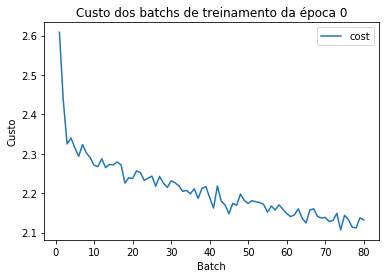

Epoch execution time: 0:00:28.428654
Batch execution time: 0:00:00.273383
Batch execution time: 0:00:00.208787
Batch execution time: 0:00:00.243949
Batch execution time: 0:00:00.181193
Batch execution time: 0:00:00.180169
Batch execution time: 0:00:00.177117
Batch execution time: 0:00:00.170234
Batch execution time: 0:00:00.165533
Batch execution time: 0:00:00.346792
Batch execution time: 0:00:00.235572
Batch execution time: 0:00:00.178663
Batch execution time: 0:00:00.188903
Batch execution time: 0:00:00.204737
Batch execution time: 0:00:00.221846
Batch execution time: 0:00:00.168383
Batch execution time: 0:00:00.264898
Batch execution time: 0:00:00.371592
Batch execution time: 0:00:00.407014
Batch execution time: 0:00:00.170651
Batch execution time: 0:00:00.197379
Batch execution time: 0:00:00.307759
Batch execution time: 0:00:00.210135
Batch execution time: 0:00:00.223557
Batch execution time: 0:00:00.200528
Batch execution time: 0:00:00.182361
Batch execution time: 0:00:00.464657
B

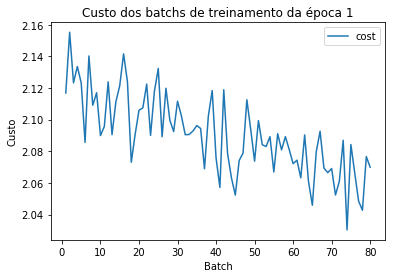

Epoch execution time: 0:00:17.043776
Batch execution time: 0:00:00.140233
Batch execution time: 0:00:00.150068
Batch execution time: 0:00:00.139450
Batch execution time: 0:00:00.147741
Batch execution time: 0:00:00.150536
Batch execution time: 0:00:00.142180
Batch execution time: 0:00:00.138518
Batch execution time: 0:00:00.149331
Batch execution time: 0:00:00.169594
Batch execution time: 0:00:00.155299
Batch execution time: 0:00:00.153339
Batch execution time: 0:00:00.155205
Batch execution time: 0:00:00.146848
Batch execution time: 0:00:00.145664
Batch execution time: 0:00:00.157004
Batch execution time: 0:00:00.161571
Batch execution time: 0:00:00.208139
Batch execution time: 0:00:00.157465
Batch execution time: 0:00:00.170387
Batch execution time: 0:00:00.149418
Batch execution time: 0:00:00.169124
Batch execution time: 0:00:00.156081
Batch execution time: 0:00:00.201683
Batch execution time: 0:00:00.172695
Batch execution time: 0:00:00.149213
Batch execution time: 0:00:00.149817
B

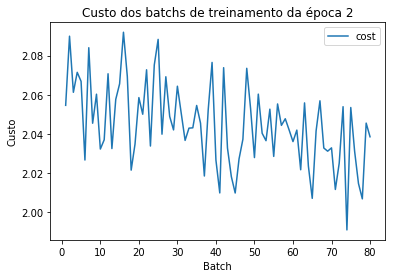

Epoch execution time: 0:00:14.401716
Batch execution time: 0:00:00.149545
Batch execution time: 0:00:00.163867
Batch execution time: 0:00:00.149426
Batch execution time: 0:00:00.156619
Batch execution time: 0:00:00.169093
Batch execution time: 0:00:00.163533
Batch execution time: 0:00:00.142734
Batch execution time: 0:00:00.168692
Batch execution time: 0:00:00.148799
Batch execution time: 0:00:00.169693
Batch execution time: 0:00:00.161330
Batch execution time: 0:00:00.212241
Batch execution time: 0:00:00.162834
Batch execution time: 0:00:00.172819
Batch execution time: 0:00:00.165626
Batch execution time: 0:00:00.160621
Batch execution time: 0:00:00.168102
Batch execution time: 0:00:00.193483
Batch execution time: 0:00:00.173098
Batch execution time: 0:00:00.185610
Batch execution time: 0:00:00.152944
Batch execution time: 0:00:00.154174
Batch execution time: 0:00:00.174215
Batch execution time: 0:00:00.164841
Batch execution time: 0:00:00.154287
Batch execution time: 0:00:00.182172
B

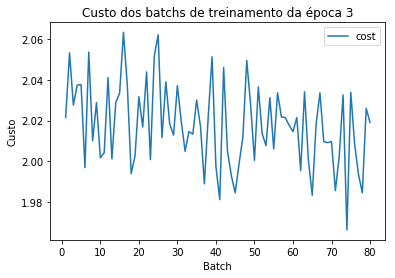

Epoch execution time: 0:00:14.646483
Batch execution time: 0:00:00.216263
Batch execution time: 0:00:00.168468
Batch execution time: 0:00:00.152370
Batch execution time: 0:00:00.154773
Batch execution time: 0:00:00.149237
Batch execution time: 0:00:00.144506
Batch execution time: 0:00:00.220432
Batch execution time: 0:00:00.149476
Batch execution time: 0:00:00.337599
Batch execution time: 0:00:00.244760
Batch execution time: 0:00:00.469478
Batch execution time: 0:00:00.424069
Batch execution time: 0:00:00.192393
Batch execution time: 0:00:00.161138
Batch execution time: 0:00:00.166107
Batch execution time: 0:00:00.302841
Batch execution time: 0:00:00.155658
Batch execution time: 0:00:00.151649
Batch execution time: 0:00:00.310152
Batch execution time: 0:00:00.200108
Batch execution time: 0:00:00.167192
Batch execution time: 0:00:00.342864
Batch execution time: 0:00:00.207284
Batch execution time: 0:00:00.145458
Batch execution time: 0:00:00.140078
Batch execution time: 0:00:00.155348
B

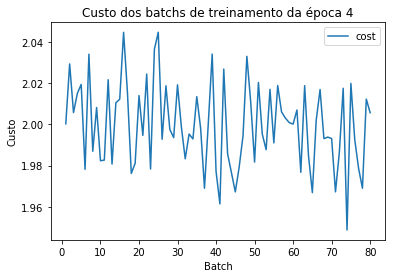

Epoch execution time: 0:00:17.230016
Batch execution time: 0:00:00.153790
Batch execution time: 0:00:00.167050
Batch execution time: 0:00:00.218266
Batch execution time: 0:00:00.166518
Batch execution time: 0:00:00.264789
Batch execution time: 0:00:00.201006
Batch execution time: 0:00:00.177319
Batch execution time: 0:00:00.159109
Batch execution time: 0:00:00.152695
Batch execution time: 0:00:00.156468
Batch execution time: 0:00:00.162205
Batch execution time: 0:00:00.176419
Batch execution time: 0:00:00.158281
Batch execution time: 0:00:00.162010
Batch execution time: 0:00:00.175841
Batch execution time: 0:00:00.249918
Batch execution time: 0:00:00.273058
Batch execution time: 0:00:00.252693
Batch execution time: 0:00:00.653039
Batch execution time: 0:00:00.725260
Batch execution time: 0:00:00.237304
Batch execution time: 0:00:00.176501
Batch execution time: 0:00:00.386445
Batch execution time: 0:00:00.343677
Batch execution time: 0:00:00.267847
Batch execution time: 0:00:00.282524
B

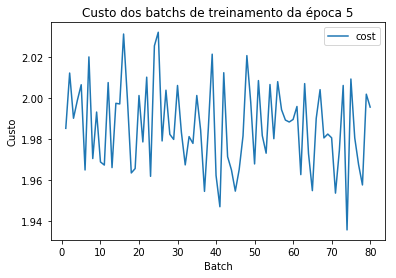

Epoch execution time: 0:00:17.874386
Batch execution time: 0:00:00.160898
Batch execution time: 0:00:00.147483
Batch execution time: 0:00:00.160008
Batch execution time: 0:00:00.148896
Batch execution time: 0:00:00.146251
Batch execution time: 0:00:00.152964
Batch execution time: 0:00:00.156669
Batch execution time: 0:00:00.140016
Batch execution time: 0:00:00.153447
Batch execution time: 0:00:00.198414
Batch execution time: 0:00:00.147796
Batch execution time: 0:00:00.155849
Batch execution time: 0:00:00.155471
Batch execution time: 0:00:00.148699
Batch execution time: 0:00:00.149484
Batch execution time: 0:00:00.144376
Batch execution time: 0:00:00.160101
Batch execution time: 0:00:00.151698
Batch execution time: 0:00:00.149129
Batch execution time: 0:00:00.168713
Batch execution time: 0:00:00.141320
Batch execution time: 0:00:00.174938
Batch execution time: 0:00:00.152866
Batch execution time: 0:00:00.197348
Batch execution time: 0:00:00.151906
Batch execution time: 0:00:00.158786
B

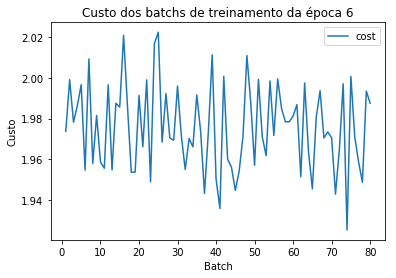

Epoch execution time: 0:00:14.631375
Batch execution time: 0:00:00.155641
Batch execution time: 0:00:00.191836
Batch execution time: 0:00:00.147891
Batch execution time: 0:00:00.174256
Batch execution time: 0:00:00.164594
Batch execution time: 0:00:00.161919
Batch execution time: 0:00:00.146774
Batch execution time: 0:00:00.161289
Batch execution time: 0:00:00.177878
Batch execution time: 0:00:00.161305
Batch execution time: 0:00:00.211612
Batch execution time: 0:00:00.179297
Batch execution time: 0:00:00.174555
Batch execution time: 0:00:00.170703
Batch execution time: 0:00:00.168359
Batch execution time: 0:00:00.149603
Batch execution time: 0:00:00.155500
Batch execution time: 0:00:00.143256
Batch execution time: 0:00:00.185236
Batch execution time: 0:00:00.142927
Batch execution time: 0:00:00.148162
Batch execution time: 0:00:00.145362
Batch execution time: 0:00:00.153907
Batch execution time: 0:00:00.150863
Batch execution time: 0:00:00.142577
Batch execution time: 0:00:00.143159
B

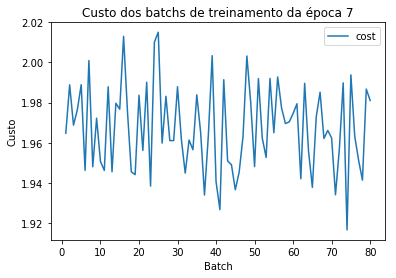

Epoch execution time: 0:00:20.660899
Batch execution time: 0:00:00.197343
Batch execution time: 0:00:00.166623
Batch execution time: 0:00:00.139999
Batch execution time: 0:00:00.156597
Batch execution time: 0:00:00.214973
Batch execution time: 0:00:00.243104
Batch execution time: 0:00:00.323582
Batch execution time: 0:00:00.322756
Batch execution time: 0:00:00.224291
Batch execution time: 0:00:00.195503
Batch execution time: 0:00:00.146498
Batch execution time: 0:00:00.169031
Batch execution time: 0:00:00.155696
Batch execution time: 0:00:00.175204
Batch execution time: 0:00:00.206354
Batch execution time: 0:00:00.155650
Batch execution time: 0:00:00.152796
Batch execution time: 0:00:00.153539
Batch execution time: 0:00:00.146963
Batch execution time: 0:00:00.149148
Batch execution time: 0:00:00.193325
Batch execution time: 0:00:00.198717
Batch execution time: 0:00:00.281055
Batch execution time: 0:00:00.257090
Batch execution time: 0:00:00.171362
Batch execution time: 0:00:00.177712
B

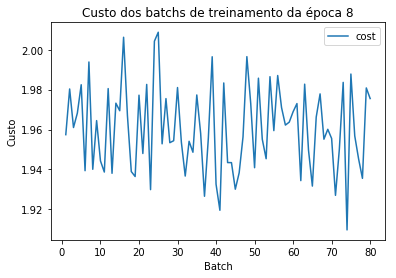

Epoch execution time: 0:00:15.900546
Batch execution time: 0:00:00.145772
Batch execution time: 0:00:00.179522
Batch execution time: 0:00:00.167112
Batch execution time: 0:00:00.151376
Batch execution time: 0:00:00.145776
Batch execution time: 0:00:00.154960
Batch execution time: 0:00:00.150311
Batch execution time: 0:00:00.144532
Batch execution time: 0:00:00.149295
Batch execution time: 0:00:00.204470
Batch execution time: 0:00:00.146049
Batch execution time: 0:00:00.156596
Batch execution time: 0:00:00.164160
Batch execution time: 0:00:00.158635
Batch execution time: 0:00:00.163015
Batch execution time: 0:00:00.165482
Batch execution time: 0:00:00.172710
Batch execution time: 0:00:00.240982
Batch execution time: 0:00:00.183507
Batch execution time: 0:00:00.178187
Batch execution time: 0:00:00.154998
Batch execution time: 0:00:00.149162
Batch execution time: 0:00:00.142481
Batch execution time: 0:00:00.145451
Batch execution time: 0:00:00.148378
Batch execution time: 0:00:00.153577
B

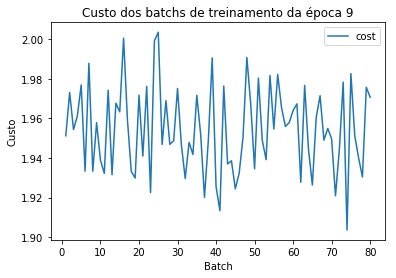

Epoch execution time: 0:00:14.295354
Cost by Epoch: [(0, 2.106703405881815, 2.127598083233455), (1, 2.030254794991926, 2.065245424045796), (2, 1.9910919594934866, 2.0316938246995915), (3, 1.9662699159579624, 2.0100931098459967), (4, 1.9487677639620438, 1.9948383864120918), (5, 1.9355819616546206, 1.9833721838363345), (6, 1.9251856743437075, 1.9743502078615158), (7, 1.9167125518735157, 1.9670012895715219), (8, 1.9096305103219593, 1.9608528998129113), (9, 1.9035923461524076, 1.9555995020244001)]


In [149]:
(cost_by_epoch_training, weights)= train(10,weights1,0.01,1000,inputs,-1)

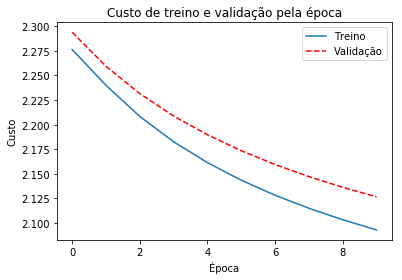

In [148]:
plot_cost_train_val_by_epoch(cost_by_epoch_training)

# Redes Neurais

In [22]:
def relu(x):
    if x < 0:
        return 0
    else:
        return x

In [98]:
def reluMatrix(ZnetHidden): 
    vectRelu = np.vectorize(relu)
    ZOutHidden = vectRelu(ZnetHidden)
        
    return ZOutHidden

In [34]:
def addBiasHidden(ZOutHidden):
    ZOutBias = []
    
    for (i,I) in enumerate(ZOutHidden):
        linha = [1] + I
        ZOutBias.append(linha)
        
    return ZOutBias

## Forward Propagation

In [73]:
def processFoward(inputs, weights1, weights2):
    #Camada escondida - hidden
    ZnetHidden = calculateZNet(inputs, weights1)
    ZOutHidden = reluMatrix(ZnetHidden)
#     ZOutHidden = addBiasHidden(ZOutHidden)
    
    #Camada final - out
    inputs2 = np.array(ZOutHidden)
    ZNetOut = calculateZNet(inputs2, weights2)
    ZOutAll = softmax(ZNetOut)
    
    return (ZnetHidden, ZOutHidden, ZNetOut, ZOutAll)

## BackPropagation

In [77]:
def derivativeCostFunctionFistLayer(weights1, Zout, targets, weights2, ZnetHidden, inputs):
    Out = np.subtract(Zout, targets)
    dETotal_dOuth = Out.dot(weights2.T)
    
    derivative_relu = lambda x : 1 if x > 0 else 0
    derivative_relu_vec = np.vectorize(derivative_relu)
    
    print("ZnetHidden shape:", ZnetHidden.shape)
    dOuth1_dNeth1 = derivative_relu_vec(ZnetHidden)
    
    aux = dOuth1_dNeth1 * dETotal_dOuth
    
    dETotal_dW = inputs.T.dot(aux)
    
    qtdLinhas = len(inputs)
    
    divide = lambda x : x / qtdLinhas
    
    ajuste_weight = divide(dETotal_dW)
    
    return ajuste_weight

In [94]:
def backpropagation(inputs,ZNetHiddenP,ZOutHidden,ZOutAll,weightsInHiddenConnection,weightsHiddenOutConnection,targets,learningRate):
    variationWeightInHidden = derivativeCostFunctionFistLayer(weightsInHiddenConnection, ZOutAll, targets, weightsHiddenOutConnection, ZNetHiddenP, inputs)
    variationWeightHiddenOut = derivativeCostFunction(ZOutHidden, ZOutAll, targets, weightsHiddenOutConnection)
    
    #Atualizando pesos da conexão in - hidden
    v1 = learningRate*variationWeightInHidden
    updatedWeightsInHidden = np.subtract(weightsInHiddenConnection, v1)
    
    v2 = learningRate*variationWeightHiddenOut
    updatedWeightsHiddenOut = np.subtract(weightsHiddenOutConnection,v2)
    
    return (updatedWeightsInHidden, updatedWeightsHiddenOut)

### Treino

In [95]:
def train_neural_network(epochs,weightsInHiddenConnection,weightsHiddenOutConnection,learningRate,batchSize,dataSet,batchIterations):        
    cost_by_epoch = list()

    for i in range(epochs):
        epochInitTime = datetime.datetime.now()
        iterator = BatchIterator(batchSize, dataSet,batchIterations)
        targetIterator = BatchIterator(batchSize, targets, batchIterations)

        bestCost = -1;
        cost_by_batch = list()
        batchIndex = 0

        while iterator.hasNext():
            initTime = datetime.datetime.now()

            batch = iterator.prox()
            batchTargets = targetIterator.prox()

            (ZnetHidden, ZOutHidden, Znet, ZOut) = processFoward(batch,weightsInHiddenConnection,weightsHiddenOutConnection)

            (updatedWeightsInHidden, updatedWeightsHiddenOut) = backpropagation(batch,ZnetHidden,ZOutHidden,ZOut,weightsInHiddenConnection,weightsHiddenOutConnection,batchTargets,learningRate)
            
            weightsInHiddenConnection = updatedWeightsInHidden
            weightsHiddenOutConnection = updatedWeightsHiddenOut
            
            cost = costFunction(ZOut, targets)

            batchIndex+=1
            cost_by_batch.append((batchIndex, cost))

            if(bestCost == -1 or cost < bestCost):
                bestCost = cost

            endTime = datetime.datetime.now()

            print("Batch execution time:", endTime - initTime)

        print("cost_by_batch:", cost_by_batch)
        #Plota os custos por batch da época
        df_cost_batch = pd.DataFrame(cost_by_batch, columns = ['batch' , 'cost',])
        fig, ax = plt.subplots()
        plt.title("Custo dos batchs de treinamento da época " + str(i))
        plt.xlabel('Batch')
        plt.ylabel('Custo')
        ax.plot(df_cost_batch['batch'], df_cost_batch['cost'])
        ax.legend()
        plt.show()

        # Validação
        (ZnetHiddenVal, ZOutHiddenVal, ZnetVal, ZOutVal) = processFoward(inputsVal,weightsInHiddenConnection,weightsHiddenOutConnection)
        cost_val = costFunction(ZOutVal, targetsVal)
        cost_by_epoch.append((i, bestCost, cost_val))

        epochEndTime = datetime.datetime.now()
        print("Epoch execution time:", epochEndTime - epochInitTime)

    print("Cost by Epoch:", cost_by_epoch)
    return (cost_by_epoch, weightsInHiddenConnection, weightsHiddenOutConnection)



# Execução Treino 

In [79]:
weightsInHiddenConnection = get_randomly_initialized_theta(3073,2304)

In [80]:
weightsHiddenOutConnection = get_randomly_initialized_theta(2304,10)

ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.564462
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.396469
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.474860
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.452073
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.599813
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.537890
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.653205
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.622411
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.024912
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.678920
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.580374
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.683033
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.091359
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.983030
ZnetHidden shape: (1000, 2304)
Batch execution t

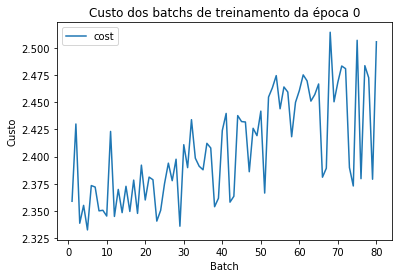

Epoch execution time: 0:03:14.421171
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:01.913127
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.100819
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.628268
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:03.002317
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:03.345235
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.979859
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.734571
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.257517
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.349531
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.399801
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.635438
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.271248
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.277047
ZnetHidden shape: (1000, 2304)
Batch execution time: 0:00:02.491435
ZnetHidden 

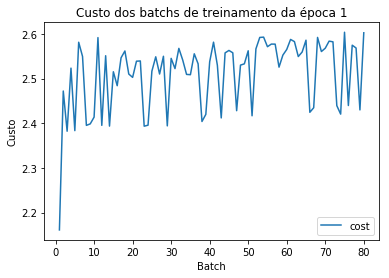

Epoch execution time: 0:03:34.136011
Cost by Epoch: [(0, 2.332473732260306, 2.0474560651166214), (1, 2.161133449380736, 1.982904835424424)]


In [99]:
(cost_by_epoch_training_neural, weightsInHiddenConnection, weightsHiddenOutConnection) = train_neural_network(2,weightsInHiddenConnection,weightsHiddenOutConnection,0.01,1000,inputs,-1)


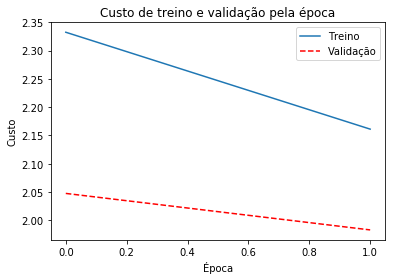

In [105]:
plot_cost_train_val_by_epoch(cost_by_epoch_training_neural)